In [1]:
# Parameters
var_list = [
    "cape",
    "crr",
    "d",
    "ie",
    "ishf",
    "lsrr",
    "pv",
    "q",
    "r",
    "sp",
    "tcw",
    "tcwv",
    "t",
    "ttr",
    "u",
    "v",
    "vo",
    "w",
]
plevel_list = [
    False,
    False,
    850,
    False,
    False,
    False,
    850,
    850,
    850,
    False,
    False,
    False,
    850,
    False,
    850,
    850,
    850,
    850,
]
aew_subset = "24hr_before"
model_save_name = "best_model24_8501.keras"
tuner_project_name = "tuner_run24_8501"


In [2]:
#!/usr/bin/env python

# coding: utf-8


import numpy as np

import matplotlib.pyplot as plt

import xarray as xr

import sklearn

import sklearn.model_selection

import keras

from keras import layers

import keras_tuner



import tensorflow as tf

import tensorflow.keras.backend as K

keras.utils.set_random_seed(812)

2025-07-10 02:27:05.690715: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 02:27:05.700921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752136025.711157   82711 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752136025.714663   82711 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752136025.724776   82711 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

def focal_loss(gamma=2.0, alpha=0.25):
    """Focal Loss for binary classification."""
    def loss_fn(y_true, y_pred):
        # Clip to prevent NaNs 
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        bce = tf.keras.backend.binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        alpha_factor = y_true * alpha + (1 - y_true) * (1 - alpha)
        return alpha_factor * modulating_factor * bce
    return loss_fn


In [4]:
#functions to calculate f1 score as loss function

def f1_loss_sigmoid(y_true, y_pred):
    """

    F1 metric for sigmoid output and integer encoded labels.

"""

    # compute tp, fp, and fn

    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)

    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)

    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)


    # precision (tp / (tp + fp))

    p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

    r = tp / (tp + fn + K.epsilon())


# harmonic mean of precision and recall

    f1 = (2 * p * r) / (p + r + K.epsilon())

    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

    return 1 - K.mean(f1)

In [5]:
def f1_loss_onehot(y_true, y_pred):

   """

   F1 metric for two-class output and one-hot encoded labels.

   """

   # compute tp, fp, and fn

   tp = K.sum(K.cast(y_true[:, 1] * y_pred[:, 1], 'float'), axis=0)

   fp = K.sum(K.cast((1 - y_true[:, 1]) * y_pred[:, 1], 'float'), axis=0)

   fn = K.sum(K.cast(y_true[:, 0] * (1 - y_pred[:, 0]), 'float'), axis=0)


   # precision (tp / (tp + fp))

   p = tp / (tp + fp + K.epsilon())

   # recall (tp / (tp + fn))

   r = tp / (tp + fn + K.epsilon())


   # harmonic mean of precision and recall

   f1 = (2 * p * r) / (p + r + K.epsilon())

   f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)

   return 1 - K.mean(f1)

In [6]:
import re


def add_dim(ds):
    # Extract the source file name from the dataset's encoding.
    fname = ds.encoding.get('source', '')
    # Use a regex to capture the central latitude and longitude from the filename.
    m = re.search(r'_(\-?\d+\.\d+)_(-?\d+\.\d+)\.nc$', fname)
    if m:
        lat_center = float(m.group(1))
        lon_center = float(m.group(2))
        # Assign the central coordinates and the file name as new coordinates.
        ds = ds.assign_coords(lat_center=lat_center, lon_center=lon_center, file_name=fname)
    else:
        print("File name does not match expected pattern:", fname)
    
    # Expand dims to add the 'sample' dimension and drop unnecessary variables.
    return ds.assign_coords({"sample": 1}).expand_dims(dim={"sample": 1}).drop_vars("utc_date").drop_vars("latitude").drop_vars("longitude")




    

In [7]:
import os
import xarray as xr

def open_files_zarr(list_of_vars, aew_subset="24hr_before",
                    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
                    plevel_list=None, zarr_store_path="zarr_data"):
    """
    Opens ERA5 NetCDF files for the given variables. For each variable (or pressure-level variant),
    it checks if a corresponding Zarr store exists in 'zarr_store_path'. If so, it loads the dataset
    from the Zarr store; if not, it opens the NetCDF files, preprocesses them, saves them to Zarr,
    and then returns the dataset.
    """
    # Create the zarr_store_path directory if it doesn't exist.
    if not os.path.exists(zarr_store_path):
        os.makedirs(zarr_store_path)
    
    datas = {}
    for num, var in enumerate(list_of_vars):
        # Determine the key and filename based on whether a pressure level is specified.
        if plevel_list:
            if plevel_list[num]:
                key = f"{var}_{int(plevel_list[num])}"
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_{int(plevel_list[num])}_*.nc'
            else:
                key = var
                file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        else:
            key = var
            file_pattern = f'{directory}/{var}/aew_{aew_subset}_*.nc'
        
        # Define the zarr path for this variable.
        zarr_path = os.path.join(zarr_store_path, f"{key}.zarr")
        
        # If the Zarr dataset exists, load from it; otherwise, create it.
        if os.path.exists(zarr_path):
            print(f"Loading {key} from Zarr store.")
            ds = xr.open_zarr(zarr_path)
        else:
            print(f"Creating Zarr store for {key} from NetCDF files.")
            ds = xr.open_mfdataset(
                file_pattern,
                preprocess=add_dim,
                concat_dim="sample",
                combine="nested",
            )
            ds.to_zarr(zarr_path, mode="w")
        datas[key] = ds
    
    return datas


In [8]:
def transpose_load_concat(data_dictionary):
    # Instead of eagerly converting to NumPy arrays, keep the datasets as xarray objects.
    transposed = {}
    for key, ds in data_dictionary.items():
        var_name = key.split('_')[0].upper()
        # Do lazy transpose and add a 'features' dimension
        transposed[key] = ds[var_name].expand_dims('features').transpose('sample', 'latitude', 'longitude', 'features')
    # Concatenate along the new 'features' dimension (if multiple variables exist)
    if len(transposed) > 1:
        data = xr.concat(list(transposed.values()), dim='features',coords='minimal',compat='override')
    else:
        data = list(transposed.values())[0]
    # Use the coordinates (lat_center, lon_center) from one of the datasets.
    # They remain lazy and are not computed until needed.
    first_key = next(iter(data_dictionary))
    lat_center = data_dictionary[first_key]['lat_center']
    lon_center = data_dictionary[first_key]['lon_center']
    label = data_dictionary[first_key]['label']
    return data, label, lat_center, lon_center



In [9]:
def omit_nans(data, label, lat, lon):
    # If data is an xarray DataArray, convert it to a NumPy array
    if hasattr(data, 'values'):
        data = data.values
    maskarray = np.full(data.shape[0], True)
    # Find indices where NaNs occur
    masker = np.unique(np.argwhere(np.isnan(data))[:, 0])
    maskarray[masker] = False

    traindata = data[maskarray, ...]
    trainlabel = label[maskarray]
    lat_filtered = lat[maskarray]
    lon_filtered = lon[maskarray]
    return traindata, trainlabel, lat_filtered, lon_filtered



In [10]:
def zscore(data):

  """

  Rescaling the data using zscore (mean/std).

  Each variable gets scaled independently from others.

  Note that we will need to remove test data for formal training.

  """

  for i in range(0, data_.shape[-1]):

      data_[:, :, :, i] = (

               data_[:, :, :, i] - np.nanmean(

                     data_[:, :, :, i])) / np.nanstd(data_[:, :, :, i])

  return data_

In [11]:
def minmax(data):

   """

   Rescaling the data using min-max.

   Each variable gets scaled independently from others.

   Note that we will need to remove test data for formal training.

   """

   for i in range(0, data_.shape[-1]):

          data_[:, :, :, i] = (

              data_[:, :, :, i] - np.nanmin(data_[:, :, :, i])

          ) / (np.nanmax(data_[:, :, :, i]) - np.nanmin(data_[:, :, :, i]))
   return data

In [12]:
def random_split(data, label, split=0.3, seed=0):

   """

   Help spliting data randomly for training and testing.

   """

   np.random.seed(0)

   da_indx = np.random.permutation(data.shape[0])

   data = data[da_indx.astype(int)]

   label = label[da_indx.astype(int)]

   init_range = int(data.shape[0] * (1 - 0.3))

   return data[:init_range], label[:init_range], data[init_range:], label[init_range:]

In [13]:
def pick_loss(loss_string):
    

    lossdict = {
        "relu": tf.nn.relu,
        "tanh": tf.nn.tanh,
        "selu": tf.nn.selu,
        "sigmoid": tf.nn.sigmoid,
        "relu6": tf.nn.relu6,
        "silu": tf.nn.silu,
        "gelu": tf.nn.gelu,
        "lrelu": tf.nn.leaky_relu,
    }

    return lossdict[loss_string]

In [14]:
def compute_saliency_map(model, input_sample):
    """
    Compute a saliency map for a given input sample using a gradient-based approach.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample of shape (1, height, width, channels).
    
    Returns:
        saliency (numpy array): The saliency map of shape (height, width).
    """
    # Ensure the model is in inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Use GradientTape to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        # Watch the input tensor
        tape.watch(input_tensor)
        # Get the model's prediction
        prediction = model(input_tensor)
    
    # Compute gradients of the prediction with respect to the input
    grads = tape.gradient(prediction, input_tensor)
    
    # If there are multiple channels, take the maximum absolute gradient across channels
    saliency = np.max(np.abs(grads.numpy()), axis=-1)[0]
    return saliency

In [15]:
def compute_saliency_per_channel(model, input_sample):
    """
    Computes the saliency map for each channel of a given input sample.
    
    Args:
        model (tf.keras.Model): The trained Keras model.
        input_sample (numpy array): A single input sample with shape (1, H, W, C).
        
    Returns:
        saliency_maps (numpy array): Absolute gradients with shape (H, W, C) for each channel.
        channel_importance (numpy array): Mean saliency per channel (shape: (C,)).
    """
    # Set the model to inference mode
    model.trainable = False
    input_tensor = tf.convert_to_tensor(input_sample)
    
    # Compute gradients with respect to the input sample using GradientTape
    with tf.GradientTape() as tape:
        tape.watch(input_tensor)
        prediction = model(input_tensor)
    
    # Calculate gradients: shape (1, H, W, C)
    grads = tape.gradient(prediction, input_tensor)
    
    # Remove the batch dimension: shape becomes (H, W, C)
    grads = grads.numpy()[0]
    
    # Take absolute value to measure importance (magnitude of sensitivity)
    saliency_maps = np.abs(grads)
    
    # Aggregate saliency per channel (e.g., using the mean over spatial dimensions)
    channel_importance = np.mean(saliency_maps, axis=(0, 1))
    
    return saliency_maps, channel_importance

In [16]:
number_of_features = len(var_list)

In [17]:
data = open_files_zarr(
    list_of_vars=var_list,
    aew_subset="24hr_before",
    directory="/glade/derecho/scratch/rmandava/AEW_time_location_files/",
    plevel_list=plevel_list,
    zarr_store_path="/glade/derecho/scratch/rmandava/AEW_time_location_files/Project1/zarr_24hr"
)






Loading cape from Zarr store.
Loading crr from Zarr store.
Loading d_850 from Zarr store.


Loading ie from Zarr store.
Loading ishf from Zarr store.
Loading lsrr from Zarr store.
Loading pv_850 from Zarr store.
Loading q_850 from Zarr store.
Loading r_850 from Zarr store.
Loading sp from Zarr store.
Loading tcw from Zarr store.
Loading tcwv from Zarr store.
Loading t_850 from Zarr store.
Loading ttr from Zarr store.
Loading u_850 from Zarr store.
Loading v_850 from Zarr store.
Loading vo_850 from Zarr store.
Loading w_850 from Zarr store.


In [18]:
# transpose the data and concat variables

#data_, labels_ = transpose_load_concat(data)
data_, labels_, sample_lat, sample_lon = transpose_load_concat(data)

print(np.shape(data_))

(2444, 32, 32, 18)


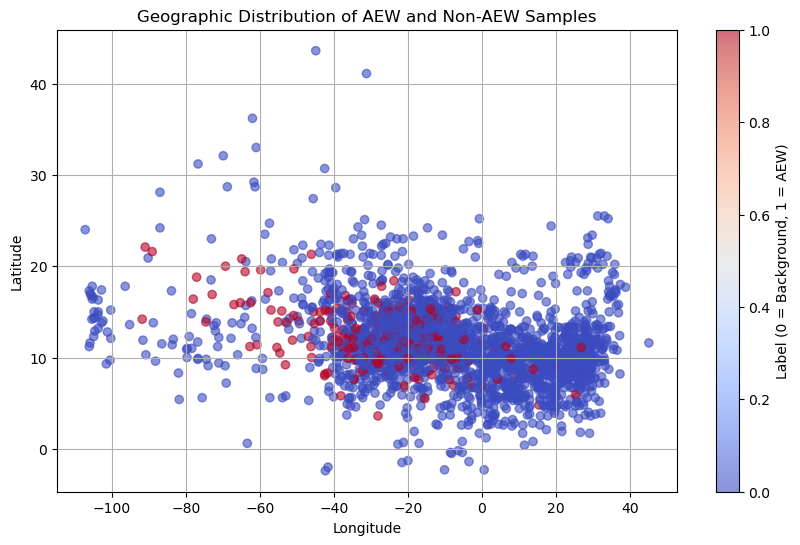

In [19]:
import matplotlib.pyplot as plt

# Scatter plot: where are the samples located, colored by label (AEW or not)
plt.figure(figsize=(10, 6))
sc = plt.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', alpha=0.6)
plt.colorbar(sc, label="Label (0 = Background, 1 = AEW)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AEW and Non-AEW Samples")
plt.grid(True)
plt.show()


In [20]:
print(var_list)


['cape', 'crr', 'd', 'ie', 'ishf', 'lsrr', 'pv', 'q', 'r', 'sp', 'tcw', 'tcwv', 't', 'ttr', 'u', 'v', 'vo', 'w']


In [21]:
# check / remove nans

data_, labels_, sample_lat, sample_lon = omit_nans(data_, labels_, sample_lat, sample_lon)






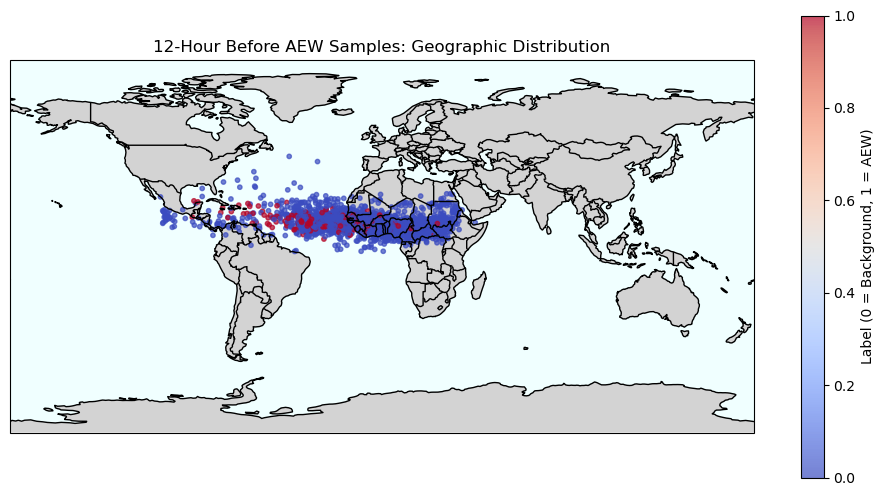

In [22]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(12, 6))

# Set up map projection
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='azure')

# Plot sample locations colored by label
sc = ax.scatter(sample_lon, sample_lat, c=labels_, cmap='coolwarm', s=10, alpha=0.7, transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label="Label (0 = Background, 1 = AEW)")
plt.title("12-Hour Before AEW Samples: Geographic Distribution")
plt.show()

In [23]:
print("Total samples:", len(sample_lat))


Total samples: 2444


In [24]:
print("Latitude Range:", float(sample_lat.min().compute()), "to", float(sample_lat.max().compute()))
print("Longitude Range:", float(sample_lon.min().compute()), "to", float(sample_lon.max().compute()))


Latitude Range: -2.4 to 43.6
Longitude Range: -107.2 to 45.1


In [25]:
#split train and test set
X_train, X_test, y_train, y_test, lat_train, lat_test, lon_train, lon_test = sklearn.model_selection.train_test_split(
    data_, labels_, sample_lat, sample_lon, test_size=0.2, random_state=42)



print (np.shape(X_train), np.shape(X_test), np.shape(y_train), np.shape(y_test))


y_train = np.expand_dims(y_train, axis=1)

y_test = np.expand_dims(y_test, axis=1)

(1955, 32, 32, 18) (489, 32, 32, 18) (1955,) (489,)


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 364 times more chunks
  return self.array[key]
/glade/u/home/rmandava/.local/lib/python3.10/site-packages/xarray/core/indexing.py:1642: PerformanceWarning: Slicing with an out-of-order index is generating 94 times more chunks
  return self.array[key]


In [26]:
# [21]: Scaling code (fixed to prevent data leakage)

# Create the scaler object
scaler_input = sklearn.preprocessing.StandardScaler()

# Reshape training data to 2D (samples, features)
X_train_tmp = np.reshape(X_train, (-1, len(var_list)))

# Fit the scaler ONLY on the training data
scaler_input.fit(X_train_tmp)  # <-- Key change: Learn mean/std from training data

# Transform BOTH training and test data using the SAME scaler
input_train_scaled = scaler_input.transform(X_train_tmp)          # Train: transform only
input_test_scaled = scaler_input.transform(                       # Test: transform only
    np.reshape(X_test, (-1, len(var_list)))
)

# Reshape back to original dimensions (samples, height, width, features)
input_train_scaled = np.reshape(input_train_scaled, X_train.shape)
input_test_scaled = np.reshape(input_test_scaled, X_test.shape)

# Labels remain unchanged
label_train_scaled = y_train
label_test_scaled = y_test

In [27]:
# print the shapes to double check them

print(

input_train_scaled.shape,

label_train_scaled.shape,

input_test_scaled.shape,

label_test_scaled.shape

)

(1955, 32, 32, 18) (1955, 1) (489, 32, 32, 18) (489, 1)


In [28]:
#generate class weights due to class imbalance issues

counts = np.bincount(y_train[:, 0].astype(int))


print(

"Number of positive samples in training data: {} ({:.2f}% of total)".format(

counts[1], 100 * float(counts[1]) / len(y_train))

)

Number of positive samples in training data: 201 (10.28% of total)


In [29]:
# old weights

# weight_for_0 = 1.0 / counts[0]

# weight_for_1 = 1.0 / counts[1]


#new weights

weight_for_0 = float(counts[1]) / len(y_train)

weight_for_1 = 1 - (float(counts[1]) / len(y_train))


class_weight = {0: weight_for_0, 1: weight_for_1}

print(class_weight)

{0: 0.10281329923273658, 1: 0.8971867007672634}


In [30]:
METRICS = [

keras.metrics.BinaryCrossentropy(name='cross entropy'),

keras.metrics.MeanSquaredError(name='mean_squared_error'),

keras.metrics.RootMeanSquaredError(name='root_mean_squared_error'),

keras.metrics.TruePositives(name='tp'),

keras.metrics.FalsePositives(name='fp'),

keras.metrics.TrueNegatives(name='tn'),

keras.metrics.FalseNegatives(name='fn'),

keras.metrics.BinaryAccuracy(name='binary_accuracy'),

keras.metrics.F1Score(threshold=0.5, name='f1_score'),

keras.metrics.Precision(name='precision'),

keras.metrics.Recall(name='recall'),

keras.metrics.AUC(name='auc'),

keras.metrics.AUC(name='prc', curve='PR'),

]

2025-07-10 02:28:47.485961: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [31]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.Sequential()

        model.add(keras.Input(shape=(32, 32, number_of_features)))

        # Data augmentation
        model.add(layers.RandomFlip("horizontal_and_vertical"))
        model.add(layers.RandomRotation(factor=(-0.5, 0.5)))

        # CNN layers (same tuning as before)
        featmaps1 = hp.Int('units_1', min_value=10, max_value=60)
        featmaps2 = hp.Int('units_2', min_value=10, max_value=64)
        featmaps3 = hp.Int('units_3', min_value=10, max_value=128)
        featmaps4 = hp.Int('units_4', min_value=10, max_value=80)
        learning_rate = hp.Float('lr', min_value=0.00001, max_value=0.01, sampling="linear")
        act_func = hp.Choice('activation', ["relu", "tanh", "selu", "sigmoid", "relu6", "silu", "gelu"])

        model.add(layers.Conv2D(featmaps1, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps2, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.Conv2D(featmaps3, 3, strides=1, padding="same", activation=pick_loss(act_func)))
        model.add(layers.MaxPooling2D(2))
        model.add(layers.Dropout(0.2))

        model.add(layers.GlobalMaxPooling2D())
        model.add(layers.Dense(featmaps4))
        model.add(layers.Dense(1, activation="sigmoid"))

        
        

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss=focal_loss(gamma=2.0, alpha=0.25),  # pass tuned gamma and alpha!
            metrics=METRICS
        )

        return model



In [32]:
def fit(self, hp, model, *args, **kwargs):
    batchsizenum = hp.Int('batch_size', min_value=10, max_value=60, step=5, sampling="linear")

    print({k: hp.get(k) if hp.is_active(k) else None for k in hp._hps})

    return model.fit(
        *args,
        batch_size=batchsizenum,
        # normally we might use early stopping, but not needed since
        # callbacks saves checkpoints of the model during trials
        # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=5),
        validation_split=0.1,
        shuffle=True,
        class_weight=class_weight,
        **kwargs,
    )


In [33]:
# make the tuner object
tuner = keras_tuner.BayesianOptimization(
    hypermodel=MyHyperModel(),
    objective=keras_tuner.Objective("val_f1_score", direction="max"),
    max_trials=150,
    project_name=tuner_project_name,
    alpha=0.0001,
    beta=2.6,
    seed=123,
    tune_new_entries=True,
    allow_new_entries=True,
    max_retries_per_trial=1,
    max_consecutive_failed_trials=3,
    overwrite=True,
)

# summary
tuner.search_space_summary()


Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 64, 'step': 1, 'sampling': 'linear'}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 128, 'step': 1, 'sampling': 'linear'}
units_4 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 80, 'step': 1, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'selu', 'sigmoid', 'relu6', 'silu', 'gelu'], 'ordered': False}


In [34]:
import numpy as np

labels_np = np.array(labels_)

total = len(labels_np)
positives = np.sum(labels_np == 1)
negatives = np.sum(labels_np == 0)

print("Total samples:", total)
print("AEW-positive samples (label=1):", positives)
print("Background samples (label=0):", negatives)


Total samples: 2444
AEW-positive samples (label=1): 253
Background samples (label=0): 2191


In [35]:
# Begin the search
EPOCHS = 100

tuner.search(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1
)

# Query the tuner object to grab the best models
models = tuner.get_best_models(num_models=5)

# Here is the best model from the tuner
best_model = models[0]
print(best_model.summary())

# Get the top hyperparameters.
best_hps = tuner.get_best_hyperparameters()

# Build the model with the best hyperparameters.
# Assuming your MyHyperModel has a build method that takes a hyperparameter object.
model = MyHyperModel().build(best_hps[0])

# Save the best model (architecture and weights)

save_dir = "/glade/derecho/scratch/rmandava/AEW_time_location_files/models"
model_save_path = os.path.join(save_dir, model_save_name)

model.save(model_save_path)


# Retrain using "best" model hyperparameters
history = model.fit(
    input_train_scaled,
    label_train_scaled,
    epochs=EPOCHS,
    validation_split=0.1,
    batch_size= 32,
    # callbacks=keras.callbacks.EarlyStopping('val_loss', patience=3),
    shuffle=True,
    class_weight=class_weight,  # Ensure 'class_weight' is defined in your scope
)

# Evaluate the model on the test data using `evaluate`
results = model.evaluate(input_test_scaled, label_test_scaled, batch_size=label_test_scaled.shape[0])
print(results)

# Generate predictions (probabilities—the output of the last layer)
predictions = model.predict(input_test_scaled)
print("predictions shape:", predictions.shape)

# Compute confusion matrix elements
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(
    label_test_scaled, np.round(predictions)
).ravel()
print("tn:", tn)
print("fp:", fp)
print("fn:", fn)
print("tp:", tp)


Trial 150 Complete [00h 01m 11s]
val_f1_score: 0.6315789818763733

Best val_f1_score So Far: 0.6666666269302368
Total elapsed time: 03h 05m 05s


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 32, 32, 18)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 57)          │           9,291 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 57)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 57)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 48)          │          24,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 48)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 71)            │          30,743 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 71)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 71)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 71)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 65)                  │           4,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,452 (271.30 KB)

 Trainable params: 69,452 (271.30 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1:25 2s/step - auc: 0.7638 - binary_accuracy: 0.7675 - cross entropy: 0.4587 - f1_score: 0.3457 - fn: 11.0000 - fp: 42.0000 - loss: 0.0286 - mean_squared_error: 0.1484 - prc: 0.2815 - precision: 0.2500 - recall: 0.5600 - root_mean_squared_error: 0.3852 - tn: 161.0000 - tp: 14.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7222 - binary_accuracy: 0.7959 - cross entropy: 0.4448 - f1_score: 0.3462 - fn: 17.1667 - fp: 45.0000 - loss: 0.0544 - mean_squared_error: 0.1357 - prc: 0.2755 - precision: 0.2677 - recall: 0.4942 - root_mean_squared_error: 0.3683 - tn: 229.1667 - tp: 16.6667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7221 - binary_accuracy: 0.7938 - cross entropy: 0.4510 - f1_score: 0.3459 - fn: 21.2727 - fp: 58.4545 - loss: 0.0484 - mean_squared_error: 0.1385 - prc: 0.2699 - precision: 0.2656 - recall: 0.4989 - root_mean_squared_error: 0.3721 - tn: 287.0909 - tp: 21.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7169 - binary_accuracy: 0.7910 - cross entropy: 0.4556 - f1_score: 0.3413 - fn: 25.6875 - fp: 72.6875 - loss: 0.0442 - mean_squared_error: 0.1410 - prc: 0.2621 - precision: 0.2610 - recall: 0.4963 - root_mean_squared_error: 0.3753 - tn: 344.3125 - tp: 25.3125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7145 - binary_accuracy: 0.7883 - cross entropy: 0.4623 - f1_score: 0.3413 - fn: 30.5714 - fp: 86.4286 - loss: 0.0408 - mean_squared_error: 0.1441 - prc: 0.2591 - precision: 0.2607 - recall: 0.4967 - root_mean_squared_error: 0.3794 - tn: 400.8095 - tp: 30.1905

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7131 - binary_accuracy: 0.7899 - cross entropy: 0.4655 - f1_score: 0.3432 - fn: 34.0800 - fp: 94.8400 - loss: 0.0385 - mean_squared_error: 0.1455 - prc: 0.2580 - precision: 0.2627 - recall: 0.4971 - root_mean_squared_error: 0.3813 - tn: 449.3600 - tp: 33.7200

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7111 - binary_accuracy: 0.7917 - cross entropy: 0.4676 - f1_score: 0.3430 - fn: 37.5517 - fp: 102.8276 - loss: 0.0366 - mean_squared_error: 0.1464 - prc: 0.2562 - precision: 0.2630 - recall: 0.4949 - root_mean_squared_error: 0.3825 - tn: 498.9655 - tp: 36.6552

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7093 - binary_accuracy: 0.7945 - cross entropy: 0.4688 - f1_score: 0.3426 - fn: 41.7059 - fp: 111.8824 - loss: 0.0345 - mean_squared_error: 0.1469 - prc: 0.2538 - precision: 0.2634 - recall: 0.4920 - root_mean_squared_error: 0.3831 - tn: 562.4117 - tp: 40.0000

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7077 - binary_accuracy: 0.7977 - cross entropy: 0.4704 - f1_score: 0.3428 - fn: 45.9744 - fp: 119.9744 - loss: 0.0328 - mean_squared_error: 0.1475 - prc: 0.2515 - precision: 0.2645 - recall: 0.4887 - root_mean_squared_error: 0.3839 - tn: 626.7692 - tp: 43.2821

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.7069 - binary_accuracy: 0.8004 - cross entropy: 0.4721 - f1_score: 0.3430 - fn: 50.5909 - fp: 127.6818 - loss: 0.0314 - mean_squared_error: 0.1481 - prc: 0.2500 - precision: 0.2660 - recall: 0.4849 - root_mean_squared_error: 0.3848 - tn: 691.1591 - tp: 46.5682

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7061 - binary_accuracy: 0.8021 - cross entropy: 0.4735 - f1_score: 0.3428 - fn: 55.3469 - fp: 136.4286 - loss: 0.0302 - mean_squared_error: 0.1487 - prc: 0.2489 - precision: 0.2668 - recall: 0.4815 - root_mean_squared_error: 0.3855 - tn: 754.2245 - tp: 50.0000

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7057 - binary_accuracy: 0.8031 - cross entropy: 0.4745 - f1_score: 0.3422 - fn: 59.9074 - fp: 146.4074 - loss: 0.0292 - mean_squared_error: 0.1491 - prc: 0.2481 - precision: 0.2667 - recall: 0.4793 - root_mean_squared_error: 0.3861 - tn: 816.1481 - tp: 53.5370

55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - auc: 0.7055 - binary_accuracy: 0.8036 - cross entropy: 0.4747 - f1_score: 0.3418 - fn: 61.7679 - fp: 149.9286 - loss: 0.0288 - mean_squared_error: 0.1492 - prc: 0.2478 - precision: 0.2667 - recall: 0.4780 - root_mean_squared_error: 0.3862 - tn: 840.8929 - tp: 54.8036 - val_auc: 0.7962 - val_binary_accuracy: 0.4031 - val_cross entropy: 0.6152 - val_f1_score: 0.2548 - val_fn: 0.0000e+00 - val_fp: 117.0000 - val_loss: 0.1149 - val_mean_squared_error: 0.2175 - val_prc: 0.2622 - val_precision: 0.1460 - val_recall: 1.0000 - val_root_mean_squared_error: 0.4664 - val_tn: 59.0000 - val_tp: 20.0000


Epoch 2/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.7370 - binary_accuracy: 0.4375 - cross entropy: 0.5895 - f1_score: 0.3077 - fn: 1.0000 - fp: 17.0000 - loss: 0.0154 - mean_squared_error: 0.2037 - prc: 0.5381 - precision: 0.1905 - recall: 0.8000 - root_mean_squared_error: 0.4514 - tn: 10.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7208 - binary_accuracy: 0.5551 - cross entropy: 0.5961 - f1_score: 0.3050 - fn: 4.1667 - fp: 39.0000 - loss: 0.0156 - mean_squared_error: 0.2066 - prc: 0.3057 - precision: 0.1956 - recall: 0.7491 - root_mean_squared_error: 0.4537 - tn: 59.1667 - tp: 9.6667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6985 - binary_accuracy: 0.6177 - cross entropy: 0.5672 - f1_score: 0.2872 - fn: 9.9091 - fp: 54.1818 - loss: 0.0156 - mean_squared_error: 0.1932 - prc: 0.2783 - precision: 0.1906 - recall: 0.6286 - root_mean_squared_error: 0.4387 - tn: 115.3636 - tp: 12.5455

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.6952 - binary_accuracy: 0.6531 - cross entropy: 0.5498 - f1_score: 0.2839 - fn: 15.1875 - fp: 66.3125 - loss: 0.0154 - mean_squared_error: 0.1852 - prc: 0.2729 - precision: 0.1928 - recall: 0.5768 - root_mean_squared_error: 0.4295 - tn: 174.6875 - tp: 15.8125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7004 - binary_accuracy: 0.6692 - cross entropy: 0.5419 - f1_score: 0.2924 - fn: 19.1905 - fp: 83.3333 - loss: 0.0153 - mean_squared_error: 0.1815 - prc: 0.2869 - precision: 0.2004 - recall: 0.5713 - root_mean_squared_error: 0.4253 - tn: 227.9048 - tp: 21.5714

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7038 - binary_accuracy: 0.6850 - cross entropy: 0.5319 - f1_score: 0.2993 - fn: 23.0769 - fp: 96.3846 - loss: 0.0152 - mean_squared_error: 0.1769 - prc: 0.2956 - precision: 0.2072 - recall: 0.5657 - root_mean_squared_error: 0.4199 - tn: 286.1538 - tp: 26.3846

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7055 - binary_accuracy: 0.6984 - cross entropy: 0.5252 - f1_score: 0.3031 - fn: 26.8387 - fp: 108.0323 - loss: 0.0152 - mean_squared_error: 0.1738 - prc: 0.2947 - precision: 0.2114 - recall: 0.5591 - root_mean_squared_error: 0.4163 - tn: 346.7419 - tp: 30.3871

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7074 - binary_accuracy: 0.7107 - cross entropy: 0.5179 - f1_score: 0.3050 - fn: 30.9722 - fp: 117.3611 - loss: 0.0150 - mean_squared_error: 0.1706 - prc: 0.2921 - precision: 0.2146 - recall: 0.5492 - root_mean_squared_error: 0.4123 - tn: 410.0278 - tp: 33.6389

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7098 - binary_accuracy: 0.7203 - cross entropy: 0.5129 - f1_score: 0.3077 - fn: 35.1220 - fp: 127.1463 - loss: 0.0149 - mean_squared_error: 0.1683 - prc: 0.2901 - precision: 0.2182 - recall: 0.5426 - root_mean_squared_error: 0.4095 - tn: 472.4146 - tp: 37.3171

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7125 - binary_accuracy: 0.7300 - cross entropy: 0.5077 - f1_score: 0.3105 - fn: 40.3404 - fp: 138.2340 - loss: 0.0148 - mean_squared_error: 0.1659 - prc: 0.2878 - precision: 0.2223 - recall: 0.5352 - root_mean_squared_error: 0.4066 - tn: 547.7659 - tp: 41.6596

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7150 - binary_accuracy: 0.7367 - cross entropy: 0.5040 - f1_score: 0.3131 - fn: 45.2642 - fp: 151.6038 - loss: 0.0146 - mean_squared_error: 0.1642 - prc: 0.2872 - precision: 0.2253 - recall: 0.5316 - root_mean_squared_error: 0.4046 - tn: 620.5472 - tp: 46.5849

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.7158 - binary_accuracy: 0.7399 - cross entropy: 0.5022 - f1_score: 0.3139 - fn: 47.8214 - fp: 157.5714 - loss: 0.0146 - mean_squared_error: 0.1634 - prc: 0.2866 - precision: 0.2266 - recall: 0.5290 - root_mean_squared_error: 0.4036 - tn: 657.2500 - tp: 48.7500 - val_auc: 0.7838 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4561 - val_f1_score: 0.3000 - val_fn: 14.0000 - val_fp: 14.0000 - val_loss: 0.0584 - val_mean_squared_error: 0.1434 - val_prc: 0.2273 - val_precision: 0.3000 - val_recall: 0.3000 - val_root_mean_squared_error: 0.3787 - val_tn: 162.0000 - val_tp: 6.0000


Epoch 3/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.7630 - binary_accuracy: 0.9062 - cross entropy: 0.4225 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0190 - mean_squared_error: 0.1238 - prc: 0.6948 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3519 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8225 - binary_accuracy: 0.8884 - cross entropy: 0.4723 - f1_score: 0.6017 - fn: 3.6667 - fp: 9.8333 - loss: 0.0134 - mean_squared_error: 0.1477 - prc: 0.5585 - precision: 0.6090 - recall: 0.6806 - root_mean_squared_error: 0.3840 - tn: 88.3333 - tp: 10.1667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8318 - binary_accuracy: 0.8832 - cross entropy: 0.4627 - f1_score: 0.5830 - fn: 6.7273 - fp: 16.6364 - loss: 0.0123 - mean_squared_error: 0.1440 - prc: 0.5259 - precision: 0.5480 - recall: 0.6822 - root_mean_squared_error: 0.3793 - tn: 152.9091 - tp: 15.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8309 - binary_accuracy: 0.8812 - cross entropy: 0.4540 - f1_score: 0.5655 - fn: 10.5625 - fp: 22.8125 - loss: 0.0119 - mean_squared_error: 0.1404 - prc: 0.4997 - precision: 0.5200 - recall: 0.6628 - root_mean_squared_error: 0.3744 - tn: 218.1875 - tp: 20.4375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8309 - binary_accuracy: 0.8769 - cross entropy: 0.4550 - f1_score: 0.5562 - fn: 14.1905 - fp: 31.0476 - loss: 0.0117 - mean_squared_error: 0.1409 - prc: 0.4896 - precision: 0.5026 - recall: 0.6576 - root_mean_squared_error: 0.3751 - tn: 280.1905 - tp: 26.5714

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8271 - binary_accuracy: 0.8752 - cross entropy: 0.4537 - f1_score: 0.5456 - fn: 18.2308 - fp: 37.7692 - loss: 0.0117 - mean_squared_error: 0.1402 - prc: 0.4783 - precision: 0.4896 - recall: 0.6449 - root_mean_squared_error: 0.3743 - tn: 344.7692 - tp: 31.2308

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8227 - binary_accuracy: 0.8745 - cross entropy: 0.4534 - f1_score: 0.5346 - fn: 22.2258 - fp: 44.0645 - loss: 0.0117 - mean_squared_error: 0.1400 - prc: 0.4662 - precision: 0.4777 - recall: 0.6312 - root_mean_squared_error: 0.3740 - tn: 410.7097 - tp: 35.0000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8199 - binary_accuracy: 0.8746 - cross entropy: 0.4528 - f1_score: 0.5258 - fn: 25.7143 - fp: 48.2571 - loss: 0.0116 - mean_squared_error: 0.1397 - prc: 0.4574 - precision: 0.4700 - recall: 0.6181 - root_mean_squared_error: 0.3736 - tn: 464.6000 - tp: 37.4286

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8171 - binary_accuracy: 0.8740 - cross entropy: 0.4525 - f1_score: 0.5146 - fn: 30.4250 - fp: 54.2000 - loss: 0.0116 - mean_squared_error: 0.1394 - prc: 0.4465 - precision: 0.4604 - recall: 0.6024 - root_mean_squared_error: 0.3733 - tn: 530.9500 - tp: 40.4250

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8145 - binary_accuracy: 0.8721 - cross entropy: 0.4530 - f1_score: 0.5040 - fn: 34.9111 - fp: 62.1778 - loss: 0.0116 - mean_squared_error: 0.1396 - prc: 0.4360 - precision: 0.4492 - recall: 0.5911 - root_mean_squared_error: 0.3736 - tn: 595.0889 - tp: 43.8222

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8114 - binary_accuracy: 0.8699 - cross entropy: 0.4534 - f1_score: 0.4948 - fn: 39.5000 - fp: 70.9000 - loss: 0.0116 - mean_squared_error: 0.1398 - prc: 0.4270 - precision: 0.4395 - recall: 0.5819 - root_mean_squared_error: 0.3738 - tn: 658.1000 - tp: 47.5000

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8084 - binary_accuracy: 0.8675 - cross entropy: 0.4539 - f1_score: 0.4861 - fn: 43.8545 - fp: 80.6727 - loss: 0.0116 - mean_squared_error: 0.1400 - prc: 0.4186 - precision: 0.4296 - recall: 0.5746 - root_mean_squared_error: 0.3741 - tn: 720.2727 - tp: 51.1818

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8078 - binary_accuracy: 0.8671 - cross entropy: 0.4539 - f1_score: 0.4844 - fn: 44.7321 - fp: 82.4286 - loss: 0.0116 - mean_squared_error: 0.1400 - prc: 0.4170 - precision: 0.4278 - recall: 0.5730 - root_mean_squared_error: 0.3741 - tn: 732.3929 - tp: 51.8393 - val_auc: 0.7825 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.4260 - val_f1_score: 0.1379 - val_fn: 18.0000 - val_fp: 7.0000 - val_loss: 0.0430 - val_mean_squared_error: 0.1283 - val_prc: 0.2249 - val_precision: 0.2222 - val_recall: 0.1000 - val_root_mean_squared_error: 0.3581 - val_tn: 169.0000 - val_tp: 2.0000


Epoch 4/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.7815 - binary_accuracy: 0.8438 - cross entropy: 0.4176 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0195 - mean_squared_error: 0.1260 - prc: 0.5243 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3550 - tn: 27.0000 - tp: 0.0000e+00

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7645 - binary_accuracy: 0.8507 - cross entropy: 0.4823 - f1_score: 0.3967 - fn: 5.8333 - fp: 11.8333 - loss: 0.0138 - mean_squared_error: 0.1529 - prc: 0.4209 - precision: 0.3645 - recall: 0.4767 - root_mean_squared_error: 0.3906 - tn: 86.3333 - tp: 8.0000                   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7909 - binary_accuracy: 0.8497 - cross entropy: 0.4792 - f1_score: 0.4224 - fn: 10.0000 - fp: 19.2727 - loss: 0.0125 - mean_squared_error: 0.1514 - prc: 0.4277 - precision: 0.3748 - recall: 0.5093 - root_mean_squared_error: 0.3887 - tn: 150.2727 - tp: 12.4545

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.7982 - binary_accuracy: 0.8521 - cross entropy: 0.4689 - f1_score: 0.4201 - fn: 15.3125 - fp: 24.8125 - loss: 0.0120 - mean_squared_error: 0.1468 - prc: 0.4204 - precision: 0.3766 - recall: 0.4929 - root_mean_squared_error: 0.3828 - tn: 216.1875 - tp: 15.6875

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8053 - binary_accuracy: 0.8513 - cross entropy: 0.4673 - f1_score: 0.4286 - fn: 19.6190 - fp: 32.8571 - loss: 0.0118 - mean_squared_error: 0.1460 - prc: 0.4296 - precision: 0.3815 - recall: 0.5028 - root_mean_squared_error: 0.3819 - tn: 278.3810 - tp: 21.1429

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8070 - binary_accuracy: 0.8518 - cross entropy: 0.4644 - f1_score: 0.4309 - fn: 23.0800 - fp: 38.4800 - loss: 0.0117 - mean_squared_error: 0.1447 - prc: 0.4328 - precision: 0.3829 - recall: 0.5046 - root_mean_squared_error: 0.3801 - tn: 329.7200 - tp: 24.7200

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8058 - binary_accuracy: 0.8531 - cross entropy: 0.4617 - f1_score: 0.4307 - fn: 27.2333 - fp: 45.0333 - loss: 0.0116 - mean_squared_error: 0.1434 - prc: 0.4310 - precision: 0.3822 - recall: 0.5033 - root_mean_squared_error: 0.3785 - tn: 395.2333 - tp: 28.5000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8049 - binary_accuracy: 0.8547 - cross entropy: 0.4600 - f1_score: 0.4302 - fn: 31.0857 - fp: 51.3714 - loss: 0.0116 - mean_squared_error: 0.1426 - prc: 0.4270 - precision: 0.3810 - recall: 0.5024 - root_mean_squared_error: 0.3774 - tn: 461.4857 - tp: 32.0571

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8044 - binary_accuracy: 0.8559 - cross entropy: 0.4586 - f1_score: 0.4287 - fn: 35.4000 - fp: 57.3500 - loss: 0.0115 - mean_squared_error: 0.1419 - prc: 0.4226 - precision: 0.3801 - recall: 0.4989 - root_mean_squared_error: 0.3765 - tn: 527.8000 - tp: 35.4500

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8036 - binary_accuracy: 0.8564 - cross entropy: 0.4584 - f1_score: 0.4274 - fn: 39.5556 - fp: 64.2889 - loss: 0.0115 - mean_squared_error: 0.1418 - prc: 0.4185 - precision: 0.3785 - recall: 0.4976 - root_mean_squared_error: 0.3764 - tn: 592.9778 - tp: 39.1778

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8027 - binary_accuracy: 0.8564 - cross entropy: 0.4581 - f1_score: 0.4253 - fn: 44.2200 - fp: 71.2600 - loss: 0.0114 - mean_squared_error: 0.1416 - prc: 0.4150 - precision: 0.3767 - recall: 0.4944 - root_mean_squared_error: 0.3762 - tn: 657.7400 - tp: 42.7800

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8018 - binary_accuracy: 0.8560 - cross entropy: 0.4581 - f1_score: 0.4230 - fn: 47.8148 - fp: 77.5741 - loss: 0.0114 - mean_squared_error: 0.1416 - prc: 0.4123 - precision: 0.3741 - recall: 0.4923 - root_mean_squared_error: 0.3762 - tn: 708.9815 - tp: 45.6296

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8013 - binary_accuracy: 0.8560 - cross entropy: 0.4580 - f1_score: 0.4218 - fn: 49.6429 - fp: 80.4464 - loss: 0.0114 - mean_squared_error: 0.1416 - prc: 0.4109 - precision: 0.3729 - recall: 0.4909 - root_mean_squared_error: 0.3762 - tn: 734.3750 - tp: 46.9286 - val_auc: 0.7467 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.4403 - val_f1_score: 0.2000 - val_fn: 17.0000 - val_fp: 7.0000 - val_loss: 0.0460 - val_mean_squared_error: 0.1354 - val_prc: 0.1987 - val_precision: 0.3000 - val_recall: 0.1500 - val_root_mean_squared_error: 0.3680 - val_tn: 169.0000 - val_tp: 3.0000


Epoch 5/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8074 - binary_accuracy: 0.8438 - cross entropy: 0.4199 - f1_score: 0.0000e+00 - fn: 5.0000 - fp: 0.0000e+00 - loss: 0.0166 - mean_squared_error: 0.1273 - prc: 0.5082 - precision: 0.0000e+00 - recall: 0.0000e+00 - root_mean_squared_error: 0.3567 - tn: 27.0000 - tp: 0.0000e+00

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - auc: 0.8040 - binary_accuracy: 0.8966 - cross entropy: 0.4504 - f1_score: 0.4484 - fn: 5.6000 - fp: 3.4000 - loss: 0.0119 - mean_squared_error: 0.1383 - prc: 0.4854 - precision: 0.5190 - recall: 0.4140 - root_mean_squared_error: 0.3719 - tn: 81.0000 - tp: 6.0000                    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8274 - binary_accuracy: 0.8965 - cross entropy: 0.4595 - f1_score: 0.5194 - fn: 8.3000 - fp: 9.2000 - loss: 0.0111 - mean_squared_error: 0.1425 - prc: 0.5038 - precision: 0.5371 - recall: 0.5225 - root_mean_squared_error: 0.3773 - tn: 146.1000 - tp: 12.4000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8298 - binary_accuracy: 0.8967 - cross entropy: 0.4533 - f1_score: 0.5293 - fn: 12.1333 - fp: 13.8000 - loss: 0.0110 - mean_squared_error: 0.1399 - prc: 0.4932 - precision: 0.5349 - recall: 0.5380 - root_mean_squared_error: 0.3739 - tn: 213.1333 - tp: 16.9333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8331 - binary_accuracy: 0.8952 - cross entropy: 0.4514 - f1_score: 0.5391 - fn: 15.8500 - fp: 19.4000 - loss: 0.0110 - mean_squared_error: 0.1391 - prc: 0.5008 - precision: 0.5355 - recall: 0.5547 - root_mean_squared_error: 0.3729 - tn: 277.6500 - tp: 23.1000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8345 - binary_accuracy: 0.8939 - cross entropy: 0.4489 - f1_score: 0.5414 - fn: 19.3200 - fp: 25.2400 - loss: 0.0109 - mean_squared_error: 0.1381 - prc: 0.5040 - precision: 0.5298 - recall: 0.5642 - root_mean_squared_error: 0.3716 - tn: 342.9600 - tp: 28.4800

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8329 - binary_accuracy: 0.8933 - cross entropy: 0.4461 - f1_score: 0.5382 - fn: 23.0333 - fp: 30.5000 - loss: 0.0109 - mean_squared_error: 0.1369 - prc: 0.4991 - precision: 0.5226 - recall: 0.5642 - root_mean_squared_error: 0.3699 - tn: 409.7667 - tp: 32.7000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8323 - binary_accuracy: 0.8933 - cross entropy: 0.4442 - f1_score: 0.5346 - fn: 26.6286 - fp: 35.3714 - loss: 0.0108 - mean_squared_error: 0.1360 - prc: 0.4924 - precision: 0.5164 - recall: 0.5625 - root_mean_squared_error: 0.3688 - tn: 477.4857 - tp: 36.5143

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8313 - binary_accuracy: 0.8928 - cross entropy: 0.4432 - f1_score: 0.5292 - fn: 30.8250 - fp: 40.2000 - loss: 0.0108 - mean_squared_error: 0.1355 - prc: 0.4848 - precision: 0.5102 - recall: 0.5569 - root_mean_squared_error: 0.3680 - tn: 544.9500 - tp: 40.0250

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8300 - binary_accuracy: 0.8909 - cross entropy: 0.4434 - f1_score: 0.5221 - fn: 34.8222 - fp: 47.4222 - loss: 0.0108 - mean_squared_error: 0.1356 - prc: 0.4763 - precision: 0.4998 - recall: 0.5539 - root_mean_squared_error: 0.3681 - tn: 609.8444 - tp: 43.9111

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8284 - binary_accuracy: 0.8891 - cross entropy: 0.4434 - f1_score: 0.5153 - fn: 39.4000 - fp: 54.1200 - loss: 0.0108 - mean_squared_error: 0.1355 - prc: 0.4686 - precision: 0.4912 - recall: 0.5485 - root_mean_squared_error: 0.3681 - tn: 674.8800 - tp: 47.6000

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8267 - binary_accuracy: 0.8866 - cross entropy: 0.4439 - f1_score: 0.5071 - fn: 43.9091 - fp: 62.3636 - loss: 0.0108 - mean_squared_error: 0.1358 - prc: 0.4609 - precision: 0.4806 - recall: 0.5435 - root_mean_squared_error: 0.3684 - tn: 738.5818 - tp: 51.1273

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8264 - binary_accuracy: 0.8862 - cross entropy: 0.4439 - f1_score: 0.5055 - fn: 44.8036 - fp: 63.9286 - loss: 0.0108 - mean_squared_error: 0.1358 - prc: 0.4594 - precision: 0.4785 - recall: 0.5423 - root_mean_squared_error: 0.3685 - tn: 750.8929 - tp: 51.7679 - val_auc: 0.7930 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3911 - val_f1_score: 0.2353 - val_fn: 16.0000 - val_fp: 10.0000 - val_loss: 0.0426 - val_mean_squared_error: 0.1166 - val_prc: 0.2429 - val_precision: 0.2857 - val_recall: 0.2000 - val_root_mean_squared_error: 0.3415 - val_tn: 166.0000 - val_tp: 4.0000


Epoch 6/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - auc: 0.8296 - binary_accuracy: 0.8750 - cross entropy: 0.3616 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0216 - mean_squared_error: 0.1060 - prc: 0.7156 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3255 - tn: 27.0000 - tp: 1.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8491 - binary_accuracy: 0.8937 - cross entropy: 0.3717 - f1_score: 0.5482 - fn: 5.0000 - fp: 7.0000 - loss: 0.0127 - mean_squared_error: 0.1068 - prc: 0.5296 - precision: 0.6459 - recall: 0.5559 - root_mean_squared_error: 0.3267 - tn: 91.1667 - tp: 8.8333      

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8569 - binary_accuracy: 0.8857 - cross entropy: 0.3863 - f1_score: 0.5538 - fn: 7.3636 - fp: 15.3636 - loss: 0.0114 - mean_squared_error: 0.1126 - prc: 0.4977 - precision: 0.5670 - recall: 0.6165 - root_mean_squared_error: 0.3354 - tn: 154.1818 - tp: 15.0909

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8533 - binary_accuracy: 0.8823 - cross entropy: 0.3935 - f1_score: 0.5439 - fn: 11.0625 - fp: 22.0625 - loss: 0.0111 - mean_squared_error: 0.1154 - prc: 0.4771 - precision: 0.5315 - recall: 0.6170 - root_mean_squared_error: 0.3396 - tn: 218.9375 - tp: 19.9375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8509 - binary_accuracy: 0.8772 - cross entropy: 0.4028 - f1_score: 0.5356 - fn: 15.1429 - fp: 30.3810 - loss: 0.0110 - mean_squared_error: 0.1193 - prc: 0.4665 - precision: 0.5096 - recall: 0.6148 - root_mean_squared_error: 0.3451 - tn: 280.8571 - tp: 25.6190

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8455 - binary_accuracy: 0.8733 - cross entropy: 0.4094 - f1_score: 0.5251 - fn: 19.0385 - fp: 38.7692 - loss: 0.0110 - mean_squared_error: 0.1220 - prc: 0.4549 - precision: 0.4897 - recall: 0.6098 - root_mean_squared_error: 0.3489 - tn: 343.7692 - tp: 30.4231

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8402 - binary_accuracy: 0.8723 - cross entropy: 0.4127 - f1_score: 0.5156 - fn: 23.0000 - fp: 45.3871 - loss: 0.0110 - mean_squared_error: 0.1232 - prc: 0.4438 - precision: 0.4758 - recall: 0.6007 - root_mean_squared_error: 0.3507 - tn: 409.3871 - tp: 34.2258

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8370 - binary_accuracy: 0.8724 - cross entropy: 0.4153 - f1_score: 0.5089 - fn: 26.7500 - fp: 51.3056 - loss: 0.0109 - mean_squared_error: 0.1241 - prc: 0.4351 - precision: 0.4663 - recall: 0.5933 - root_mean_squared_error: 0.3521 - tn: 476.0833 - tp: 37.8611

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8346 - binary_accuracy: 0.8726 - cross entropy: 0.4176 - f1_score: 0.5026 - fn: 31.0976 - fp: 56.6829 - loss: 0.0109 - mean_squared_error: 0.1250 - prc: 0.4279 - precision: 0.4595 - recall: 0.5838 - root_mean_squared_error: 0.3533 - tn: 542.8781 - tp: 41.3415

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8330 - binary_accuracy: 0.8724 - cross entropy: 0.4198 - f1_score: 0.4980 - fn: 34.5111 - fp: 61.4000 - loss: 0.0109 - mean_squared_error: 0.1258 - prc: 0.4224 - precision: 0.4543 - recall: 0.5777 - root_mean_squared_error: 0.3545 - tn: 595.8666 - tp: 44.2222

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8315 - binary_accuracy: 0.8723 - cross entropy: 0.4217 - f1_score: 0.4928 - fn: 39.2400 - fp: 66.8400 - loss: 0.0108 - mean_squared_error: 0.1266 - prc: 0.4168 - precision: 0.4497 - recall: 0.5693 - root_mean_squared_error: 0.3556 - tn: 662.1600 - tp: 47.7600

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8301 - binary_accuracy: 0.8721 - cross entropy: 0.4238 - f1_score: 0.4865 - fn: 44.8393 - fp: 73.5893 - loss: 0.0108 - mean_squared_error: 0.1274 - prc: 0.4110 - precision: 0.4438 - recall: 0.5598 - root_mean_squared_error: 0.3567 - tn: 741.2321 - tp: 51.7321 - val_auc: 0.8237 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.4138 - val_f1_score: 0.4103 - val_fn: 12.0000 - val_fp: 11.0000 - val_loss: 0.0563 - val_mean_squared_error: 0.1251 - val_prc: 0.3556 - val_precision: 0.4211 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3537 - val_tn: 165.0000 - val_tp: 8.0000


Epoch 7/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8222 - binary_accuracy: 0.9062 - cross entropy: 0.3916 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0162 - mean_squared_error: 0.1154 - prc: 0.6494 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3397 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8679 - binary_accuracy: 0.9025 - cross entropy: 0.3939 - f1_score: 0.6170 - fn: 4.3333 - fp: 6.8333 - loss: 0.0107 - mean_squared_error: 0.1148 - prc: 0.5786 - precision: 0.6487 - recall: 0.6380 - root_mean_squared_error: 0.3387 - tn: 91.3333 - tp: 9.5000    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8787 - binary_accuracy: 0.8990 - cross entropy: 0.3939 - f1_score: 0.6095 - fn: 7.0000 - fp: 12.8182 - loss: 0.0099 - mean_squared_error: 0.1148 - prc: 0.5516 - precision: 0.5955 - recall: 0.6616 - root_mean_squared_error: 0.3388 - tn: 156.7273 - tp: 15.4545

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8743 - binary_accuracy: 0.8947 - cross entropy: 0.3967 - f1_score: 0.5899 - fn: 10.6875 - fp: 19.0000 - loss: 0.0098 - mean_squared_error: 0.1161 - prc: 0.5181 - precision: 0.5616 - recall: 0.6498 - root_mean_squared_error: 0.3407 - tn: 222.0000 - tp: 20.3125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8730 - binary_accuracy: 0.8908 - cross entropy: 0.4024 - f1_score: 0.5808 - fn: 14.4286 - fp: 25.8571 - loss: 0.0099 - mean_squared_error: 0.1185 - prc: 0.5069 - precision: 0.5446 - recall: 0.6456 - root_mean_squared_error: 0.3441 - tn: 285.3810 - tp: 26.3333

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8692 - binary_accuracy: 0.8888 - cross entropy: 0.4064 - f1_score: 0.5720 - fn: 18.0385 - fp: 32.1923 - loss: 0.0099 - mean_squared_error: 0.1201 - prc: 0.4977 - precision: 0.5309 - recall: 0.6397 - root_mean_squared_error: 0.3465 - tn: 350.3462 - tp: 31.4231

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8656 - binary_accuracy: 0.8884 - cross entropy: 0.4080 - f1_score: 0.5635 - fn: 21.6774 - fp: 37.4516 - loss: 0.0099 - mean_squared_error: 0.1207 - prc: 0.4888 - precision: 0.5208 - recall: 0.6307 - root_mean_squared_error: 0.3473 - tn: 417.3226 - tp: 35.5484

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8635 - binary_accuracy: 0.8882 - cross entropy: 0.4091 - f1_score: 0.5558 - fn: 25.1944 - fp: 42.8056 - loss: 0.0098 - mean_squared_error: 0.1210 - prc: 0.4819 - precision: 0.5116 - recall: 0.6229 - root_mean_squared_error: 0.3478 - tn: 484.5833 - tp: 39.4167

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8620 - binary_accuracy: 0.8875 - cross entropy: 0.4104 - f1_score: 0.5474 - fn: 29.3171 - fp: 48.3171 - loss: 0.0098 - mean_squared_error: 0.1215 - prc: 0.4753 - precision: 0.5032 - recall: 0.6130 - root_mean_squared_error: 0.3485 - tn: 551.2439 - tp: 43.1220

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8606 - binary_accuracy: 0.8863 - cross entropy: 0.4120 - f1_score: 0.5394 - fn: 33.4783 - fp: 54.5435 - loss: 0.0098 - mean_squared_error: 0.1221 - prc: 0.4682 - precision: 0.4946 - recall: 0.6046 - root_mean_squared_error: 0.3494 - tn: 617.0870 - tp: 46.8913

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8597 - binary_accuracy: 0.8856 - cross entropy: 0.4132 - f1_score: 0.5342 - fn: 37.5098 - fp: 60.4706 - loss: 0.0098 - mean_squared_error: 0.1226 - prc: 0.4632 - precision: 0.4892 - recall: 0.5989 - root_mean_squared_error: 0.3500 - tn: 682.9020 - tp: 51.1176

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8589 - binary_accuracy: 0.8850 - cross entropy: 0.4142 - f1_score: 0.5299 - fn: 40.7455 - fp: 65.3636 - loss: 0.0098 - mean_squared_error: 0.1230 - prc: 0.4595 - precision: 0.4846 - recall: 0.5944 - root_mean_squared_error: 0.3506 - tn: 735.5818 - tp: 54.2909

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8587 - binary_accuracy: 0.8849 - cross entropy: 0.4144 - f1_score: 0.5289 - fn: 41.5357 - fp: 66.5179 - loss: 0.0098 - mean_squared_error: 0.1231 - prc: 0.4586 - precision: 0.4835 - recall: 0.5932 - root_mean_squared_error: 0.3508 - tn: 748.3036 - tp: 55.0357 - val_auc: 0.8209 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.4052 - val_f1_score: 0.4651 - val_fn: 10.0000 - val_fp: 13.0000 - val_loss: 0.0444 - val_mean_squared_error: 0.1202 - val_prc: 0.3941 - val_precision: 0.4348 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3467 - val_tn: 163.0000 - val_tp: 10.0000


Epoch 8/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8778 - binary_accuracy: 0.9062 - cross entropy: 0.3945 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0136 - mean_squared_error: 0.1141 - prc: 0.7461 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3378 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.8741 - binary_accuracy: 0.9015 - cross entropy: 0.4108 - f1_score: 0.5769 - fn: 4.6000 - fp: 4.6000 - loss: 0.0102 - mean_squared_error: 0.1200 - prc: 0.6162 - precision: 0.6553 - recall: 0.5526 - root_mean_squared_error: 0.3464 - tn: 79.8000 - tp: 7.0000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8771 - binary_accuracy: 0.8981 - cross entropy: 0.4143 - f1_score: 0.5747 - fn: 8.3000 - fp: 9.6000 - loss: 0.0097 - mean_squared_error: 0.1217 - prc: 0.5816 - precision: 0.6027 - recall: 0.5748 - root_mean_squared_error: 0.3488 - tn: 145.7000 - tp: 12.4000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8684 - binary_accuracy: 0.8948 - cross entropy: 0.4173 - f1_score: 0.5605 - fn: 12.0000 - fp: 15.4667 - loss: 0.0098 - mean_squared_error: 0.1232 - prc: 0.5329 - precision: 0.5661 - recall: 0.5762 - root_mean_squared_error: 0.3510 - tn: 211.4667 - tp: 17.0667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8652 - binary_accuracy: 0.8914 - cross entropy: 0.4203 - f1_score: 0.5536 - fn: 16.4000 - fp: 21.3500 - loss: 0.0100 - mean_squared_error: 0.1247 - prc: 0.5153 - precision: 0.5506 - recall: 0.5739 - root_mean_squared_error: 0.3531 - tn: 275.7000 - tp: 22.5500

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8597 - binary_accuracy: 0.8870 - cross entropy: 0.4238 - f1_score: 0.5418 - fn: 20.9615 - fp: 30.1923 - loss: 0.0101 - mean_squared_error: 0.1263 - prc: 0.5010 - precision: 0.5268 - recall: 0.5737 - root_mean_squared_error: 0.3553 - tn: 352.3462 - tp: 28.5000

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8549 - binary_accuracy: 0.8860 - cross entropy: 0.4236 - f1_score: 0.5322 - fn: 25.4375 - fp: 37.0625 - loss: 0.0101 - mean_squared_error: 0.1263 - prc: 0.4886 - precision: 0.5117 - recall: 0.5684 - root_mean_squared_error: 0.3554 - tn: 432.2500 - tp: 33.2500

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8528 - binary_accuracy: 0.8856 - cross entropy: 0.4234 - f1_score: 0.5244 - fn: 29.9737 - fp: 43.5263 - loss: 0.0101 - mean_squared_error: 0.1263 - prc: 0.4797 - precision: 0.5005 - recall: 0.5627 - root_mean_squared_error: 0.3553 - tn: 512.7895 - tp: 37.7105

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8516 - binary_accuracy: 0.8844 - cross entropy: 0.4241 - f1_score: 0.5160 - fn: 34.9773 - fp: 50.8182 - loss: 0.0101 - mean_squared_error: 0.1265 - prc: 0.4718 - precision: 0.4898 - recall: 0.5561 - root_mean_squared_error: 0.3557 - tn: 592.0227 - tp: 42.1818

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8507 - binary_accuracy: 0.8836 - cross entropy: 0.4246 - f1_score: 0.5108 - fn: 39.2041 - fp: 56.8367 - loss: 0.0101 - mean_squared_error: 0.1268 - prc: 0.4666 - precision: 0.4831 - recall: 0.5518 - root_mean_squared_error: 0.3560 - tn: 657.8163 - tp: 46.1429

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8503 - binary_accuracy: 0.8830 - cross entropy: 0.4252 - f1_score: 0.5071 - fn: 43.1667 - fp: 62.8704 - loss: 0.0101 - mean_squared_error: 0.1270 - prc: 0.4631 - precision: 0.4779 - recall: 0.5494 - root_mean_squared_error: 0.3563 - tn: 723.6852 - tp: 50.2778

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8502 - binary_accuracy: 0.8828 - cross entropy: 0.4253 - f1_score: 0.5056 - fn: 44.7321 - fp: 65.2321 - loss: 0.0100 - mean_squared_error: 0.1271 - prc: 0.4618 - precision: 0.4759 - recall: 0.5483 - root_mean_squared_error: 0.3564 - tn: 749.5893 - tp: 51.8393 - val_auc: 0.7982 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.4085 - val_f1_score: 0.4091 - val_fn: 11.0000 - val_fp: 15.0000 - val_loss: 0.0500 - val_mean_squared_error: 0.1234 - val_prc: 0.3623 - val_precision: 0.3750 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3513 - val_tn: 161.0000 - val_tp: 9.0000


Epoch 9/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8222 - binary_accuracy: 0.8750 - cross entropy: 0.4044 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0154 - mean_squared_error: 0.1192 - prc: 0.7004 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3452 - tn: 27.0000 - tp: 1.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8610 - binary_accuracy: 0.8831 - cross entropy: 0.4152 - f1_score: 0.4841 - fn: 6.3333 - fp: 6.6667 - loss: 0.0107 - mean_squared_error: 0.1229 - prc: 0.5787 - precision: 0.5939 - recall: 0.4695 - root_mean_squared_error: 0.3506 - tn: 91.5000 - tp: 7.5000    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8684 - binary_accuracy: 0.8809 - cross entropy: 0.4128 - f1_score: 0.4965 - fn: 10.0909 - fp: 12.9091 - loss: 0.0100 - mean_squared_error: 0.1223 - prc: 0.5652 - precision: 0.5395 - recall: 0.5086 - root_mean_squared_error: 0.3496 - tn: 156.6364 - tp: 12.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8630 - binary_accuracy: 0.8769 - cross entropy: 0.4134 - f1_score: 0.4864 - fn: 14.5000 - fp: 19.8125 - loss: 0.0100 - mean_squared_error: 0.1230 - prc: 0.5312 - precision: 0.5030 - recall: 0.5106 - root_mean_squared_error: 0.3507 - tn: 221.1875 - tp: 16.5000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8624 - binary_accuracy: 0.8743 - cross entropy: 0.4157 - f1_score: 0.4890 - fn: 18.5714 - fp: 27.0000 - loss: 0.0100 - mean_squared_error: 0.1242 - prc: 0.5244 - precision: 0.4900 - recall: 0.5222 - root_mean_squared_error: 0.3523 - tn: 284.2381 - tp: 22.1905

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8602 - binary_accuracy: 0.8740 - cross entropy: 0.4167 - f1_score: 0.4909 - fn: 22.1923 - fp: 33.3846 - loss: 0.0100 - mean_squared_error: 0.1247 - prc: 0.5171 - precision: 0.4816 - recall: 0.5306 - root_mean_squared_error: 0.3531 - tn: 349.1538 - tp: 27.2692

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8580 - binary_accuracy: 0.8749 - cross entropy: 0.4158 - f1_score: 0.4892 - fn: 26.0323 - fp: 38.6129 - loss: 0.0100 - mean_squared_error: 0.1244 - prc: 0.5079 - precision: 0.4749 - recall: 0.5303 - root_mean_squared_error: 0.3527 - tn: 416.1613 - tp: 31.1935

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8573 - binary_accuracy: 0.8761 - cross entropy: 0.4149 - f1_score: 0.4878 - fn: 29.6667 - fp: 43.5556 - loss: 0.0099 - mean_squared_error: 0.1240 - prc: 0.5015 - precision: 0.4700 - recall: 0.5299 - root_mean_squared_error: 0.3521 - tn: 483.8333 - tp: 34.9444

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8569 - binary_accuracy: 0.8762 - cross entropy: 0.4148 - f1_score: 0.4836 - fn: 33.9756 - fp: 49.1220 - loss: 0.0099 - mean_squared_error: 0.1239 - prc: 0.4956 - precision: 0.4637 - recall: 0.5257 - root_mean_squared_error: 0.3520 - tn: 550.4390 - tp: 38.4634

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8567 - binary_accuracy: 0.8753 - cross entropy: 0.4151 - f1_score: 0.4795 - fn: 37.2667 - fp: 55.0222 - loss: 0.0099 - mean_squared_error: 0.1240 - prc: 0.4917 - precision: 0.4567 - recall: 0.5238 - root_mean_squared_error: 0.3521 - tn: 602.2444 - tp: 41.4667

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8564 - binary_accuracy: 0.8744 - cross entropy: 0.4153 - f1_score: 0.4756 - fn: 41.5800 - fp: 61.9800 - loss: 0.0098 - mean_squared_error: 0.1241 - prc: 0.4883 - precision: 0.4504 - recall: 0.5216 - root_mean_squared_error: 0.3522 - tn: 667.0200 - tp: 45.4200

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8560 - binary_accuracy: 0.8738 - cross entropy: 0.4155 - f1_score: 0.4725 - fn: 45.6909 - fp: 68.8364 - loss: 0.0098 - mean_squared_error: 0.1242 - prc: 0.4849 - precision: 0.4451 - recall: 0.5201 - root_mean_squared_error: 0.3524 - tn: 732.1091 - tp: 49.3455

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8559 - binary_accuracy: 0.8737 - cross entropy: 0.4156 - f1_score: 0.4720 - fn: 46.4643 - fp: 70.1429 - loss: 0.0098 - mean_squared_error: 0.1242 - prc: 0.4843 - precision: 0.4442 - recall: 0.5199 - root_mean_squared_error: 0.3524 - tn: 744.6786 - tp: 50.1071 - val_auc: 0.8145 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.4096 - val_f1_score: 0.4390 - val_fn: 11.0000 - val_fp: 12.0000 - val_loss: 0.0482 - val_mean_squared_error: 0.1225 - val_prc: 0.3431 - val_precision: 0.4286 - val_recall: 0.4500 - val_root_mean_squared_error: 0.3500 - val_tn: 164.0000 - val_tp: 9.0000


Epoch 10/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - auc: 0.8593 - binary_accuracy: 0.9062 - cross entropy: 0.4166 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0131 - mean_squared_error: 0.1221 - prc: 0.7250 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3494 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8838 - binary_accuracy: 0.9001 - cross entropy: 0.4249 - f1_score: 0.5806 - fn: 5.5000 - fp: 5.8333 - loss: 0.0100 - mean_squared_error: 0.1258 - prc: 0.5706 - precision: 0.6459 - recall: 0.5605 - root_mean_squared_error: 0.3547 - tn: 92.3333 - tp: 8.3333    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8872 - binary_accuracy: 0.8956 - cross entropy: 0.4258 - f1_score: 0.5625 - fn: 8.8000 - fp: 10.0000 - loss: 0.0096 - mean_squared_error: 0.1263 - prc: 0.5492 - precision: 0.5937 - recall: 0.5590 - root_mean_squared_error: 0.3554 - tn: 145.3000 - tp: 11.9000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8791 - binary_accuracy: 0.8914 - cross entropy: 0.4254 - f1_score: 0.5446 - fn: 12.7333 - fp: 16.0667 - loss: 0.0096 - mean_squared_error: 0.1265 - prc: 0.5206 - precision: 0.5534 - recall: 0.5562 - root_mean_squared_error: 0.3557 - tn: 210.8667 - tp: 16.3333

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8739 - binary_accuracy: 0.8876 - cross entropy: 0.4278 - f1_score: 0.5408 - fn: 17.3810 - fp: 23.8095 - loss: 0.0097 - mean_squared_error: 0.1278 - prc: 0.5180 - precision: 0.5347 - recall: 0.5641 - root_mean_squared_error: 0.3575 - tn: 287.4286 - tp: 23.3810

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8702 - binary_accuracy: 0.8860 - cross entropy: 0.4285 - f1_score: 0.5374 - fn: 20.8077 - fp: 30.2692 - loss: 0.0097 - mean_squared_error: 0.1283 - prc: 0.5153 - precision: 0.5222 - recall: 0.5693 - root_mean_squared_error: 0.3581 - tn: 352.2692 - tp: 28.6538

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8669 - binary_accuracy: 0.8856 - cross entropy: 0.4267 - f1_score: 0.5318 - fn: 24.3871 - fp: 35.8710 - loss: 0.0097 - mean_squared_error: 0.1277 - prc: 0.5097 - precision: 0.5116 - recall: 0.5677 - root_mean_squared_error: 0.3573 - tn: 418.9032 - tp: 32.8387

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8653 - binary_accuracy: 0.8858 - cross entropy: 0.4248 - f1_score: 0.5272 - fn: 27.8333 - fp: 41.1667 - loss: 0.0096 - mean_squared_error: 0.1271 - prc: 0.5038 - precision: 0.5034 - recall: 0.5659 - root_mean_squared_error: 0.3564 - tn: 486.2222 - tp: 36.7778

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8632 - binary_accuracy: 0.8852 - cross entropy: 0.4243 - f1_score: 0.5218 - fn: 31.7073 - fp: 46.9512 - loss: 0.0096 - mean_squared_error: 0.1269 - prc: 0.4971 - precision: 0.4957 - recall: 0.5624 - root_mean_squared_error: 0.3563 - tn: 552.6097 - tp: 40.7317

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8612 - binary_accuracy: 0.8838 - cross entropy: 0.4245 - f1_score: 0.5157 - fn: 35.5435 - fp: 54.1304 - loss: 0.0096 - mean_squared_error: 0.1271 - prc: 0.4906 - precision: 0.4863 - recall: 0.5599 - root_mean_squared_error: 0.3565 - tn: 617.5000 - tp: 44.8261

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8595 - binary_accuracy: 0.8826 - cross entropy: 0.4246 - f1_score: 0.5103 - fn: 39.7255 - fp: 61.0000 - loss: 0.0096 - mean_squared_error: 0.1273 - prc: 0.4852 - precision: 0.4789 - recall: 0.5565 - root_mean_squared_error: 0.3567 - tn: 682.3726 - tp: 48.9020

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8576 - binary_accuracy: 0.8810 - cross entropy: 0.4250 - f1_score: 0.5042 - fn: 43.8036 - fp: 68.7321 - loss: 0.0097 - mean_squared_error: 0.1275 - prc: 0.4794 - precision: 0.4704 - recall: 0.5531 - root_mean_squared_error: 0.3571 - tn: 746.0893 - tp: 52.7679 - val_auc: 0.8513 - val_binary_accuracy: 0.9031 - val_cross entropy: 0.3719 - val_f1_score: 0.4571 - val_fn: 12.0000 - val_fp: 7.0000 - val_loss: 0.0370 - val_mean_squared_error: 0.1099 - val_prc: 0.3529 - val_precision: 0.5333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3315 - val_tn: 169.0000 - val_tp: 8.0000


Epoch 11/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8593 - binary_accuracy: 0.8750 - cross entropy: 0.3734 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0137 - mean_squared_error: 0.1069 - prc: 0.7596 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3269 - tn: 27.0000 - tp: 1.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8909 - binary_accuracy: 0.9005 - cross entropy: 0.3742 - f1_score: 0.4961 - fn: 7.5000 - fp: 3.3333 - loss: 0.0099 - mean_squared_error: 0.1065 - prc: 0.7007 - precision: 0.7174 - recall: 0.4070 - root_mean_squared_error: 0.3262 - tn: 94.8333 - tp: 6.3333    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8826 - binary_accuracy: 0.8971 - cross entropy: 0.3871 - f1_score: 0.5085 - fn: 11.2727 - fp: 8.7273 - loss: 0.0097 - mean_squared_error: 0.1120 - prc: 0.6402 - precision: 0.6360 - recall: 0.4557 - root_mean_squared_error: 0.3344 - tn: 160.8182 - tp: 11.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8688 - binary_accuracy: 0.8926 - cross entropy: 0.3972 - f1_score: 0.5035 - fn: 15.3750 - fp: 14.8750 - loss: 0.0099 - mean_squared_error: 0.1163 - prc: 0.5963 - precision: 0.5851 - recall: 0.4740 - root_mean_squared_error: 0.3408 - tn: 226.1250 - tp: 15.6250

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8609 - binary_accuracy: 0.8854 - cross entropy: 0.4067 - f1_score: 0.4951 - fn: 20.0952 - fp: 22.9524 - loss: 0.0101 - mean_squared_error: 0.1204 - prc: 0.5758 - precision: 0.5492 - recall: 0.4826 - root_mean_squared_error: 0.3466 - tn: 288.2857 - tp: 20.6667

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8530 - binary_accuracy: 0.8800 - cross entropy: 0.4132 - f1_score: 0.4860 - fn: 24.2308 - fp: 31.5769 - loss: 0.0102 - mean_squared_error: 0.1231 - prc: 0.5572 - precision: 0.5197 - recall: 0.4891 - root_mean_squared_error: 0.3505 - tn: 350.9615 - tp: 25.2308

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8467 - binary_accuracy: 0.8776 - cross entropy: 0.4157 - f1_score: 0.4775 - fn: 28.3548 - fp: 38.6129 - loss: 0.0103 - mean_squared_error: 0.1242 - prc: 0.5416 - precision: 0.4985 - recall: 0.4892 - root_mean_squared_error: 0.3520 - tn: 416.1613 - tp: 28.8710

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8427 - binary_accuracy: 0.8764 - cross entropy: 0.4174 - f1_score: 0.4698 - fn: 33.1351 - fp: 46.2703 - loss: 0.0103 - mean_squared_error: 0.1248 - prc: 0.5266 - precision: 0.4804 - recall: 0.4883 - root_mean_squared_error: 0.3530 - tn: 495.6216 - tp: 32.9730

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8403 - binary_accuracy: 0.8750 - cross entropy: 0.4193 - f1_score: 0.4638 - fn: 38.2558 - fp: 54.1628 - loss: 0.0103 - mean_squared_error: 0.1256 - prc: 0.5133 - precision: 0.4671 - recall: 0.4871 - root_mean_squared_error: 0.3541 - tn: 574.2325 - tp: 37.3488

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8389 - binary_accuracy: 0.8737 - cross entropy: 0.4209 - f1_score: 0.4596 - fn: 43.2653 - fp: 62.5306 - loss: 0.0103 - mean_squared_error: 0.1262 - prc: 0.5031 - precision: 0.4568 - recall: 0.4873 - root_mean_squared_error: 0.3550 - tn: 652.1224 - tp: 42.0816

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8384 - binary_accuracy: 0.8731 - cross entropy: 0.4218 - f1_score: 0.4579 - fn: 47.1667 - fp: 69.3889 - loss: 0.0102 - mean_squared_error: 0.1266 - prc: 0.4967 - precision: 0.4506 - recall: 0.4890 - root_mean_squared_error: 0.3556 - tn: 717.1667 - tp: 46.2778

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8383 - binary_accuracy: 0.8729 - cross entropy: 0.4221 - f1_score: 0.4574 - fn: 48.6607 - fp: 71.9464 - loss: 0.0102 - mean_squared_error: 0.1267 - prc: 0.4944 - precision: 0.4486 - recall: 0.4897 - root_mean_squared_error: 0.3557 - tn: 742.8750 - tp: 47.9107 - val_auc: 0.8322 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3964 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 16.0000 - val_loss: 0.0489 - val_mean_squared_error: 0.1200 - val_prc: 0.4072 - val_precision: 0.4286 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3464 - val_tn: 160.0000 - val_tp: 12.0000


Epoch 12/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8815 - binary_accuracy: 0.9375 - cross entropy: 0.3758 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0120 - mean_squared_error: 0.1075 - prc: 0.7356 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3279 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8980 - binary_accuracy: 0.9206 - cross entropy: 0.4018 - f1_score: 0.6930 - fn: 3.3333 - fp: 5.8333 - loss: 0.0092 - mean_squared_error: 0.1175 - prc: 0.5516 - precision: 0.6921 - recall: 0.7206 - root_mean_squared_error: 0.3426 - tn: 92.3333 - tp: 10.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8995 - binary_accuracy: 0.9135 - cross entropy: 0.4016 - f1_score: 0.6619 - fn: 6.4545 - fp: 11.0000 - loss: 0.0089 - mean_squared_error: 0.1176 - prc: 0.5395 - precision: 0.6374 - recall: 0.7063 - root_mean_squared_error: 0.3428 - tn: 158.5455 - tp: 16.0000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8923 - binary_accuracy: 0.9088 - cross entropy: 0.4036 - f1_score: 0.6394 - fn: 9.1333 - fp: 15.6667 - loss: 0.0090 - mean_squared_error: 0.1186 - prc: 0.5184 - precision: 0.6058 - recall: 0.6917 - root_mean_squared_error: 0.3443 - tn: 211.2667 - tp: 19.9333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8867 - binary_accuracy: 0.9062 - cross entropy: 0.4069 - f1_score: 0.6319 - fn: 12.5500 - fp: 20.7000 - loss: 0.0092 - mean_squared_error: 0.1201 - prc: 0.5214 - precision: 0.5946 - recall: 0.6854 - root_mean_squared_error: 0.3465 - tn: 276.3500 - tp: 26.4000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8808 - binary_accuracy: 0.9039 - cross entropy: 0.4107 - f1_score: 0.6233 - fn: 15.6400 - fp: 26.4000 - loss: 0.0093 - mean_squared_error: 0.1217 - prc: 0.5215 - precision: 0.5815 - recall: 0.6812 - root_mean_squared_error: 0.3488 - tn: 341.8000 - tp: 32.1600

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8753 - binary_accuracy: 0.9028 - cross entropy: 0.4122 - f1_score: 0.6127 - fn: 19.1667 - fp: 31.2333 - loss: 0.0094 - mean_squared_error: 0.1224 - prc: 0.5166 - precision: 0.5702 - recall: 0.6701 - root_mean_squared_error: 0.3497 - tn: 409.0333 - tp: 36.5667

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8725 - binary_accuracy: 0.9022 - cross entropy: 0.4124 - f1_score: 0.6043 - fn: 22.0588 - fp: 34.9412 - loss: 0.0094 - mean_squared_error: 0.1224 - prc: 0.5120 - precision: 0.5620 - recall: 0.6606 - root_mean_squared_error: 0.3498 - tn: 463.3529 - tp: 39.6471

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8696 - binary_accuracy: 0.9009 - cross entropy: 0.4132 - f1_score: 0.5929 - fn: 25.9744 - fp: 40.1282 - loss: 0.0094 - mean_squared_error: 0.1228 - prc: 0.5057 - precision: 0.5508 - recall: 0.6483 - root_mean_squared_error: 0.3503 - tn: 530.6154 - tp: 43.2821

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8670 - binary_accuracy: 0.8988 - cross entropy: 0.4146 - f1_score: 0.5794 - fn: 31.1556 - fp: 46.9778 - loss: 0.0095 - mean_squared_error: 0.1234 - prc: 0.4982 - precision: 0.5376 - recall: 0.6336 - root_mean_squared_error: 0.3512 - tn: 610.2889 - tp: 47.5778

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8653 - binary_accuracy: 0.8969 - cross entropy: 0.4157 - f1_score: 0.5690 - fn: 36.3333 - fp: 54.0000 - loss: 0.0095 - mean_squared_error: 0.1239 - prc: 0.4923 - precision: 0.5275 - recall: 0.6224 - root_mean_squared_error: 0.3519 - tn: 689.3726 - tp: 52.2941

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8638 - binary_accuracy: 0.8956 - cross entropy: 0.4165 - f1_score: 0.5611 - fn: 40.5893 - fp: 59.7321 - loss: 0.0095 - mean_squared_error: 0.1243 - prc: 0.4879 - precision: 0.5198 - recall: 0.6139 - root_mean_squared_error: 0.3525 - tn: 755.0893 - tp: 55.9821 - val_auc: 0.8237 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4178 - val_f1_score: 0.3636 - val_fn: 12.0000 - val_fp: 16.0000 - val_loss: 0.0487 - val_mean_squared_error: 0.1295 - val_prc: 0.3349 - val_precision: 0.3333 - val_recall: 0.4000 - val_root_mean_squared_error: 0.3598 - val_tn: 160.0000 - val_tp: 8.0000


Epoch 13/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8222 - binary_accuracy: 0.8750 - cross entropy: 0.4033 - f1_score: 0.3333 - fn: 4.0000 - fp: 0.0000e+00 - loss: 0.0151 - mean_squared_error: 0.1229 - prc: 0.6059 - precision: 1.0000 - recall: 0.2000 - root_mean_squared_error: 0.3506 - tn: 27.0000 - tp: 1.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8673 - binary_accuracy: 0.8885 - cross entropy: 0.4100 - f1_score: 0.5077 - fn: 6.0000 - fp: 6.3333 - loss: 0.0105 - mean_squared_error: 0.1230 - prc: 0.5658 - precision: 0.6154 - recall: 0.4945 - root_mean_squared_error: 0.3507 - tn: 91.8333 - tp: 7.8333    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8765 - binary_accuracy: 0.8867 - cross entropy: 0.4112 - f1_score: 0.5245 - fn: 9.1818 - fp: 12.5455 - loss: 0.0099 - mean_squared_error: 0.1234 - prc: 0.5646 - precision: 0.5618 - recall: 0.5434 - root_mean_squared_error: 0.3512 - tn: 157.0000 - tp: 13.2727

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8735 - binary_accuracy: 0.8862 - cross entropy: 0.4106 - f1_score: 0.5260 - fn: 12.8125 - fp: 18.1875 - loss: 0.0098 - mean_squared_error: 0.1232 - prc: 0.5496 - precision: 0.5379 - recall: 0.5557 - root_mean_squared_error: 0.3509 - tn: 222.8125 - tp: 18.1875

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8758 - binary_accuracy: 0.8875 - cross entropy: 0.4115 - f1_score: 0.5387 - fn: 16.0952 - fp: 23.1905 - loss: 0.0097 - mean_squared_error: 0.1235 - prc: 0.5584 - precision: 0.5376 - recall: 0.5732 - root_mean_squared_error: 0.3514 - tn: 288.0476 - tp: 24.6667

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8752 - binary_accuracy: 0.8889 - cross entropy: 0.4119 - f1_score: 0.5450 - fn: 19.1923 - fp: 28.0769 - loss: 0.0097 - mean_squared_error: 0.1236 - prc: 0.5619 - precision: 0.5353 - recall: 0.5835 - root_mean_squared_error: 0.3515 - tn: 354.4615 - tp: 30.2692

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8726 - binary_accuracy: 0.8896 - cross entropy: 0.4114 - f1_score: 0.5437 - fn: 22.5806 - fp: 33.0323 - loss: 0.0096 - mean_squared_error: 0.1233 - prc: 0.5566 - precision: 0.5287 - recall: 0.5842 - root_mean_squared_error: 0.3512 - tn: 421.7419 - tp: 34.6452

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8714 - binary_accuracy: 0.8902 - cross entropy: 0.4103 - f1_score: 0.5414 - fn: 25.8611 - fp: 38.0556 - loss: 0.0096 - mean_squared_error: 0.1228 - prc: 0.5508 - precision: 0.5221 - recall: 0.5839 - root_mean_squared_error: 0.3504 - tn: 489.3333 - tp: 38.7500

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8707 - binary_accuracy: 0.8903 - cross entropy: 0.4097 - f1_score: 0.5383 - fn: 28.9750 - fp: 42.0000 - loss: 0.0095 - mean_squared_error: 0.1226 - prc: 0.5463 - precision: 0.5174 - recall: 0.5806 - root_mean_squared_error: 0.3501 - tn: 543.1500 - tp: 41.8750

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8699 - binary_accuracy: 0.8899 - cross entropy: 0.4099 - f1_score: 0.5352 - fn: 31.9318 - fp: 46.6364 - loss: 0.0095 - mean_squared_error: 0.1227 - prc: 0.5413 - precision: 0.5120 - recall: 0.5789 - root_mean_squared_error: 0.3502 - tn: 596.2045 - tp: 45.2273

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8693 - binary_accuracy: 0.8895 - cross entropy: 0.4100 - f1_score: 0.5321 - fn: 35.8367 - fp: 52.2041 - loss: 0.0095 - mean_squared_error: 0.1227 - prc: 0.5359 - precision: 0.5070 - recall: 0.5763 - root_mean_squared_error: 0.3503 - tn: 662.4490 - tp: 49.5102

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8689 - binary_accuracy: 0.8891 - cross entropy: 0.4100 - f1_score: 0.5290 - fn: 39.7037 - fp: 57.8704 - loss: 0.0095 - mean_squared_error: 0.1227 - prc: 0.5318 - precision: 0.5023 - recall: 0.5740 - root_mean_squared_error: 0.3502 - tn: 728.6852 - tp: 53.7407

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8688 - binary_accuracy: 0.8890 - cross entropy: 0.4100 - f1_score: 0.5277 - fn: 41.2143 - fp: 60.1607 - loss: 0.0095 - mean_squared_error: 0.1227 - prc: 0.5299 - precision: 0.5004 - recall: 0.5730 - root_mean_squared_error: 0.3502 - tn: 754.6607 - tp: 55.3571 - val_auc: 0.8260 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.4084 - val_f1_score: 0.4800 - val_fn: 8.0000 - val_fp: 18.0000 - val_loss: 0.0632 - val_mean_squared_error: 0.1270 - val_prc: 0.3625 - val_precision: 0.4000 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3564 - val_tn: 158.0000 - val_tp: 12.0000


Epoch 14/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8778 - binary_accuracy: 0.9375 - cross entropy: 0.3643 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0114 - mean_squared_error: 0.1049 - prc: 0.7419 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3238 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9070 - binary_accuracy: 0.9211 - cross entropy: 0.3753 - f1_score: 0.6989 - fn: 3.5000 - fp: 5.8333 - loss: 0.0085 - mean_squared_error: 0.1080 - prc: 0.6816 - precision: 0.6946 - recall: 0.7290 - root_mean_squared_error: 0.3286 - tn: 92.3333 - tp: 10.3333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9042 - binary_accuracy: 0.9129 - cross entropy: 0.3772 - f1_score: 0.6546 - fn: 7.2727 - fp: 10.4545 - loss: 0.0086 - mean_squared_error: 0.1089 - prc: 0.6500 - precision: 0.6377 - recall: 0.6876 - root_mean_squared_error: 0.3299 - tn: 159.0909 - tp: 15.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8966 - binary_accuracy: 0.9086 - cross entropy: 0.3818 - f1_score: 0.6299 - fn: 11.0000 - fp: 15.3125 - loss: 0.0088 - mean_squared_error: 0.1109 - prc: 0.5999 - precision: 0.6072 - recall: 0.6655 - root_mean_squared_error: 0.3329 - tn: 225.6875 - tp: 20.0000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8927 - binary_accuracy: 0.9052 - cross entropy: 0.3868 - f1_score: 0.6181 - fn: 14.9048 - fp: 20.5238 - loss: 0.0090 - mean_squared_error: 0.1129 - prc: 0.5824 - precision: 0.5931 - recall: 0.6543 - root_mean_squared_error: 0.3359 - tn: 290.7143 - tp: 25.8571

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8881 - binary_accuracy: 0.9023 - cross entropy: 0.3918 - f1_score: 0.6071 - fn: 18.2308 - fp: 26.6154 - loss: 0.0091 - mean_squared_error: 0.1148 - prc: 0.5704 - precision: 0.5767 - recall: 0.6489 - root_mean_squared_error: 0.3388 - tn: 355.9231 - tp: 31.2308

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8839 - binary_accuracy: 0.9002 - cross entropy: 0.3937 - f1_score: 0.5937 - fn: 21.9032 - fp: 32.2903 - loss: 0.0091 - mean_squared_error: 0.1156 - prc: 0.5585 - precision: 0.5608 - recall: 0.6378 - root_mean_squared_error: 0.3399 - tn: 422.4839 - tp: 35.3226

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8815 - binary_accuracy: 0.8987 - cross entropy: 0.3941 - f1_score: 0.5813 - fn: 25.6944 - fp: 37.6667 - loss: 0.0091 - mean_squared_error: 0.1157 - prc: 0.5481 - precision: 0.5472 - recall: 0.6262 - root_mean_squared_error: 0.3401 - tn: 489.7222 - tp: 38.9167

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8802 - binary_accuracy: 0.8974 - cross entropy: 0.3950 - f1_score: 0.5723 - fn: 29.4878 - fp: 43.2195 - loss: 0.0091 - mean_squared_error: 0.1161 - prc: 0.5403 - precision: 0.5371 - recall: 0.6180 - root_mean_squared_error: 0.3406 - tn: 556.3415 - tp: 42.9512

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8795 - binary_accuracy: 0.8964 - cross entropy: 0.3958 - f1_score: 0.5656 - fn: 33.1957 - fp: 48.6087 - loss: 0.0091 - mean_squared_error: 0.1164 - prc: 0.5345 - precision: 0.5296 - recall: 0.6120 - root_mean_squared_error: 0.3411 - tn: 623.0217 - tp: 47.1739

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8790 - binary_accuracy: 0.8958 - cross entropy: 0.3964 - f1_score: 0.5611 - fn: 36.9608 - fp: 53.7059 - loss: 0.0091 - mean_squared_error: 0.1167 - prc: 0.5299 - precision: 0.5248 - recall: 0.6074 - root_mean_squared_error: 0.3415 - tn: 689.6667 - tp: 51.6667

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8785 - binary_accuracy: 0.8951 - cross entropy: 0.3970 - f1_score: 0.5562 - fn: 40.6786 - fp: 59.1429 - loss: 0.0091 - mean_squared_error: 0.1169 - prc: 0.5247 - precision: 0.5193 - recall: 0.6029 - root_mean_squared_error: 0.3419 - tn: 755.6786 - tp: 55.8929 - val_auc: 0.8244 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3739 - val_f1_score: 0.4681 - val_fn: 9.0000 - val_fp: 16.0000 - val_loss: 0.0558 - val_mean_squared_error: 0.1140 - val_prc: 0.3845 - val_precision: 0.4074 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3376 - val_tn: 160.0000 - val_tp: 11.0000


Epoch 15/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9259 - binary_accuracy: 0.9375 - cross entropy: 0.3388 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0101 - mean_squared_error: 0.0960 - prc: 0.7857 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3098 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9269 - binary_accuracy: 0.9246 - cross entropy: 0.3410 - f1_score: 0.7082 - fn: 3.6667 - fp: 5.3333 - loss: 0.0079 - mean_squared_error: 0.0962 - prc: 0.6949 - precision: 0.7087 - recall: 0.7319 - root_mean_squared_error: 0.3101 - tn: 92.8333 - tp: 10.1667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9125 - binary_accuracy: 0.9151 - cross entropy: 0.3484 - f1_score: 0.6606 - fn: 7.3636 - fp: 10.1818 - loss: 0.0083 - mean_squared_error: 0.0993 - prc: 0.6461 - precision: 0.6476 - recall: 0.6892 - root_mean_squared_error: 0.3149 - tn: 159.3636 - tp: 15.0909

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8989 - binary_accuracy: 0.9064 - cross entropy: 0.3609 - f1_score: 0.6254 - fn: 11.0625 - fp: 16.8125 - loss: 0.0087 - mean_squared_error: 0.1044 - prc: 0.6046 - precision: 0.5994 - recall: 0.6666 - root_mean_squared_error: 0.3228 - tn: 224.1875 - tp: 19.9375

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8906 - binary_accuracy: 0.9014 - cross entropy: 0.3720 - f1_score: 0.6064 - fn: 16.0909 - fp: 23.2273 - loss: 0.0090 - mean_squared_error: 0.1088 - prc: 0.5876 - precision: 0.5780 - recall: 0.6474 - root_mean_squared_error: 0.3295 - tn: 302.2727 - tp: 26.4091

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8834 - binary_accuracy: 0.8987 - cross entropy: 0.3791 - f1_score: 0.5930 - fn: 20.0000 - fp: 28.7778 - loss: 0.0091 - mean_squared_error: 0.1115 - prc: 0.5739 - precision: 0.5624 - recall: 0.6353 - root_mean_squared_error: 0.3335 - tn: 368.1111 - tp: 31.1111

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8786 - binary_accuracy: 0.8971 - cross entropy: 0.3829 - f1_score: 0.5790 - fn: 23.9688 - fp: 33.9375 - loss: 0.0092 - mean_squared_error: 0.1129 - prc: 0.5607 - precision: 0.5475 - recall: 0.6211 - root_mean_squared_error: 0.3356 - tn: 435.3750 - tp: 34.7188

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8756 - binary_accuracy: 0.8962 - cross entropy: 0.3851 - f1_score: 0.5672 - fn: 28.0270 - fp: 38.6757 - loss: 0.0092 - mean_squared_error: 0.1136 - prc: 0.5491 - precision: 0.5362 - recall: 0.6081 - root_mean_squared_error: 0.3367 - tn: 503.2162 - tp: 38.0811

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8735 - binary_accuracy: 0.8949 - cross entropy: 0.3879 - f1_score: 0.5580 - fn: 32.1429 - fp: 44.0714 - loss: 0.0092 - mean_squared_error: 0.1145 - prc: 0.5388 - precision: 0.5266 - recall: 0.5986 - root_mean_squared_error: 0.3381 - tn: 569.8810 - tp: 41.9048

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8719 - binary_accuracy: 0.8937 - cross entropy: 0.3903 - f1_score: 0.5506 - fn: 36.0426 - fp: 49.8511 - loss: 0.0092 - mean_squared_error: 0.1154 - prc: 0.5305 - precision: 0.5183 - recall: 0.5921 - root_mean_squared_error: 0.3394 - tn: 636.1489 - tp: 45.9574

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8711 - binary_accuracy: 0.8929 - cross entropy: 0.3922 - f1_score: 0.5453 - fn: 40.0385 - fp: 55.3462 - loss: 0.0092 - mean_squared_error: 0.1161 - prc: 0.5246 - precision: 0.5125 - recall: 0.5869 - root_mean_squared_error: 0.3404 - tn: 702.3846 - tp: 50.2308

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8704 - binary_accuracy: 0.8922 - cross entropy: 0.3934 - f1_score: 0.5407 - fn: 43.2143 - fp: 59.8036 - loss: 0.0093 - mean_squared_error: 0.1165 - prc: 0.5203 - precision: 0.5076 - recall: 0.5826 - root_mean_squared_error: 0.3410 - tn: 755.0179 - tp: 53.3571 - val_auc: 0.8318 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4120 - val_f1_score: 0.4643 - val_fn: 7.0000 - val_fp: 23.0000 - val_loss: 0.0638 - val_mean_squared_error: 0.1290 - val_prc: 0.3565 - val_precision: 0.3611 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3591 - val_tn: 153.0000 - val_tp: 13.0000


Epoch 16/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8667 - binary_accuracy: 0.8750 - cross entropy: 0.3806 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0120 - mean_squared_error: 0.1118 - prc: 0.6463 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3343 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9027 - binary_accuracy: 0.8891 - cross entropy: 0.3911 - f1_score: 0.5992 - fn: 3.6667 - fp: 8.5000 - loss: 0.0088 - mean_squared_error: 0.1144 - prc: 0.6461 - precision: 0.5563 - recall: 0.6806 - root_mean_squared_error: 0.3382 - tn: 89.6667 - tp: 10.1667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9019 - binary_accuracy: 0.8879 - cross entropy: 0.3911 - f1_score: 0.5848 - fn: 7.6667 - fp: 15.5833 - loss: 0.0086 - mean_squared_error: 0.1143 - prc: 0.6402 - precision: 0.5291 - recall: 0.6705 - root_mean_squared_error: 0.3380 - tn: 168.3333 - tp: 16.4167

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8936 - binary_accuracy: 0.8870 - cross entropy: 0.3946 - f1_score: 0.5736 - fn: 11.5294 - fp: 21.1765 - loss: 0.0088 - mean_squared_error: 0.1158 - prc: 0.6189 - precision: 0.5178 - recall: 0.6552 - root_mean_squared_error: 0.3402 - tn: 233.8824 - tp: 21.4118

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8868 - binary_accuracy: 0.8840 - cross entropy: 0.4021 - f1_score: 0.5649 - fn: 15.9565 - fp: 29.5652 - loss: 0.0090 - mean_squared_error: 0.1188 - prc: 0.6095 - precision: 0.5067 - recall: 0.6479 - root_mean_squared_error: 0.3446 - tn: 310.1304 - tp: 28.3478

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8799 - binary_accuracy: 0.8833 - cross entropy: 0.4058 - f1_score: 0.5577 - fn: 19.6071 - fp: 35.5357 - loss: 0.0091 - mean_squared_error: 0.1203 - prc: 0.5984 - precision: 0.4993 - recall: 0.6396 - root_mean_squared_error: 0.3467 - tn: 375.7857 - tp: 33.0714

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8751 - binary_accuracy: 0.8836 - cross entropy: 0.4070 - f1_score: 0.5505 - fn: 23.1515 - fp: 40.9091 - loss: 0.0092 - mean_squared_error: 0.1207 - prc: 0.5863 - precision: 0.4926 - recall: 0.6305 - root_mean_squared_error: 0.3473 - tn: 442.8788 - tp: 37.0606

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8718 - binary_accuracy: 0.8842 - cross entropy: 0.4077 - f1_score: 0.5452 - fn: 26.6842 - fp: 45.8684 - loss: 0.0092 - mean_squared_error: 0.1209 - prc: 0.5761 - precision: 0.4883 - recall: 0.6230 - root_mean_squared_error: 0.3476 - tn: 510.4474 - tp: 41.0000

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8696 - binary_accuracy: 0.8838 - cross entropy: 0.4090 - f1_score: 0.5387 - fn: 30.6512 - fp: 51.6744 - loss: 0.0093 - mean_squared_error: 0.1214 - prc: 0.5661 - precision: 0.4827 - recall: 0.6147 - root_mean_squared_error: 0.3483 - tn: 576.7209 - tp: 44.9535

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8679 - binary_accuracy: 0.8835 - cross entropy: 0.4101 - f1_score: 0.5334 - fn: 34.7083 - fp: 57.3750 - loss: 0.0093 - mean_squared_error: 0.1218 - prc: 0.5569 - precision: 0.4782 - recall: 0.6076 - root_mean_squared_error: 0.3489 - tn: 642.9375 - tp: 48.9792

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8665 - binary_accuracy: 0.8832 - cross entropy: 0.4109 - f1_score: 0.5292 - fn: 38.7170 - fp: 62.9811 - loss: 0.0093 - mean_squared_error: 0.1221 - prc: 0.5492 - precision: 0.4749 - recall: 0.6018 - root_mean_squared_error: 0.3494 - tn: 709.1698 - tp: 53.1321

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8657 - binary_accuracy: 0.8830 - cross entropy: 0.4113 - f1_score: 0.5263 - fn: 41.1250 - fp: 66.5357 - loss: 0.0093 - mean_squared_error: 0.1223 - prc: 0.5442 - precision: 0.4724 - recall: 0.5982 - root_mean_squared_error: 0.3497 - tn: 748.2857 - tp: 55.4464 - val_auc: 0.8513 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.4367 - val_f1_score: 0.4667 - val_fn: 6.0000 - val_fp: 26.0000 - val_loss: 0.0707 - val_mean_squared_error: 0.1390 - val_prc: 0.3236 - val_precision: 0.3500 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3728 - val_tn: 150.0000 - val_tp: 14.0000


Epoch 17/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9037 - binary_accuracy: 0.9062 - cross entropy: 0.3704 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0096 - mean_squared_error: 0.1057 - prc: 0.8099 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3251 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9227 - binary_accuracy: 0.9064 - cross entropy: 0.3821 - f1_score: 0.6563 - fn: 3.8333 - fp: 6.8333 - loss: 0.0079 - mean_squared_error: 0.1100 - prc: 0.6943 - precision: 0.6157 - recall: 0.7135 - root_mean_squared_error: 0.3315 - tn: 91.3333 - tp: 10.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9136 - binary_accuracy: 0.9039 - cross entropy: 0.3794 - f1_score: 0.6323 - fn: 7.1818 - fp: 11.6364 - loss: 0.0081 - mean_squared_error: 0.1092 - prc: 0.6574 - precision: 0.5893 - recall: 0.6884 - root_mean_squared_error: 0.3304 - tn: 157.9091 - tp: 15.2727

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9050 - binary_accuracy: 0.8973 - cross entropy: 0.3831 - f1_score: 0.6034 - fn: 10.8750 - fp: 18.5000 - loss: 0.0083 - mean_squared_error: 0.1110 - prc: 0.6201 - precision: 0.5546 - recall: 0.6671 - root_mean_squared_error: 0.3332 - tn: 222.5000 - tp: 20.1250

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9017 - binary_accuracy: 0.8943 - cross entropy: 0.3873 - f1_score: 0.5930 - fn: 14.8095 - fp: 24.2381 - loss: 0.0085 - mean_squared_error: 0.1129 - prc: 0.6081 - precision: 0.5444 - recall: 0.6555 - root_mean_squared_error: 0.3359 - tn: 287.0000 - tp: 25.9524

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8959 - binary_accuracy: 0.8922 - cross entropy: 0.3922 - f1_score: 0.5825 - fn: 18.8889 - fp: 31.5556 - loss: 0.0086 - mean_squared_error: 0.1149 - prc: 0.5971 - precision: 0.5316 - recall: 0.6479 - root_mean_squared_error: 0.3389 - tn: 365.3333 - tp: 32.2222

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8916 - binary_accuracy: 0.8915 - cross entropy: 0.3938 - f1_score: 0.5717 - fn: 23.0000 - fp: 38.0606 - loss: 0.0087 - mean_squared_error: 0.1155 - prc: 0.5837 - precision: 0.5203 - recall: 0.6374 - root_mean_squared_error: 0.3398 - tn: 445.7273 - tp: 37.2121

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8887 - binary_accuracy: 0.8916 - cross entropy: 0.3942 - f1_score: 0.5628 - fn: 27.5385 - fp: 43.5128 - loss: 0.0087 - mean_squared_error: 0.1157 - prc: 0.5722 - precision: 0.5134 - recall: 0.6253 - root_mean_squared_error: 0.3400 - tn: 527.2308 - tp: 41.7179

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8863 - binary_accuracy: 0.8902 - cross entropy: 0.3959 - f1_score: 0.5544 - fn: 31.7778 - fp: 51.3778 - loss: 0.0087 - mean_squared_error: 0.1164 - prc: 0.5620 - precision: 0.5038 - recall: 0.6189 - root_mean_squared_error: 0.3411 - tn: 605.8889 - tp: 46.9556

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8841 - binary_accuracy: 0.8892 - cross entropy: 0.3972 - f1_score: 0.5474 - fn: 36.6471 - fp: 58.2745 - loss: 0.0088 - mean_squared_error: 0.1170 - prc: 0.5542 - precision: 0.4974 - recall: 0.6109 - root_mean_squared_error: 0.3419 - tn: 685.0980 - tp: 51.9804

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8824 - binary_accuracy: 0.8884 - cross entropy: 0.3983 - f1_score: 0.5413 - fn: 40.7500 - fp: 64.1250 - loss: 0.0088 - mean_squared_error: 0.1174 - prc: 0.5473 - precision: 0.4917 - recall: 0.6041 - root_mean_squared_error: 0.3426 - tn: 750.6964 - tp: 55.8214 - val_auc: 0.8297 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.4274 - val_f1_score: 0.4815 - val_fn: 7.0000 - val_fp: 21.0000 - val_loss: 0.0633 - val_mean_squared_error: 0.1363 - val_prc: 0.3249 - val_precision: 0.3824 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3691 - val_tn: 155.0000 - val_tp: 13.0000


Epoch 18/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8667 - binary_accuracy: 0.8750 - cross entropy: 0.3865 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0118 - mean_squared_error: 0.1146 - prc: 0.6828 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3385 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8933 - binary_accuracy: 0.8734 - cross entropy: 0.3992 - f1_score: 0.4738 - fn: 6.8333 - fp: 7.0000 - loss: 0.0096 - mean_squared_error: 0.1193 - prc: 0.5633 - precision: 0.4975 - recall: 0.4624 - root_mean_squared_error: 0.3454 - tn: 91.1667 - tp: 7.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8892 - binary_accuracy: 0.8820 - cross entropy: 0.3957 - f1_score: 0.5054 - fn: 10.2727 - fp: 11.2727 - loss: 0.0095 - mean_squared_error: 0.1179 - prc: 0.5555 - precision: 0.5116 - recall: 0.5063 - root_mean_squared_error: 0.3433 - tn: 158.2727 - tp: 12.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8830 - binary_accuracy: 0.8846 - cross entropy: 0.3960 - f1_score: 0.5128 - fn: 14.0000 - fp: 16.1250 - loss: 0.0095 - mean_squared_error: 0.1181 - prc: 0.5427 - precision: 0.5099 - recall: 0.5216 - root_mean_squared_error: 0.3436 - tn: 224.8750 - tp: 17.0000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8821 - binary_accuracy: 0.8864 - cross entropy: 0.3988 - f1_score: 0.5246 - fn: 17.7619 - fp: 20.8095 - loss: 0.0095 - mean_squared_error: 0.1192 - prc: 0.5497 - precision: 0.5177 - recall: 0.5366 - root_mean_squared_error: 0.3452 - tn: 290.4286 - tp: 23.0000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8799 - binary_accuracy: 0.8879 - cross entropy: 0.4009 - f1_score: 0.5305 - fn: 21.1154 - fp: 25.6923 - loss: 0.0095 - mean_squared_error: 0.1199 - prc: 0.5526 - precision: 0.5189 - recall: 0.5472 - root_mean_squared_error: 0.3463 - tn: 356.8462 - tp: 28.3462

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8767 - binary_accuracy: 0.8891 - cross entropy: 0.4017 - f1_score: 0.5295 - fn: 24.8387 - fp: 30.0645 - loss: 0.0095 - mean_squared_error: 0.1201 - prc: 0.5477 - precision: 0.5163 - recall: 0.5472 - root_mean_squared_error: 0.3466 - tn: 424.7097 - tp: 32.3871

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8751 - binary_accuracy: 0.8908 - cross entropy: 0.4018 - f1_score: 0.5285 - fn: 29.1351 - fp: 34.8108 - loss: 0.0094 - mean_squared_error: 0.1200 - prc: 0.5411 - precision: 0.5146 - recall: 0.5464 - root_mean_squared_error: 0.3464 - tn: 507.0811 - tp: 36.9730

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8741 - binary_accuracy: 0.8916 - cross entropy: 0.4026 - f1_score: 0.5259 - fn: 33.9767 - fp: 39.8605 - loss: 0.0094 - mean_squared_error: 0.1202 - prc: 0.5349 - precision: 0.5122 - recall: 0.5432 - root_mean_squared_error: 0.3467 - tn: 588.5349 - tp: 41.6279

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8736 - binary_accuracy: 0.8919 - cross entropy: 0.4034 - f1_score: 0.5237 - fn: 38.8776 - fp: 45.1837 - loss: 0.0093 - mean_squared_error: 0.1205 - prc: 0.5307 - precision: 0.5099 - recall: 0.5408 - root_mean_squared_error: 0.3471 - tn: 669.4694 - tp: 46.4694

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8733 - binary_accuracy: 0.8922 - cross entropy: 0.4038 - f1_score: 0.5217 - fn: 43.8000 - fp: 50.3636 - loss: 0.0093 - mean_squared_error: 0.1206 - prc: 0.5280 - precision: 0.5081 - recall: 0.5383 - root_mean_squared_error: 0.3473 - tn: 750.5818 - tp: 51.2364

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8733 - binary_accuracy: 0.8923 - cross entropy: 0.4039 - f1_score: 0.5213 - fn: 44.5893 - fp: 51.1964 - loss: 0.0093 - mean_squared_error: 0.1206 - prc: 0.5274 - precision: 0.5078 - recall: 0.5378 - root_mean_squared_error: 0.3473 - tn: 763.6250 - tp: 51.9821 - val_auc: 0.8031 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.4562 - val_f1_score: 0.4407 - val_fn: 7.0000 - val_fp: 26.0000 - val_loss: 0.0841 - val_mean_squared_error: 0.1484 - val_prc: 0.2857 - val_precision: 0.3333 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3852 - val_tn: 150.0000 - val_tp: 13.0000


Epoch 19/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8074 - binary_accuracy: 0.9375 - cross entropy: 0.3790 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0123 - mean_squared_error: 0.1131 - prc: 0.6938 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3362 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8654 - binary_accuracy: 0.9209 - cross entropy: 0.3916 - f1_score: 0.6957 - fn: 3.8333 - fp: 5.8333 - loss: 0.0094 - mean_squared_error: 0.1163 - prc: 0.5886 - precision: 0.7014 - recall: 0.7135 - root_mean_squared_error: 0.3410 - tn: 92.3333 - tp: 10.0000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8714 - binary_accuracy: 0.9104 - cross entropy: 0.3895 - f1_score: 0.6438 - fn: 7.7273 - fp: 10.9091 - loss: 0.0093 - mean_squared_error: 0.1154 - prc: 0.5641 - precision: 0.6314 - recall: 0.6714 - root_mean_squared_error: 0.3397 - tn: 158.6364 - tp: 14.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8700 - binary_accuracy: 0.9049 - cross entropy: 0.3904 - f1_score: 0.6171 - fn: 11.3750 - fp: 16.4375 - loss: 0.0093 - mean_squared_error: 0.1159 - prc: 0.5422 - precision: 0.5948 - recall: 0.6528 - root_mean_squared_error: 0.3404 - tn: 224.5625 - tp: 19.6250

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8704 - binary_accuracy: 0.9022 - cross entropy: 0.3937 - f1_score: 0.6082 - fn: 15.1905 - fp: 21.4286 - loss: 0.0093 - mean_squared_error: 0.1172 - prc: 0.5420 - precision: 0.5833 - recall: 0.6446 - root_mean_squared_error: 0.3423 - tn: 289.8095 - tp: 25.5714

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8676 - binary_accuracy: 0.9000 - cross entropy: 0.3979 - f1_score: 0.5962 - fn: 19.5926 - fp: 27.6296 - loss: 0.0094 - mean_squared_error: 0.1188 - prc: 0.5375 - precision: 0.5681 - recall: 0.6349 - root_mean_squared_error: 0.3446 - tn: 369.2592 - tp: 31.5185

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8650 - binary_accuracy: 0.8993 - cross entropy: 0.3995 - f1_score: 0.5837 - fn: 24.1212 - fp: 32.9697 - loss: 0.0094 - mean_squared_error: 0.1193 - prc: 0.5290 - precision: 0.5554 - recall: 0.6213 - root_mean_squared_error: 0.3453 - tn: 450.8182 - tp: 36.0909

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8642 - binary_accuracy: 0.8992 - cross entropy: 0.4000 - f1_score: 0.5759 - fn: 27.8684 - fp: 37.0789 - loss: 0.0094 - mean_squared_error: 0.1193 - prc: 0.5231 - precision: 0.5482 - recall: 0.6120 - root_mean_squared_error: 0.3454 - tn: 519.2368 - tp: 39.8158

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8642 - binary_accuracy: 0.8989 - cross entropy: 0.4008 - f1_score: 0.5699 - fn: 31.7209 - fp: 41.4651 - loss: 0.0093 - mean_squared_error: 0.1196 - prc: 0.5184 - precision: 0.5426 - recall: 0.6049 - root_mean_squared_error: 0.3458 - tn: 586.9302 - tp: 43.8837

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8644 - binary_accuracy: 0.8985 - cross entropy: 0.4015 - f1_score: 0.5645 - fn: 35.7708 - fp: 45.8125 - loss: 0.0093 - mean_squared_error: 0.1198 - prc: 0.5152 - precision: 0.5380 - recall: 0.5980 - root_mean_squared_error: 0.3461 - tn: 654.5000 - tp: 47.9167

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8646 - binary_accuracy: 0.8982 - cross entropy: 0.4020 - f1_score: 0.5603 - fn: 39.6792 - fp: 50.4151 - loss: 0.0093 - mean_squared_error: 0.1199 - prc: 0.5134 - precision: 0.5340 - recall: 0.5932 - root_mean_squared_error: 0.3463 - tn: 721.7358 - tp: 52.1698

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8648 - binary_accuracy: 0.8980 - cross entropy: 0.4021 - f1_score: 0.5577 - fn: 42.0357 - fp: 53.0893 - loss: 0.0093 - mean_squared_error: 0.1200 - prc: 0.5122 - precision: 0.5316 - recall: 0.5900 - root_mean_squared_error: 0.3463 - tn: 761.7321 - tp: 54.5357 - val_auc: 0.8433 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3956 - val_f1_score: 0.4528 - val_fn: 8.0000 - val_fp: 21.0000 - val_loss: 0.0600 - val_mean_squared_error: 0.1234 - val_prc: 0.3263 - val_precision: 0.3636 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3513 - val_tn: 155.0000 - val_tp: 12.0000


Epoch 20/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.8815 - binary_accuracy: 0.9062 - cross entropy: 0.3690 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0118 - mean_squared_error: 0.1098 - prc: 0.6562 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3314 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9092 - binary_accuracy: 0.9169 - cross entropy: 0.3756 - f1_score: 0.6535 - fn: 4.3333 - fp: 4.8333 - loss: 0.0088 - mean_squared_error: 0.1100 - prc: 0.5843 - precision: 0.7150 - recall: 0.6380 - root_mean_squared_error: 0.3316 - tn: 93.3333 - tp: 9.5000    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9160 - binary_accuracy: 0.9144 - cross entropy: 0.3737 - f1_score: 0.6462 - fn: 7.0909 - fp: 9.4545 - loss: 0.0083 - mean_squared_error: 0.1090 - prc: 0.5917 - precision: 0.6633 - recall: 0.6570 - root_mean_squared_error: 0.3301 - tn: 160.0909 - tp: 15.3636

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9121 - binary_accuracy: 0.9124 - cross entropy: 0.3732 - f1_score: 0.6382 - fn: 9.2000 - fp: 13.6667 - loss: 0.0083 - mean_squared_error: 0.1088 - prc: 0.5832 - precision: 0.6360 - recall: 0.6640 - root_mean_squared_error: 0.3297 - tn: 213.2667 - tp: 19.8667

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9089 - binary_accuracy: 0.9093 - cross entropy: 0.3751 - f1_score: 0.6321 - fn: 11.8947 - fp: 18.2632 - loss: 0.0084 - mean_squared_error: 0.1095 - prc: 0.5860 - precision: 0.6198 - recall: 0.6652 - root_mean_squared_error: 0.3308 - tn: 264.7368 - tp: 25.1053

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9040 - binary_accuracy: 0.9032 - cross entropy: 0.3803 - f1_score: 0.6190 - fn: 14.6250 - fp: 26.8333 - loss: 0.0085 - mean_squared_error: 0.1116 - prc: 0.5840 - precision: 0.5915 - recall: 0.6705 - root_mean_squared_error: 0.3340 - tn: 327.0833 - tp: 31.4583

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8993 - binary_accuracy: 0.9003 - cross entropy: 0.3827 - f1_score: 0.6072 - fn: 17.7931 - fp: 33.4828 - loss: 0.0086 - mean_squared_error: 0.1126 - prc: 0.5781 - precision: 0.5722 - recall: 0.6664 - root_mean_squared_error: 0.3354 - tn: 392.3103 - tp: 36.4138

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8963 - binary_accuracy: 0.8986 - cross entropy: 0.3832 - f1_score: 0.5958 - fn: 21.2353 - fp: 39.2059 - loss: 0.0086 - mean_squared_error: 0.1127 - prc: 0.5711 - precision: 0.5570 - recall: 0.6579 - root_mean_squared_error: 0.3356 - tn: 459.0882 - tp: 40.4706

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8940 - binary_accuracy: 0.8975 - cross entropy: 0.3838 - f1_score: 0.5858 - fn: 25.0000 - fp: 44.4359 - loss: 0.0086 - mean_squared_error: 0.1129 - prc: 0.5639 - precision: 0.5455 - recall: 0.6480 - root_mean_squared_error: 0.3360 - tn: 526.3077 - tp: 44.2564

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8921 - binary_accuracy: 0.8963 - cross entropy: 0.3852 - f1_score: 0.5775 - fn: 28.8182 - fp: 50.0227 - loss: 0.0086 - mean_squared_error: 0.1135 - prc: 0.5563 - precision: 0.5359 - recall: 0.6401 - root_mean_squared_error: 0.3368 - tn: 592.8182 - tp: 48.3409

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8903 - binary_accuracy: 0.8950 - cross entropy: 0.3864 - f1_score: 0.5700 - fn: 32.8980 - fp: 55.6735 - loss: 0.0087 - mean_squared_error: 0.1140 - prc: 0.5496 - precision: 0.5278 - recall: 0.6322 - root_mean_squared_error: 0.3376 - tn: 658.9796 - tp: 52.4490

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8886 - binary_accuracy: 0.8939 - cross entropy: 0.3876 - f1_score: 0.5632 - fn: 36.9630 - fp: 61.4259 - loss: 0.0087 - mean_squared_error: 0.1145 - prc: 0.5436 - precision: 0.5205 - recall: 0.6251 - root_mean_squared_error: 0.3383 - tn: 725.1296 - tp: 56.4815

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8880 - binary_accuracy: 0.8935 - cross entropy: 0.3880 - f1_score: 0.5605 - fn: 38.6071 - fp: 63.6250 - loss: 0.0087 - mean_squared_error: 0.1147 - prc: 0.5412 - precision: 0.5178 - recall: 0.6221 - root_mean_squared_error: 0.3386 - tn: 751.1964 - tp: 57.9643 - val_auc: 0.8438 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3977 - val_f1_score: 0.4545 - val_fn: 10.0000 - val_fp: 14.0000 - val_loss: 0.0499 - val_mean_squared_error: 0.1229 - val_prc: 0.3663 - val_precision: 0.4167 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3506 - val_tn: 162.0000 - val_tp: 10.0000


Epoch 21/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3741 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0107 - mean_squared_error: 0.1092 - prc: 0.8053 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3304 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9238 - binary_accuracy: 0.9161 - cross entropy: 0.3837 - f1_score: 0.6386 - fn: 4.5000 - fp: 4.5000 - loss: 0.0086 - mean_squared_error: 0.1127 - prc: 0.6159 - precision: 0.7116 - recall: 0.6142 - root_mean_squared_error: 0.3356 - tn: 93.6667 - tp: 9.3333    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9197 - binary_accuracy: 0.9178 - cross entropy: 0.3845 - f1_score: 0.6469 - fn: 7.3636 - fp: 8.0909 - loss: 0.0084 - mean_squared_error: 0.1129 - prc: 0.6130 - precision: 0.6823 - recall: 0.6391 - root_mean_squared_error: 0.3360 - tn: 161.4545 - tp: 15.0909

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9120 - binary_accuracy: 0.9128 - cross entropy: 0.3865 - f1_score: 0.6317 - fn: 10.3750 - fp: 14.0625 - loss: 0.0085 - mean_squared_error: 0.1139 - prc: 0.5920 - precision: 0.6402 - recall: 0.6455 - root_mean_squared_error: 0.3375 - tn: 226.9375 - tp: 20.6250

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9076 - binary_accuracy: 0.9083 - cross entropy: 0.3883 - f1_score: 0.6234 - fn: 13.7143 - fp: 20.2381 - loss: 0.0086 - mean_squared_error: 0.1148 - prc: 0.5935 - precision: 0.6174 - recall: 0.6491 - root_mean_squared_error: 0.3387 - tn: 291.0000 - tp: 27.0476

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9032 - binary_accuracy: 0.9050 - cross entropy: 0.3903 - f1_score: 0.6148 - fn: 16.5769 - fp: 26.9231 - loss: 0.0086 - mean_squared_error: 0.1156 - prc: 0.5935 - precision: 0.5969 - recall: 0.6526 - root_mean_squared_error: 0.3400 - tn: 355.6154 - tp: 32.8846

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8988 - binary_accuracy: 0.9027 - cross entropy: 0.3905 - f1_score: 0.6033 - fn: 20.1875 - fp: 34.1562 - loss: 0.0087 - mean_squared_error: 0.1156 - prc: 0.5861 - precision: 0.5768 - recall: 0.6498 - root_mean_squared_error: 0.3400 - tn: 435.1562 - tp: 38.5000

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8967 - binary_accuracy: 0.9017 - cross entropy: 0.3893 - f1_score: 0.5943 - fn: 23.6757 - fp: 39.1081 - loss: 0.0087 - mean_squared_error: 0.1152 - prc: 0.5792 - precision: 0.5649 - recall: 0.6424 - root_mean_squared_error: 0.3393 - tn: 502.7838 - tp: 42.4324

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8947 - binary_accuracy: 0.9001 - cross entropy: 0.3893 - f1_score: 0.5852 - fn: 27.4762 - fp: 44.9762 - loss: 0.0087 - mean_squared_error: 0.1152 - prc: 0.5711 - precision: 0.5533 - recall: 0.6351 - root_mean_squared_error: 0.3394 - tn: 568.9762 - tp: 46.5714

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8931 - binary_accuracy: 0.8984 - cross entropy: 0.3896 - f1_score: 0.5771 - fn: 31.2128 - fp: 51.2553 - loss: 0.0087 - mean_squared_error: 0.1153 - prc: 0.5642 - precision: 0.5426 - recall: 0.6292 - root_mean_squared_error: 0.3396 - tn: 634.7447 - tp: 50.7872

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8922 - binary_accuracy: 0.8973 - cross entropy: 0.3898 - f1_score: 0.5720 - fn: 34.2549 - fp: 56.1373 - loss: 0.0087 - mean_squared_error: 0.1154 - prc: 0.5601 - precision: 0.5361 - recall: 0.6253 - root_mean_squared_error: 0.3397 - tn: 687.2353 - tp: 54.3725

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8910 - binary_accuracy: 0.8961 - cross entropy: 0.3900 - f1_score: 0.5663 - fn: 37.8929 - fp: 62.1607 - loss: 0.0087 - mean_squared_error: 0.1156 - prc: 0.5554 - precision: 0.5287 - recall: 0.6210 - root_mean_squared_error: 0.3399 - tn: 752.6607 - tp: 58.6786 - val_auc: 0.8521 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.4006 - val_f1_score: 0.4906 - val_fn: 7.0000 - val_fp: 20.0000 - val_loss: 0.0571 - val_mean_squared_error: 0.1236 - val_prc: 0.5005 - val_precision: 0.3939 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3516 - val_tn: 156.0000 - val_tp: 13.0000


Epoch 22/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - auc: 0.8815 - binary_accuracy: 0.9375 - cross entropy: 0.3724 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0114 - mean_squared_error: 0.1087 - prc: 0.7402 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3297 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9009 - binary_accuracy: 0.9187 - cross entropy: 0.3810 - f1_score: 0.7012 - fn: 3.0000 - fp: 6.6667 - loss: 0.0088 - mean_squared_error: 0.1116 - prc: 0.6394 - precision: 0.6775 - recall: 0.7627 - root_mean_squared_error: 0.3340 - tn: 91.5000 - tp: 10.8333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8935 - binary_accuracy: 0.9114 - cross entropy: 0.3803 - f1_score: 0.6652 - fn: 6.0909 - fp: 12.0000 - loss: 0.0089 - mean_squared_error: 0.1115 - prc: 0.6257 - precision: 0.6245 - recall: 0.7342 - root_mean_squared_error: 0.3338 - tn: 157.5455 - tp: 16.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8867 - binary_accuracy: 0.9042 - cross entropy: 0.3839 - f1_score: 0.6344 - fn: 9.5625 - fp: 18.5000 - loss: 0.0090 - mean_squared_error: 0.1131 - prc: 0.5936 - precision: 0.5850 - recall: 0.7102 - root_mean_squared_error: 0.3363 - tn: 222.5000 - tp: 21.4375

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8838 - binary_accuracy: 0.8997 - cross entropy: 0.3885 - f1_score: 0.6183 - fn: 13.9545 - fp: 25.5455 - loss: 0.0091 - mean_squared_error: 0.1151 - prc: 0.5832 - precision: 0.5666 - recall: 0.6933 - root_mean_squared_error: 0.3391 - tn: 299.9546 - tp: 28.5455

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8792 - binary_accuracy: 0.8979 - cross entropy: 0.3921 - f1_score: 0.6069 - fn: 17.9286 - fp: 32.1071 - loss: 0.0092 - mean_squared_error: 0.1164 - prc: 0.5753 - precision: 0.5537 - recall: 0.6817 - root_mean_squared_error: 0.3411 - tn: 379.2143 - tp: 34.7500

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8769 - binary_accuracy: 0.8975 - cross entropy: 0.3927 - f1_score: 0.5976 - fn: 21.5588 - fp: 38.1765 - loss: 0.0092 - mean_squared_error: 0.1165 - prc: 0.5644 - precision: 0.5434 - recall: 0.6725 - root_mean_squared_error: 0.3413 - tn: 460.1176 - tp: 40.1471

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8761 - binary_accuracy: 0.8977 - cross entropy: 0.3926 - f1_score: 0.5914 - fn: 24.8974 - fp: 42.5641 - loss: 0.0092 - mean_squared_error: 0.1164 - prc: 0.5577 - precision: 0.5381 - recall: 0.6639 - root_mean_squared_error: 0.3411 - tn: 528.1795 - tp: 44.3590

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8756 - binary_accuracy: 0.8973 - cross entropy: 0.3933 - f1_score: 0.5852 - fn: 28.4318 - fp: 47.5682 - loss: 0.0091 - mean_squared_error: 0.1166 - prc: 0.5509 - precision: 0.5325 - recall: 0.6563 - root_mean_squared_error: 0.3414 - tn: 595.2727 - tp: 48.7273

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8754 - binary_accuracy: 0.8969 - cross entropy: 0.3939 - f1_score: 0.5802 - fn: 32.1837 - fp: 52.3673 - loss: 0.0091 - mean_squared_error: 0.1168 - prc: 0.5456 - precision: 0.5285 - recall: 0.6491 - root_mean_squared_error: 0.3417 - tn: 662.2857 - tp: 53.1633

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8753 - binary_accuracy: 0.8963 - cross entropy: 0.3944 - f1_score: 0.5738 - fn: 36.8727 - fp: 58.3091 - loss: 0.0091 - mean_squared_error: 0.1170 - prc: 0.5404 - precision: 0.5234 - recall: 0.6403 - root_mean_squared_error: 0.3419 - tn: 742.6364 - tp: 58.1636

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8753 - binary_accuracy: 0.8962 - cross entropy: 0.3945 - f1_score: 0.5727 - fn: 37.6250 - fp: 59.2679 - loss: 0.0091 - mean_squared_error: 0.1170 - prc: 0.5394 - precision: 0.5225 - recall: 0.6389 - root_mean_squared_error: 0.3420 - tn: 755.5536 - tp: 58.9464 - val_auc: 0.8294 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3954 - val_f1_score: 0.4314 - val_fn: 9.0000 - val_fp: 20.0000 - val_loss: 0.0549 - val_mean_squared_error: 0.1236 - val_prc: 0.3084 - val_precision: 0.3548 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3516 - val_tn: 156.0000 - val_tp: 11.0000


Epoch 23/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9148 - binary_accuracy: 0.9375 - cross entropy: 0.3498 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0105 - mean_squared_error: 0.0998 - prc: 0.8153 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3158 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9196 - binary_accuracy: 0.9288 - cross entropy: 0.3655 - f1_score: 0.7127 - fn: 3.5000 - fp: 4.6667 - loss: 0.0083 - mean_squared_error: 0.1054 - prc: 0.6785 - precision: 0.7354 - recall: 0.7118 - root_mean_squared_error: 0.3245 - tn: 93.5000 - tp: 10.3333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9115 - binary_accuracy: 0.9228 - cross entropy: 0.3670 - f1_score: 0.6869 - fn: 6.3636 - fp: 9.1818 - loss: 0.0082 - mean_squared_error: 0.1062 - prc: 0.6456 - precision: 0.6822 - recall: 0.7064 - root_mean_squared_error: 0.3258 - tn: 160.3636 - tp: 16.0909

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9035 - binary_accuracy: 0.9137 - cross entropy: 0.3714 - f1_score: 0.6545 - fn: 10.1176 - fp: 16.8824 - loss: 0.0084 - mean_squared_error: 0.1082 - prc: 0.6066 - precision: 0.6291 - recall: 0.6957 - root_mean_squared_error: 0.3289 - tn: 238.1765 - tp: 22.8235

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9017 - binary_accuracy: 0.9096 - cross entropy: 0.3740 - f1_score: 0.6446 - fn: 12.5714 - fp: 22.0952 - loss: 0.0085 - mean_squared_error: 0.1093 - prc: 0.6009 - precision: 0.6113 - recall: 0.6944 - root_mean_squared_error: 0.3306 - tn: 289.1429 - tp: 28.1905

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8987 - binary_accuracy: 0.9068 - cross entropy: 0.3764 - f1_score: 0.6342 - fn: 15.5000 - fp: 28.0385 - loss: 0.0086 - mean_squared_error: 0.1103 - prc: 0.5957 - precision: 0.5944 - recall: 0.6911 - root_mean_squared_error: 0.3320 - tn: 354.5000 - tp: 33.9615

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8954 - binary_accuracy: 0.9041 - cross entropy: 0.3780 - f1_score: 0.6184 - fn: 19.4688 - fp: 34.9375 - loss: 0.0086 - mean_squared_error: 0.1108 - prc: 0.5832 - precision: 0.5746 - recall: 0.6794 - root_mean_squared_error: 0.3329 - tn: 434.3750 - tp: 39.2188

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8937 - binary_accuracy: 0.9027 - cross entropy: 0.3782 - f1_score: 0.6062 - fn: 23.6316 - fp: 40.8947 - loss: 0.0086 - mean_squared_error: 0.1108 - prc: 0.5724 - precision: 0.5613 - recall: 0.6675 - root_mean_squared_error: 0.3329 - tn: 515.4211 - tp: 44.0526

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8927 - binary_accuracy: 0.9018 - cross entropy: 0.3790 - f1_score: 0.5986 - fn: 27.2326 - fp: 45.8372 - loss: 0.0086 - mean_squared_error: 0.1111 - prc: 0.5657 - precision: 0.5534 - recall: 0.6594 - root_mean_squared_error: 0.3332 - tn: 582.5582 - tp: 48.3721

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8920 - binary_accuracy: 0.9009 - cross entropy: 0.3799 - f1_score: 0.5922 - fn: 30.7917 - fp: 51.1250 - loss: 0.0086 - mean_squared_error: 0.1114 - prc: 0.5609 - precision: 0.5465 - recall: 0.6531 - root_mean_squared_error: 0.3337 - tn: 649.1875 - tp: 52.8958

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8914 - binary_accuracy: 0.8999 - cross entropy: 0.3807 - f1_score: 0.5865 - fn: 34.3962 - fp: 56.5849 - loss: 0.0086 - mean_squared_error: 0.1116 - prc: 0.5568 - precision: 0.5404 - recall: 0.6476 - root_mean_squared_error: 0.3341 - tn: 715.5660 - tp: 57.4528

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8910 - binary_accuracy: 0.8996 - cross entropy: 0.3810 - f1_score: 0.5835 - fn: 36.5536 - fp: 59.5893 - loss: 0.0086 - mean_squared_error: 0.1117 - prc: 0.5543 - precision: 0.5373 - recall: 0.6443 - root_mean_squared_error: 0.3342 - tn: 755.2321 - tp: 60.0179 - val_auc: 0.8732 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3725 - val_f1_score: 0.5306 - val_fn: 7.0000 - val_fp: 16.0000 - val_loss: 0.0466 - val_mean_squared_error: 0.1113 - val_prc: 0.3980 - val_precision: 0.4483 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3336 - val_tn: 160.0000 - val_tp: 13.0000


Epoch 24/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9185 - binary_accuracy: 0.9062 - cross entropy: 0.3755 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0111 - mean_squared_error: 0.1072 - prc: 0.7282 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3275 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9052 - binary_accuracy: 0.9041 - cross entropy: 0.4006 - f1_score: 0.6104 - fn: 4.3333 - fp: 6.6667 - loss: 0.0091 - mean_squared_error: 0.1173 - prc: 0.6048 - precision: 0.6588 - recall: 0.6209 - root_mean_squared_error: 0.3424 - tn: 91.5000 - tp: 9.5000    

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9057 - binary_accuracy: 0.9009 - cross entropy: 0.4028 - f1_score: 0.6145 - fn: 6.8333 - fp: 14.3333 - loss: 0.0087 - mean_squared_error: 0.1183 - prc: 0.6037 - precision: 0.5987 - recall: 0.6745 - root_mean_squared_error: 0.3439 - tn: 169.5833 - tp: 17.2500

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8994 - binary_accuracy: 0.8974 - cross entropy: 0.4030 - f1_score: 0.6046 - fn: 10.6667 - fp: 21.5556 - loss: 0.0088 - mean_squared_error: 0.1186 - prc: 0.5958 - precision: 0.5707 - recall: 0.6756 - root_mean_squared_error: 0.3443 - tn: 247.4444 - tp: 24.3333

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8966 - binary_accuracy: 0.8948 - cross entropy: 0.4050 - f1_score: 0.6002 - fn: 13.5217 - fp: 28.4348 - loss: 0.0088 - mean_squared_error: 0.1195 - prc: 0.5992 - precision: 0.5563 - recall: 0.6797 - root_mean_squared_error: 0.3457 - tn: 311.2609 - tp: 30.7826

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8923 - binary_accuracy: 0.8930 - cross entropy: 0.4063 - f1_score: 0.5914 - fn: 16.8929 - fp: 34.7143 - loss: 0.0089 - mean_squared_error: 0.1201 - prc: 0.5967 - precision: 0.5428 - recall: 0.6735 - root_mean_squared_error: 0.3465 - tn: 376.6071 - tp: 35.7857

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8895 - binary_accuracy: 0.8924 - cross entropy: 0.4061 - f1_score: 0.5827 - fn: 20.2727 - fp: 40.2121 - loss: 0.0089 - mean_squared_error: 0.1200 - prc: 0.5891 - precision: 0.5319 - recall: 0.6650 - root_mean_squared_error: 0.3464 - tn: 443.5757 - tp: 39.9394

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8875 - binary_accuracy: 0.8922 - cross entropy: 0.4055 - f1_score: 0.5750 - fn: 23.8947 - fp: 45.1842 - loss: 0.0089 - mean_squared_error: 0.1198 - prc: 0.5813 - precision: 0.5238 - recall: 0.6554 - root_mean_squared_error: 0.3461 - tn: 511.1316 - tp: 43.7895

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8861 - binary_accuracy: 0.8918 - cross entropy: 0.4056 - f1_score: 0.5688 - fn: 27.7209 - fp: 50.1860 - loss: 0.0089 - mean_squared_error: 0.1198 - prc: 0.5746 - precision: 0.5178 - recall: 0.6468 - root_mean_squared_error: 0.3461 - tn: 578.2093 - tp: 47.8837

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8850 - binary_accuracy: 0.8916 - cross entropy: 0.4059 - f1_score: 0.5640 - fn: 31.4792 - fp: 55.2917 - loss: 0.0089 - mean_squared_error: 0.1200 - prc: 0.5677 - precision: 0.5132 - recall: 0.6402 - root_mean_squared_error: 0.3463 - tn: 645.0208 - tp: 52.2083

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8841 - binary_accuracy: 0.8913 - cross entropy: 0.4061 - f1_score: 0.5601 - fn: 35.2075 - fp: 60.4717 - loss: 0.0089 - mean_squared_error: 0.1200 - prc: 0.5620 - precision: 0.5095 - recall: 0.6348 - root_mean_squared_error: 0.3464 - tn: 711.6793 - tp: 56.6415

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8835 - binary_accuracy: 0.8911 - cross entropy: 0.4061 - f1_score: 0.5572 - fn: 37.5179 - fp: 63.6429 - loss: 0.0089 - mean_squared_error: 0.1201 - prc: 0.5581 - precision: 0.5068 - recall: 0.6311 - root_mean_squared_error: 0.3465 - tn: 751.1786 - tp: 59.0536 - val_auc: 0.7812 - val_binary_accuracy: 0.8112 - val_cross entropy: 0.4493 - val_f1_score: 0.3729 - val_fn: 9.0000 - val_fp: 28.0000 - val_loss: 0.0751 - val_mean_squared_error: 0.1456 - val_prc: 0.2954 - val_precision: 0.2821 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3816 - val_tn: 148.0000 - val_tp: 11.0000


Epoch 25/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8667 - binary_accuracy: 0.8750 - cross entropy: 0.3844 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0124 - mean_squared_error: 0.1137 - prc: 0.5945 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3371 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8785 - binary_accuracy: 0.8706 - cross entropy: 0.4153 - f1_score: 0.5480 - fn: 4.3333 - fp: 10.1667 - loss: 0.0096 - mean_squared_error: 0.1250 - prc: 0.5662 - precision: 0.5029 - recall: 0.6380 - root_mean_squared_error: 0.3535 - tn: 88.0000 - tp: 9.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8878 - binary_accuracy: 0.8767 - cross entropy: 0.4115 - f1_score: 0.5647 - fn: 6.6364 - fp: 16.2727 - loss: 0.0090 - mean_squared_error: 0.1232 - prc: 0.5749 - precision: 0.5000 - recall: 0.6710 - root_mean_squared_error: 0.3509 - tn: 153.2727 - tp: 15.8182

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8891 - binary_accuracy: 0.8808 - cross entropy: 0.4072 - f1_score: 0.5673 - fn: 9.7500 - fp: 21.4375 - loss: 0.0089 - mean_squared_error: 0.1213 - prc: 0.5648 - precision: 0.5007 - recall: 0.6705 - root_mean_squared_error: 0.3482 - tn: 219.5625 - tp: 21.2500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8896 - binary_accuracy: 0.8826 - cross entropy: 0.4069 - f1_score: 0.5720 - fn: 13.0952 - fp: 26.8095 - loss: 0.0088 - mean_squared_error: 0.1212 - prc: 0.5718 - precision: 0.5062 - recall: 0.6700 - root_mean_squared_error: 0.3480 - tn: 284.4286 - tp: 27.6667

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8873 - binary_accuracy: 0.8830 - cross entropy: 0.4082 - f1_score: 0.5715 - fn: 15.8462 - fp: 33.4615 - loss: 0.0089 - mean_squared_error: 0.1217 - prc: 0.5749 - precision: 0.5028 - recall: 0.6722 - root_mean_squared_error: 0.3488 - tn: 349.0769 - tp: 33.6154

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8843 - binary_accuracy: 0.8833 - cross entropy: 0.4080 - f1_score: 0.5666 - fn: 18.8710 - fp: 39.7097 - loss: 0.0089 - mean_squared_error: 0.1216 - prc: 0.5704 - precision: 0.4969 - recall: 0.6679 - root_mean_squared_error: 0.3487 - tn: 415.0645 - tp: 38.3548

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8828 - binary_accuracy: 0.8842 - cross entropy: 0.4065 - f1_score: 0.5625 - fn: 21.9167 - fp: 45.1944 - loss: 0.0089 - mean_squared_error: 0.1210 - prc: 0.5643 - precision: 0.4928 - recall: 0.6628 - root_mean_squared_error: 0.3478 - tn: 482.1945 - tp: 42.6944

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8817 - binary_accuracy: 0.8844 - cross entropy: 0.4058 - f1_score: 0.5570 - fn: 25.6585 - fp: 50.6341 - loss: 0.0089 - mean_squared_error: 0.1207 - prc: 0.5583 - precision: 0.4888 - recall: 0.6542 - root_mean_squared_error: 0.3474 - tn: 548.9268 - tp: 46.7805

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8806 - binary_accuracy: 0.8840 - cross entropy: 0.4061 - f1_score: 0.5505 - fn: 29.6522 - fp: 56.6087 - loss: 0.0089 - mean_squared_error: 0.1208 - prc: 0.5528 - precision: 0.4835 - recall: 0.6451 - root_mean_squared_error: 0.3475 - tn: 615.0217 - tp: 50.7174

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8802 - binary_accuracy: 0.8837 - cross entropy: 0.4063 - f1_score: 0.5462 - fn: 33.5294 - fp: 62.5098 - loss: 0.0089 - mean_squared_error: 0.1208 - prc: 0.5492 - precision: 0.4801 - recall: 0.6387 - root_mean_squared_error: 0.3476 - tn: 680.8627 - tp: 55.0980

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8794 - binary_accuracy: 0.8837 - cross entropy: 0.4063 - f1_score: 0.5420 - fn: 37.4286 - fp: 68.0179 - loss: 0.0089 - mean_squared_error: 0.1208 - prc: 0.5451 - precision: 0.4772 - recall: 0.6321 - root_mean_squared_error: 0.3475 - tn: 746.8036 - tp: 59.1429 - val_auc: 0.8126 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.4170 - val_f1_score: 0.4138 - val_fn: 8.0000 - val_fp: 26.0000 - val_loss: 0.0662 - val_mean_squared_error: 0.1306 - val_prc: 0.4647 - val_precision: 0.3158 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3614 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 26/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - auc: 0.8370 - binary_accuracy: 0.9062 - cross entropy: 0.4047 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0145 - mean_squared_error: 0.1199 - prc: 0.7094 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3463 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8715 - binary_accuracy: 0.8842 - cross entropy: 0.4258 - f1_score: 0.6264 - fn: 2.6667 - fp: 10.8333 - loss: 0.0103 - mean_squared_error: 0.1278 - prc: 0.6867 - precision: 0.5416 - recall: 0.7761 - root_mean_squared_error: 0.3574 - tn: 87.3333 - tp: 11.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8848 - binary_accuracy: 0.8842 - cross entropy: 0.4164 - f1_score: 0.6151 - fn: 5.0000 - fp: 17.3636 - loss: 0.0094 - mean_squared_error: 0.1240 - prc: 0.6702 - precision: 0.5212 - recall: 0.7696 - root_mean_squared_error: 0.3519 - tn: 152.1818 - tp: 17.4545

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8882 - binary_accuracy: 0.8865 - cross entropy: 0.4095 - f1_score: 0.6079 - fn: 8.0000 - fp: 22.5000 - loss: 0.0091 - mean_squared_error: 0.1213 - prc: 0.6548 - precision: 0.5174 - recall: 0.7506 - root_mean_squared_error: 0.3481 - tn: 218.5000 - tp: 23.0000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8909 - binary_accuracy: 0.8876 - cross entropy: 0.4073 - f1_score: 0.6068 - fn: 11.2381 - fp: 27.8095 - loss: 0.0090 - mean_squared_error: 0.1205 - prc: 0.6511 - precision: 0.5207 - recall: 0.7384 - root_mean_squared_error: 0.3470 - tn: 283.4286 - tp: 29.5238

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8914 - binary_accuracy: 0.8874 - cross entropy: 0.4065 - f1_score: 0.6014 - fn: 14.1154 - fp: 34.1923 - loss: 0.0089 - mean_squared_error: 0.1202 - prc: 0.6461 - precision: 0.5158 - recall: 0.7302 - root_mean_squared_error: 0.3467 - tn: 348.3462 - tp: 35.3462

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8905 - binary_accuracy: 0.8878 - cross entropy: 0.4044 - f1_score: 0.5943 - fn: 17.2258 - fp: 39.7419 - loss: 0.0088 - mean_squared_error: 0.1195 - prc: 0.6357 - precision: 0.5106 - recall: 0.7186 - root_mean_squared_error: 0.3456 - tn: 415.0323 - tp: 40.0000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8896 - binary_accuracy: 0.8884 - cross entropy: 0.4018 - f1_score: 0.5866 - fn: 20.6667 - fp: 44.6667 - loss: 0.0088 - mean_squared_error: 0.1185 - prc: 0.6250 - precision: 0.5058 - recall: 0.7048 - root_mean_squared_error: 0.3441 - tn: 482.7222 - tp: 43.9444

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8888 - binary_accuracy: 0.8887 - cross entropy: 0.4003 - f1_score: 0.5799 - fn: 24.4146 - fp: 49.5854 - loss: 0.0088 - mean_squared_error: 0.1180 - prc: 0.6157 - precision: 0.5023 - recall: 0.6922 - root_mean_squared_error: 0.3434 - tn: 549.9756 - tp: 48.0244

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8882 - binary_accuracy: 0.8888 - cross entropy: 0.3995 - f1_score: 0.5739 - fn: 28.6170 - fp: 56.0213 - loss: 0.0087 - mean_squared_error: 0.1177 - prc: 0.6069 - precision: 0.4986 - recall: 0.6818 - root_mean_squared_error: 0.3430 - tn: 629.9787 - tp: 53.3830

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8883 - binary_accuracy: 0.8891 - cross entropy: 0.3986 - f1_score: 0.5712 - fn: 32.0769 - fp: 61.0192 - loss: 0.0087 - mean_squared_error: 0.1174 - prc: 0.6027 - precision: 0.4977 - recall: 0.6754 - root_mean_squared_error: 0.3425 - tn: 696.7115 - tp: 58.1923

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8880 - binary_accuracy: 0.8893 - cross entropy: 0.3979 - f1_score: 0.5685 - fn: 34.8571 - fp: 65.0000 - loss: 0.0087 - mean_squared_error: 0.1171 - prc: 0.5986 - precision: 0.4964 - recall: 0.6702 - root_mean_squared_error: 0.3422 - tn: 749.8214 - tp: 61.7143 - val_auc: 0.7885 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4362 - val_f1_score: 0.4528 - val_fn: 8.0000 - val_fp: 21.0000 - val_loss: 0.0825 - val_mean_squared_error: 0.1388 - val_prc: 0.2564 - val_precision: 0.3636 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3725 - val_tn: 155.0000 - val_tp: 12.0000


Epoch 27/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9037 - binary_accuracy: 0.9375 - cross entropy: 0.3452 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0092 - mean_squared_error: 0.0967 - prc: 0.7541 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3109 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9173 - binary_accuracy: 0.9018 - cross entropy: 0.3854 - f1_score: 0.6651 - fn: 2.0000 - fp: 7.6000 - loss: 0.0079 - mean_squared_error: 0.1122 - prc: 0.6790 - precision: 0.6217 - recall: 0.7818 - root_mean_squared_error: 0.3347 - tn: 76.8000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9200 - binary_accuracy: 0.8994 - cross entropy: 0.3864 - f1_score: 0.6554 - fn: 4.1000 - fp: 13.7000 - loss: 0.0078 - mean_squared_error: 0.1127 - prc: 0.6783 - precision: 0.5828 - recall: 0.7885 - root_mean_squared_error: 0.3355 - tn: 141.6000 - tp: 16.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9129 - binary_accuracy: 0.8973 - cross entropy: 0.3843 - f1_score: 0.6318 - fn: 7.6000 - fp: 19.0667 - loss: 0.0080 - mean_squared_error: 0.1119 - prc: 0.6547 - precision: 0.5589 - recall: 0.7533 - root_mean_squared_error: 0.3344 - tn: 207.8667 - tp: 21.4667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9093 - binary_accuracy: 0.8967 - cross entropy: 0.3871 - f1_score: 0.6268 - fn: 10.9000 - fp: 24.3000 - loss: 0.0082 - mean_squared_error: 0.1131 - prc: 0.6519 - precision: 0.5557 - recall: 0.7390 - root_mean_squared_error: 0.3361 - tn: 272.7500 - tp: 28.0500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9050 - binary_accuracy: 0.8945 - cross entropy: 0.3915 - f1_score: 0.6173 - fn: 13.8000 - fp: 31.1600 - loss: 0.0083 - mean_squared_error: 0.1148 - prc: 0.6460 - precision: 0.5439 - recall: 0.7304 - root_mean_squared_error: 0.3388 - tn: 337.0400 - tp: 34.0000

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8999 - binary_accuracy: 0.8929 - cross entropy: 0.3938 - f1_score: 0.6048 - fn: 17.2333 - fp: 37.4000 - loss: 0.0084 - mean_squared_error: 0.1157 - prc: 0.6344 - precision: 0.5317 - recall: 0.7152 - root_mean_squared_error: 0.3401 - tn: 402.8667 - tp: 38.5000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8971 - binary_accuracy: 0.8928 - cross entropy: 0.3938 - f1_score: 0.5955 - fn: 20.6286 - fp: 42.4571 - loss: 0.0084 - mean_squared_error: 0.1157 - prc: 0.6242 - precision: 0.5240 - recall: 0.7015 - root_mean_squared_error: 0.3401 - tn: 470.4000 - tp: 42.5143

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8950 - binary_accuracy: 0.8928 - cross entropy: 0.3940 - f1_score: 0.5867 - fn: 25.0000 - fp: 48.1707 - loss: 0.0084 - mean_squared_error: 0.1157 - prc: 0.6148 - precision: 0.5180 - recall: 0.6869 - root_mean_squared_error: 0.3401 - tn: 551.3903 - tp: 47.4390

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8938 - binary_accuracy: 0.8928 - cross entropy: 0.3947 - f1_score: 0.5808 - fn: 28.7174 - fp: 52.9565 - loss: 0.0085 - mean_squared_error: 0.1160 - prc: 0.6082 - precision: 0.5142 - recall: 0.6767 - root_mean_squared_error: 0.3404 - tn: 618.6739 - tp: 51.6522

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8927 - binary_accuracy: 0.8927 - cross entropy: 0.3953 - f1_score: 0.5762 - fn: 32.5490 - fp: 57.7451 - loss: 0.0085 - mean_squared_error: 0.1162 - prc: 0.6024 - precision: 0.5116 - recall: 0.6680 - root_mean_squared_error: 0.3408 - tn: 685.6274 - tp: 56.0784

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8916 - binary_accuracy: 0.8925 - cross entropy: 0.3957 - f1_score: 0.5711 - fn: 36.3929 - fp: 62.6786 - loss: 0.0085 - mean_squared_error: 0.1164 - prc: 0.5963 - precision: 0.5083 - recall: 0.6596 - root_mean_squared_error: 0.3410 - tn: 752.1429 - tp: 60.1786 - val_auc: 0.8384 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3923 - val_f1_score: 0.5000 - val_fn: 8.0000 - val_fp: 16.0000 - val_loss: 0.0568 - val_mean_squared_error: 0.1202 - val_prc: 0.3281 - val_precision: 0.4286 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3467 - val_tn: 160.0000 - val_tp: 12.0000


Epoch 28/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9148 - binary_accuracy: 0.9375 - cross entropy: 0.3558 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0098 - mean_squared_error: 0.1007 - prc: 0.7656 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3174 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9251 - binary_accuracy: 0.9220 - cross entropy: 0.3737 - f1_score: 0.6985 - fn: 3.6667 - fp: 5.5000 - loss: 0.0079 - mean_squared_error: 0.1072 - prc: 0.6482 - precision: 0.7002 - recall: 0.7202 - root_mean_squared_error: 0.3273 - tn: 92.6667 - tp: 10.1667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9236 - binary_accuracy: 0.9169 - cross entropy: 0.3753 - f1_score: 0.6694 - fn: 6.8182 - fp: 9.8182 - loss: 0.0079 - mean_squared_error: 0.1080 - prc: 0.6303 - precision: 0.6544 - recall: 0.6995 - root_mean_squared_error: 0.3286 - tn: 159.7273 - tp: 15.6364

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9169 - binary_accuracy: 0.9117 - cross entropy: 0.3774 - f1_score: 0.6458 - fn: 9.4000 - fp: 14.6667 - loss: 0.0080 - mean_squared_error: 0.1091 - prc: 0.6133 - precision: 0.6198 - recall: 0.6867 - root_mean_squared_error: 0.3302 - tn: 212.2667 - tp: 19.6667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9136 - binary_accuracy: 0.9068 - cross entropy: 0.3807 - f1_score: 0.6333 - fn: 12.7500 - fp: 20.8000 - loss: 0.0081 - mean_squared_error: 0.1106 - prc: 0.6132 - precision: 0.5994 - recall: 0.6817 - root_mean_squared_error: 0.3325 - tn: 276.2500 - tp: 26.2000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9106 - binary_accuracy: 0.9033 - cross entropy: 0.3836 - f1_score: 0.6228 - fn: 15.5600 - fp: 27.5600 - loss: 0.0082 - mean_squared_error: 0.1119 - prc: 0.6114 - precision: 0.5812 - recall: 0.6810 - root_mean_squared_error: 0.3344 - tn: 340.6400 - tp: 32.2400

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9074 - binary_accuracy: 0.9017 - cross entropy: 0.3844 - f1_score: 0.6128 - fn: 18.6333 - fp: 33.2333 - loss: 0.0083 - mean_squared_error: 0.1123 - prc: 0.6059 - precision: 0.5675 - recall: 0.6748 - root_mean_squared_error: 0.3351 - tn: 407.0333 - tp: 37.1000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9058 - binary_accuracy: 0.9010 - cross entropy: 0.3836 - f1_score: 0.6039 - fn: 21.8286 - fp: 38.1429 - loss: 0.0082 - mean_squared_error: 0.1121 - prc: 0.6000 - precision: 0.5574 - recall: 0.6669 - root_mean_squared_error: 0.3348 - tn: 474.7143 - tp: 41.3143

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9050 - binary_accuracy: 0.9007 - cross entropy: 0.3830 - f1_score: 0.5959 - fn: 26.0732 - fp: 43.3415 - loss: 0.0082 - mean_squared_error: 0.1119 - prc: 0.5949 - precision: 0.5500 - recall: 0.6569 - root_mean_squared_error: 0.3345 - tn: 556.2195 - tp: 46.3659

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9044 - binary_accuracy: 0.9003 - cross entropy: 0.3827 - f1_score: 0.5898 - fn: 30.2553 - fp: 48.9362 - loss: 0.0082 - mean_squared_error: 0.1119 - prc: 0.5918 - precision: 0.5441 - recall: 0.6498 - root_mean_squared_error: 0.3345 - tn: 637.0638 - tp: 51.7447

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9040 - binary_accuracy: 0.9000 - cross entropy: 0.3822 - f1_score: 0.5856 - fn: 34.4528 - fp: 54.4528 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.5876 - precision: 0.5403 - recall: 0.6443 - root_mean_squared_error: 0.3344 - tn: 717.6981 - tp: 57.3962

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9037 - binary_accuracy: 0.8998 - cross entropy: 0.3821 - f1_score: 0.5831 - fn: 36.5536 - fp: 57.3214 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.5849 - precision: 0.5379 - recall: 0.6415 - root_mean_squared_error: 0.3343 - tn: 757.5000 - tp: 60.0179 - val_auc: 0.8378 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.3985 - val_f1_score: 0.4138 - val_fn: 8.0000 - val_fp: 26.0000 - val_loss: 0.0652 - val_mean_squared_error: 0.1266 - val_prc: 0.3932 - val_precision: 0.3158 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3558 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 29/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9481 - binary_accuracy: 0.8750 - cross entropy: 0.3381 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0091 - mean_squared_error: 0.0964 - prc: 0.8133 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3105 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9415 - binary_accuracy: 0.8990 - cross entropy: 0.3621 - f1_score: 0.6513 - fn: 3.1667 - fp: 7.8333 - loss: 0.0077 - mean_squared_error: 0.1046 - prc: 0.6866 - precision: 0.5769 - recall: 0.7540 - root_mean_squared_error: 0.3233 - tn: 90.3333 - tp: 10.6667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9316 - binary_accuracy: 0.9002 - cross entropy: 0.3610 - f1_score: 0.6322 - fn: 6.6364 - fp: 12.1818 - loss: 0.0079 - mean_squared_error: 0.1041 - prc: 0.6446 - precision: 0.5691 - recall: 0.7153 - root_mean_squared_error: 0.3226 - tn: 157.3636 - tp: 15.8182

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9225 - binary_accuracy: 0.8985 - cross entropy: 0.3632 - f1_score: 0.6142 - fn: 10.1875 - fp: 17.5000 - loss: 0.0080 - mean_squared_error: 0.1051 - prc: 0.6181 - precision: 0.5541 - recall: 0.6920 - root_mean_squared_error: 0.3240 - tn: 223.5000 - tp: 20.8125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9190 - binary_accuracy: 0.8968 - cross entropy: 0.3669 - f1_score: 0.6052 - fn: 14.1905 - fp: 22.6667 - loss: 0.0081 - mean_squared_error: 0.1065 - prc: 0.6115 - precision: 0.5497 - recall: 0.6759 - root_mean_squared_error: 0.3263 - tn: 288.5714 - tp: 26.5714

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9146 - binary_accuracy: 0.8944 - cross entropy: 0.3706 - f1_score: 0.5926 - fn: 18.4074 - fp: 30.1111 - loss: 0.0082 - mean_squared_error: 0.1080 - prc: 0.6026 - precision: 0.5368 - recall: 0.6637 - root_mean_squared_error: 0.3286 - tn: 366.7778 - tp: 32.7037

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9120 - binary_accuracy: 0.8936 - cross entropy: 0.3712 - f1_score: 0.5828 - fn: 21.7188 - fp: 35.8438 - loss: 0.0082 - mean_squared_error: 0.1083 - prc: 0.5930 - precision: 0.5268 - recall: 0.6541 - root_mean_squared_error: 0.3290 - tn: 433.4688 - tp: 36.9688

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9105 - binary_accuracy: 0.8937 - cross entropy: 0.3705 - f1_score: 0.5752 - fn: 25.6579 - fp: 41.7895 - loss: 0.0081 - mean_squared_error: 0.1080 - prc: 0.5843 - precision: 0.5201 - recall: 0.6450 - root_mean_squared_error: 0.3286 - tn: 514.5263 - tp: 42.0263

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9094 - binary_accuracy: 0.8934 - cross entropy: 0.3708 - f1_score: 0.5710 - fn: 29.1591 - fp: 48.6591 - loss: 0.0081 - mean_squared_error: 0.1081 - prc: 0.5787 - precision: 0.5150 - recall: 0.6423 - root_mean_squared_error: 0.3288 - tn: 594.1818 - tp: 48.0000

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9081 - binary_accuracy: 0.8927 - cross entropy: 0.3711 - f1_score: 0.5667 - fn: 32.9800 - fp: 56.0000 - loss: 0.0081 - mean_squared_error: 0.1083 - prc: 0.5722 - precision: 0.5098 - recall: 0.6393 - root_mean_squared_error: 0.3291 - tn: 673.0000 - tp: 54.0200

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9065 - binary_accuracy: 0.8920 - cross entropy: 0.3715 - f1_score: 0.5623 - fn: 36.7500 - fp: 63.5714 - loss: 0.0082 - mean_squared_error: 0.1085 - prc: 0.5651 - precision: 0.5046 - recall: 0.6365 - root_mean_squared_error: 0.3294 - tn: 751.2500 - tp: 59.8214 - val_auc: 0.8550 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3693 - val_f1_score: 0.5306 - val_fn: 7.0000 - val_fp: 16.0000 - val_loss: 0.0522 - val_mean_squared_error: 0.1129 - val_prc: 0.3389 - val_precision: 0.4483 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3360 - val_tn: 160.0000 - val_tp: 13.0000


Epoch 30/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8926 - binary_accuracy: 0.9062 - cross entropy: 0.3646 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0111 - mean_squared_error: 0.1051 - prc: 0.7418 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3242 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9103 - binary_accuracy: 0.9021 - cross entropy: 0.3875 - f1_score: 0.6634 - fn: 2.6667 - fp: 8.3333 - loss: 0.0086 - mean_squared_error: 0.1136 - prc: 0.6739 - precision: 0.5919 - recall: 0.7761 - root_mean_squared_error: 0.3370 - tn: 89.8333 - tp: 11.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9166 - binary_accuracy: 0.9030 - cross entropy: 0.3833 - f1_score: 0.6510 - fn: 5.4545 - fp: 13.0000 - loss: 0.0082 - mean_squared_error: 0.1117 - prc: 0.6711 - precision: 0.5790 - recall: 0.7555 - root_mean_squared_error: 0.3341 - tn: 156.5455 - tp: 17.0000

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9141 - binary_accuracy: 0.9025 - cross entropy: 0.3827 - f1_score: 0.6386 - fn: 8.4375 - fp: 18.1250 - loss: 0.0081 - mean_squared_error: 0.1115 - prc: 0.6504 - precision: 0.5675 - recall: 0.7383 - root_mean_squared_error: 0.3339 - tn: 222.8750 - tp: 22.5625

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9121 - binary_accuracy: 0.8996 - cross entropy: 0.3854 - f1_score: 0.6290 - fn: 12.0909 - fp: 25.6364 - loss: 0.0082 - mean_squared_error: 0.1128 - prc: 0.6463 - precision: 0.5574 - recall: 0.7280 - root_mean_squared_error: 0.3358 - tn: 299.8636 - tp: 30.4091

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9081 - binary_accuracy: 0.8979 - cross entropy: 0.3864 - f1_score: 0.6179 - fn: 15.8571 - fp: 32.7500 - loss: 0.0082 - mean_squared_error: 0.1134 - prc: 0.6369 - precision: 0.5466 - recall: 0.7158 - root_mean_squared_error: 0.3367 - tn: 378.5714 - tp: 36.8214

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9055 - binary_accuracy: 0.8971 - cross entropy: 0.3856 - f1_score: 0.6081 - fn: 18.9697 - fp: 38.4242 - loss: 0.0082 - mean_squared_error: 0.1132 - prc: 0.6267 - precision: 0.5372 - recall: 0.7050 - root_mean_squared_error: 0.3364 - tn: 445.3636 - tp: 41.2424

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9040 - binary_accuracy: 0.8969 - cross entropy: 0.3844 - f1_score: 0.6012 - fn: 22.0263 - fp: 43.5526 - loss: 0.0082 - mean_squared_error: 0.1128 - prc: 0.6169 - precision: 0.5311 - recall: 0.6964 - root_mean_squared_error: 0.3359 - tn: 512.7632 - tp: 45.6579

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9028 - binary_accuracy: 0.8964 - cross entropy: 0.3841 - f1_score: 0.5953 - fn: 25.2093 - fp: 49.1860 - loss: 0.0082 - mean_squared_error: 0.1128 - prc: 0.6084 - precision: 0.5257 - recall: 0.6894 - root_mean_squared_error: 0.3358 - tn: 579.2093 - tp: 50.3953

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9019 - binary_accuracy: 0.8955 - cross entropy: 0.3841 - f1_score: 0.5897 - fn: 28.3542 - fp: 55.5417 - loss: 0.0082 - mean_squared_error: 0.1129 - prc: 0.6015 - precision: 0.5199 - recall: 0.6840 - root_mean_squared_error: 0.3360 - tn: 644.7708 - tp: 55.3333

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9014 - binary_accuracy: 0.8947 - cross entropy: 0.3838 - f1_score: 0.5851 - fn: 31.5283 - fp: 61.7358 - loss: 0.0082 - mean_squared_error: 0.1129 - prc: 0.5961 - precision: 0.5154 - recall: 0.6795 - root_mean_squared_error: 0.3359 - tn: 710.4151 - tp: 60.3208

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9011 - binary_accuracy: 0.8943 - cross entropy: 0.3836 - f1_score: 0.5824 - fn: 33.4107 - fp: 65.4821 - loss: 0.0082 - mean_squared_error: 0.1128 - prc: 0.5927 - precision: 0.5126 - recall: 0.6768 - root_mean_squared_error: 0.3358 - tn: 749.3393 - tp: 63.1607 - val_auc: 0.8315 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3691 - val_f1_score: 0.4615 - val_fn: 8.0000 - val_fp: 20.0000 - val_loss: 0.0610 - val_mean_squared_error: 0.1148 - val_prc: 0.4056 - val_precision: 0.3750 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3388 - val_tn: 156.0000 - val_tp: 12.0000


Epoch 31/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.8630 - binary_accuracy: 0.8750 - cross entropy: 0.3696 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0130 - mean_squared_error: 0.1098 - prc: 0.6492 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3314 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8963 - binary_accuracy: 0.8956 - cross entropy: 0.3695 - f1_score: 0.5891 - fn: 4.5000 - fp: 7.0000 - loss: 0.0092 - mean_squared_error: 0.1080 - prc: 0.6552 - precision: 0.5860 - recall: 0.6142 - root_mean_squared_error: 0.3285 - tn: 91.1667 - tp: 9.3333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9011 - binary_accuracy: 0.8945 - cross entropy: 0.3725 - f1_score: 0.6004 - fn: 6.2727 - fp: 14.0000 - loss: 0.0087 - mean_squared_error: 0.1091 - prc: 0.6579 - precision: 0.5580 - recall: 0.6721 - root_mean_squared_error: 0.3303 - tn: 155.5455 - tp: 16.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8958 - binary_accuracy: 0.8909 - cross entropy: 0.3754 - f1_score: 0.5906 - fn: 9.0625 - fp: 21.3125 - loss: 0.0087 - mean_squared_error: 0.1106 - prc: 0.6406 - precision: 0.5338 - recall: 0.6803 - root_mean_squared_error: 0.3324 - tn: 219.6875 - tp: 21.9375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8942 - binary_accuracy: 0.8873 - cross entropy: 0.3791 - f1_score: 0.5840 - fn: 12.4762 - fp: 28.6667 - loss: 0.0088 - mean_squared_error: 0.1122 - prc: 0.6348 - precision: 0.5218 - recall: 0.6789 - root_mean_squared_error: 0.3348 - tn: 282.5714 - tp: 28.2857

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8910 - binary_accuracy: 0.8841 - cross entropy: 0.3831 - f1_score: 0.5753 - fn: 15.4615 - fp: 36.8846 - loss: 0.0089 - mean_squared_error: 0.1139 - prc: 0.6246 - precision: 0.5077 - recall: 0.6781 - root_mean_squared_error: 0.3373 - tn: 345.6538 - tp: 34.0000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8873 - binary_accuracy: 0.8823 - cross entropy: 0.3849 - f1_score: 0.5647 - fn: 18.8710 - fp: 44.0000 - loss: 0.0089 - mean_squared_error: 0.1146 - prc: 0.6119 - precision: 0.4951 - recall: 0.6696 - root_mean_squared_error: 0.3385 - tn: 410.7742 - tp: 38.3548

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8852 - binary_accuracy: 0.8816 - cross entropy: 0.3852 - f1_score: 0.5545 - fn: 22.6389 - fp: 50.0278 - loss: 0.0089 - mean_squared_error: 0.1147 - prc: 0.6003 - precision: 0.4853 - recall: 0.6577 - root_mean_squared_error: 0.3386 - tn: 477.3611 - tp: 41.9722

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8842 - binary_accuracy: 0.8811 - cross entropy: 0.3858 - f1_score: 0.5471 - fn: 26.4634 - fp: 56.0000 - loss: 0.0089 - mean_squared_error: 0.1150 - prc: 0.5910 - precision: 0.4786 - recall: 0.6483 - root_mean_squared_error: 0.3390 - tn: 543.5610 - tp: 45.9756

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8837 - binary_accuracy: 0.8808 - cross entropy: 0.3863 - f1_score: 0.5421 - fn: 30.0217 - fp: 62.1522 - loss: 0.0089 - mean_squared_error: 0.1152 - prc: 0.5840 - precision: 0.4737 - recall: 0.6422 - root_mean_squared_error: 0.3393 - tn: 609.4783 - tp: 50.3478

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8836 - binary_accuracy: 0.8805 - cross entropy: 0.3865 - f1_score: 0.5390 - fn: 33.4314 - fp: 68.5098 - loss: 0.0088 - mean_squared_error: 0.1153 - prc: 0.5791 - precision: 0.4704 - recall: 0.6387 - root_mean_squared_error: 0.3394 - tn: 674.8627 - tp: 55.1961

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8833 - binary_accuracy: 0.8803 - cross entropy: 0.3866 - f1_score: 0.5363 - fn: 36.1818 - fp: 73.5636 - loss: 0.0088 - mean_squared_error: 0.1153 - prc: 0.5748 - precision: 0.4677 - recall: 0.6357 - root_mean_squared_error: 0.3395 - tn: 727.3818 - tp: 58.8545

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8832 - binary_accuracy: 0.8802 - cross entropy: 0.3866 - f1_score: 0.5357 - fn: 36.8393 - fp: 74.7679 - loss: 0.0088 - mean_squared_error: 0.1153 - prc: 0.5737 - precision: 0.4671 - recall: 0.6350 - root_mean_squared_error: 0.3395 - tn: 740.0536 - tp: 59.7321 - val_auc: 0.7837 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3734 - val_f1_score: 0.5000 - val_fn: 9.0000 - val_fp: 13.0000 - val_loss: 0.0499 - val_mean_squared_error: 0.1122 - val_prc: 0.3983 - val_precision: 0.4583 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3350 - val_tn: 163.0000 - val_tp: 11.0000


Epoch 32/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 30s 568ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.3463 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0090 - mean_squared_error: 0.0984 - prc: 0.8053 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3137 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9387 - binary_accuracy: 0.9232 - cross entropy: 0.3640 - f1_score: 0.6990 - fn: 3.3333 - fp: 5.3333 - loss: 0.0073 - mean_squared_error: 0.1050 - prc: 0.7455 - precision: 0.7017 - recall: 0.7206 - root_mean_squared_error: 0.3239 - tn: 92.8333 - tp: 10.5000     

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9357 - binary_accuracy: 0.9189 - cross entropy: 0.3653 - f1_score: 0.6718 - fn: 6.8182 - fp: 9.1818 - loss: 0.0073 - mean_squared_error: 0.1057 - prc: 0.7199 - precision: 0.6618 - recall: 0.6963 - root_mean_squared_error: 0.3251 - tn: 160.3636 - tp: 15.6364

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9262 - binary_accuracy: 0.9143 - cross entropy: 0.3662 - f1_score: 0.6461 - fn: 9.9333 - fp: 13.2000 - loss: 0.0075 - mean_squared_error: 0.1064 - prc: 0.6904 - precision: 0.6310 - recall: 0.6729 - root_mean_squared_error: 0.3261 - tn: 213.7333 - tp: 19.1333

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9212 - binary_accuracy: 0.9095 - cross entropy: 0.3690 - f1_score: 0.6333 - fn: 12.8421 - fp: 18.2105 - loss: 0.0077 - mean_squared_error: 0.1077 - prc: 0.6822 - precision: 0.6112 - recall: 0.6666 - root_mean_squared_error: 0.3281 - tn: 264.7895 - tp: 24.1579

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9173 - binary_accuracy: 0.9050 - cross entropy: 0.3720 - f1_score: 0.6217 - fn: 15.7500 - fp: 25.2500 - loss: 0.0079 - mean_squared_error: 0.1090 - prc: 0.6769 - precision: 0.5899 - recall: 0.6669 - root_mean_squared_error: 0.3301 - tn: 328.6667 - tp: 30.3333

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9125 - binary_accuracy: 0.9025 - cross entropy: 0.3726 - f1_score: 0.6102 - fn: 18.8966 - fp: 31.4138 - loss: 0.0080 - mean_squared_error: 0.1094 - prc: 0.6671 - precision: 0.5731 - recall: 0.6615 - root_mean_squared_error: 0.3306 - tn: 394.3793 - tp: 35.3103

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9090 - binary_accuracy: 0.9009 - cross entropy: 0.3723 - f1_score: 0.5999 - fn: 22.0294 - fp: 37.1471 - loss: 0.0080 - mean_squared_error: 0.1093 - prc: 0.6567 - precision: 0.5594 - recall: 0.6551 - root_mean_squared_error: 0.3305 - tn: 461.1471 - tp: 39.6765

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9066 - binary_accuracy: 0.8998 - cross entropy: 0.3727 - f1_score: 0.5922 - fn: 25.1026 - fp: 42.8205 - loss: 0.0081 - mean_squared_error: 0.1094 - prc: 0.6470 - precision: 0.5490 - recall: 0.6504 - root_mean_squared_error: 0.3307 - tn: 527.9231 - tp: 44.1538

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9048 - binary_accuracy: 0.8988 - cross entropy: 0.3734 - f1_score: 0.5853 - fn: 28.5909 - fp: 48.2500 - loss: 0.0081 - mean_squared_error: 0.1097 - prc: 0.6381 - precision: 0.5410 - recall: 0.6445 - root_mean_squared_error: 0.3311 - tn: 594.5909 - tp: 48.5682

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9033 - binary_accuracy: 0.8978 - cross entropy: 0.3742 - f1_score: 0.5798 - fn: 32.0612 - fp: 53.9388 - loss: 0.0081 - mean_squared_error: 0.1100 - prc: 0.6296 - precision: 0.5344 - recall: 0.6401 - root_mean_squared_error: 0.3316 - tn: 660.7143 - tp: 53.2857

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9020 - binary_accuracy: 0.8970 - cross entropy: 0.3748 - f1_score: 0.5754 - fn: 35.3889 - fp: 59.7222 - loss: 0.0081 - mean_squared_error: 0.1102 - prc: 0.6216 - precision: 0.5288 - recall: 0.6370 - root_mean_squared_error: 0.3320 - tn: 726.8333 - tp: 58.0556

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9014 - binary_accuracy: 0.8968 - cross entropy: 0.3749 - f1_score: 0.5736 - fn: 36.7679 - fp: 61.8750 - loss: 0.0082 - mean_squared_error: 0.1103 - prc: 0.6184 - precision: 0.5267 - recall: 0.6354 - root_mean_squared_error: 0.3321 - tn: 752.9464 - tp: 59.8036 - val_auc: 0.8146 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3711 - val_f1_score: 0.4706 - val_fn: 8.0000 - val_fp: 19.0000 - val_loss: 0.0517 - val_mean_squared_error: 0.1138 - val_prc: 0.4115 - val_precision: 0.3871 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3374 - val_tn: 157.0000 - val_tp: 12.0000


Epoch 33/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9000 - binary_accuracy: 0.9375 - cross entropy: 0.3648 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0101 - mean_squared_error: 0.1061 - prc: 0.7497 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3257 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9109 - binary_accuracy: 0.8863 - cross entropy: 0.3952 - f1_score: 0.6363 - fn: 2.5000 - fp: 11.5000 - loss: 0.0085 - mean_squared_error: 0.1189 - prc: 0.6684 - precision: 0.5766 - recall: 0.7827 - root_mean_squared_error: 0.3447 - tn: 86.6667 - tp: 11.3333  

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9139 - binary_accuracy: 0.8864 - cross entropy: 0.3925 - f1_score: 0.6259 - fn: 4.6364 - fp: 17.6364 - loss: 0.0082 - mean_squared_error: 0.1178 - prc: 0.6540 - precision: 0.5440 - recall: 0.7828 - root_mean_squared_error: 0.3431 - tn: 151.9091 - tp: 17.8182

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9087 - binary_accuracy: 0.8887 - cross entropy: 0.3882 - f1_score: 0.6133 - fn: 8.2500 - fp: 22.0000 - loss: 0.0083 - mean_squared_error: 0.1161 - prc: 0.6361 - precision: 0.5351 - recall: 0.7500 - root_mean_squared_error: 0.3407 - tn: 219.0000 - tp: 22.7500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9050 - binary_accuracy: 0.8852 - cross entropy: 0.3888 - f1_score: 0.6011 - fn: 11.7143 - fp: 29.6667 - loss: 0.0084 - mean_squared_error: 0.1165 - prc: 0.6296 - precision: 0.5217 - recall: 0.7338 - root_mean_squared_error: 0.3413 - tn: 281.5714 - tp: 29.0476

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8992 - binary_accuracy: 0.8818 - cross entropy: 0.3910 - f1_score: 0.5882 - fn: 14.8077 - fp: 38.1538 - loss: 0.0086 - mean_squared_error: 0.1175 - prc: 0.6176 - precision: 0.5062 - recall: 0.7230 - root_mean_squared_error: 0.3427 - tn: 344.3846 - tp: 34.6538

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8951 - binary_accuracy: 0.8808 - cross entropy: 0.3910 - f1_score: 0.5783 - fn: 17.6333 - fp: 43.5333 - loss: 0.0087 - mean_squared_error: 0.1176 - prc: 0.6073 - precision: 0.4967 - recall: 0.7102 - root_mean_squared_error: 0.3428 - tn: 396.7333 - tp: 38.1000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8917 - binary_accuracy: 0.8808 - cross entropy: 0.3900 - f1_score: 0.5673 - fn: 21.4571 - fp: 48.9429 - loss: 0.0087 - mean_squared_error: 0.1171 - prc: 0.5948 - precision: 0.4882 - recall: 0.6927 - root_mean_squared_error: 0.3422 - tn: 463.9143 - tp: 41.6857

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8895 - binary_accuracy: 0.8810 - cross entropy: 0.3900 - f1_score: 0.5590 - fn: 25.4000 - fp: 54.0500 - loss: 0.0087 - mean_squared_error: 0.1170 - prc: 0.5850 - precision: 0.4827 - recall: 0.6781 - root_mean_squared_error: 0.3420 - tn: 531.1000 - tp: 45.4500

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8881 - binary_accuracy: 0.8812 - cross entropy: 0.3901 - f1_score: 0.5527 - fn: 29.3111 - fp: 59.2000 - loss: 0.0087 - mean_squared_error: 0.1170 - prc: 0.5780 - precision: 0.4787 - recall: 0.6664 - root_mean_squared_error: 0.3420 - tn: 598.0667 - tp: 49.4222

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8871 - binary_accuracy: 0.8816 - cross entropy: 0.3900 - f1_score: 0.5486 - fn: 33.2800 - fp: 64.0600 - loss: 0.0088 - mean_squared_error: 0.1169 - prc: 0.5733 - precision: 0.4770 - recall: 0.6570 - root_mean_squared_error: 0.3419 - tn: 664.9400 - tp: 53.7200

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8863 - binary_accuracy: 0.8818 - cross entropy: 0.3900 - f1_score: 0.5443 - fn: 37.1455 - fp: 69.3091 - loss: 0.0088 - mean_squared_error: 0.1169 - prc: 0.5690 - precision: 0.4746 - recall: 0.6489 - root_mean_squared_error: 0.3419 - tn: 731.6364 - tp: 57.8909

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8862 - binary_accuracy: 0.8818 - cross entropy: 0.3900 - f1_score: 0.5436 - fn: 37.8750 - fp: 70.3393 - loss: 0.0088 - mean_squared_error: 0.1169 - prc: 0.5680 - precision: 0.4741 - recall: 0.6474 - root_mean_squared_error: 0.3418 - tn: 744.4821 - tp: 58.6964 - val_auc: 0.8291 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3596 - val_f1_score: 0.4400 - val_fn: 9.0000 - val_fp: 19.0000 - val_loss: 0.0509 - val_mean_squared_error: 0.1106 - val_prc: 0.3461 - val_precision: 0.3667 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3326 - val_tn: 157.0000 - val_tp: 11.0000


Epoch 34/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9111 - binary_accuracy: 0.8750 - cross entropy: 0.3392 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0098 - mean_squared_error: 0.0990 - prc: 0.6382 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3146 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9254 - binary_accuracy: 0.8908 - cross entropy: 0.3512 - f1_score: 0.6003 - fn: 3.8333 - fp: 8.0000 - loss: 0.0079 - mean_squared_error: 0.1024 - prc: 0.5719 - precision: 0.5624 - recall: 0.6718 - root_mean_squared_error: 0.3199 - tn: 90.1667 - tp: 10.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9241 - binary_accuracy: 0.8929 - cross entropy: 0.3492 - f1_score: 0.5994 - fn: 6.8182 - fp: 13.2727 - loss: 0.0078 - mean_squared_error: 0.1016 - prc: 0.5639 - precision: 0.5500 - recall: 0.6754 - root_mean_squared_error: 0.3187 - tn: 156.2727 - tp: 15.6364

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9169 - binary_accuracy: 0.8896 - cross entropy: 0.3520 - f1_score: 0.5850 - fn: 10.0625 - fp: 20.3125 - loss: 0.0080 - mean_squared_error: 0.1029 - prc: 0.5492 - precision: 0.5274 - recall: 0.6698 - root_mean_squared_error: 0.3207 - tn: 220.6875 - tp: 20.9375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9134 - binary_accuracy: 0.8863 - cross entropy: 0.3558 - f1_score: 0.5784 - fn: 13.4762 - fp: 27.6667 - loss: 0.0081 - mean_squared_error: 0.1046 - prc: 0.5574 - precision: 0.5166 - recall: 0.6675 - root_mean_squared_error: 0.3233 - tn: 283.5714 - tp: 27.2857

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9103 - binary_accuracy: 0.8852 - cross entropy: 0.3587 - f1_score: 0.5742 - fn: 16.3846 - fp: 34.4231 - loss: 0.0082 - mean_squared_error: 0.1057 - prc: 0.5631 - precision: 0.5091 - recall: 0.6676 - root_mean_squared_error: 0.3250 - tn: 348.1154 - tp: 33.0769

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9071 - binary_accuracy: 0.8849 - cross entropy: 0.3599 - f1_score: 0.5672 - fn: 19.5806 - fp: 40.5484 - loss: 0.0082 - mean_squared_error: 0.1061 - prc: 0.5613 - precision: 0.5010 - recall: 0.6614 - root_mean_squared_error: 0.3257 - tn: 414.2258 - tp: 37.6452

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9051 - binary_accuracy: 0.8850 - cross entropy: 0.3600 - f1_score: 0.5602 - fn: 22.9722 - fp: 46.0833 - loss: 0.0082 - mean_squared_error: 0.1061 - prc: 0.5578 - precision: 0.4942 - recall: 0.6531 - root_mean_squared_error: 0.3256 - tn: 481.3055 - tp: 41.6389

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9038 - binary_accuracy: 0.8850 - cross entropy: 0.3606 - f1_score: 0.5545 - fn: 26.6585 - fp: 51.4390 - loss: 0.0082 - mean_squared_error: 0.1063 - prc: 0.5553 - precision: 0.4897 - recall: 0.6450 - root_mean_squared_error: 0.3259 - tn: 548.1219 - tp: 45.7805

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9026 - binary_accuracy: 0.8847 - cross entropy: 0.3617 - f1_score: 0.5482 - fn: 31.1277 - fp: 58.3830 - loss: 0.0082 - mean_squared_error: 0.1066 - prc: 0.5535 - precision: 0.4843 - recall: 0.6369 - root_mean_squared_error: 0.3264 - tn: 627.6170 - tp: 50.8723

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9022 - binary_accuracy: 0.8847 - cross entropy: 0.3625 - f1_score: 0.5449 - fn: 35.3774 - fp: 65.0755 - loss: 0.0082 - mean_squared_error: 0.1068 - prc: 0.5523 - precision: 0.4816 - recall: 0.6320 - root_mean_squared_error: 0.3268 - tn: 707.0755 - tp: 56.4717

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9019 - binary_accuracy: 0.8848 - cross entropy: 0.3627 - f1_score: 0.5434 - fn: 37.4286 - fp: 68.3214 - loss: 0.0082 - mean_squared_error: 0.1069 - prc: 0.5511 - precision: 0.4803 - recall: 0.6298 - root_mean_squared_error: 0.3269 - tn: 746.5000 - tp: 59.1429 - val_auc: 0.8280 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3459 - val_f1_score: 0.4583 - val_fn: 9.0000 - val_fp: 17.0000 - val_loss: 0.0532 - val_mean_squared_error: 0.1063 - val_prc: 0.4730 - val_precision: 0.3929 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3260 - val_tn: 159.0000 - val_tp: 11.0000


Epoch 35/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.3056 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0087 - mean_squared_error: 0.0842 - prc: 0.7931 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2902 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9293 - binary_accuracy: 0.9135 - cross entropy: 0.3410 - f1_score: 0.6887 - fn: 3.0000 - fp: 7.3333 - loss: 0.0076 - mean_squared_error: 0.0974 - prc: 0.5943 - precision: 0.6587 - recall: 0.7606 - root_mean_squared_error: 0.3119 - tn: 90.8333 - tp: 10.8333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9331 - binary_accuracy: 0.9084 - cross entropy: 0.3417 - f1_score: 0.6672 - fn: 5.1818 - fp: 13.1818 - loss: 0.0073 - mean_squared_error: 0.0977 - prc: 0.5847 - precision: 0.6110 - recall: 0.7615 - root_mean_squared_error: 0.3124 - tn: 156.3636 - tp: 17.2727

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9268 - binary_accuracy: 0.9026 - cross entropy: 0.3452 - f1_score: 0.6423 - fn: 8.1250 - fp: 19.9375 - loss: 0.0075 - mean_squared_error: 0.0992 - prc: 0.5591 - precision: 0.5773 - recall: 0.7440 - root_mean_squared_error: 0.3149 - tn: 221.0625 - tp: 22.8750

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9245 - binary_accuracy: 0.8986 - cross entropy: 0.3500 - f1_score: 0.6343 - fn: 10.4286 - fp: 27.5238 - loss: 0.0077 - mean_squared_error: 0.1012 - prc: 0.5566 - precision: 0.5616 - recall: 0.7459 - root_mean_squared_error: 0.3180 - tn: 283.7143 - tp: 30.3333

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9215 - binary_accuracy: 0.8969 - cross entropy: 0.3531 - f1_score: 0.6285 - fn: 12.5769 - fp: 34.3077 - loss: 0.0078 - mean_squared_error: 0.1025 - prc: 0.5543 - precision: 0.5509 - recall: 0.7466 - root_mean_squared_error: 0.3200 - tn: 348.2308 - tp: 36.8846

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9183 - binary_accuracy: 0.8961 - cross entropy: 0.3547 - f1_score: 0.6202 - fn: 15.2581 - fp: 40.2258 - loss: 0.0079 - mean_squared_error: 0.1031 - prc: 0.5495 - precision: 0.5412 - recall: 0.7392 - root_mean_squared_error: 0.3209 - tn: 414.5484 - tp: 41.9677

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9165 - binary_accuracy: 0.8961 - cross entropy: 0.3553 - f1_score: 0.6134 - fn: 18.0278 - fp: 45.4444 - loss: 0.0079 - mean_squared_error: 0.1033 - prc: 0.5453 - precision: 0.5343 - recall: 0.7312 - root_mean_squared_error: 0.3212 - tn: 481.9445 - tp: 46.5833

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9149 - binary_accuracy: 0.8962 - cross entropy: 0.3566 - f1_score: 0.6086 - fn: 20.9268 - fp: 50.5610 - loss: 0.0079 - mean_squared_error: 0.1037 - prc: 0.5416 - precision: 0.5300 - recall: 0.7244 - root_mean_squared_error: 0.3219 - tn: 549.0000 - tp: 51.5122

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9135 - binary_accuracy: 0.8961 - cross entropy: 0.3580 - f1_score: 0.6042 - fn: 23.9130 - fp: 55.8043 - loss: 0.0079 - mean_squared_error: 0.1042 - prc: 0.5386 - precision: 0.5262 - recall: 0.7182 - root_mean_squared_error: 0.3227 - tn: 615.8261 - tp: 56.4565

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9124 - binary_accuracy: 0.8960 - cross entropy: 0.3592 - f1_score: 0.6006 - fn: 27.0980 - fp: 60.9804 - loss: 0.0079 - mean_squared_error: 0.1047 - prc: 0.5359 - precision: 0.5236 - recall: 0.7122 - root_mean_squared_error: 0.3234 - tn: 682.3922 - tp: 61.5294

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9114 - binary_accuracy: 0.8957 - cross entropy: 0.3601 - f1_score: 0.5970 - fn: 29.7273 - fp: 65.4000 - loss: 0.0080 - mean_squared_error: 0.1050 - prc: 0.5333 - precision: 0.5206 - recall: 0.7071 - root_mean_squared_error: 0.3240 - tn: 735.5455 - tp: 65.3091

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9112 - binary_accuracy: 0.8956 - cross entropy: 0.3603 - f1_score: 0.5961 - fn: 30.3571 - fp: 66.4821 - loss: 0.0080 - mean_squared_error: 0.1051 - prc: 0.5327 - precision: 0.5198 - recall: 0.7059 - root_mean_squared_error: 0.3241 - tn: 748.3393 - tp: 66.2143 - val_auc: 0.8524 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3590 - val_f1_score: 0.4444 - val_fn: 8.0000 - val_fp: 22.0000 - val_loss: 0.0573 - val_mean_squared_error: 0.1117 - val_prc: 0.3930 - val_precision: 0.3529 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3342 - val_tn: 154.0000 - val_tp: 12.0000


Epoch 36/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9481 - binary_accuracy: 0.9375 - cross entropy: 0.3246 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0086 - mean_squared_error: 0.0915 - prc: 0.8220 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3024 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9413 - binary_accuracy: 0.9338 - cross entropy: 0.3363 - f1_score: 0.7430 - fn: 2.8333 - fp: 4.6667 - loss: 0.0072 - mean_squared_error: 0.0952 - prc: 0.6371 - precision: 0.7407 - recall: 0.7694 - root_mean_squared_error: 0.3084 - tn: 93.5000 - tp: 11.0000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9312 - binary_accuracy: 0.9282 - cross entropy: 0.3394 - f1_score: 0.7163 - fn: 5.3636 - fp: 9.0909 - loss: 0.0075 - mean_squared_error: 0.0966 - prc: 0.6262 - precision: 0.6937 - recall: 0.7568 - root_mean_squared_error: 0.3107 - tn: 160.4545 - tp: 17.0909

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9227 - binary_accuracy: 0.9210 - cross entropy: 0.3457 - f1_score: 0.6888 - fn: 8.0000 - fp: 15.2500 - loss: 0.0078 - mean_squared_error: 0.0993 - prc: 0.6161 - precision: 0.6504 - recall: 0.7466 - root_mean_squared_error: 0.3150 - tn: 225.7500 - tp: 23.0000

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9199 - binary_accuracy: 0.9177 - cross entropy: 0.3507 - f1_score: 0.6787 - fn: 10.9524 - fp: 20.1905 - loss: 0.0079 - mean_squared_error: 0.1013 - prc: 0.6178 - precision: 0.6358 - recall: 0.7393 - root_mean_squared_error: 0.3181 - tn: 291.0476 - tp: 29.8095

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9170 - binary_accuracy: 0.9149 - cross entropy: 0.3553 - f1_score: 0.6671 - fn: 14.1111 - fp: 26.6296 - loss: 0.0080 - mean_squared_error: 0.1030 - prc: 0.6193 - precision: 0.6187 - recall: 0.7333 - root_mean_squared_error: 0.3208 - tn: 370.2592 - tp: 37.0000

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9150 - binary_accuracy: 0.9129 - cross entropy: 0.3569 - f1_score: 0.6536 - fn: 17.5152 - fp: 32.8485 - loss: 0.0080 - mean_squared_error: 0.1036 - prc: 0.6155 - precision: 0.6024 - recall: 0.7229 - root_mean_squared_error: 0.3217 - tn: 450.9394 - tp: 42.6970

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9139 - binary_accuracy: 0.9123 - cross entropy: 0.3568 - f1_score: 0.6458 - fn: 20.4737 - fp: 37.1316 - loss: 0.0079 - mean_squared_error: 0.1035 - prc: 0.6123 - precision: 0.5942 - recall: 0.7143 - root_mean_squared_error: 0.3216 - tn: 519.1842 - tp: 47.2105

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9123 - binary_accuracy: 0.9110 - cross entropy: 0.3575 - f1_score: 0.6374 - fn: 23.9773 - fp: 43.4318 - loss: 0.0079 - mean_squared_error: 0.1038 - prc: 0.6074 - precision: 0.5845 - recall: 0.7074 - root_mean_squared_error: 0.3221 - tn: 599.4091 - tp: 53.1818

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9113 - binary_accuracy: 0.9099 - cross entropy: 0.3584 - f1_score: 0.6316 - fn: 27.0204 - fp: 48.7755 - loss: 0.0080 - mean_squared_error: 0.1042 - prc: 0.6038 - precision: 0.5778 - recall: 0.7024 - root_mean_squared_error: 0.3226 - tn: 665.8776 - tp: 58.3265

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9105 - binary_accuracy: 0.9091 - cross entropy: 0.3593 - f1_score: 0.6268 - fn: 30.0185 - fp: 53.9815 - loss: 0.0080 - mean_squared_error: 0.1045 - prc: 0.6005 - precision: 0.5724 - recall: 0.6981 - root_mean_squared_error: 0.3231 - tn: 732.5741 - tp: 63.4259

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9102 - binary_accuracy: 0.9089 - cross entropy: 0.3595 - f1_score: 0.6250 - fn: 31.1964 - fp: 55.9821 - loss: 0.0080 - mean_squared_error: 0.1046 - prc: 0.5993 - precision: 0.5704 - recall: 0.6965 - root_mean_squared_error: 0.3233 - tn: 758.8393 - tp: 65.3750 - val_auc: 0.8457 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3659 - val_f1_score: 0.4815 - val_fn: 7.0000 - val_fp: 21.0000 - val_loss: 0.0530 - val_mean_squared_error: 0.1116 - val_prc: 0.3930 - val_precision: 0.3824 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3341 - val_tn: 155.0000 - val_tp: 13.0000


Epoch 37/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9630 - binary_accuracy: 0.9375 - cross entropy: 0.3352 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0089 - mean_squared_error: 0.0940 - prc: 0.8478 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3065 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9524 - binary_accuracy: 0.9336 - cross entropy: 0.3494 - f1_score: 0.7397 - fn: 3.1667 - fp: 4.6667 - loss: 0.0071 - mean_squared_error: 0.0983 - prc: 0.7677 - precision: 0.7476 - recall: 0.7540 - root_mean_squared_error: 0.3135 - tn: 93.5000 - tp: 10.6667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9444 - binary_accuracy: 0.9251 - cross entropy: 0.3524 - f1_score: 0.7022 - fn: 6.0000 - fp: 9.4545 - loss: 0.0072 - mean_squared_error: 0.0996 - prc: 0.7273 - precision: 0.6866 - recall: 0.7343 - root_mean_squared_error: 0.3156 - tn: 160.0909 - tp: 16.4545

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9297 - binary_accuracy: 0.9180 - cross entropy: 0.3579 - f1_score: 0.6737 - fn: 8.9375 - fp: 15.3750 - loss: 0.0076 - mean_squared_error: 0.1021 - prc: 0.6811 - precision: 0.6431 - recall: 0.7210 - root_mean_squared_error: 0.3195 - tn: 225.6250 - tp: 22.0625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9239 - binary_accuracy: 0.9143 - cross entropy: 0.3625 - f1_score: 0.6647 - fn: 11.6190 - fp: 21.0476 - loss: 0.0079 - mean_squared_error: 0.1040 - prc: 0.6644 - precision: 0.6257 - recall: 0.7205 - root_mean_squared_error: 0.3225 - tn: 290.1905 - tp: 29.1429

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9189 - binary_accuracy: 0.9113 - cross entropy: 0.3668 - f1_score: 0.6543 - fn: 14.2308 - fp: 27.1154 - loss: 0.0080 - mean_squared_error: 0.1058 - prc: 0.6507 - precision: 0.6087 - recall: 0.7180 - root_mean_squared_error: 0.3251 - tn: 355.4231 - tp: 35.2308

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9143 - binary_accuracy: 0.9088 - cross entropy: 0.3689 - f1_score: 0.6411 - fn: 17.2581 - fp: 33.0000 - loss: 0.0081 - mean_squared_error: 0.1067 - prc: 0.6366 - precision: 0.5918 - recall: 0.7091 - root_mean_squared_error: 0.3265 - tn: 421.7742 - tp: 39.9677

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9112 - binary_accuracy: 0.9075 - cross entropy: 0.3689 - f1_score: 0.6286 - fn: 20.8333 - fp: 37.6944 - loss: 0.0081 - mean_squared_error: 0.1067 - prc: 0.6234 - precision: 0.5793 - recall: 0.6954 - root_mean_squared_error: 0.3266 - tn: 489.6945 - tp: 43.7778

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9087 - binary_accuracy: 0.9060 - cross entropy: 0.3696 - f1_score: 0.6182 - fn: 24.5366 - fp: 42.7561 - loss: 0.0082 - mean_squared_error: 0.1070 - prc: 0.6125 - precision: 0.5691 - recall: 0.6840 - root_mean_squared_error: 0.3270 - tn: 556.8049 - tp: 47.9024

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9062 - binary_accuracy: 0.9035 - cross entropy: 0.3715 - f1_score: 0.6065 - fn: 28.7234 - fp: 50.6596 - loss: 0.0082 - mean_squared_error: 0.1078 - prc: 0.6013 - precision: 0.5555 - recall: 0.6747 - root_mean_squared_error: 0.3282 - tn: 635.3405 - tp: 53.2766

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9045 - binary_accuracy: 0.9019 - cross entropy: 0.3728 - f1_score: 0.5981 - fn: 33.0755 - fp: 57.5660 - loss: 0.0082 - mean_squared_error: 0.1083 - prc: 0.5914 - precision: 0.5466 - recall: 0.6666 - root_mean_squared_error: 0.3290 - tn: 714.5849 - tp: 58.7736

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9038 - binary_accuracy: 0.9013 - cross entropy: 0.3732 - f1_score: 0.5945 - fn: 35.1429 - fp: 60.9464 - loss: 0.0082 - mean_squared_error: 0.1085 - prc: 0.5867 - precision: 0.5427 - recall: 0.6631 - root_mean_squared_error: 0.3293 - tn: 753.8750 - tp: 61.4286 - val_auc: 0.8592 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3735 - val_f1_score: 0.5091 - val_fn: 6.0000 - val_fp: 21.0000 - val_loss: 0.0570 - val_mean_squared_error: 0.1154 - val_prc: 0.3963 - val_precision: 0.4000 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3397 - val_tn: 155.0000 - val_tp: 14.0000


Epoch 38/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9259 - binary_accuracy: 0.8750 - cross entropy: 0.3642 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0087 - mean_squared_error: 0.1068 - prc: 0.7477 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3268 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9390 - binary_accuracy: 0.9095 - cross entropy: 0.3628 - f1_score: 0.6776 - fn: 3.1667 - fp: 6.1667 - loss: 0.0072 - mean_squared_error: 0.1052 - prc: 0.7064 - precision: 0.6186 - recall: 0.7540 - root_mean_squared_error: 0.3241 - tn: 92.0000 - tp: 10.6667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9367 - binary_accuracy: 0.9136 - cross entropy: 0.3526 - f1_score: 0.6711 - fn: 6.1818 - fp: 9.5455 - loss: 0.0071 - mean_squared_error: 0.1013 - prc: 0.7000 - precision: 0.6242 - recall: 0.7294 - root_mean_squared_error: 0.3181 - tn: 160.0000 - tp: 16.2727

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9248 - binary_accuracy: 0.9119 - cross entropy: 0.3549 - f1_score: 0.6562 - fn: 9.7059 - fp: 15.4706 - loss: 0.0076 - mean_squared_error: 0.1025 - prc: 0.6713 - precision: 0.6079 - recall: 0.7154 - root_mean_squared_error: 0.3200 - tn: 239.5882 - tp: 23.2353

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9208 - binary_accuracy: 0.9098 - cross entropy: 0.3596 - f1_score: 0.6514 - fn: 12.6522 - fp: 22.4348 - loss: 0.0077 - mean_squared_error: 0.1044 - prc: 0.6665 - precision: 0.5978 - recall: 0.7181 - root_mean_squared_error: 0.3230 - tn: 317.2609 - tp: 31.6522

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9172 - binary_accuracy: 0.9089 - cross entropy: 0.3620 - f1_score: 0.6442 - fn: 15.5714 - fp: 27.3929 - loss: 0.0079 - mean_squared_error: 0.1053 - prc: 0.6591 - precision: 0.5899 - recall: 0.7117 - root_mean_squared_error: 0.3244 - tn: 383.9286 - tp: 37.1071

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9152 - binary_accuracy: 0.9086 - cross entropy: 0.3624 - f1_score: 0.6362 - fn: 18.6364 - fp: 31.7879 - loss: 0.0079 - mean_squared_error: 0.1054 - prc: 0.6503 - precision: 0.5825 - recall: 0.7024 - root_mean_squared_error: 0.3245 - tn: 452.0000 - tp: 41.5758

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9140 - binary_accuracy: 0.9086 - cross entropy: 0.3622 - f1_score: 0.6296 - fn: 21.7632 - fp: 35.8947 - loss: 0.0079 - mean_squared_error: 0.1052 - prc: 0.6428 - precision: 0.5772 - recall: 0.6939 - root_mean_squared_error: 0.3243 - tn: 520.4211 - tp: 45.9211

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9129 - binary_accuracy: 0.9077 - cross entropy: 0.3629 - f1_score: 0.6231 - fn: 24.8140 - fp: 41.3256 - loss: 0.0079 - mean_squared_error: 0.1054 - prc: 0.6345 - precision: 0.5701 - recall: 0.6884 - root_mean_squared_error: 0.3246 - tn: 587.0698 - tp: 50.7907

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9119 - binary_accuracy: 0.9066 - cross entropy: 0.3636 - f1_score: 0.6172 - fn: 27.8958 - fp: 47.1042 - loss: 0.0079 - mean_squared_error: 0.1057 - prc: 0.6264 - precision: 0.5633 - recall: 0.6839 - root_mean_squared_error: 0.3250 - tn: 653.2083 - tp: 55.7917

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9105 - binary_accuracy: 0.9056 - cross entropy: 0.3642 - f1_score: 0.6117 - fn: 31.6111 - fp: 53.7222 - loss: 0.0079 - mean_squared_error: 0.1059 - prc: 0.6179 - precision: 0.5572 - recall: 0.6793 - root_mean_squared_error: 0.3254 - tn: 732.8333 - tp: 61.8333

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9100 - binary_accuracy: 0.9053 - cross entropy: 0.3645 - f1_score: 0.6097 - fn: 32.8393 - fp: 55.9821 - loss: 0.0079 - mean_squared_error: 0.1060 - prc: 0.6151 - precision: 0.5550 - recall: 0.6777 - root_mean_squared_error: 0.3255 - tn: 758.8393 - tp: 63.7321 - val_auc: 0.8092 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3730 - val_f1_score: 0.4082 - val_fn: 10.0000 - val_fp: 19.0000 - val_loss: 0.0521 - val_mean_squared_error: 0.1143 - val_prc: 0.4088 - val_precision: 0.3448 - val_recall: 0.5000 - val_root_mean_squared_error: 0.3381 - val_tn: 157.0000 - val_tp: 10.0000


Epoch 39/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8889 - binary_accuracy: 0.9062 - cross entropy: 0.3835 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0120 - mean_squared_error: 0.1123 - prc: 0.7402 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3352 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8985 - binary_accuracy: 0.8872 - cross entropy: 0.3942 - f1_score: 0.6179 - fn: 3.5000 - fp: 9.5000 - loss: 0.0092 - mean_squared_error: 0.1170 - prc: 0.6599 - precision: 0.5508 - recall: 0.7269 - root_mean_squared_error: 0.3420 - tn: 88.6667 - tp: 10.3333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8994 - binary_accuracy: 0.8848 - cross entropy: 0.3918 - f1_score: 0.5984 - fn: 6.6667 - fp: 17.6667 - loss: 0.0088 - mean_squared_error: 0.1162 - prc: 0.6202 - precision: 0.5197 - recall: 0.7191 - root_mean_squared_error: 0.3408 - tn: 166.2500 - tp: 17.4167

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8956 - binary_accuracy: 0.8853 - cross entropy: 0.3914 - f1_score: 0.5921 - fn: 9.7059 - fp: 23.4706 - loss: 0.0088 - mean_squared_error: 0.1160 - prc: 0.5981 - precision: 0.5132 - recall: 0.7098 - root_mean_squared_error: 0.3406 - tn: 231.5882 - tp: 23.2353

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8946 - binary_accuracy: 0.8851 - cross entropy: 0.3930 - f1_score: 0.5906 - fn: 12.6818 - fp: 29.8182 - loss: 0.0089 - mean_squared_error: 0.1166 - prc: 0.5940 - precision: 0.5114 - recall: 0.7066 - root_mean_squared_error: 0.3414 - tn: 295.6818 - tp: 29.8182

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8912 - binary_accuracy: 0.8837 - cross entropy: 0.3955 - f1_score: 0.5831 - fn: 15.7037 - fp: 37.1111 - loss: 0.0089 - mean_squared_error: 0.1175 - prc: 0.5849 - precision: 0.5028 - recall: 0.7006 - root_mean_squared_error: 0.3428 - tn: 359.7778 - tp: 35.4074

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8888 - binary_accuracy: 0.8832 - cross entropy: 0.3955 - f1_score: 0.5741 - fn: 18.9062 - fp: 43.5625 - loss: 0.0089 - mean_squared_error: 0.1175 - prc: 0.5747 - precision: 0.4941 - recall: 0.6907 - root_mean_squared_error: 0.3427 - tn: 425.7500 - tp: 39.7812

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8878 - binary_accuracy: 0.8839 - cross entropy: 0.3943 - f1_score: 0.5663 - fn: 23.0789 - fp: 49.6316 - loss: 0.0089 - mean_squared_error: 0.1169 - prc: 0.5644 - precision: 0.4890 - recall: 0.6777 - root_mean_squared_error: 0.3418 - tn: 506.6842 - tp: 44.6053

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8873 - binary_accuracy: 0.8837 - cross entropy: 0.3943 - f1_score: 0.5599 - fn: 27.1591 - fp: 56.9091 - loss: 0.0088 - mean_squared_error: 0.1168 - prc: 0.5572 - precision: 0.4837 - recall: 0.6689 - root_mean_squared_error: 0.3417 - tn: 585.9318 - tp: 50.0000

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8872 - binary_accuracy: 0.8836 - cross entropy: 0.3943 - f1_score: 0.5554 - fn: 31.3200 - fp: 64.0000 - loss: 0.0088 - mean_squared_error: 0.1167 - prc: 0.5520 - precision: 0.4803 - recall: 0.6620 - root_mean_squared_error: 0.3416 - tn: 665.0000 - tp: 55.6800

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8870 - binary_accuracy: 0.8836 - cross entropy: 0.3941 - f1_score: 0.5511 - fn: 35.4821 - fp: 70.9821 - loss: 0.0088 - mean_squared_error: 0.1167 - prc: 0.5466 - precision: 0.4772 - recall: 0.6556 - root_mean_squared_error: 0.3415 - tn: 743.8393 - tp: 61.0893 - val_auc: 0.8034 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3769 - val_f1_score: 0.4074 - val_fn: 9.0000 - val_fp: 23.0000 - val_loss: 0.0640 - val_mean_squared_error: 0.1184 - val_prc: 0.2904 - val_precision: 0.3235 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3440 - val_tn: 153.0000 - val_tp: 11.0000


Epoch 40/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8407 - binary_accuracy: 0.9062 - cross entropy: 0.3540 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0141 - mean_squared_error: 0.1060 - prc: 0.6542 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3255 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8992 - binary_accuracy: 0.9370 - cross entropy: 0.3447 - f1_score: 0.7540 - fn: 2.8333 - fp: 3.8333 - loss: 0.0090 - mean_squared_error: 0.0992 - prc: 0.7584 - precision: 0.7440 - recall: 0.7694 - root_mean_squared_error: 0.3149 - tn: 94.3333 - tp: 11.0000

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9036 - binary_accuracy: 0.9297 - cross entropy: 0.3480 - f1_score: 0.7180 - fn: 6.0833 - fp: 9.3333 - loss: 0.0085 - mean_squared_error: 0.1004 - prc: 0.7252 - precision: 0.6944 - recall: 0.7488 - root_mean_squared_error: 0.3167 - tn: 174.5833 - tp: 18.0000

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9003 - binary_accuracy: 0.9197 - cross entropy: 0.3545 - f1_score: 0.6799 - fn: 10.3889 - fp: 16.5556 - loss: 0.0085 - mean_squared_error: 0.1029 - prc: 0.6935 - precision: 0.6462 - recall: 0.7225 - root_mean_squared_error: 0.3207 - tn: 252.4444 - tp: 24.6111

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8985 - binary_accuracy: 0.9126 - cross entropy: 0.3609 - f1_score: 0.6570 - fn: 13.9130 - fp: 23.6957 - loss: 0.0086 - mean_squared_error: 0.1055 - prc: 0.6782 - precision: 0.6166 - recall: 0.7085 - root_mean_squared_error: 0.3246 - tn: 316.0000 - tp: 30.3913

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8956 - binary_accuracy: 0.9076 - cross entropy: 0.3659 - f1_score: 0.6372 - fn: 17.4286 - fp: 30.5714 - loss: 0.0086 - mean_squared_error: 0.1074 - prc: 0.6631 - precision: 0.5924 - recall: 0.6949 - root_mean_squared_error: 0.3276 - tn: 380.7500 - tp: 35.2500

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8933 - binary_accuracy: 0.9046 - cross entropy: 0.3678 - f1_score: 0.6162 - fn: 22.2059 - fp: 36.8235 - loss: 0.0086 - mean_squared_error: 0.1081 - prc: 0.6454 - precision: 0.5714 - recall: 0.6733 - root_mean_squared_error: 0.3287 - tn: 461.4706 - tp: 39.5000

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8921 - binary_accuracy: 0.9029 - cross entropy: 0.3690 - f1_score: 0.6010 - fn: 27.0750 - fp: 42.3000 - loss: 0.0086 - mean_squared_error: 0.1085 - prc: 0.6318 - precision: 0.5578 - recall: 0.6553 - root_mean_squared_error: 0.3293 - tn: 542.8500 - tp: 43.7750

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8914 - binary_accuracy: 0.9011 - cross entropy: 0.3707 - f1_score: 0.5895 - fn: 31.6739 - fp: 48.8478 - loss: 0.0086 - mean_squared_error: 0.1091 - prc: 0.6216 - precision: 0.5462 - recall: 0.6438 - root_mean_squared_error: 0.3302 - tn: 622.7826 - tp: 48.6957

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8909 - binary_accuracy: 0.8998 - cross entropy: 0.3719 - f1_score: 0.5814 - fn: 36.3462 - fp: 54.9423 - loss: 0.0086 - mean_squared_error: 0.1096 - prc: 0.6134 - precision: 0.5386 - recall: 0.6348 - root_mean_squared_error: 0.3309 - tn: 702.7885 - tp: 53.9231

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.8903 - binary_accuracy: 0.8990 - cross entropy: 0.3727 - f1_score: 0.5762 - fn: 39.3393 - fp: 59.2679 - loss: 0.0086 - mean_squared_error: 0.1099 - prc: 0.6075 - precision: 0.5333 - recall: 0.6295 - root_mean_squared_error: 0.3314 - tn: 755.5536 - tp: 57.2321 - val_auc: 0.8432 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.4002 - val_f1_score: 0.4286 - val_fn: 8.0000 - val_fp: 24.0000 - val_loss: 0.0666 - val_mean_squared_error: 0.1256 - val_prc: 0.3529 - val_precision: 0.3333 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3544 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 41/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9407 - binary_accuracy: 0.9375 - cross entropy: 0.3396 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0085 - mean_squared_error: 0.0940 - prc: 0.8127 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3066 - tn: 27.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9345 - binary_accuracy: 0.9220 - cross entropy: 0.3586 - f1_score: 0.7002 - fn: 4.2857 - fp: 6.1429 - loss: 0.0075 - mean_squared_error: 0.1027 - prc: 0.7468 - precision: 0.6975 - recall: 0.7233 - root_mean_squared_error: 0.3204 - tn: 105.8571 - tp: 11.7143  

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9284 - binary_accuracy: 0.9164 - cross entropy: 0.3551 - f1_score: 0.6674 - fn: 7.6923 - fp: 12.1538 - loss: 0.0075 - mean_squared_error: 0.1019 - prc: 0.6993 - precision: 0.6435 - recall: 0.7073 - root_mean_squared_error: 0.3191 - tn: 186.0769 - tp: 18.0769

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9216 - binary_accuracy: 0.9098 - cross entropy: 0.3596 - f1_score: 0.6397 - fn: 11.8333 - fp: 17.7778 - loss: 0.0078 - mean_squared_error: 0.1039 - prc: 0.6707 - precision: 0.6111 - recall: 0.6819 - root_mean_squared_error: 0.3223 - tn: 251.2222 - tp: 23.1667

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9186 - binary_accuracy: 0.9067 - cross entropy: 0.3642 - f1_score: 0.6305 - fn: 14.8696 - fp: 23.5652 - loss: 0.0079 - mean_squared_error: 0.1058 - prc: 0.6584 - precision: 0.5956 - recall: 0.6790 - root_mean_squared_error: 0.3252 - tn: 316.1304 - tp: 29.4348

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9144 - binary_accuracy: 0.9047 - cross entropy: 0.3671 - f1_score: 0.6201 - fn: 18.1071 - fp: 29.0000 - loss: 0.0080 - mean_squared_error: 0.1070 - prc: 0.6448 - precision: 0.5820 - recall: 0.6717 - root_mean_squared_error: 0.3270 - tn: 382.3214 - tp: 34.5714

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9120 - binary_accuracy: 0.9041 - cross entropy: 0.3675 - f1_score: 0.6124 - fn: 21.0606 - fp: 33.7576 - loss: 0.0080 - mean_squared_error: 0.1072 - prc: 0.6331 - precision: 0.5722 - recall: 0.6659 - root_mean_squared_error: 0.3273 - tn: 450.0303 - tp: 39.1515

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9103 - binary_accuracy: 0.9040 - cross entropy: 0.3671 - f1_score: 0.6045 - fn: 25.0513 - fp: 38.6923 - loss: 0.0080 - mean_squared_error: 0.1071 - prc: 0.6217 - precision: 0.5646 - recall: 0.6566 - root_mean_squared_error: 0.3271 - tn: 532.0513 - tp: 44.2051

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9089 - binary_accuracy: 0.9028 - cross entropy: 0.3678 - f1_score: 0.5966 - fn: 29.0000 - fp: 45.3556 - loss: 0.0080 - mean_squared_error: 0.1074 - prc: 0.6120 - precision: 0.5549 - recall: 0.6505 - root_mean_squared_error: 0.3276 - tn: 611.9111 - tp: 49.7333

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9081 - binary_accuracy: 0.9016 - cross entropy: 0.3682 - f1_score: 0.5906 - fn: 32.9804 - fp: 52.1961 - loss: 0.0080 - mean_squared_error: 0.1076 - prc: 0.6043 - precision: 0.5474 - recall: 0.6462 - root_mean_squared_error: 0.3279 - tn: 691.1765 - tp: 55.6471

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9068 - binary_accuracy: 0.9006 - cross entropy: 0.3685 - f1_score: 0.5854 - fn: 36.2857 - fp: 58.1429 - loss: 0.0080 - mean_squared_error: 0.1077 - prc: 0.5973 - precision: 0.5410 - recall: 0.6426 - root_mean_squared_error: 0.3282 - tn: 756.6786 - tp: 60.2857 - val_auc: 0.8679 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.4094 - val_f1_score: 0.4545 - val_fn: 5.0000 - val_fp: 31.0000 - val_loss: 0.0706 - val_mean_squared_error: 0.1307 - val_prc: 0.3414 - val_precision: 0.3261 - val_recall: 0.7500 - val_root_mean_squared_error: 0.3615 - val_tn: 145.0000 - val_tp: 15.0000


Epoch 42/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8444 - binary_accuracy: 0.9062 - cross entropy: 0.3926 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0110 - mean_squared_error: 0.1179 - prc: 0.6577 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3434 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9025 - binary_accuracy: 0.9096 - cross entropy: 0.3999 - f1_score: 0.6790 - fn: 2.8333 - fp: 7.1667 - loss: 0.0086 - mean_squared_error: 0.1199 - prc: 0.7023 - precision: 0.6188 - recall: 0.7694 - root_mean_squared_error: 0.3462 - tn: 91.0000 - tp: 11.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9096 - binary_accuracy: 0.9115 - cross entropy: 0.3930 - f1_score: 0.6653 - fn: 6.0909 - fp: 10.6364 - loss: 0.0082 - mean_squared_error: 0.1169 - prc: 0.6956 - precision: 0.6143 - recall: 0.7356 - root_mean_squared_error: 0.3418 - tn: 158.9091 - tp: 16.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9044 - binary_accuracy: 0.9107 - cross entropy: 0.3905 - f1_score: 0.6481 - fn: 9.7500 - fp: 14.5625 - loss: 0.0084 - mean_squared_error: 0.1159 - prc: 0.6746 - precision: 0.6035 - recall: 0.7069 - root_mean_squared_error: 0.3404 - tn: 226.4375 - tp: 21.2500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9024 - binary_accuracy: 0.9068 - cross entropy: 0.3919 - f1_score: 0.6363 - fn: 13.1429 - fp: 20.7143 - loss: 0.0085 - mean_squared_error: 0.1166 - prc: 0.6678 - precision: 0.5897 - recall: 0.6970 - root_mean_squared_error: 0.3414 - tn: 290.5238 - tp: 27.6190

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8996 - binary_accuracy: 0.9035 - cross entropy: 0.3938 - f1_score: 0.6249 - fn: 16.0385 - fp: 27.6154 - loss: 0.0085 - mean_squared_error: 0.1174 - prc: 0.6595 - precision: 0.5735 - recall: 0.6923 - root_mean_squared_error: 0.3426 - tn: 354.9231 - tp: 33.4231

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8961 - binary_accuracy: 0.9011 - cross entropy: 0.3938 - f1_score: 0.6120 - fn: 19.2258 - fp: 34.0645 - loss: 0.0086 - mean_squared_error: 0.1174 - prc: 0.6480 - precision: 0.5581 - recall: 0.6828 - root_mean_squared_error: 0.3426 - tn: 420.7097 - tp: 38.0000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8938 - binary_accuracy: 0.8995 - cross entropy: 0.3924 - f1_score: 0.5997 - fn: 22.7778 - fp: 39.7222 - loss: 0.0086 - mean_squared_error: 0.1169 - prc: 0.6371 - precision: 0.5455 - recall: 0.6705 - root_mean_squared_error: 0.3418 - tn: 487.6667 - tp: 41.8333

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8923 - binary_accuracy: 0.8980 - cross entropy: 0.3919 - f1_score: 0.5892 - fn: 27.0238 - fp: 46.6429 - loss: 0.0086 - mean_squared_error: 0.1167 - prc: 0.6251 - precision: 0.5347 - recall: 0.6602 - root_mean_squared_error: 0.3416 - tn: 567.3095 - tp: 47.0238

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8913 - binary_accuracy: 0.8967 - cross entropy: 0.3918 - f1_score: 0.5805 - fn: 31.4583 - fp: 53.5000 - loss: 0.0086 - mean_squared_error: 0.1167 - prc: 0.6154 - precision: 0.5261 - recall: 0.6510 - root_mean_squared_error: 0.3415 - tn: 646.8125 - tp: 52.2292

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8905 - binary_accuracy: 0.8956 - cross entropy: 0.3917 - f1_score: 0.5732 - fn: 36.0185 - fp: 60.2593 - loss: 0.0086 - mean_squared_error: 0.1166 - prc: 0.6079 - precision: 0.5193 - recall: 0.6429 - root_mean_squared_error: 0.3415 - tn: 726.2963 - tp: 57.4259

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8903 - binary_accuracy: 0.8952 - cross entropy: 0.3917 - f1_score: 0.5708 - fn: 37.5179 - fp: 62.4643 - loss: 0.0086 - mean_squared_error: 0.1166 - prc: 0.6053 - precision: 0.5171 - recall: 0.6402 - root_mean_squared_error: 0.3415 - tn: 752.3571 - tp: 59.0536 - val_auc: 0.8287 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.4122 - val_f1_score: 0.4590 - val_fn: 6.0000 - val_fp: 27.0000 - val_loss: 0.0726 - val_mean_squared_error: 0.1322 - val_prc: 0.3416 - val_precision: 0.3415 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3635 - val_tn: 149.0000 - val_tp: 14.0000


Epoch 43/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.8259 - binary_accuracy: 0.9375 - cross entropy: 0.3549 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0149 - mean_squared_error: 0.1044 - prc: 0.7024 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3230 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8803 - binary_accuracy: 0.9215 - cross entropy: 0.3596 - f1_score: 0.6908 - fn: 3.6667 - fp: 5.5000 - loss: 0.0098 - mean_squared_error: 0.1044 - prc: 0.6572 - precision: 0.7023 - recall: 0.7052 - root_mean_squared_error: 0.3230 - tn: 92.6667 - tp: 10.1667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8899 - binary_accuracy: 0.9180 - cross entropy: 0.3602 - f1_score: 0.6718 - fn: 6.5455 - fp: 9.8182 - loss: 0.0091 - mean_squared_error: 0.1046 - prc: 0.6444 - precision: 0.6604 - recall: 0.7005 - root_mean_squared_error: 0.3233 - tn: 159.7273 - tp: 15.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8897 - binary_accuracy: 0.9106 - cross entropy: 0.3630 - f1_score: 0.6402 - fn: 10.2500 - fp: 15.8125 - loss: 0.0090 - mean_squared_error: 0.1059 - prc: 0.6253 - precision: 0.6163 - recall: 0.6796 - root_mean_squared_error: 0.3253 - tn: 225.1875 - tp: 20.7500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8914 - binary_accuracy: 0.9060 - cross entropy: 0.3671 - f1_score: 0.6259 - fn: 14.0476 - fp: 21.5714 - loss: 0.0089 - mean_squared_error: 0.1075 - prc: 0.6231 - precision: 0.5969 - recall: 0.6690 - root_mean_squared_error: 0.3278 - tn: 289.6667 - tp: 26.7143

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8910 - binary_accuracy: 0.9030 - cross entropy: 0.3715 - f1_score: 0.6145 - fn: 17.3077 - fp: 27.6538 - loss: 0.0089 - mean_squared_error: 0.1091 - prc: 0.6194 - precision: 0.5799 - recall: 0.6635 - root_mean_squared_error: 0.3302 - tn: 354.8846 - tp: 32.1538

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8900 - binary_accuracy: 0.9013 - cross entropy: 0.3738 - f1_score: 0.6032 - fn: 20.6452 - fp: 33.1613 - loss: 0.0089 - mean_squared_error: 0.1099 - prc: 0.6102 - precision: 0.5655 - recall: 0.6550 - root_mean_squared_error: 0.3315 - tn: 421.6129 - tp: 36.5806

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8900 - binary_accuracy: 0.9008 - cross entropy: 0.3741 - f1_score: 0.5949 - fn: 23.9167 - fp: 37.8611 - loss: 0.0088 - mean_squared_error: 0.1100 - prc: 0.6021 - precision: 0.5560 - recall: 0.6473 - root_mean_squared_error: 0.3315 - tn: 489.5278 - tp: 40.6944

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8900 - binary_accuracy: 0.9001 - cross entropy: 0.3746 - f1_score: 0.5878 - fn: 27.4390 - fp: 42.8049 - loss: 0.0087 - mean_squared_error: 0.1101 - prc: 0.5956 - precision: 0.5483 - recall: 0.6403 - root_mean_squared_error: 0.3317 - tn: 556.7561 - tp: 45.0000

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8898 - binary_accuracy: 0.8988 - cross entropy: 0.3757 - f1_score: 0.5809 - fn: 30.8478 - fp: 48.8478 - loss: 0.0087 - mean_squared_error: 0.1104 - prc: 0.5904 - precision: 0.5396 - recall: 0.6355 - root_mean_squared_error: 0.3322 - tn: 622.7826 - tp: 49.5217

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8898 - binary_accuracy: 0.8977 - cross entropy: 0.3766 - f1_score: 0.5754 - fn: 34.4118 - fp: 54.7647 - loss: 0.0087 - mean_squared_error: 0.1107 - prc: 0.5872 - precision: 0.5329 - recall: 0.6312 - root_mean_squared_error: 0.3327 - tn: 688.6078 - tp: 54.2157

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8894 - binary_accuracy: 0.8967 - cross entropy: 0.3773 - f1_score: 0.5698 - fn: 38.0357 - fp: 60.6607 - loss: 0.0087 - mean_squared_error: 0.1110 - prc: 0.5836 - precision: 0.5263 - recall: 0.6264 - root_mean_squared_error: 0.3331 - tn: 754.1607 - tp: 58.5357 - val_auc: 0.8484 - val_binary_accuracy: 0.8112 - val_cross entropy: 0.4258 - val_f1_score: 0.4308 - val_fn: 6.0000 - val_fp: 31.0000 - val_loss: 0.0759 - val_mean_squared_error: 0.1359 - val_prc: 0.3881 - val_precision: 0.3111 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3686 - val_tn: 145.0000 - val_tp: 14.0000


Epoch 44/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.8815 - binary_accuracy: 0.8750 - cross entropy: 0.3833 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0115 - mean_squared_error: 0.1132 - prc: 0.6763 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3364 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9115 - binary_accuracy: 0.8930 - cross entropy: 0.3917 - f1_score: 0.6476 - fn: 2.3333 - fp: 9.0000 - loss: 0.0085 - mean_squared_error: 0.1152 - prc: 0.6901 - precision: 0.5536 - recall: 0.7915 - root_mean_squared_error: 0.3393 - tn: 89.1667 - tp: 11.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9179 - binary_accuracy: 0.9018 - cross entropy: 0.3803 - f1_score: 0.6593 - fn: 4.4545 - fp: 13.1818 - loss: 0.0080 - mean_squared_error: 0.1106 - prc: 0.7078 - precision: 0.5692 - recall: 0.7898 - root_mean_squared_error: 0.3324 - tn: 156.3636 - tp: 18.0000

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9120 - binary_accuracy: 0.9023 - cross entropy: 0.3778 - f1_score: 0.6475 - fn: 7.5000 - fp: 18.1875 - loss: 0.0081 - mean_squared_error: 0.1099 - prc: 0.6856 - precision: 0.5629 - recall: 0.7669 - root_mean_squared_error: 0.3314 - tn: 222.8125 - tp: 23.5000

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9089 - binary_accuracy: 0.9006 - cross entropy: 0.3803 - f1_score: 0.6384 - fn: 11.3636 - fp: 25.0000 - loss: 0.0082 - mean_squared_error: 0.1110 - prc: 0.6729 - precision: 0.5582 - recall: 0.7495 - root_mean_squared_error: 0.3331 - tn: 300.5000 - tp: 31.1364

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9054 - binary_accuracy: 0.8990 - cross entropy: 0.3828 - f1_score: 0.6275 - fn: 14.8929 - fp: 32.3929 - loss: 0.0082 - mean_squared_error: 0.1121 - prc: 0.6588 - precision: 0.5481 - recall: 0.7370 - root_mean_squared_error: 0.3347 - tn: 378.9286 - tp: 37.7857

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9032 - binary_accuracy: 0.8985 - cross entropy: 0.3819 - f1_score: 0.6166 - fn: 18.5588 - fp: 38.8529 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.6451 - precision: 0.5391 - recall: 0.7229 - root_mean_squared_error: 0.3343 - tn: 459.4412 - tp: 43.1471

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9024 - binary_accuracy: 0.8987 - cross entropy: 0.3804 - f1_score: 0.6089 - fn: 22.4750 - fp: 44.3250 - loss: 0.0082 - mean_squared_error: 0.1112 - prc: 0.6346 - precision: 0.5345 - recall: 0.7099 - root_mean_squared_error: 0.3334 - tn: 540.8250 - tp: 48.3750

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9018 - binary_accuracy: 0.8980 - cross entropy: 0.3801 - f1_score: 0.6026 - fn: 25.5778 - fp: 50.2889 - loss: 0.0082 - mean_squared_error: 0.1112 - prc: 0.6266 - precision: 0.5288 - recall: 0.7026 - root_mean_squared_error: 0.3334 - tn: 606.9778 - tp: 53.1556

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9014 - binary_accuracy: 0.8974 - cross entropy: 0.3798 - f1_score: 0.5978 - fn: 28.8600 - fp: 55.9400 - loss: 0.0082 - mean_squared_error: 0.1111 - prc: 0.6205 - precision: 0.5250 - recall: 0.6962 - root_mean_squared_error: 0.3332 - tn: 673.0600 - tp: 58.1400

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9008 - binary_accuracy: 0.8970 - cross entropy: 0.3795 - f1_score: 0.5934 - fn: 32.1091 - fp: 61.4909 - loss: 0.0082 - mean_squared_error: 0.1110 - prc: 0.6149 - precision: 0.5215 - recall: 0.6903 - root_mean_squared_error: 0.3331 - tn: 739.4545 - tp: 62.9273

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9007 - binary_accuracy: 0.8970 - cross entropy: 0.3794 - f1_score: 0.5927 - fn: 32.7143 - fp: 62.5536 - loss: 0.0082 - mean_squared_error: 0.1110 - prc: 0.6138 - precision: 0.5209 - recall: 0.6893 - root_mean_squared_error: 0.3331 - tn: 752.2679 - tp: 63.8571 - val_auc: 0.8470 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3769 - val_f1_score: 0.4706 - val_fn: 8.0000 - val_fp: 19.0000 - val_loss: 0.0597 - val_mean_squared_error: 0.1144 - val_prc: 0.4360 - val_precision: 0.3871 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3382 - val_tn: 157.0000 - val_tp: 12.0000


Epoch 45/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3598 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0086 - mean_squared_error: 0.1024 - prc: 0.7931 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3200 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9397 - binary_accuracy: 0.9037 - cross entropy: 0.3729 - f1_score: 0.6662 - fn: 2.8333 - fp: 7.5000 - loss: 0.0075 - mean_squared_error: 0.1075 - prc: 0.6957 - precision: 0.6007 - recall: 0.7694 - root_mean_squared_error: 0.3277 - tn: 90.6667 - tp: 11.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9390 - binary_accuracy: 0.9078 - cross entropy: 0.3644 - f1_score: 0.6554 - fn: 6.2727 - fp: 10.8182 - loss: 0.0073 - mean_squared_error: 0.1040 - prc: 0.6723 - precision: 0.6030 - recall: 0.7307 - root_mean_squared_error: 0.3224 - tn: 158.7273 - tp: 16.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9297 - binary_accuracy: 0.9052 - cross entropy: 0.3656 - f1_score: 0.6314 - fn: 10.1875 - fp: 15.6875 - loss: 0.0076 - mean_squared_error: 0.1046 - prc: 0.6341 - precision: 0.5833 - recall: 0.6972 - root_mean_squared_error: 0.3234 - tn: 225.3125 - tp: 20.8125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9248 - binary_accuracy: 0.9027 - cross entropy: 0.3694 - f1_score: 0.6222 - fn: 13.8095 - fp: 21.1429 - loss: 0.0078 - mean_squared_error: 0.1062 - prc: 0.6261 - precision: 0.5747 - recall: 0.6851 - root_mean_squared_error: 0.3258 - tn: 290.0952 - tp: 26.9524

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9201 - binary_accuracy: 0.9004 - cross entropy: 0.3732 - f1_score: 0.6109 - fn: 17.6667 - fp: 28.2963 - loss: 0.0079 - mean_squared_error: 0.1077 - prc: 0.6204 - precision: 0.5611 - recall: 0.6760 - root_mean_squared_error: 0.3280 - tn: 368.5926 - tp: 33.4444

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9166 - binary_accuracy: 0.8992 - cross entropy: 0.3735 - f1_score: 0.5985 - fn: 21.6667 - fp: 34.7879 - loss: 0.0079 - mean_squared_error: 0.1078 - prc: 0.6114 - precision: 0.5482 - recall: 0.6636 - root_mean_squared_error: 0.3282 - tn: 449.0000 - tp: 38.5455

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9152 - binary_accuracy: 0.8992 - cross entropy: 0.3727 - f1_score: 0.5913 - fn: 25.1316 - fp: 39.1316 - loss: 0.0079 - mean_squared_error: 0.1074 - prc: 0.6058 - precision: 0.5424 - recall: 0.6539 - root_mean_squared_error: 0.3277 - tn: 517.1842 - tp: 42.5526

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9141 - binary_accuracy: 0.8987 - cross entropy: 0.3727 - f1_score: 0.5862 - fn: 27.9524 - fp: 43.2619 - loss: 0.0079 - mean_squared_error: 0.1075 - prc: 0.6010 - precision: 0.5376 - recall: 0.6481 - root_mean_squared_error: 0.3277 - tn: 570.6905 - tp: 46.0952

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9129 - binary_accuracy: 0.8979 - cross entropy: 0.3732 - f1_score: 0.5807 - fn: 31.1915 - fp: 49.1489 - loss: 0.0079 - mean_squared_error: 0.1077 - prc: 0.5947 - precision: 0.5313 - recall: 0.6438 - root_mean_squared_error: 0.3280 - tn: 636.8511 - tp: 50.8085

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9117 - binary_accuracy: 0.8973 - cross entropy: 0.3734 - f1_score: 0.5769 - fn: 34.5000 - fp: 54.8077 - loss: 0.0080 - mean_squared_error: 0.1078 - prc: 0.5895 - precision: 0.5270 - recall: 0.6405 - root_mean_squared_error: 0.3283 - tn: 702.9231 - tp: 55.7692

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9106 - binary_accuracy: 0.8967 - cross entropy: 0.3736 - f1_score: 0.5734 - fn: 37.1250 - fp: 59.5536 - loss: 0.0080 - mean_squared_error: 0.1079 - prc: 0.5852 - precision: 0.5229 - recall: 0.6377 - root_mean_squared_error: 0.3285 - tn: 755.2679 - tp: 59.4464 - val_auc: 0.8436 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.4220 - val_f1_score: 0.4828 - val_fn: 6.0000 - val_fp: 24.0000 - val_loss: 0.0660 - val_mean_squared_error: 0.1333 - val_prc: 0.3724 - val_precision: 0.3684 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3651 - val_tn: 152.0000 - val_tp: 14.0000


Epoch 46/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.8630 - binary_accuracy: 0.9062 - cross entropy: 0.4009 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0111 - mean_squared_error: 0.1189 - prc: 0.7291 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3448 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9078 - binary_accuracy: 0.9077 - cross entropy: 0.4064 - f1_score: 0.6767 - fn: 2.6667 - fp: 7.8333 - loss: 0.0085 - mean_squared_error: 0.1206 - prc: 0.6880 - precision: 0.6116 - recall: 0.7761 - root_mean_squared_error: 0.3471 - tn: 90.3333 - tp: 11.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9096 - binary_accuracy: 0.9042 - cross entropy: 0.3993 - f1_score: 0.6536 - fn: 5.4545 - fp: 13.3636 - loss: 0.0083 - mean_squared_error: 0.1177 - prc: 0.6680 - precision: 0.5825 - recall: 0.7555 - root_mean_squared_error: 0.3430 - tn: 156.1818 - tp: 17.0000

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9015 - binary_accuracy: 0.8992 - cross entropy: 0.3976 - f1_score: 0.6295 - fn: 8.6875 - fp: 19.9375 - loss: 0.0085 - mean_squared_error: 0.1172 - prc: 0.6486 - precision: 0.5560 - recall: 0.7334 - root_mean_squared_error: 0.3423 - tn: 221.0625 - tp: 22.3125

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8996 - binary_accuracy: 0.8944 - cross entropy: 0.4002 - f1_score: 0.6167 - fn: 11.8571 - fp: 27.4762 - loss: 0.0086 - mean_squared_error: 0.1183 - prc: 0.6452 - precision: 0.5410 - recall: 0.7238 - root_mean_squared_error: 0.3439 - tn: 283.7619 - tp: 28.9048

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8976 - binary_accuracy: 0.8920 - cross entropy: 0.4023 - f1_score: 0.6075 - fn: 14.6154 - fp: 34.6154 - loss: 0.0087 - mean_squared_error: 0.1192 - prc: 0.6381 - precision: 0.5294 - recall: 0.7185 - root_mean_squared_error: 0.3451 - tn: 347.9231 - tp: 34.8462

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8955 - binary_accuracy: 0.8907 - cross entropy: 0.4018 - f1_score: 0.5983 - fn: 17.3871 - fp: 41.2258 - loss: 0.0087 - mean_squared_error: 0.1190 - prc: 0.6310 - precision: 0.5191 - recall: 0.7113 - root_mean_squared_error: 0.3449 - tn: 413.5484 - tp: 39.8387

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8950 - binary_accuracy: 0.8906 - cross entropy: 0.3999 - f1_score: 0.5930 - fn: 19.5429 - fp: 45.8857 - loss: 0.0086 - mean_squared_error: 0.1183 - prc: 0.6270 - precision: 0.5135 - recall: 0.7063 - root_mean_squared_error: 0.3439 - tn: 466.9714 - tp: 43.6000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8950 - binary_accuracy: 0.8912 - cross entropy: 0.3976 - f1_score: 0.5890 - fn: 22.8049 - fp: 52.0976 - loss: 0.0086 - mean_squared_error: 0.1174 - prc: 0.6182 - precision: 0.5100 - recall: 0.7009 - root_mean_squared_error: 0.3426 - tn: 547.4634 - tp: 49.6341

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8952 - binary_accuracy: 0.8916 - cross entropy: 0.3961 - f1_score: 0.5864 - fn: 26.0426 - fp: 58.4681 - loss: 0.0085 - mean_squared_error: 0.1169 - prc: 0.6093 - precision: 0.5078 - recall: 0.6974 - root_mean_squared_error: 0.3418 - tn: 627.5319 - tp: 55.9574

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8950 - binary_accuracy: 0.8918 - cross entropy: 0.3948 - f1_score: 0.5838 - fn: 29.6981 - fp: 64.7170 - loss: 0.0085 - mean_squared_error: 0.1164 - prc: 0.6016 - precision: 0.5062 - recall: 0.6926 - root_mean_squared_error: 0.3412 - tn: 707.4340 - tp: 62.1509

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8948 - binary_accuracy: 0.8918 - cross entropy: 0.3943 - f1_score: 0.5819 - fn: 31.5714 - fp: 67.9464 - loss: 0.0085 - mean_squared_error: 0.1163 - prc: 0.5974 - precision: 0.5048 - recall: 0.6899 - root_mean_squared_error: 0.3409 - tn: 746.8750 - tp: 65.0000 - val_auc: 0.8411 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3914 - val_f1_score: 0.4706 - val_fn: 8.0000 - val_fp: 19.0000 - val_loss: 0.0581 - val_mean_squared_error: 0.1208 - val_prc: 0.3454 - val_precision: 0.3871 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3476 - val_tn: 157.0000 - val_tp: 12.0000


Epoch 47/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8370 - binary_accuracy: 0.9062 - cross entropy: 0.3760 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0114 - mean_squared_error: 0.1117 - prc: 0.7073 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3342 - tn: 26.0000 - tp: 3.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9024 - binary_accuracy: 0.9238 - cross entropy: 0.3742 - f1_score: 0.7110 - fn: 4.0000 - fp: 5.7143 - loss: 0.0083 - mean_squared_error: 0.1087 - prc: 0.7234 - precision: 0.6842 - recall: 0.7474 - root_mean_squared_error: 0.3296 - tn: 106.2857 - tp: 12.0000

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9018 - binary_accuracy: 0.9206 - cross entropy: 0.3710 - f1_score: 0.6805 - fn: 7.6154 - fp: 10.6923 - loss: 0.0082 - mean_squared_error: 0.1073 - prc: 0.6964 - precision: 0.6520 - recall: 0.7167 - root_mean_squared_error: 0.3274 - tn: 187.5385 - tp: 18.1538

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8966 - binary_accuracy: 0.9128 - cross entropy: 0.3777 - f1_score: 0.6507 - fn: 12.2105 - fp: 17.6842 - loss: 0.0085 - mean_squared_error: 0.1101 - prc: 0.6690 - precision: 0.6174 - recall: 0.6918 - root_mean_squared_error: 0.3317 - tn: 265.3158 - tp: 24.7895

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8956 - binary_accuracy: 0.9091 - cross entropy: 0.3819 - f1_score: 0.6391 - fn: 15.1667 - fp: 23.8750 - loss: 0.0085 - mean_squared_error: 0.1118 - prc: 0.6611 - precision: 0.5999 - recall: 0.6878 - root_mean_squared_error: 0.3342 - tn: 330.0417 - tp: 30.9167

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8936 - binary_accuracy: 0.9070 - cross entropy: 0.3837 - f1_score: 0.6289 - fn: 18.0345 - fp: 29.6207 - loss: 0.0086 - mean_squared_error: 0.1125 - prc: 0.6520 - precision: 0.5858 - recall: 0.6828 - root_mean_squared_error: 0.3353 - tn: 396.1724 - tp: 36.1724

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8927 - binary_accuracy: 0.9060 - cross entropy: 0.3836 - f1_score: 0.6208 - fn: 20.7059 - fp: 35.0294 - loss: 0.0085 - mean_squared_error: 0.1125 - prc: 0.6425 - precision: 0.5746 - recall: 0.6789 - root_mean_squared_error: 0.3353 - tn: 463.2647 - tp: 41.0000

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8925 - binary_accuracy: 0.9055 - cross entropy: 0.3828 - f1_score: 0.6141 - fn: 24.0750 - fp: 40.8000 - loss: 0.0085 - mean_squared_error: 0.1121 - prc: 0.6331 - precision: 0.5663 - recall: 0.6742 - root_mean_squared_error: 0.3348 - tn: 544.3500 - tp: 46.7750

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8924 - binary_accuracy: 0.9046 - cross entropy: 0.3829 - f1_score: 0.6090 - fn: 26.8667 - fp: 46.4889 - loss: 0.0085 - mean_squared_error: 0.1122 - prc: 0.6252 - precision: 0.5591 - recall: 0.6719 - root_mean_squared_error: 0.3348 - tn: 610.7778 - tp: 51.8667

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8925 - binary_accuracy: 0.9038 - cross entropy: 0.3830 - f1_score: 0.6043 - fn: 30.5490 - fp: 52.8235 - loss: 0.0085 - mean_squared_error: 0.1122 - prc: 0.6174 - precision: 0.5534 - recall: 0.6685 - root_mean_squared_error: 0.3349 - tn: 690.5490 - tp: 58.0784

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8924 - binary_accuracy: 0.9031 - cross entropy: 0.3830 - f1_score: 0.5997 - fn: 33.8214 - fp: 58.0179 - loss: 0.0085 - mean_squared_error: 0.1122 - prc: 0.6106 - precision: 0.5485 - recall: 0.6643 - root_mean_squared_error: 0.3349 - tn: 756.8036 - tp: 62.7500 - val_auc: 0.8298 - val_binary_accuracy: 0.8980 - val_cross entropy: 0.3644 - val_f1_score: 0.5652 - val_fn: 7.0000 - val_fp: 13.0000 - val_loss: 0.0511 - val_mean_squared_error: 0.1102 - val_prc: 0.4518 - val_precision: 0.5000 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3319 - val_tn: 163.0000 - val_tp: 13.0000


Epoch 48/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9074 - binary_accuracy: 0.9062 - cross entropy: 0.3489 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0103 - mean_squared_error: 0.0986 - prc: 0.7827 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3140 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9236 - binary_accuracy: 0.9025 - cross entropy: 0.3641 - f1_score: 0.6534 - fn: 3.5000 - fp: 7.3333 - loss: 0.0079 - mean_squared_error: 0.1049 - prc: 0.7704 - precision: 0.5986 - recall: 0.7385 - root_mean_squared_error: 0.3238 - tn: 90.8333 - tp: 10.3333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9249 - binary_accuracy: 0.9066 - cross entropy: 0.3601 - f1_score: 0.6423 - fn: 7.0909 - fp: 10.3636 - loss: 0.0077 - mean_squared_error: 0.1033 - prc: 0.7448 - precision: 0.6022 - recall: 0.6998 - root_mean_squared_error: 0.3213 - tn: 159.1818 - tp: 15.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9157 - binary_accuracy: 0.9038 - cross entropy: 0.3629 - f1_score: 0.6186 - fn: 11.0625 - fp: 15.3750 - loss: 0.0080 - mean_squared_error: 0.1046 - prc: 0.7112 - precision: 0.5810 - recall: 0.6696 - root_mean_squared_error: 0.3233 - tn: 225.6250 - tp: 19.9375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9120 - binary_accuracy: 0.9010 - cross entropy: 0.3674 - f1_score: 0.6105 - fn: 14.5714 - fp: 21.1905 - loss: 0.0081 - mean_squared_error: 0.1064 - prc: 0.7002 - precision: 0.5709 - recall: 0.6626 - root_mean_squared_error: 0.3261 - tn: 290.0476 - tp: 26.1905

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9084 - binary_accuracy: 0.8989 - cross entropy: 0.3708 - f1_score: 0.6026 - fn: 17.5769 - fp: 27.5769 - loss: 0.0082 - mean_squared_error: 0.1078 - prc: 0.6897 - precision: 0.5585 - recall: 0.6601 - root_mean_squared_error: 0.3282 - tn: 354.9615 - tp: 31.8846

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9047 - binary_accuracy: 0.8973 - cross entropy: 0.3723 - f1_score: 0.5930 - fn: 20.6129 - fp: 33.8710 - loss: 0.0083 - mean_squared_error: 0.1084 - prc: 0.6772 - precision: 0.5457 - recall: 0.6548 - root_mean_squared_error: 0.3291 - tn: 420.9032 - tp: 36.6129

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9031 - binary_accuracy: 0.8966 - cross entropy: 0.3723 - f1_score: 0.5855 - fn: 23.5833 - fp: 39.5556 - loss: 0.0083 - mean_squared_error: 0.1083 - prc: 0.6668 - precision: 0.5362 - recall: 0.6499 - root_mean_squared_error: 0.3290 - tn: 487.8333 - tp: 41.0278

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9018 - binary_accuracy: 0.8962 - cross entropy: 0.3726 - f1_score: 0.5810 - fn: 26.5610 - fp: 45.1220 - loss: 0.0083 - mean_squared_error: 0.1084 - prc: 0.6577 - precision: 0.5302 - recall: 0.6471 - root_mean_squared_error: 0.3291 - tn: 554.4390 - tp: 45.8780

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9009 - binary_accuracy: 0.8956 - cross entropy: 0.3734 - f1_score: 0.5771 - fn: 29.4348 - fp: 51.2174 - loss: 0.0083 - mean_squared_error: 0.1087 - prc: 0.6495 - precision: 0.5245 - recall: 0.6459 - root_mean_squared_error: 0.3296 - tn: 620.4130 - tp: 50.9348

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9000 - binary_accuracy: 0.8951 - cross entropy: 0.3740 - f1_score: 0.5740 - fn: 32.6078 - fp: 56.9216 - loss: 0.0083 - mean_squared_error: 0.1089 - prc: 0.6419 - precision: 0.5205 - recall: 0.6438 - root_mean_squared_error: 0.3299 - tn: 686.4510 - tp: 56.0196

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.8991 - binary_accuracy: 0.8947 - cross entropy: 0.3747 - f1_score: 0.5705 - fn: 35.8571 - fp: 62.5536 - loss: 0.0083 - mean_squared_error: 0.1091 - prc: 0.6339 - precision: 0.5165 - recall: 0.6409 - root_mean_squared_error: 0.3303 - tn: 752.2679 - tp: 60.7143 - val_auc: 0.8480 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3869 - val_f1_score: 0.4727 - val_fn: 7.0000 - val_fp: 22.0000 - val_loss: 0.0584 - val_mean_squared_error: 0.1207 - val_prc: 0.4517 - val_precision: 0.3714 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3475 - val_tn: 154.0000 - val_tp: 13.0000


Epoch 49/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3709 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0087 - mean_squared_error: 0.1065 - prc: 0.7878 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3263 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9352 - binary_accuracy: 0.8906 - cross entropy: 0.3868 - f1_score: 0.6387 - fn: 2.6667 - fp: 9.1667 - loss: 0.0076 - mean_squared_error: 0.1138 - prc: 0.7213 - precision: 0.5479 - recall: 0.7761 - root_mean_squared_error: 0.3372 - tn: 89.0000 - tp: 11.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9311 - binary_accuracy: 0.8958 - cross entropy: 0.3799 - f1_score: 0.6353 - fn: 5.4545 - fp: 13.7273 - loss: 0.0076 - mean_squared_error: 0.1112 - prc: 0.7040 - precision: 0.5513 - recall: 0.7555 - root_mean_squared_error: 0.3334 - tn: 155.8182 - tp: 17.0000

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9231 - binary_accuracy: 0.8972 - cross entropy: 0.3774 - f1_score: 0.6261 - fn: 8.5625 - fp: 18.6250 - loss: 0.0078 - mean_squared_error: 0.1104 - prc: 0.6857 - precision: 0.5474 - recall: 0.7356 - root_mean_squared_error: 0.3322 - tn: 222.3750 - tp: 22.4375

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9206 - binary_accuracy: 0.8965 - cross entropy: 0.3787 - f1_score: 0.6238 - fn: 11.6818 - fp: 26.0455 - loss: 0.0079 - mean_squared_error: 0.1109 - prc: 0.6855 - precision: 0.5450 - recall: 0.7328 - root_mean_squared_error: 0.3330 - tn: 299.4546 - tp: 30.8182

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9154 - binary_accuracy: 0.8955 - cross entropy: 0.3798 - f1_score: 0.6165 - fn: 14.9286 - fp: 33.5714 - loss: 0.0080 - mean_squared_error: 0.1114 - prc: 0.6756 - precision: 0.5371 - recall: 0.7263 - root_mean_squared_error: 0.3336 - tn: 377.7500 - tp: 37.7500

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9121 - binary_accuracy: 0.8957 - cross entropy: 0.3788 - f1_score: 0.6089 - fn: 18.2353 - fp: 40.1471 - loss: 0.0081 - mean_squared_error: 0.1109 - prc: 0.6639 - precision: 0.5302 - recall: 0.7174 - root_mean_squared_error: 0.3330 - tn: 458.1471 - tp: 43.4706

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9105 - binary_accuracy: 0.8963 - cross entropy: 0.3778 - f1_score: 0.6042 - fn: 21.5500 - fp: 46.1000 - loss: 0.0081 - mean_squared_error: 0.1104 - prc: 0.6547 - precision: 0.5268 - recall: 0.7105 - root_mean_squared_error: 0.3323 - tn: 539.0500 - tp: 49.3000

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9095 - binary_accuracy: 0.8961 - cross entropy: 0.3773 - f1_score: 0.5993 - fn: 25.0000 - fp: 52.9565 - loss: 0.0081 - mean_squared_error: 0.1102 - prc: 0.6463 - precision: 0.5223 - recall: 0.7047 - root_mean_squared_error: 0.3319 - tn: 618.6739 - tp: 55.3696

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9087 - binary_accuracy: 0.8958 - cross entropy: 0.3769 - f1_score: 0.5954 - fn: 28.6154 - fp: 59.8462 - loss: 0.0081 - mean_squared_error: 0.1100 - prc: 0.6389 - precision: 0.5190 - recall: 0.6997 - root_mean_squared_error: 0.3316 - tn: 697.8846 - tp: 61.6538

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9081 - binary_accuracy: 0.8955 - cross entropy: 0.3766 - f1_score: 0.5924 - fn: 31.0714 - fp: 64.3750 - loss: 0.0081 - mean_squared_error: 0.1099 - prc: 0.6339 - precision: 0.5165 - recall: 0.6959 - root_mean_squared_error: 0.3315 - tn: 750.4464 - tp: 65.5000 - val_auc: 0.8176 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3945 - val_f1_score: 0.4286 - val_fn: 8.0000 - val_fp: 24.0000 - val_loss: 0.0653 - val_mean_squared_error: 0.1250 - val_prc: 0.3320 - val_precision: 0.3333 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3535 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 50/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9370 - binary_accuracy: 0.8750 - cross entropy: 0.3609 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0084 - mean_squared_error: 0.1057 - prc: 0.7378 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3251 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9429 - binary_accuracy: 0.8924 - cross entropy: 0.3722 - f1_score: 0.6199 - fn: 3.6667 - fp: 8.1667 - loss: 0.0073 - mean_squared_error: 0.1094 - prc: 0.6867 - precision: 0.5567 - recall: 0.7052 - root_mean_squared_error: 0.3306 - tn: 90.0000 - tp: 10.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9322 - binary_accuracy: 0.8962 - cross entropy: 0.3694 - f1_score: 0.6206 - fn: 6.2727 - fp: 13.0909 - loss: 0.0076 - mean_squared_error: 0.1080 - prc: 0.6721 - precision: 0.5548 - recall: 0.7077 - root_mean_squared_error: 0.3286 - tn: 156.4545 - tp: 16.1818

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9208 - binary_accuracy: 0.8963 - cross entropy: 0.3705 - f1_score: 0.6126 - fn: 9.2500 - fp: 18.5625 - loss: 0.0079 - mean_squared_error: 0.1085 - prc: 0.6523 - precision: 0.5458 - recall: 0.7005 - root_mean_squared_error: 0.3293 - tn: 222.4375 - tp: 21.7500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9162 - binary_accuracy: 0.8955 - cross entropy: 0.3745 - f1_score: 0.6097 - fn: 12.5238 - fp: 24.1905 - loss: 0.0081 - mean_squared_error: 0.1100 - prc: 0.6495 - precision: 0.5439 - recall: 0.6956 - root_mean_squared_error: 0.3316 - tn: 287.0476 - tp: 28.2381

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9110 - binary_accuracy: 0.8949 - cross entropy: 0.3794 - f1_score: 0.6036 - fn: 16.1852 - fp: 31.0000 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.6429 - precision: 0.5376 - recall: 0.6896 - root_mean_squared_error: 0.3342 - tn: 365.8889 - tp: 34.9259

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9076 - binary_accuracy: 0.8954 - cross entropy: 0.3805 - f1_score: 0.5956 - fn: 20.0606 - fp: 36.7576 - loss: 0.0082 - mean_squared_error: 0.1121 - prc: 0.6329 - precision: 0.5315 - recall: 0.6787 - root_mean_squared_error: 0.3347 - tn: 447.0303 - tp: 40.1515

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9057 - binary_accuracy: 0.8963 - cross entropy: 0.3801 - f1_score: 0.5901 - fn: 24.0256 - fp: 41.7179 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.6251 - precision: 0.5288 - recall: 0.6689 - root_mean_squared_error: 0.3343 - tn: 529.0256 - tp: 45.2308

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9045 - binary_accuracy: 0.8963 - cross entropy: 0.3804 - f1_score: 0.5851 - fn: 27.9333 - fp: 47.8444 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.6186 - precision: 0.5248 - recall: 0.6623 - root_mean_squared_error: 0.3344 - tn: 609.4222 - tp: 50.8000

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9036 - binary_accuracy: 0.8962 - cross entropy: 0.3802 - f1_score: 0.5807 - fn: 32.2745 - fp: 53.6667 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.6123 - precision: 0.5221 - recall: 0.6552 - root_mean_squared_error: 0.3343 - tn: 689.7059 - tp: 56.3529

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9029 - binary_accuracy: 0.8961 - cross entropy: 0.3801 - f1_score: 0.5768 - fn: 35.8214 - fp: 58.6607 - loss: 0.0082 - mean_squared_error: 0.1118 - prc: 0.6072 - precision: 0.5193 - recall: 0.6498 - root_mean_squared_error: 0.3343 - tn: 756.1607 - tp: 60.7500 - val_auc: 0.8301 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3749 - val_f1_score: 0.4815 - val_fn: 7.0000 - val_fp: 21.0000 - val_loss: 0.0606 - val_mean_squared_error: 0.1185 - val_prc: 0.4157 - val_precision: 0.3824 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3443 - val_tn: 155.0000 - val_tp: 13.0000


Epoch 51/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3331 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0082 - mean_squared_error: 0.0944 - prc: 0.7931 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3073 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9449 - binary_accuracy: 0.9032 - cross entropy: 0.3404 - f1_score: 0.6553 - fn: 3.5000 - fp: 7.6667 - loss: 0.0068 - mean_squared_error: 0.0971 - prc: 0.7675 - precision: 0.5999 - recall: 0.7385 - root_mean_squared_error: 0.3115 - tn: 90.5000 - tp: 10.3333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9414 - binary_accuracy: 0.9008 - cross entropy: 0.3359 - f1_score: 0.6302 - fn: 6.8182 - fp: 12.6364 - loss: 0.0069 - mean_squared_error: 0.0954 - prc: 0.7361 - precision: 0.5748 - recall: 0.7069 - root_mean_squared_error: 0.3087 - tn: 156.9091 - tp: 15.6364

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9324 - binary_accuracy: 0.8964 - cross entropy: 0.3377 - f1_score: 0.6071 - fn: 10.3125 - fp: 18.9375 - loss: 0.0073 - mean_squared_error: 0.0962 - prc: 0.7099 - precision: 0.5490 - recall: 0.6861 - root_mean_squared_error: 0.3101 - tn: 222.0625 - tp: 20.6875

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9275 - binary_accuracy: 0.8924 - cross entropy: 0.3440 - f1_score: 0.5961 - fn: 14.2727 - fp: 27.1364 - loss: 0.0076 - mean_squared_error: 0.0986 - prc: 0.7014 - precision: 0.5349 - recall: 0.6788 - root_mean_squared_error: 0.3139 - tn: 298.3636 - tp: 28.2273

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9229 - binary_accuracy: 0.8903 - cross entropy: 0.3491 - f1_score: 0.5859 - fn: 18.0357 - fp: 35.0357 - loss: 0.0077 - mean_squared_error: 0.1004 - prc: 0.6891 - precision: 0.5224 - recall: 0.6719 - root_mean_squared_error: 0.3168 - tn: 376.2857 - tp: 34.6429

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9191 - binary_accuracy: 0.8899 - cross entropy: 0.3512 - f1_score: 0.5757 - fn: 22.0588 - fp: 41.5294 - loss: 0.0078 - mean_squared_error: 0.1011 - prc: 0.6740 - precision: 0.5126 - recall: 0.6605 - root_mean_squared_error: 0.3178 - tn: 456.7647 - tp: 39.6471

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9166 - binary_accuracy: 0.8900 - cross entropy: 0.3530 - f1_score: 0.5682 - fn: 26.2500 - fp: 47.4500 - loss: 0.0078 - mean_squared_error: 0.1016 - prc: 0.6608 - precision: 0.5067 - recall: 0.6503 - root_mean_squared_error: 0.3187 - tn: 537.7000 - tp: 44.6000

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9148 - binary_accuracy: 0.8897 - cross entropy: 0.3555 - f1_score: 0.5623 - fn: 30.3913 - fp: 54.1304 - loss: 0.0079 - mean_squared_error: 0.1024 - prc: 0.6491 - precision: 0.5012 - recall: 0.6433 - root_mean_squared_error: 0.3200 - tn: 617.5000 - tp: 49.9783

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9140 - binary_accuracy: 0.8897 - cross entropy: 0.3570 - f1_score: 0.5596 - fn: 33.8039 - fp: 59.3725 - loss: 0.0079 - mean_squared_error: 0.1030 - prc: 0.6417 - precision: 0.4992 - recall: 0.6394 - root_mean_squared_error: 0.3208 - tn: 684.0000 - tp: 54.8235

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9133 - binary_accuracy: 0.8900 - cross entropy: 0.3580 - f1_score: 0.5578 - fn: 37.0357 - fp: 64.2679 - loss: 0.0079 - mean_squared_error: 0.1033 - prc: 0.6347 - precision: 0.4979 - recall: 0.6364 - root_mean_squared_error: 0.3213 - tn: 750.5536 - tp: 59.5357 - val_auc: 0.8439 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3474 - val_f1_score: 0.4400 - val_fn: 9.0000 - val_fp: 19.0000 - val_loss: 0.0558 - val_mean_squared_error: 0.1084 - val_prc: 0.3726 - val_precision: 0.3667 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3292 - val_tn: 157.0000 - val_tp: 11.0000


Epoch 52/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9185 - binary_accuracy: 0.8750 - cross entropy: 0.3306 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0091 - mean_squared_error: 0.0954 - prc: 0.7794 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3088 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9333 - binary_accuracy: 0.9010 - cross entropy: 0.3429 - f1_score: 0.6458 - fn: 3.1667 - fp: 7.3333 - loss: 0.0073 - mean_squared_error: 0.0987 - prc: 0.6961 - precision: 0.5839 - recall: 0.7273 - root_mean_squared_error: 0.3141 - tn: 90.8333 - tp: 10.6667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9360 - binary_accuracy: 0.9099 - cross entropy: 0.3385 - f1_score: 0.6616 - fn: 5.9167 - fp: 11.5833 - loss: 0.0070 - mean_squared_error: 0.0969 - prc: 0.6765 - precision: 0.6011 - recall: 0.7385 - root_mean_squared_error: 0.3112 - tn: 172.3333 - tp: 18.1667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9286 - binary_accuracy: 0.9080 - cross entropy: 0.3415 - f1_score: 0.6466 - fn: 10.1667 - fp: 17.4444 - loss: 0.0074 - mean_squared_error: 0.0982 - prc: 0.6606 - precision: 0.5904 - recall: 0.7166 - root_mean_squared_error: 0.3133 - tn: 251.5556 - tp: 24.8333

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9242 - binary_accuracy: 0.9052 - cross entropy: 0.3470 - f1_score: 0.6372 - fn: 13.6667 - fp: 24.7917 - loss: 0.0075 - mean_squared_error: 0.1003 - prc: 0.6594 - precision: 0.5782 - recall: 0.7113 - root_mean_squared_error: 0.3166 - tn: 329.1250 - tp: 32.4167

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9196 - binary_accuracy: 0.9032 - cross entropy: 0.3499 - f1_score: 0.6241 - fn: 17.5000 - fp: 31.7333 - loss: 0.0077 - mean_squared_error: 0.1013 - prc: 0.6510 - precision: 0.5643 - recall: 0.6996 - root_mean_squared_error: 0.3182 - tn: 408.5333 - tp: 38.2333

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9171 - binary_accuracy: 0.9024 - cross entropy: 0.3509 - f1_score: 0.6138 - fn: 20.8571 - fp: 36.7714 - loss: 0.0077 - mean_squared_error: 0.1016 - prc: 0.6430 - precision: 0.5549 - recall: 0.6881 - root_mean_squared_error: 0.3186 - tn: 476.0857 - tp: 42.2857

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9146 - binary_accuracy: 0.9014 - cross entropy: 0.3529 - f1_score: 0.6028 - fn: 25.3659 - fp: 42.6585 - loss: 0.0077 - mean_squared_error: 0.1022 - prc: 0.6334 - precision: 0.5459 - recall: 0.6741 - root_mean_squared_error: 0.3196 - tn: 556.9025 - tp: 47.0732

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9131 - binary_accuracy: 0.9006 - cross entropy: 0.3548 - f1_score: 0.5960 - fn: 28.9130 - fp: 47.9130 - loss: 0.0078 - mean_squared_error: 0.1028 - prc: 0.6268 - precision: 0.5398 - recall: 0.6662 - root_mean_squared_error: 0.3206 - tn: 623.7174 - tp: 51.4565

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9120 - binary_accuracy: 0.9003 - cross entropy: 0.3562 - f1_score: 0.5919 - fn: 32.4118 - fp: 52.6471 - loss: 0.0078 - mean_squared_error: 0.1033 - prc: 0.6221 - precision: 0.5369 - recall: 0.6604 - root_mean_squared_error: 0.3213 - tn: 690.7255 - tp: 56.2157

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9110 - binary_accuracy: 0.9000 - cross entropy: 0.3573 - f1_score: 0.5881 - fn: 35.7143 - fp: 57.5536 - loss: 0.0078 - mean_squared_error: 0.1037 - prc: 0.6170 - precision: 0.5337 - recall: 0.6559 - root_mean_squared_error: 0.3219 - tn: 757.2679 - tp: 60.8571 - val_auc: 0.8426 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.3845 - val_f1_score: 0.4407 - val_fn: 7.0000 - val_fp: 26.0000 - val_loss: 0.0778 - val_mean_squared_error: 0.1241 - val_prc: 0.4067 - val_precision: 0.3333 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3523 - val_tn: 150.0000 - val_tp: 13.0000


Epoch 53/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - auc: 0.8852 - binary_accuracy: 0.8750 - cross entropy: 0.3352 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0115 - mean_squared_error: 0.0992 - prc: 0.6648 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3149 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9182 - binary_accuracy: 0.8934 - cross entropy: 0.3391 - f1_score: 0.6120 - fn: 3.3333 - fp: 8.0000 - loss: 0.0083 - mean_squared_error: 0.0988 - prc: 0.6677 - precision: 0.5682 - recall: 0.6939 - root_mean_squared_error: 0.3141 - tn: 90.1667 - tp: 10.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9211 - binary_accuracy: 0.9013 - cross entropy: 0.3328 - f1_score: 0.6347 - fn: 5.3636 - fp: 12.4545 - loss: 0.0080 - mean_squared_error: 0.0962 - prc: 0.6739 - precision: 0.5760 - recall: 0.7248 - root_mean_squared_error: 0.3100 - tn: 157.0909 - tp: 17.0909

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9167 - binary_accuracy: 0.9009 - cross entropy: 0.3330 - f1_score: 0.6284 - fn: 8.0625 - fp: 18.2500 - loss: 0.0080 - mean_squared_error: 0.0962 - prc: 0.6665 - precision: 0.5636 - recall: 0.7233 - root_mean_squared_error: 0.3100 - tn: 222.7500 - tp: 22.9375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9152 - binary_accuracy: 0.9005 - cross entropy: 0.3371 - f1_score: 0.6293 - fn: 10.7619 - fp: 23.9048 - loss: 0.0081 - mean_squared_error: 0.0975 - prc: 0.6702 - precision: 0.5622 - recall: 0.7249 - root_mean_squared_error: 0.3122 - tn: 287.3333 - tp: 30.0000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9125 - binary_accuracy: 0.8995 - cross entropy: 0.3424 - f1_score: 0.6249 - fn: 13.3462 - fp: 30.0769 - loss: 0.0081 - mean_squared_error: 0.0993 - prc: 0.6699 - precision: 0.5550 - recall: 0.7238 - root_mean_squared_error: 0.3150 - tn: 352.4615 - tp: 36.1154

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9095 - binary_accuracy: 0.8988 - cross entropy: 0.3462 - f1_score: 0.6162 - fn: 16.7188 - fp: 37.0000 - loss: 0.0081 - mean_squared_error: 0.1005 - prc: 0.6639 - precision: 0.5450 - recall: 0.7161 - root_mean_squared_error: 0.3169 - tn: 432.3125 - tp: 41.9688

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9080 - binary_accuracy: 0.8989 - cross entropy: 0.3476 - f1_score: 0.6082 - fn: 20.5526 - fp: 42.7632 - loss: 0.0081 - mean_squared_error: 0.1009 - prc: 0.6564 - precision: 0.5385 - recall: 0.7050 - root_mean_squared_error: 0.3175 - tn: 513.5526 - tp: 47.1316

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9071 - binary_accuracy: 0.8985 - cross entropy: 0.3492 - f1_score: 0.6022 - fn: 23.9767 - fp: 47.9302 - loss: 0.0081 - mean_squared_error: 0.1014 - prc: 0.6499 - precision: 0.5336 - recall: 0.6965 - root_mean_squared_error: 0.3182 - tn: 580.4651 - tp: 51.6279

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9065 - binary_accuracy: 0.8978 - cross entropy: 0.3508 - f1_score: 0.5965 - fn: 27.3958 - fp: 53.6042 - loss: 0.0081 - mean_squared_error: 0.1019 - prc: 0.6440 - precision: 0.5285 - recall: 0.6895 - root_mean_squared_error: 0.3191 - tn: 646.7083 - tp: 56.2917

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9062 - binary_accuracy: 0.8973 - cross entropy: 0.3518 - f1_score: 0.5916 - fn: 30.9434 - fp: 59.0000 - loss: 0.0081 - mean_squared_error: 0.1022 - prc: 0.6387 - precision: 0.5246 - recall: 0.6828 - root_mean_squared_error: 0.3196 - tn: 713.1509 - tp: 60.9057

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9060 - binary_accuracy: 0.8969 - cross entropy: 0.3523 - f1_score: 0.5887 - fn: 33.0179 - fp: 62.3214 - loss: 0.0081 - mean_squared_error: 0.1024 - prc: 0.6353 - precision: 0.5220 - recall: 0.6791 - root_mean_squared_error: 0.3199 - tn: 752.5000 - tp: 63.5536 - val_auc: 0.8513 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3337 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 19.0000 - val_loss: 0.0515 - val_mean_squared_error: 0.1023 - val_prc: 0.4688 - val_precision: 0.4062 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3198 - val_tn: 157.0000 - val_tp: 13.0000


Epoch 54/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8333 - binary_accuracy: 0.8750 - cross entropy: 0.3663 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0143 - mean_squared_error: 0.1099 - prc: 0.6316 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3315 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8791 - binary_accuracy: 0.8806 - cross entropy: 0.3742 - f1_score: 0.5821 - fn: 3.5000 - fp: 9.8333 - loss: 0.0104 - mean_squared_error: 0.1124 - prc: 0.5902 - precision: 0.5299 - recall: 0.6852 - root_mean_squared_error: 0.3351 - tn: 88.3333 - tp: 10.3333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8972 - binary_accuracy: 0.8892 - cross entropy: 0.3649 - f1_score: 0.6137 - fn: 4.9167 - fp: 17.2500 - loss: 0.0092 - mean_squared_error: 0.1083 - prc: 0.5999 - precision: 0.5316 - recall: 0.7513 - root_mean_squared_error: 0.3289 - tn: 166.6667 - tp: 19.1667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8987 - binary_accuracy: 0.8931 - cross entropy: 0.3627 - f1_score: 0.6178 - fn: 8.5000 - fp: 22.6667 - loss: 0.0090 - mean_squared_error: 0.1071 - prc: 0.5971 - precision: 0.5377 - recall: 0.7436 - root_mean_squared_error: 0.3272 - tn: 246.3333 - tp: 26.5000

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8983 - binary_accuracy: 0.8927 - cross entropy: 0.3668 - f1_score: 0.6147 - fn: 11.8750 - fp: 30.2500 - loss: 0.0089 - mean_squared_error: 0.1085 - prc: 0.5975 - precision: 0.5337 - recall: 0.7384 - root_mean_squared_error: 0.3293 - tn: 323.6667 - tp: 34.2083

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8962 - binary_accuracy: 0.8915 - cross entropy: 0.3703 - f1_score: 0.6063 - fn: 15.0333 - fp: 38.6000 - loss: 0.0089 - mean_squared_error: 0.1097 - prc: 0.5918 - precision: 0.5231 - recall: 0.7321 - root_mean_squared_error: 0.3311 - tn: 401.6667 - tp: 40.7000 

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.8959 - binary_accuracy: 0.8919 - cross entropy: 0.3701 - f1_score: 0.5989 - fn: 18.5556 - fp: 45.0833 - loss: 0.0088 - mean_squared_error: 0.1095 - prc: 0.5858 - precision: 0.5167 - recall: 0.7216 - root_mean_squared_error: 0.3308 - tn: 482.3055 - tp: 46.0556

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8956 - binary_accuracy: 0.8921 - cross entropy: 0.3700 - f1_score: 0.5942 - fn: 21.7073 - fp: 50.3171 - loss: 0.0087 - mean_squared_error: 0.1093 - prc: 0.5807 - precision: 0.5134 - recall: 0.7135 - root_mean_squared_error: 0.3306 - tn: 549.2439 - tp: 50.7317

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8954 - binary_accuracy: 0.8915 - cross entropy: 0.3706 - f1_score: 0.5890 - fn: 24.7174 - fp: 56.8261 - loss: 0.0087 - mean_squared_error: 0.1095 - prc: 0.5757 - precision: 0.5082 - recall: 0.7077 - root_mean_squared_error: 0.3308 - tn: 614.8043 - tp: 55.6522

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8954 - binary_accuracy: 0.8913 - cross entropy: 0.3708 - f1_score: 0.5856 - fn: 27.8235 - fp: 62.7843 - loss: 0.0086 - mean_squared_error: 0.1095 - prc: 0.5721 - precision: 0.5054 - recall: 0.7027 - root_mean_squared_error: 0.3308 - tn: 680.5883 - tp: 60.8039

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.8952 - binary_accuracy: 0.8911 - cross entropy: 0.3709 - f1_score: 0.5820 - fn: 30.9107 - fp: 68.7143 - loss: 0.0086 - mean_squared_error: 0.1094 - prc: 0.5678 - precision: 0.5023 - recall: 0.6979 - root_mean_squared_error: 0.3308 - tn: 746.1071 - tp: 65.6607 - val_auc: 0.8561 - val_binary_accuracy: 0.8163 - val_cross entropy: 0.3780 - val_f1_score: 0.4375 - val_fn: 6.0000 - val_fp: 30.0000 - val_loss: 0.0670 - val_mean_squared_error: 0.1214 - val_prc: 0.4192 - val_precision: 0.3182 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3484 - val_tn: 146.0000 - val_tp: 14.0000


Epoch 55/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.8889 - binary_accuracy: 0.8750 - cross entropy: 0.3633 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0117 - mean_squared_error: 0.1065 - prc: 0.7512 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3264 - tn: 25.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9050 - binary_accuracy: 0.8769 - cross entropy: 0.3854 - f1_score: 0.6110 - fn: 2.0000 - fp: 9.2000 - loss: 0.0092 - mean_squared_error: 0.1150 - prc: 0.6189 - precision: 0.5106 - recall: 0.7818 - root_mean_squared_error: 0.3390 - tn: 75.2000 - tp: 9.6000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9106 - binary_accuracy: 0.8839 - cross entropy: 0.3771 - f1_score: 0.6189 - fn: 4.4000 - fp: 14.9000 - loss: 0.0087 - mean_squared_error: 0.1116 - prc: 0.6279 - precision: 0.5188 - recall: 0.7783 - root_mean_squared_error: 0.3338 - tn: 140.4000 - tp: 16.3000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9103 - binary_accuracy: 0.8899 - cross entropy: 0.3703 - f1_score: 0.6201 - fn: 7.0000 - fp: 19.4667 - loss: 0.0084 - mean_squared_error: 0.1088 - prc: 0.6322 - precision: 0.5258 - recall: 0.7642 - root_mean_squared_error: 0.3297 - tn: 207.4667 - tp: 22.0667

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9093 - binary_accuracy: 0.8929 - cross entropy: 0.3699 - f1_score: 0.6214 - fn: 10.9524 - fp: 24.8095 - loss: 0.0084 - mean_squared_error: 0.1085 - prc: 0.6412 - precision: 0.5364 - recall: 0.7464 - root_mean_squared_error: 0.3293 - tn: 286.4286 - tp: 29.8095

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9078 - binary_accuracy: 0.8942 - cross entropy: 0.3721 - f1_score: 0.6188 - fn: 14.1852 - fp: 31.2963 - loss: 0.0084 - mean_squared_error: 0.1092 - prc: 0.6431 - precision: 0.5361 - recall: 0.7379 - root_mean_squared_error: 0.3304 - tn: 365.5926 - tp: 36.9259

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9067 - binary_accuracy: 0.8945 - cross entropy: 0.3724 - f1_score: 0.6116 - fn: 17.0938 - fp: 36.8438 - loss: 0.0083 - mean_squared_error: 0.1093 - prc: 0.6359 - precision: 0.5304 - recall: 0.7275 - root_mean_squared_error: 0.3305 - tn: 432.4688 - tp: 41.5938

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9064 - binary_accuracy: 0.8950 - cross entropy: 0.3709 - f1_score: 0.6044 - fn: 20.4324 - fp: 41.5676 - loss: 0.0082 - mean_squared_error: 0.1087 - prc: 0.6302 - precision: 0.5263 - recall: 0.7146 - root_mean_squared_error: 0.3296 - tn: 500.3243 - tp: 45.6757

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9063 - binary_accuracy: 0.8951 - cross entropy: 0.3698 - f1_score: 0.5983 - fn: 24.0000 - fp: 46.4762 - loss: 0.0082 - mean_squared_error: 0.1082 - prc: 0.6255 - precision: 0.5231 - recall: 0.7034 - root_mean_squared_error: 0.3289 - tn: 567.4762 - tp: 50.0476

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9062 - binary_accuracy: 0.8947 - cross entropy: 0.3694 - f1_score: 0.5928 - fn: 27.2340 - fp: 52.3830 - loss: 0.0082 - mean_squared_error: 0.1081 - prc: 0.6204 - precision: 0.5186 - recall: 0.6960 - root_mean_squared_error: 0.3286 - tn: 633.6170 - tp: 54.7660

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9061 - binary_accuracy: 0.8946 - cross entropy: 0.3691 - f1_score: 0.5889 - fn: 30.6346 - fp: 57.7500 - loss: 0.0081 - mean_squared_error: 0.1079 - prc: 0.6161 - precision: 0.5162 - recall: 0.6894 - root_mean_squared_error: 0.3284 - tn: 699.9808 - tp: 59.6346

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9058 - binary_accuracy: 0.8945 - cross entropy: 0.3688 - f1_score: 0.5857 - fn: 33.3214 - fp: 62.0000 - loss: 0.0081 - mean_squared_error: 0.1078 - prc: 0.6120 - precision: 0.5139 - recall: 0.6843 - root_mean_squared_error: 0.3283 - tn: 752.8214 - tp: 63.2500 - val_auc: 0.8632 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3549 - val_f1_score: 0.4906 - val_fn: 7.0000 - val_fp: 20.0000 - val_loss: 0.0491 - val_mean_squared_error: 0.1077 - val_prc: 0.4851 - val_precision: 0.3939 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3282 - val_tn: 156.0000 - val_tp: 13.0000


Epoch 56/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8296 - binary_accuracy: 0.9062 - cross entropy: 0.3764 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0141 - mean_squared_error: 0.1125 - prc: 0.6519 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3354 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.8733 - binary_accuracy: 0.8977 - cross entropy: 0.3852 - f1_score: 0.5888 - fn: 4.8333 - fp: 6.5000 - loss: 0.0100 - mean_squared_error: 0.1151 - prc: 0.6610 - precision: 0.6265 - recall: 0.6009 - root_mean_squared_error: 0.3391 - tn: 91.6667 - tp: 9.0000    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8925 - binary_accuracy: 0.9042 - cross entropy: 0.3774 - f1_score: 0.6116 - fn: 7.3636 - fp: 10.2727 - loss: 0.0090 - mean_squared_error: 0.1117 - prc: 0.6645 - precision: 0.6161 - recall: 0.6367 - root_mean_squared_error: 0.3341 - tn: 159.2727 - tp: 15.0909

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8957 - binary_accuracy: 0.9038 - cross entropy: 0.3748 - f1_score: 0.6088 - fn: 10.3125 - fp: 15.4375 - loss: 0.0088 - mean_squared_error: 0.1107 - prc: 0.6556 - precision: 0.5959 - recall: 0.6454 - root_mean_squared_error: 0.3326 - tn: 225.5625 - tp: 20.6875

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8983 - binary_accuracy: 0.9033 - cross entropy: 0.3754 - f1_score: 0.6116 - fn: 13.9091 - fp: 21.5455 - loss: 0.0086 - mean_squared_error: 0.1109 - prc: 0.6561 - precision: 0.5890 - recall: 0.6543 - root_mean_squared_error: 0.3329 - tn: 303.9546 - tp: 28.5909

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8984 - binary_accuracy: 0.9021 - cross entropy: 0.3765 - f1_score: 0.6086 - fn: 16.5556 - fp: 27.6296 - loss: 0.0086 - mean_squared_error: 0.1114 - prc: 0.6496 - precision: 0.5777 - recall: 0.6596 - root_mean_squared_error: 0.3337 - tn: 369.2592 - tp: 34.5556

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8984 - binary_accuracy: 0.9017 - cross entropy: 0.3752 - f1_score: 0.6040 - fn: 19.1562 - fp: 33.2188 - loss: 0.0085 - mean_squared_error: 0.1110 - prc: 0.6413 - precision: 0.5674 - recall: 0.6607 - root_mean_squared_error: 0.3331 - tn: 436.0938 - tp: 39.5312

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8987 - binary_accuracy: 0.9018 - cross entropy: 0.3732 - f1_score: 0.6010 - fn: 21.3333 - fp: 37.1667 - loss: 0.0084 - mean_squared_error: 0.1103 - prc: 0.6365 - precision: 0.5617 - recall: 0.6600 - root_mean_squared_error: 0.3320 - tn: 490.2222 - tp: 43.2778

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.8993 - binary_accuracy: 0.9016 - cross entropy: 0.3714 - f1_score: 0.5976 - fn: 24.2683 - fp: 42.2195 - loss: 0.0083 - mean_squared_error: 0.1096 - prc: 0.6317 - precision: 0.5560 - recall: 0.6585 - root_mean_squared_error: 0.3310 - tn: 557.3415 - tp: 48.1707

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9001 - binary_accuracy: 0.9013 - cross entropy: 0.3700 - f1_score: 0.5951 - fn: 27.0000 - fp: 47.7174 - loss: 0.0083 - mean_squared_error: 0.1091 - prc: 0.6294 - precision: 0.5508 - recall: 0.6587 - root_mean_squared_error: 0.3302 - tn: 623.9130 - tp: 53.3696

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9008 - binary_accuracy: 0.9013 - cross entropy: 0.3687 - f1_score: 0.5937 - fn: 29.8824 - fp: 52.8039 - loss: 0.0082 - mean_squared_error: 0.1086 - prc: 0.6262 - precision: 0.5478 - recall: 0.6585 - root_mean_squared_error: 0.3295 - tn: 690.5686 - tp: 58.7451

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9011 - binary_accuracy: 0.9011 - cross entropy: 0.3676 - f1_score: 0.5916 - fn: 32.7857 - fp: 58.0536 - loss: 0.0082 - mean_squared_error: 0.1083 - prc: 0.6216 - precision: 0.5443 - recall: 0.6577 - root_mean_squared_error: 0.3289 - tn: 756.7679 - tp: 63.7857 - val_auc: 0.8219 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3538 - val_f1_score: 0.5714 - val_fn: 6.0000 - val_fp: 15.0000 - val_loss: 0.0534 - val_mean_squared_error: 0.1062 - val_prc: 0.5525 - val_precision: 0.4828 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3259 - val_tn: 161.0000 - val_tp: 14.0000


Epoch 57/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3457 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.0091 - mean_squared_error: 0.1009 - prc: 0.6625 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3177 - tn: 25.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9320 - binary_accuracy: 0.8764 - cross entropy: 0.3614 - f1_score: 0.5485 - fn: 4.5000 - fp: 8.5000 - loss: 0.0079 - mean_squared_error: 0.1057 - prc: 0.6079 - precision: 0.5027 - recall: 0.6142 - root_mean_squared_error: 0.3249 - tn: 89.6667 - tp: 9.3333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9346 - binary_accuracy: 0.8866 - cross entropy: 0.3552 - f1_score: 0.5731 - fn: 7.3636 - fp: 12.9091 - loss: 0.0076 - mean_squared_error: 0.1029 - prc: 0.6239 - precision: 0.5236 - recall: 0.6391 - root_mean_squared_error: 0.3207 - tn: 156.6364 - tp: 15.0909

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9305 - binary_accuracy: 0.8880 - cross entropy: 0.3541 - f1_score: 0.5712 - fn: 11.4118 - fp: 19.7059 - loss: 0.0076 - mean_squared_error: 0.1026 - prc: 0.6240 - precision: 0.5186 - recall: 0.6397 - root_mean_squared_error: 0.3202 - tn: 235.3529 - tp: 21.5294

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9289 - binary_accuracy: 0.8878 - cross entropy: 0.3553 - f1_score: 0.5734 - fn: 14.5000 - fp: 25.9545 - loss: 0.0076 - mean_squared_error: 0.1031 - prc: 0.6331 - precision: 0.5179 - recall: 0.6457 - root_mean_squared_error: 0.3210 - tn: 299.5454 - tp: 28.0000

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9260 - binary_accuracy: 0.8877 - cross entropy: 0.3574 - f1_score: 0.5720 - fn: 17.3704 - fp: 32.3704 - loss: 0.0077 - mean_squared_error: 0.1039 - prc: 0.6350 - precision: 0.5134 - recall: 0.6489 - root_mean_squared_error: 0.3223 - tn: 364.5185 - tp: 33.7407

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9237 - binary_accuracy: 0.8880 - cross entropy: 0.3584 - f1_score: 0.5683 - fn: 20.2188 - fp: 38.2500 - loss: 0.0077 - mean_squared_error: 0.1043 - prc: 0.6326 - precision: 0.5078 - recall: 0.6480 - root_mean_squared_error: 0.3229 - tn: 431.0625 - tp: 38.4688

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9222 - binary_accuracy: 0.8887 - cross entropy: 0.3581 - f1_score: 0.5644 - fn: 23.3784 - fp: 43.3243 - loss: 0.0077 - mean_squared_error: 0.1041 - prc: 0.6292 - precision: 0.5041 - recall: 0.6437 - root_mean_squared_error: 0.3226 - tn: 498.5676 - tp: 42.7297

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9203 - binary_accuracy: 0.8886 - cross entropy: 0.3584 - f1_score: 0.5589 - fn: 27.6512 - fp: 50.0000 - loss: 0.0077 - mean_squared_error: 0.1043 - prc: 0.6245 - precision: 0.4991 - recall: 0.6372 - root_mean_squared_error: 0.3228 - tn: 578.3953 - tp: 47.9535

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9184 - binary_accuracy: 0.8881 - cross entropy: 0.3594 - f1_score: 0.5539 - fn: 31.8980 - fp: 57.3878 - loss: 0.0077 - mean_squared_error: 0.1047 - prc: 0.6196 - precision: 0.4939 - recall: 0.6324 - root_mean_squared_error: 0.3235 - tn: 657.2653 - tp: 53.4490

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9168 - binary_accuracy: 0.8878 - cross entropy: 0.3602 - f1_score: 0.5500 - fn: 36.1636 - fp: 64.3091 - loss: 0.0077 - mean_squared_error: 0.1050 - prc: 0.6151 - precision: 0.4903 - recall: 0.6281 - root_mean_squared_error: 0.3240 - tn: 736.6364 - tp: 58.8727

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9165 - binary_accuracy: 0.8878 - cross entropy: 0.3603 - f1_score: 0.5494 - fn: 36.8393 - fp: 65.4286 - loss: 0.0077 - mean_squared_error: 0.1051 - prc: 0.6143 - precision: 0.4897 - recall: 0.6274 - root_mean_squared_error: 0.3241 - tn: 749.3929 - tp: 59.7321 - val_auc: 0.7993 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3994 - val_f1_score: 0.4727 - val_fn: 7.0000 - val_fp: 22.0000 - val_loss: 0.0683 - val_mean_squared_error: 0.1247 - val_prc: 0.3689 - val_precision: 0.3714 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3532 - val_tn: 154.0000 - val_tp: 13.0000


Epoch 58/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9000 - binary_accuracy: 0.9062 - cross entropy: 0.3462 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0109 - mean_squared_error: 0.1002 - prc: 0.7481 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3166 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9110 - binary_accuracy: 0.9072 - cross entropy: 0.3637 - f1_score: 0.6310 - fn: 3.2000 - fp: 5.4000 - loss: 0.0084 - mean_squared_error: 0.1054 - prc: 0.6724 - precision: 0.6650 - recall: 0.6622 - root_mean_squared_error: 0.3246 - tn: 79.0000 - tp: 8.4000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9127 - binary_accuracy: 0.9062 - cross entropy: 0.3626 - f1_score: 0.6284 - fn: 6.5000 - fp: 9.8000 - loss: 0.0081 - mean_squared_error: 0.1050 - prc: 0.6760 - precision: 0.6251 - recall: 0.6676 - root_mean_squared_error: 0.3240 - tn: 145.5000 - tp: 14.2000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9120 - binary_accuracy: 0.9046 - cross entropy: 0.3620 - f1_score: 0.6186 - fn: 8.8571 - fp: 14.1429 - loss: 0.0080 - mean_squared_error: 0.1049 - prc: 0.6650 - precision: 0.6002 - recall: 0.6666 - root_mean_squared_error: 0.3238 - tn: 198.5714 - tp: 18.4286

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9122 - binary_accuracy: 0.9027 - cross entropy: 0.3628 - f1_score: 0.6134 - fn: 12.4211 - fp: 19.2105 - loss: 0.0080 - mean_squared_error: 0.1053 - prc: 0.6618 - precision: 0.5882 - recall: 0.6623 - root_mean_squared_error: 0.3245 - tn: 263.7895 - tp: 24.5789

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9128 - binary_accuracy: 0.9015 - cross entropy: 0.3641 - f1_score: 0.6106 - fn: 14.7391 - fp: 23.8696 - loss: 0.0080 - mean_squared_error: 0.1059 - prc: 0.6601 - precision: 0.5793 - recall: 0.6644 - root_mean_squared_error: 0.3254 - tn: 315.8261 - tp: 29.5652

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9124 - binary_accuracy: 0.9007 - cross entropy: 0.3645 - f1_score: 0.6058 - fn: 17.6786 - fp: 29.3571 - loss: 0.0080 - mean_squared_error: 0.1061 - prc: 0.6532 - precision: 0.5694 - recall: 0.6633 - root_mean_squared_error: 0.3257 - tn: 381.9643 - tp: 35.0000

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9119 - binary_accuracy: 0.9004 - cross entropy: 0.3635 - f1_score: 0.5982 - fn: 21.3235 - fp: 35.3824 - loss: 0.0079 - mean_squared_error: 0.1058 - prc: 0.6431 - precision: 0.5585 - recall: 0.6576 - root_mean_squared_error: 0.3252 - tn: 462.9118 - tp: 40.3824

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9112 - binary_accuracy: 0.9001 - cross entropy: 0.3629 - f1_score: 0.5926 - fn: 24.4615 - fp: 40.3846 - loss: 0.0079 - mean_squared_error: 0.1056 - prc: 0.6347 - precision: 0.5512 - recall: 0.6528 - root_mean_squared_error: 0.3249 - tn: 530.3589 - tp: 44.7949

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9103 - binary_accuracy: 0.8996 - cross entropy: 0.3632 - f1_score: 0.5873 - fn: 28.2889 - fp: 46.7333 - loss: 0.0079 - mean_squared_error: 0.1058 - prc: 0.6264 - precision: 0.5441 - recall: 0.6486 - root_mean_squared_error: 0.3252 - tn: 610.5333 - tp: 50.4444

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9093 - binary_accuracy: 0.8990 - cross entropy: 0.3637 - f1_score: 0.5826 - fn: 32.4706 - fp: 53.0000 - loss: 0.0079 - mean_squared_error: 0.1060 - prc: 0.6190 - precision: 0.5386 - recall: 0.6438 - root_mean_squared_error: 0.3256 - tn: 690.3726 - tp: 56.1569

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9082 - binary_accuracy: 0.8985 - cross entropy: 0.3643 - f1_score: 0.5786 - fn: 35.8750 - fp: 58.3571 - loss: 0.0079 - mean_squared_error: 0.1063 - prc: 0.6124 - precision: 0.5339 - recall: 0.6401 - root_mean_squared_error: 0.3260 - tn: 756.4643 - tp: 60.6964 - val_auc: 0.8320 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4078 - val_f1_score: 0.4912 - val_fn: 6.0000 - val_fp: 23.0000 - val_loss: 0.0712 - val_mean_squared_error: 0.1284 - val_prc: 0.4232 - val_precision: 0.3784 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3584 - val_tn: 153.0000 - val_tp: 14.0000


Epoch 59/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9704 - binary_accuracy: 0.8750 - cross entropy: 0.3429 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0070 - mean_squared_error: 0.0971 - prc: 0.8654 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3116 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9568 - binary_accuracy: 0.8891 - cross entropy: 0.3551 - f1_score: 0.6005 - fn: 4.3333 - fp: 7.6667 - loss: 0.0068 - mean_squared_error: 0.1014 - prc: 0.7091 - precision: 0.5494 - recall: 0.6647 - root_mean_squared_error: 0.3182 - tn: 90.5000 - tp: 9.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9446 - binary_accuracy: 0.8950 - cross entropy: 0.3515 - f1_score: 0.6050 - fn: 7.2727 - fp: 12.0000 - loss: 0.0071 - mean_squared_error: 0.1001 - prc: 0.6885 - precision: 0.5551 - recall: 0.6667 - root_mean_squared_error: 0.3163 - tn: 157.5455 - tp: 15.1818

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9351 - binary_accuracy: 0.8937 - cross entropy: 0.3534 - f1_score: 0.5939 - fn: 9.8000 - fp: 17.0667 - loss: 0.0074 - mean_squared_error: 0.1010 - prc: 0.6679 - precision: 0.5402 - recall: 0.6613 - root_mean_squared_error: 0.3177 - tn: 209.8667 - tp: 19.2667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9297 - binary_accuracy: 0.8893 - cross entropy: 0.3579 - f1_score: 0.5845 - fn: 13.3000 - fp: 24.6500 - loss: 0.0076 - mean_squared_error: 0.1030 - prc: 0.6645 - precision: 0.5265 - recall: 0.6590 - root_mean_squared_error: 0.3208 - tn: 272.4000 - tp: 25.6500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9267 - binary_accuracy: 0.8876 - cross entropy: 0.3607 - f1_score: 0.5792 - fn: 16.2000 - fp: 31.7200 - loss: 0.0077 - mean_squared_error: 0.1041 - prc: 0.6634 - precision: 0.5172 - recall: 0.6605 - root_mean_squared_error: 0.3226 - tn: 336.4800 - tp: 31.6000

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9239 - binary_accuracy: 0.8867 - cross entropy: 0.3615 - f1_score: 0.5714 - fn: 19.4333 - fp: 38.0333 - loss: 0.0077 - mean_squared_error: 0.1045 - prc: 0.6561 - precision: 0.5081 - recall: 0.6549 - root_mean_squared_error: 0.3232 - tn: 402.2333 - tp: 36.3000

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9222 - binary_accuracy: 0.8869 - cross entropy: 0.3606 - f1_score: 0.5653 - fn: 22.5143 - fp: 43.7143 - loss: 0.0077 - mean_squared_error: 0.1042 - prc: 0.6498 - precision: 0.5014 - recall: 0.6498 - root_mean_squared_error: 0.3228 - tn: 469.1429 - tp: 40.6286

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9209 - binary_accuracy: 0.8872 - cross entropy: 0.3599 - f1_score: 0.5612 - fn: 25.7500 - fp: 48.9500 - loss: 0.0077 - mean_squared_error: 0.1040 - prc: 0.6445 - precision: 0.4976 - recall: 0.6451 - root_mean_squared_error: 0.3224 - tn: 536.2000 - tp: 45.1000

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9199 - binary_accuracy: 0.8873 - cross entropy: 0.3596 - f1_score: 0.5578 - fn: 29.0000 - fp: 54.4889 - loss: 0.0077 - mean_squared_error: 0.1039 - prc: 0.6399 - precision: 0.4943 - recall: 0.6414 - root_mean_squared_error: 0.3223 - tn: 602.7778 - tp: 49.7333

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9188 - binary_accuracy: 0.8872 - cross entropy: 0.3596 - f1_score: 0.5548 - fn: 32.4600 - fp: 60.1200 - loss: 0.0077 - mean_squared_error: 0.1040 - prc: 0.6352 - precision: 0.4918 - recall: 0.6379 - root_mean_squared_error: 0.3225 - tn: 668.8800 - tp: 54.5400

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9172 - binary_accuracy: 0.8871 - cross entropy: 0.3599 - f1_score: 0.5513 - fn: 36.5000 - fp: 66.9821 - loss: 0.0077 - mean_squared_error: 0.1042 - prc: 0.6289 - precision: 0.4885 - recall: 0.6340 - root_mean_squared_error: 0.3227 - tn: 747.8393 - tp: 60.0714 - val_auc: 0.8376 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3822 - val_f1_score: 0.4615 - val_fn: 8.0000 - val_fp: 20.0000 - val_loss: 0.0575 - val_mean_squared_error: 0.1194 - val_prc: 0.4234 - val_precision: 0.3750 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3456 - val_tn: 156.0000 - val_tp: 12.0000


Epoch 60/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9778 - binary_accuracy: 0.9062 - cross entropy: 0.3486 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0086 - mean_squared_error: 0.0981 - prc: 0.8614 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3133 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9437 - binary_accuracy: 0.8870 - cross entropy: 0.3705 - f1_score: 0.5899 - fn: 4.6667 - fp: 8.1667 - loss: 0.0076 - mean_squared_error: 0.1073 - prc: 0.7248 - precision: 0.5499 - recall: 0.6493 - root_mean_squared_error: 0.3274 - tn: 90.0000 - tp: 9.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9405 - binary_accuracy: 0.8928 - cross entropy: 0.3651 - f1_score: 0.5933 - fn: 7.7273 - fp: 12.2727 - loss: 0.0074 - mean_squared_error: 0.1054 - prc: 0.7145 - precision: 0.5518 - recall: 0.6490 - root_mean_squared_error: 0.3246 - tn: 157.2727 - tp: 14.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9321 - binary_accuracy: 0.8954 - cross entropy: 0.3637 - f1_score: 0.5947 - fn: 10.5625 - fp: 17.0625 - loss: 0.0076 - mean_squared_error: 0.1052 - prc: 0.6937 - precision: 0.5495 - recall: 0.6534 - root_mean_squared_error: 0.3242 - tn: 223.9375 - tp: 20.4375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9288 - binary_accuracy: 0.8966 - cross entropy: 0.3643 - f1_score: 0.6013 - fn: 13.2857 - fp: 22.1905 - loss: 0.0076 - mean_squared_error: 0.1056 - prc: 0.6893 - precision: 0.5533 - recall: 0.6628 - root_mean_squared_error: 0.3250 - tn: 289.0476 - tp: 27.4762

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9264 - binary_accuracy: 0.8972 - cross entropy: 0.3647 - f1_score: 0.6033 - fn: 15.6154 - fp: 27.8462 - loss: 0.0076 - mean_squared_error: 0.1060 - prc: 0.6829 - precision: 0.5507 - recall: 0.6710 - root_mean_squared_error: 0.3255 - tn: 354.6923 - tp: 33.8462

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9240 - binary_accuracy: 0.8976 - cross entropy: 0.3633 - f1_score: 0.6004 - fn: 18.2581 - fp: 33.1936 - loss: 0.0077 - mean_squared_error: 0.1056 - prc: 0.6721 - precision: 0.5455 - recall: 0.6712 - root_mean_squared_error: 0.3249 - tn: 421.5807 - tp: 38.9677

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9228 - binary_accuracy: 0.8981 - cross entropy: 0.3607 - f1_score: 0.5964 - fn: 21.1111 - fp: 38.1111 - loss: 0.0076 - mean_squared_error: 0.1047 - prc: 0.6625 - precision: 0.5407 - recall: 0.6681 - root_mean_squared_error: 0.3236 - tn: 489.2778 - tp: 43.5000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9219 - binary_accuracy: 0.8983 - cross entropy: 0.3588 - f1_score: 0.5932 - fn: 24.0732 - fp: 43.2439 - loss: 0.0076 - mean_squared_error: 0.1041 - prc: 0.6549 - precision: 0.5369 - recall: 0.6656 - root_mean_squared_error: 0.3226 - tn: 556.3171 - tp: 48.3659

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9208 - binary_accuracy: 0.8980 - cross entropy: 0.3577 - f1_score: 0.5898 - fn: 27.0217 - fp: 48.9565 - loss: 0.0076 - mean_squared_error: 0.1039 - prc: 0.6479 - precision: 0.5325 - recall: 0.6637 - root_mean_squared_error: 0.3222 - tn: 622.6739 - tp: 53.3478

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9193 - binary_accuracy: 0.8975 - cross entropy: 0.3573 - f1_score: 0.5870 - fn: 30.0392 - fp: 54.8824 - loss: 0.0076 - mean_squared_error: 0.1038 - prc: 0.6408 - precision: 0.5287 - recall: 0.6622 - root_mean_squared_error: 0.3222 - tn: 688.4902 - tp: 58.5882

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9176 - binary_accuracy: 0.8969 - cross entropy: 0.3574 - f1_score: 0.5831 - fn: 33.1786 - fp: 61.0000 - loss: 0.0077 - mean_squared_error: 0.1039 - prc: 0.6332 - precision: 0.5241 - recall: 0.6596 - root_mean_squared_error: 0.3223 - tn: 753.8214 - tp: 63.3929 - val_auc: 0.8237 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3919 - val_f1_score: 0.4898 - val_fn: 8.0000 - val_fp: 17.0000 - val_loss: 0.0536 - val_mean_squared_error: 0.1206 - val_prc: 0.3967 - val_precision: 0.4138 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3472 - val_tn: 159.0000 - val_tp: 12.0000


Epoch 61/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9333 - binary_accuracy: 0.8438 - cross entropy: 0.3659 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.0104 - mean_squared_error: 0.1053 - prc: 0.7325 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3246 - tn: 25.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9222 - binary_accuracy: 0.8923 - cross entropy: 0.3874 - f1_score: 0.5793 - fn: 4.8333 - fp: 6.0000 - loss: 0.0085 - mean_squared_error: 0.1125 - prc: 0.6196 - precision: 0.5651 - recall: 0.5988 - root_mean_squared_error: 0.3354 - tn: 92.1667 - tp: 9.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9194 - binary_accuracy: 0.9015 - cross entropy: 0.3899 - f1_score: 0.6057 - fn: 7.5455 - fp: 9.8182 - loss: 0.0083 - mean_squared_error: 0.1133 - prc: 0.6304 - precision: 0.5855 - recall: 0.6307 - root_mean_squared_error: 0.3365 - tn: 159.7273 - tp: 14.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9127 - binary_accuracy: 0.9005 - cross entropy: 0.3931 - f1_score: 0.6024 - fn: 10.2500 - fp: 15.9375 - loss: 0.0084 - mean_squared_error: 0.1147 - prc: 0.6183 - precision: 0.5690 - recall: 0.6443 - root_mean_squared_error: 0.3386 - tn: 225.0625 - tp: 20.7500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9127 - binary_accuracy: 0.9008 - cross entropy: 0.3945 - f1_score: 0.6093 - fn: 12.7619 - fp: 21.4286 - loss: 0.0083 - mean_squared_error: 0.1153 - prc: 0.6253 - precision: 0.5690 - recall: 0.6600 - root_mean_squared_error: 0.3395 - tn: 289.8095 - tp: 28.0000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9122 - binary_accuracy: 0.9012 - cross entropy: 0.3936 - f1_score: 0.6116 - fn: 15.0769 - fp: 26.8846 - loss: 0.0083 - mean_squared_error: 0.1149 - prc: 0.6275 - precision: 0.5656 - recall: 0.6700 - root_mean_squared_error: 0.3390 - tn: 355.6538 - tp: 34.3846

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9117 - binary_accuracy: 0.9011 - cross entropy: 0.3915 - f1_score: 0.6089 - fn: 17.4516 - fp: 32.6452 - loss: 0.0083 - mean_squared_error: 0.1142 - prc: 0.6250 - precision: 0.5583 - recall: 0.6739 - root_mean_squared_error: 0.3378 - tn: 422.1290 - tp: 39.7742

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9120 - binary_accuracy: 0.9013 - cross entropy: 0.3883 - f1_score: 0.6064 - fn: 19.7500 - fp: 38.1111 - loss: 0.0082 - mean_squared_error: 0.1130 - prc: 0.6222 - precision: 0.5522 - recall: 0.6765 - root_mean_squared_error: 0.3361 - tn: 489.2778 - tp: 44.8611

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9124 - binary_accuracy: 0.9013 - cross entropy: 0.3860 - f1_score: 0.6040 - fn: 21.9750 - fp: 42.2500 - loss: 0.0081 - mean_squared_error: 0.1122 - prc: 0.6196 - precision: 0.5487 - recall: 0.6758 - root_mean_squared_error: 0.3348 - tn: 542.9000 - tp: 48.8750

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9124 - binary_accuracy: 0.9007 - cross entropy: 0.3841 - f1_score: 0.5997 - fn: 24.9778 - fp: 48.0000 - loss: 0.0081 - mean_squared_error: 0.1116 - prc: 0.6142 - precision: 0.5429 - recall: 0.6734 - root_mean_squared_error: 0.3340 - tn: 609.2667 - tp: 53.7556

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9124 - binary_accuracy: 0.9002 - cross entropy: 0.3829 - f1_score: 0.5972 - fn: 27.3469 - fp: 52.7347 - loss: 0.0081 - mean_squared_error: 0.1112 - prc: 0.6111 - precision: 0.5394 - recall: 0.6725 - root_mean_squared_error: 0.3334 - tn: 661.9184 - tp: 58.0000

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9122 - binary_accuracy: 0.8998 - cross entropy: 0.3814 - f1_score: 0.5945 - fn: 30.2407 - fp: 58.5000 - loss: 0.0080 - mean_squared_error: 0.1108 - prc: 0.6069 - precision: 0.5356 - recall: 0.6714 - root_mean_squared_error: 0.3327 - tn: 728.0555 - tp: 63.2037

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9121 - binary_accuracy: 0.8997 - cross entropy: 0.3808 - f1_score: 0.5934 - fn: 31.4107 - fp: 60.7321 - loss: 0.0080 - mean_squared_error: 0.1106 - prc: 0.6049 - precision: 0.5341 - recall: 0.6707 - root_mean_squared_error: 0.3325 - tn: 754.0893 - tp: 65.1607 - val_auc: 0.8112 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3840 - val_f1_score: 0.4643 - val_fn: 7.0000 - val_fp: 23.0000 - val_loss: 0.0662 - val_mean_squared_error: 0.1193 - val_prc: 0.4980 - val_precision: 0.3611 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3453 - val_tn: 153.0000 - val_tp: 13.0000


Epoch 62/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.3244 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0085 - mean_squared_error: 0.0913 - prc: 0.7956 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3021 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9371 - binary_accuracy: 0.8947 - cross entropy: 0.3560 - f1_score: 0.5915 - fn: 4.1667 - fp: 7.6667 - loss: 0.0076 - mean_squared_error: 0.1038 - prc: 0.6980 - precision: 0.6130 - recall: 0.6297 - root_mean_squared_error: 0.3218 - tn: 90.5000 - tp: 9.6667    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9311 - binary_accuracy: 0.8942 - cross entropy: 0.3567 - f1_score: 0.5935 - fn: 7.0000 - fp: 13.3636 - loss: 0.0076 - mean_squared_error: 0.1039 - prc: 0.6872 - precision: 0.5744 - recall: 0.6545 - root_mean_squared_error: 0.3221 - tn: 156.1818 - tp: 15.4545

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9247 - binary_accuracy: 0.8923 - cross entropy: 0.3585 - f1_score: 0.5826 - fn: 10.4375 - fp: 19.2500 - loss: 0.0077 - mean_squared_error: 0.1045 - prc: 0.6750 - precision: 0.5499 - recall: 0.6497 - root_mean_squared_error: 0.3231 - tn: 221.7500 - tp: 20.5625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9205 - binary_accuracy: 0.8904 - cross entropy: 0.3618 - f1_score: 0.5802 - fn: 13.8571 - fp: 25.5238 - loss: 0.0079 - mean_squared_error: 0.1056 - prc: 0.6737 - precision: 0.5403 - recall: 0.6508 - root_mean_squared_error: 0.3248 - tn: 285.7143 - tp: 26.9048

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9174 - binary_accuracy: 0.8899 - cross entropy: 0.3655 - f1_score: 0.5793 - fn: 16.5385 - fp: 31.8077 - loss: 0.0080 - mean_squared_error: 0.1068 - prc: 0.6710 - precision: 0.5326 - recall: 0.6558 - root_mean_squared_error: 0.3267 - tn: 350.7308 - tp: 32.9231

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9148 - binary_accuracy: 0.8895 - cross entropy: 0.3671 - f1_score: 0.5744 - fn: 19.3548 - fp: 38.0645 - loss: 0.0080 - mean_squared_error: 0.1073 - prc: 0.6648 - precision: 0.5231 - recall: 0.6552 - root_mean_squared_error: 0.3274 - tn: 416.7097 - tp: 37.8710

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9138 - binary_accuracy: 0.8898 - cross entropy: 0.3666 - f1_score: 0.5705 - fn: 22.1111 - fp: 43.7222 - loss: 0.0080 - mean_squared_error: 0.1070 - prc: 0.6597 - precision: 0.5164 - recall: 0.6538 - root_mean_squared_error: 0.3270 - tn: 483.6667 - tp: 42.5000

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9134 - binary_accuracy: 0.8902 - cross entropy: 0.3658 - f1_score: 0.5679 - fn: 25.6905 - fp: 50.0952 - loss: 0.0079 - mean_squared_error: 0.1065 - prc: 0.6543 - precision: 0.5120 - recall: 0.6517 - root_mean_squared_error: 0.3263 - tn: 563.8571 - tp: 48.3571

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9129 - binary_accuracy: 0.8899 - cross entropy: 0.3658 - f1_score: 0.5648 - fn: 28.7234 - fp: 56.2128 - loss: 0.0079 - mean_squared_error: 0.1065 - prc: 0.6484 - precision: 0.5073 - recall: 0.6500 - root_mean_squared_error: 0.3263 - tn: 629.7872 - tp: 53.2766

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9124 - binary_accuracy: 0.8897 - cross entropy: 0.3659 - f1_score: 0.5631 - fn: 31.6923 - fp: 62.3462 - loss: 0.0079 - mean_squared_error: 0.1065 - prc: 0.6415 - precision: 0.5042 - recall: 0.6495 - root_mean_squared_error: 0.3263 - tn: 695.3846 - tp: 58.5769

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9119 - binary_accuracy: 0.8897 - cross entropy: 0.3658 - f1_score: 0.5616 - fn: 34.0893 - fp: 66.8929 - loss: 0.0079 - mean_squared_error: 0.1065 - prc: 0.6359 - precision: 0.5020 - recall: 0.6485 - root_mean_squared_error: 0.3262 - tn: 747.9286 - tp: 62.4821 - val_auc: 0.8176 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3476 - val_f1_score: 0.4889 - val_fn: 9.0000 - val_fp: 14.0000 - val_loss: 0.0503 - val_mean_squared_error: 0.1045 - val_prc: 0.4400 - val_precision: 0.4400 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3233 - val_tn: 162.0000 - val_tp: 11.0000


Epoch 63/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9148 - binary_accuracy: 0.9375 - cross entropy: 0.3363 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0112 - mean_squared_error: 0.0955 - prc: 0.7767 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3091 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9209 - binary_accuracy: 0.9161 - cross entropy: 0.3611 - f1_score: 0.6787 - fn: 3.5000 - fp: 6.3333 - loss: 0.0084 - mean_squared_error: 0.1041 - prc: 0.6938 - precision: 0.6744 - recall: 0.7118 - root_mean_squared_error: 0.3226 - tn: 91.8333 - tp: 10.3333   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9250 - binary_accuracy: 0.9151 - cross entropy: 0.3658 - f1_score: 0.6752 - fn: 5.3636 - fp: 11.2727 - loss: 0.0079 - mean_squared_error: 0.1057 - prc: 0.6964 - precision: 0.6389 - recall: 0.7372 - root_mean_squared_error: 0.3251 - tn: 158.2727 - tp: 17.0909

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9201 - binary_accuracy: 0.9116 - cross entropy: 0.3685 - f1_score: 0.6577 - fn: 8.3125 - fp: 16.6250 - loss: 0.0080 - mean_squared_error: 0.1068 - prc: 0.6809 - precision: 0.6119 - recall: 0.7272 - root_mean_squared_error: 0.3268 - tn: 224.3750 - tp: 22.6875

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9182 - binary_accuracy: 0.9093 - cross entropy: 0.3702 - f1_score: 0.6504 - fn: 11.5238 - fp: 21.6667 - loss: 0.0080 - mean_squared_error: 0.1075 - prc: 0.6771 - precision: 0.6021 - recall: 0.7198 - root_mean_squared_error: 0.3278 - tn: 289.5714 - tp: 29.2381

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9166 - binary_accuracy: 0.9075 - cross entropy: 0.3719 - f1_score: 0.6431 - fn: 14.2308 - fp: 27.3077 - loss: 0.0080 - mean_squared_error: 0.1081 - prc: 0.6707 - precision: 0.5906 - recall: 0.7165 - root_mean_squared_error: 0.3288 - tn: 355.2308 - tp: 35.2308

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9152 - binary_accuracy: 0.9062 - cross entropy: 0.3721 - f1_score: 0.6348 - fn: 16.5667 - fp: 31.9000 - loss: 0.0080 - mean_squared_error: 0.1083 - prc: 0.6615 - precision: 0.5801 - recall: 0.7105 - root_mean_squared_error: 0.3290 - tn: 408.3667 - tp: 39.1667

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9146 - binary_accuracy: 0.9054 - cross entropy: 0.3710 - f1_score: 0.6273 - fn: 18.9118 - fp: 36.2059 - loss: 0.0079 - mean_squared_error: 0.1079 - prc: 0.6527 - precision: 0.5713 - recall: 0.7042 - root_mean_squared_error: 0.3284 - tn: 462.0882 - tp: 42.7941

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9142 - binary_accuracy: 0.9047 - cross entropy: 0.3692 - f1_score: 0.6201 - fn: 21.8718 - fp: 41.3333 - loss: 0.0079 - mean_squared_error: 0.1072 - prc: 0.6436 - precision: 0.5632 - recall: 0.6975 - root_mean_squared_error: 0.3274 - tn: 529.4103 - tp: 47.3846

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9140 - binary_accuracy: 0.9040 - cross entropy: 0.3682 - f1_score: 0.6149 - fn: 24.7273 - fp: 46.7727 - loss: 0.0079 - mean_squared_error: 0.1069 - prc: 0.6364 - precision: 0.5569 - recall: 0.6934 - root_mean_squared_error: 0.3269 - tn: 596.0682 - tp: 52.4318

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9139 - binary_accuracy: 0.9030 - cross entropy: 0.3677 - f1_score: 0.6096 - fn: 27.7551 - fp: 52.7347 - loss: 0.0079 - mean_squared_error: 0.1067 - prc: 0.6301 - precision: 0.5505 - recall: 0.6894 - root_mean_squared_error: 0.3266 - tn: 661.9184 - tp: 57.5918

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9136 - binary_accuracy: 0.9021 - cross entropy: 0.3672 - f1_score: 0.6048 - fn: 30.8889 - fp: 58.5185 - loss: 0.0078 - mean_squared_error: 0.1066 - prc: 0.6242 - precision: 0.5450 - recall: 0.6852 - root_mean_squared_error: 0.3264 - tn: 728.0370 - tp: 62.5556

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9135 - binary_accuracy: 0.9018 - cross entropy: 0.3670 - f1_score: 0.6028 - fn: 32.1429 - fp: 60.7857 - loss: 0.0078 - mean_squared_error: 0.1065 - prc: 0.6217 - precision: 0.5429 - recall: 0.6834 - root_mean_squared_error: 0.3263 - tn: 754.0357 - tp: 64.4286 - val_auc: 0.8357 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3645 - val_f1_score: 0.4615 - val_fn: 8.0000 - val_fp: 20.0000 - val_loss: 0.0613 - val_mean_squared_error: 0.1131 - val_prc: 0.4113 - val_precision: 0.3750 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3363 - val_tn: 156.0000 - val_tp: 12.0000


Epoch 64/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9259 - binary_accuracy: 0.8438 - cross entropy: 0.3345 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.0110 - mean_squared_error: 0.0952 - prc: 0.7237 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3085 - tn: 25.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9282 - binary_accuracy: 0.8793 - cross entropy: 0.3549 - f1_score: 0.5838 - fn: 3.3333 - fp: 9.5000 - loss: 0.0080 - mean_squared_error: 0.1016 - prc: 0.7134 - precision: 0.5133 - recall: 0.6939 - root_mean_squared_error: 0.3186 - tn: 88.6667 - tp: 10.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9270 - binary_accuracy: 0.8869 - cross entropy: 0.3584 - f1_score: 0.6063 - fn: 5.0909 - fp: 15.4545 - loss: 0.0077 - mean_squared_error: 0.1029 - prc: 0.7102 - precision: 0.5217 - recall: 0.7343 - root_mean_squared_error: 0.3207 - tn: 154.0909 - tp: 17.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9186 - binary_accuracy: 0.8863 - cross entropy: 0.3611 - f1_score: 0.5909 - fn: 8.9375 - fp: 21.3750 - loss: 0.0079 - mean_squared_error: 0.1041 - prc: 0.6877 - precision: 0.5105 - recall: 0.7091 - root_mean_squared_error: 0.3225 - tn: 219.6250 - tp: 22.0625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9156 - binary_accuracy: 0.8854 - cross entropy: 0.3656 - f1_score: 0.5878 - fn: 12.2857 - fp: 27.8095 - loss: 0.0080 - mean_squared_error: 0.1059 - prc: 0.6840 - precision: 0.5087 - recall: 0.7020 - root_mean_squared_error: 0.3253 - tn: 283.4286 - tp: 28.4762

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9135 - binary_accuracy: 0.8856 - cross entropy: 0.3688 - f1_score: 0.5853 - fn: 15.1538 - fp: 34.0000 - loss: 0.0080 - mean_squared_error: 0.1072 - prc: 0.6810 - precision: 0.5062 - recall: 0.6986 - root_mean_squared_error: 0.3272 - tn: 348.5385 - tp: 34.3077

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9115 - binary_accuracy: 0.8860 - cross entropy: 0.3693 - f1_score: 0.5800 - fn: 18.0968 - fp: 39.9032 - loss: 0.0080 - mean_squared_error: 0.1074 - prc: 0.6733 - precision: 0.5013 - recall: 0.6920 - root_mean_squared_error: 0.3277 - tn: 414.8710 - tp: 39.1290

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9106 - binary_accuracy: 0.8867 - cross entropy: 0.3681 - f1_score: 0.5754 - fn: 21.0000 - fp: 45.3889 - loss: 0.0080 - mean_squared_error: 0.1070 - prc: 0.6659 - precision: 0.4975 - recall: 0.6857 - root_mean_squared_error: 0.3270 - tn: 482.0000 - tp: 43.6111

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9099 - binary_accuracy: 0.8870 - cross entropy: 0.3673 - f1_score: 0.5713 - fn: 24.1951 - fp: 50.9268 - loss: 0.0080 - mean_squared_error: 0.1068 - prc: 0.6577 - precision: 0.4945 - recall: 0.6793 - root_mean_squared_error: 0.3267 - tn: 548.6342 - tp: 48.2439

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9093 - binary_accuracy: 0.8869 - cross entropy: 0.3672 - f1_score: 0.5675 - fn: 27.2609 - fp: 57.1739 - loss: 0.0080 - mean_squared_error: 0.1068 - prc: 0.6509 - precision: 0.4910 - recall: 0.6750 - root_mean_squared_error: 0.3267 - tn: 614.4565 - tp: 53.1087

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9089 - binary_accuracy: 0.8869 - cross entropy: 0.3669 - f1_score: 0.5645 - fn: 31.0385 - fp: 64.3654 - loss: 0.0080 - mean_squared_error: 0.1068 - prc: 0.6443 - precision: 0.4886 - recall: 0.6709 - root_mean_squared_error: 0.3267 - tn: 693.3654 - tp: 59.2308

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9087 - binary_accuracy: 0.8870 - cross entropy: 0.3665 - f1_score: 0.5628 - fn: 33.5000 - fp: 68.8571 - loss: 0.0079 - mean_squared_error: 0.1067 - prc: 0.6404 - precision: 0.4873 - recall: 0.6682 - root_mean_squared_error: 0.3265 - tn: 745.9643 - tp: 63.0714 - val_auc: 0.8169 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3566 - val_f1_score: 0.4151 - val_fn: 9.0000 - val_fp: 22.0000 - val_loss: 0.0610 - val_mean_squared_error: 0.1104 - val_prc: 0.4386 - val_precision: 0.3333 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3323 - val_tn: 154.0000 - val_tp: 11.0000


Epoch 65/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9630 - binary_accuracy: 0.9375 - cross entropy: 0.3102 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0078 - mean_squared_error: 0.0855 - prc: 0.8470 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2924 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - auc: 0.9540 - binary_accuracy: 0.9251 - cross entropy: 0.3340 - f1_score: 0.7195 - fn: 2.0000 - fp: 5.2000 - loss: 0.0067 - mean_squared_error: 0.0947 - prc: 0.7268 - precision: 0.7004 - recall: 0.7818 - root_mean_squared_error: 0.3074 - tn: 79.2000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9494 - binary_accuracy: 0.9146 - cross entropy: 0.3315 - f1_score: 0.6915 - fn: 4.0000 - fp: 11.7000 - loss: 0.0067 - mean_squared_error: 0.0942 - prc: 0.7131 - precision: 0.6335 - recall: 0.7913 - root_mean_squared_error: 0.3067 - tn: 143.6000 - tp: 16.7000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9388 - binary_accuracy: 0.9094 - cross entropy: 0.3308 - f1_score: 0.6654 - fn: 6.8667 - fp: 17.6667 - loss: 0.0071 - mean_squared_error: 0.0941 - prc: 0.6949 - precision: 0.5991 - recall: 0.7700 - root_mean_squared_error: 0.3067 - tn: 209.2667 - tp: 22.2000

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9322 - binary_accuracy: 0.9042 - cross entropy: 0.3353 - f1_score: 0.6498 - fn: 10.1000 - fp: 24.4000 - loss: 0.0074 - mean_squared_error: 0.0959 - prc: 0.6905 - precision: 0.5803 - recall: 0.7551 - root_mean_squared_error: 0.3096 - tn: 272.6500 - tp: 28.8500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9272 - binary_accuracy: 0.8997 - cross entropy: 0.3415 - f1_score: 0.6362 - fn: 12.6400 - fp: 32.3200 - loss: 0.0076 - mean_squared_error: 0.0983 - prc: 0.6854 - precision: 0.5613 - recall: 0.7493 - root_mean_squared_error: 0.3133 - tn: 335.8800 - tp: 35.1600

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9230 - binary_accuracy: 0.8975 - cross entropy: 0.3453 - f1_score: 0.6242 - fn: 15.4667 - fp: 38.9333 - loss: 0.0077 - mean_squared_error: 0.0996 - prc: 0.6778 - precision: 0.5474 - recall: 0.7395 - root_mean_squared_error: 0.3155 - tn: 401.3333 - tp: 40.2667

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9203 - binary_accuracy: 0.8967 - cross entropy: 0.3469 - f1_score: 0.6142 - fn: 18.5143 - fp: 44.4000 - loss: 0.0077 - mean_squared_error: 0.1001 - prc: 0.6699 - precision: 0.5375 - recall: 0.7279 - root_mean_squared_error: 0.3162 - tn: 468.4572 - tp: 44.6286

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9186 - binary_accuracy: 0.8966 - cross entropy: 0.3485 - f1_score: 0.6080 - fn: 21.5000 - fp: 49.4250 - loss: 0.0077 - mean_squared_error: 0.1005 - prc: 0.6632 - precision: 0.5320 - recall: 0.7194 - root_mean_squared_error: 0.3169 - tn: 535.7250 - tp: 49.3500

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9174 - binary_accuracy: 0.8962 - cross entropy: 0.3501 - f1_score: 0.6039 - fn: 23.7045 - fp: 54.0909 - loss: 0.0078 - mean_squared_error: 0.1010 - prc: 0.6585 - precision: 0.5276 - recall: 0.7153 - root_mean_squared_error: 0.3177 - tn: 588.7500 - tp: 53.4545

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9160 - binary_accuracy: 0.8960 - cross entropy: 0.3516 - f1_score: 0.6003 - fn: 26.6735 - fp: 59.4082 - loss: 0.0078 - mean_squared_error: 0.1015 - prc: 0.6529 - precision: 0.5244 - recall: 0.7101 - root_mean_squared_error: 0.3185 - tn: 655.2449 - tp: 58.6735

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9149 - binary_accuracy: 0.8957 - cross entropy: 0.3529 - f1_score: 0.5970 - fn: 29.5370 - fp: 65.0556 - loss: 0.0078 - mean_squared_error: 0.1019 - prc: 0.6480 - precision: 0.5211 - recall: 0.7061 - root_mean_squared_error: 0.3191 - tn: 721.5000 - tp: 63.9074

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9145 - binary_accuracy: 0.8956 - cross entropy: 0.3533 - f1_score: 0.5955 - fn: 30.6607 - fp: 67.3750 - loss: 0.0078 - mean_squared_error: 0.1021 - prc: 0.6457 - precision: 0.5197 - recall: 0.7045 - root_mean_squared_error: 0.3194 - tn: 747.4464 - tp: 65.9107 - val_auc: 0.7956 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3412 - val_f1_score: 0.5000 - val_fn: 9.0000 - val_fp: 13.0000 - val_loss: 0.0557 - val_mean_squared_error: 0.1010 - val_prc: 0.4327 - val_precision: 0.4583 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3179 - val_tn: 163.0000 - val_tp: 11.0000


Epoch 66/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9556 - binary_accuracy: 0.8750 - cross entropy: 0.3089 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.0853 - prc: 0.7894 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.2920 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9546 - binary_accuracy: 0.9036 - cross entropy: 0.3215 - f1_score: 0.6268 - fn: 4.0000 - fp: 6.1667 - loss: 0.0064 - mean_squared_error: 0.0898 - prc: 0.7815 - precision: 0.6111 - recall: 0.6630 - root_mean_squared_error: 0.2995 - tn: 92.0000 - tp: 9.8333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9460 - binary_accuracy: 0.9076 - cross entropy: 0.3209 - f1_score: 0.6349 - fn: 7.1667 - fp: 11.5000 - loss: 0.0066 - mean_squared_error: 0.0899 - prc: 0.7475 - precision: 0.6044 - recall: 0.6807 - root_mean_squared_error: 0.2997 - tn: 172.4167 - tp: 16.9167

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9332 - binary_accuracy: 0.9022 - cross entropy: 0.3271 - f1_score: 0.6178 - fn: 11.0556 - fp: 19.3889 - loss: 0.0072 - mean_squared_error: 0.0926 - prc: 0.7182 - precision: 0.5756 - recall: 0.6764 - root_mean_squared_error: 0.3042 - tn: 249.6111 - tp: 23.9444

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9267 - binary_accuracy: 0.8993 - cross entropy: 0.3350 - f1_score: 0.6119 - fn: 14.3750 - fp: 27.2500 - loss: 0.0075 - mean_squared_error: 0.0956 - prc: 0.7066 - precision: 0.5618 - recall: 0.6806 - root_mean_squared_error: 0.3090 - tn: 326.6667 - tp: 31.7083

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9216 - binary_accuracy: 0.8977 - cross entropy: 0.3404 - f1_score: 0.6027 - fn: 17.9333 - fp: 34.5000 - loss: 0.0076 - mean_squared_error: 0.0976 - prc: 0.6934 - precision: 0.5485 - recall: 0.6765 - root_mean_squared_error: 0.3122 - tn: 405.7667 - tp: 37.8000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9184 - binary_accuracy: 0.8971 - cross entropy: 0.3432 - f1_score: 0.5927 - fn: 21.8333 - fp: 40.8611 - loss: 0.0077 - mean_squared_error: 0.0985 - prc: 0.6794 - precision: 0.5374 - recall: 0.6673 - root_mean_squared_error: 0.3136 - tn: 486.5278 - tp: 42.7778

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9164 - binary_accuracy: 0.8963 - cross entropy: 0.3459 - f1_score: 0.5841 - fn: 26.2619 - fp: 47.0000 - loss: 0.0077 - mean_squared_error: 0.0994 - prc: 0.6670 - precision: 0.5295 - recall: 0.6570 - root_mean_squared_error: 0.3150 - tn: 566.9524 - tp: 47.7857

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9150 - binary_accuracy: 0.8957 - cross entropy: 0.3483 - f1_score: 0.5780 - fn: 30.5000 - fp: 53.3542 - loss: 0.0077 - mean_squared_error: 0.1002 - prc: 0.6568 - precision: 0.5235 - recall: 0.6501 - root_mean_squared_error: 0.3163 - tn: 646.9583 - tp: 53.1875

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9139 - binary_accuracy: 0.8950 - cross entropy: 0.3499 - f1_score: 0.5733 - fn: 34.0566 - fp: 59.1132 - loss: 0.0078 - mean_squared_error: 0.1007 - prc: 0.6493 - precision: 0.5186 - recall: 0.6453 - root_mean_squared_error: 0.3172 - tn: 713.0377 - tp: 57.7925

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9134 - binary_accuracy: 0.8946 - cross entropy: 0.3506 - f1_score: 0.5705 - fn: 36.1250 - fp: 62.6071 - loss: 0.0078 - mean_squared_error: 0.1010 - prc: 0.6445 - precision: 0.5156 - recall: 0.6427 - root_mean_squared_error: 0.3176 - tn: 752.2143 - tp: 60.4464 - val_auc: 0.8288 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3611 - val_f1_score: 0.5000 - val_fn: 7.0000 - val_fp: 19.0000 - val_loss: 0.0631 - val_mean_squared_error: 0.1109 - val_prc: 0.4361 - val_precision: 0.4062 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3331 - val_tn: 157.0000 - val_tp: 13.0000


Epoch 67/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8926 - binary_accuracy: 0.8750 - cross entropy: 0.3390 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0108 - mean_squared_error: 0.0994 - prc: 0.6679 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3153 - tn: 25.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9191 - binary_accuracy: 0.9058 - cross entropy: 0.3491 - f1_score: 0.6704 - fn: 2.2000 - fp: 6.0000 - loss: 0.0081 - mean_squared_error: 0.1012 - prc: 0.7082 - precision: 0.5968 - recall: 0.7713 - root_mean_squared_error: 0.3179 - tn: 78.4000 - tp: 9.4000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9232 - binary_accuracy: 0.9093 - cross entropy: 0.3483 - f1_score: 0.6727 - fn: 4.6000 - fp: 10.5000 - loss: 0.0077 - mean_squared_error: 0.1005 - prc: 0.7158 - precision: 0.5999 - recall: 0.7691 - root_mean_squared_error: 0.3170 - tn: 144.8000 - tp: 16.1000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9218 - binary_accuracy: 0.9080 - cross entropy: 0.3481 - f1_score: 0.6588 - fn: 7.1333 - fp: 16.0667 - loss: 0.0076 - mean_squared_error: 0.1004 - prc: 0.6969 - precision: 0.5842 - recall: 0.7580 - root_mean_squared_error: 0.3168 - tn: 210.8667 - tp: 21.9333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9200 - binary_accuracy: 0.9078 - cross entropy: 0.3499 - f1_score: 0.6547 - fn: 10.5000 - fp: 20.2500 - loss: 0.0077 - mean_squared_error: 0.1010 - prc: 0.6887 - precision: 0.5867 - recall: 0.7434 - root_mean_squared_error: 0.3178 - tn: 276.8000 - tp: 28.4500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9182 - binary_accuracy: 0.9072 - cross entropy: 0.3533 - f1_score: 0.6489 - fn: 13.3600 - fp: 25.2400 - loss: 0.0077 - mean_squared_error: 0.1022 - prc: 0.6816 - precision: 0.5821 - recall: 0.7351 - root_mean_squared_error: 0.3196 - tn: 342.9600 - tp: 34.4400

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9163 - binary_accuracy: 0.9059 - cross entropy: 0.3553 - f1_score: 0.6378 - fn: 16.7419 - fp: 31.9355 - loss: 0.0077 - mean_squared_error: 0.1029 - prc: 0.6683 - precision: 0.5708 - recall: 0.7246 - root_mean_squared_error: 0.3207 - tn: 422.8387 - tp: 40.4839

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9150 - binary_accuracy: 0.9054 - cross entropy: 0.3548 - f1_score: 0.6293 - fn: 19.6944 - fp: 37.0000 - loss: 0.0077 - mean_squared_error: 0.1027 - prc: 0.6578 - precision: 0.5629 - recall: 0.7150 - root_mean_squared_error: 0.3204 - tn: 490.3889 - tp: 44.9167

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9143 - binary_accuracy: 0.9051 - cross entropy: 0.3548 - f1_score: 0.6238 - fn: 22.6341 - fp: 41.9024 - loss: 0.0077 - mean_squared_error: 0.1026 - prc: 0.6498 - precision: 0.5582 - recall: 0.7083 - root_mean_squared_error: 0.3203 - tn: 557.6585 - tp: 49.8049

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9138 - binary_accuracy: 0.9047 - cross entropy: 0.3552 - f1_score: 0.6196 - fn: 24.9111 - fp: 46.2889 - loss: 0.0077 - mean_squared_error: 0.1027 - prc: 0.6454 - precision: 0.5539 - recall: 0.7043 - root_mean_squared_error: 0.3205 - tn: 610.9778 - tp: 53.8222

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9134 - binary_accuracy: 0.9042 - cross entropy: 0.3557 - f1_score: 0.6163 - fn: 27.7000 - fp: 51.7000 - loss: 0.0077 - mean_squared_error: 0.1029 - prc: 0.6413 - precision: 0.5505 - recall: 0.7011 - root_mean_squared_error: 0.3207 - tn: 677.3000 - tp: 59.3000

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9128 - binary_accuracy: 0.9038 - cross entropy: 0.3561 - f1_score: 0.6128 - fn: 30.5091 - fp: 57.1636 - loss: 0.0077 - mean_squared_error: 0.1030 - prc: 0.6367 - precision: 0.5469 - recall: 0.6979 - root_mean_squared_error: 0.3209 - tn: 743.7818 - tp: 64.5273

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9127 - binary_accuracy: 0.9037 - cross entropy: 0.3562 - f1_score: 0.6122 - fn: 31.0357 - fp: 58.1964 - loss: 0.0077 - mean_squared_error: 0.1030 - prc: 0.6357 - precision: 0.5463 - recall: 0.6974 - root_mean_squared_error: 0.3210 - tn: 756.6250 - tp: 65.5357 - val_auc: 0.8274 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3768 - val_f1_score: 0.5098 - val_fn: 7.0000 - val_fp: 18.0000 - val_loss: 0.0659 - val_mean_squared_error: 0.1160 - val_prc: 0.4385 - val_precision: 0.4194 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3407 - val_tn: 158.0000 - val_tp: 13.0000


Epoch 68/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.3276 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0089 - mean_squared_error: 0.0917 - prc: 0.8031 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3028 - tn: 27.0000 - tp: 2.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9470 - binary_accuracy: 0.9125 - cross entropy: 0.3486 - f1_score: 0.6478 - fn: 3.0000 - fp: 4.8000 - loss: 0.0071 - mean_squared_error: 0.0986 - prc: 0.7613 - precision: 0.6854 - recall: 0.6727 - root_mean_squared_error: 0.3138 - tn: 79.6000 - tp: 8.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9446 - binary_accuracy: 0.9144 - cross entropy: 0.3455 - f1_score: 0.6607 - fn: 5.5000 - fp: 9.0000 - loss: 0.0070 - mean_squared_error: 0.0976 - prc: 0.7595 - precision: 0.6544 - recall: 0.7028 - root_mean_squared_error: 0.3122 - tn: 146.3000 - tp: 15.2000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9420 - binary_accuracy: 0.9126 - cross entropy: 0.3428 - f1_score: 0.6507 - fn: 8.2000 - fp: 14.1333 - loss: 0.0069 - mean_squared_error: 0.0969 - prc: 0.7462 - precision: 0.6266 - recall: 0.7036 - root_mean_squared_error: 0.3111 - tn: 212.8000 - tp: 20.8667

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9399 - binary_accuracy: 0.9100 - cross entropy: 0.3428 - f1_score: 0.6452 - fn: 11.3500 - fp: 19.5000 - loss: 0.0070 - mean_squared_error: 0.0972 - prc: 0.7401 - precision: 0.6132 - recall: 0.7017 - root_mean_squared_error: 0.3116 - tn: 277.5500 - tp: 27.6000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9379 - binary_accuracy: 0.9087 - cross entropy: 0.3433 - f1_score: 0.6407 - fn: 14.0400 - fp: 24.8000 - loss: 0.0070 - mean_squared_error: 0.0976 - prc: 0.7332 - precision: 0.6024 - recall: 0.7019 - root_mean_squared_error: 0.3123 - tn: 343.4000 - tp: 33.7600

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9350 - binary_accuracy: 0.9078 - cross entropy: 0.3432 - f1_score: 0.6334 - fn: 16.9333 - fp: 29.8667 - loss: 0.0071 - mean_squared_error: 0.0977 - prc: 0.7231 - precision: 0.5915 - recall: 0.6967 - root_mean_squared_error: 0.3125 - tn: 410.4000 - tp: 38.8000

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9336 - binary_accuracy: 0.9076 - cross entropy: 0.3423 - f1_score: 0.6286 - fn: 19.1176 - fp: 33.6471 - loss: 0.0071 - mean_squared_error: 0.0975 - prc: 0.7161 - precision: 0.5847 - recall: 0.6932 - root_mean_squared_error: 0.3121 - tn: 464.6471 - tp: 42.5882

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9321 - binary_accuracy: 0.9078 - cross entropy: 0.3414 - f1_score: 0.6241 - fn: 22.0256 - fp: 37.8205 - loss: 0.0071 - mean_squared_error: 0.0972 - prc: 0.7079 - precision: 0.5794 - recall: 0.6881 - root_mean_squared_error: 0.3117 - tn: 532.9231 - tp: 47.2308

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9307 - binary_accuracy: 0.9077 - cross entropy: 0.3415 - f1_score: 0.6206 - fn: 24.8864 - fp: 42.4318 - loss: 0.0071 - mean_squared_error: 0.0974 - prc: 0.7008 - precision: 0.5748 - recall: 0.6849 - root_mean_squared_error: 0.3120 - tn: 600.4091 - tp: 52.2727

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9296 - binary_accuracy: 0.9077 - cross entropy: 0.3417 - f1_score: 0.6186 - fn: 27.7347 - fp: 46.8776 - loss: 0.0071 - mean_squared_error: 0.0975 - prc: 0.6947 - precision: 0.5721 - recall: 0.6828 - root_mean_squared_error: 0.3122 - tn: 667.7755 - tp: 57.6122

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9285 - binary_accuracy: 0.9076 - cross entropy: 0.3418 - f1_score: 0.6164 - fn: 30.6481 - fp: 51.4074 - loss: 0.0071 - mean_squared_error: 0.0976 - prc: 0.6880 - precision: 0.5694 - recall: 0.6805 - root_mean_squared_error: 0.3125 - tn: 735.1481 - tp: 62.7963

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9281 - binary_accuracy: 0.9076 - cross entropy: 0.3419 - f1_score: 0.6155 - fn: 31.7679 - fp: 53.1786 - loss: 0.0072 - mean_squared_error: 0.0977 - prc: 0.6850 - precision: 0.5684 - recall: 0.6797 - root_mean_squared_error: 0.3125 - tn: 761.6429 - tp: 64.8036 - val_auc: 0.8348 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3765 - val_f1_score: 0.5091 - val_fn: 6.0000 - val_fp: 21.0000 - val_loss: 0.0699 - val_mean_squared_error: 0.1177 - val_prc: 0.4268 - val_precision: 0.4000 - val_recall: 0.7000 - val_root_mean_squared_error: 0.3430 - val_tn: 155.0000 - val_tp: 14.0000


Epoch 69/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - auc: 0.9407 - binary_accuracy: 0.9688 - cross entropy: 0.3194 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0075 - mean_squared_error: 0.0910 - prc: 0.8719 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.3016 - tn: 27.0000 - tp: 4.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9477 - binary_accuracy: 0.9466 - cross entropy: 0.3332 - f1_score: 0.8049 - fn: 1.0000 - fp: 4.4000 - loss: 0.0065 - mean_squared_error: 0.0953 - prc: 0.7502 - precision: 0.7493 - recall: 0.8909 - root_mean_squared_error: 0.3086 - tn: 80.0000 - tp: 10.6000   

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9432 - binary_accuracy: 0.9337 - cross entropy: 0.3309 - f1_score: 0.7548 - fn: 3.5000 - fp: 9.2000 - loss: 0.0067 - mean_squared_error: 0.0948 - prc: 0.7262 - precision: 0.6895 - recall: 0.8459 - root_mean_squared_error: 0.3078 - tn: 146.1000 - tp: 17.2000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9369 - binary_accuracy: 0.9264 - cross entropy: 0.3300 - f1_score: 0.7200 - fn: 6.2667 - fp: 14.4667 - loss: 0.0068 - mean_squared_error: 0.0948 - prc: 0.6935 - precision: 0.6520 - recall: 0.8124 - root_mean_squared_error: 0.3079 - tn: 212.4667 - tp: 22.8000

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9339 - binary_accuracy: 0.9208 - cross entropy: 0.3322 - f1_score: 0.6996 - fn: 9.6000 - fp: 19.8500 - loss: 0.0070 - mean_squared_error: 0.0959 - prc: 0.6879 - precision: 0.6335 - recall: 0.7876 - root_mean_squared_error: 0.3095 - tn: 277.2000 - tp: 29.3500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9317 - binary_accuracy: 0.9169 - cross entropy: 0.3346 - f1_score: 0.6855 - fn: 12.0400 - fp: 26.0000 - loss: 0.0071 - mean_squared_error: 0.0969 - prc: 0.6839 - precision: 0.6164 - recall: 0.7777 - root_mean_squared_error: 0.3112 - tn: 342.2000 - tp: 35.7600

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9287 - binary_accuracy: 0.9138 - cross entropy: 0.3349 - f1_score: 0.6693 - fn: 15.1935 - fp: 32.9677 - loss: 0.0072 - mean_squared_error: 0.0971 - prc: 0.6752 - precision: 0.5985 - recall: 0.7640 - root_mean_squared_error: 0.3116 - tn: 421.8065 - tp: 42.0323

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9271 - binary_accuracy: 0.9124 - cross entropy: 0.3339 - f1_score: 0.6574 - fn: 18.3514 - fp: 39.0000 - loss: 0.0072 - mean_squared_error: 0.0967 - prc: 0.6661 - precision: 0.5865 - recall: 0.7521 - root_mean_squared_error: 0.3109 - tn: 502.8919 - tp: 47.7568

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9255 - binary_accuracy: 0.9107 - cross entropy: 0.3343 - f1_score: 0.6481 - fn: 21.5349 - fp: 45.8372 - loss: 0.0072 - mean_squared_error: 0.0969 - prc: 0.6575 - precision: 0.5764 - recall: 0.7438 - root_mean_squared_error: 0.3112 - tn: 582.5582 - tp: 54.0698

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9243 - binary_accuracy: 0.9091 - cross entropy: 0.3353 - f1_score: 0.6398 - fn: 24.9184 - fp: 52.9388 - loss: 0.0072 - mean_squared_error: 0.0972 - prc: 0.6505 - precision: 0.5677 - recall: 0.7364 - root_mean_squared_error: 0.3118 - tn: 661.7143 - tp: 60.4286

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9233 - binary_accuracy: 0.9079 - cross entropy: 0.3361 - f1_score: 0.6333 - fn: 28.2909 - fp: 59.7636 - loss: 0.0073 - mean_squared_error: 0.0975 - prc: 0.6446 - precision: 0.5610 - recall: 0.7302 - root_mean_squared_error: 0.3122 - tn: 741.1818 - tp: 66.7455

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9231 - binary_accuracy: 0.9077 - cross entropy: 0.3363 - f1_score: 0.6324 - fn: 28.8036 - fp: 60.8393 - loss: 0.0073 - mean_squared_error: 0.0975 - prc: 0.6437 - precision: 0.5600 - recall: 0.7294 - root_mean_squared_error: 0.3123 - tn: 753.9821 - tp: 67.7679 - val_auc: 0.8361 - val_binary_accuracy: 0.8571 - val_cross entropy: 0.3592 - val_f1_score: 0.4815 - val_fn: 7.0000 - val_fp: 21.0000 - val_loss: 0.0588 - val_mean_squared_error: 0.1106 - val_prc: 0.3953 - val_precision: 0.3824 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3326 - val_tn: 155.0000 - val_tp: 13.0000


Epoch 70/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9296 - binary_accuracy: 0.9062 - cross entropy: 0.3395 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0088 - mean_squared_error: 0.0973 - prc: 0.7821 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3119 - tn: 26.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9404 - binary_accuracy: 0.9084 - cross entropy: 0.3400 - f1_score: 0.6749 - fn: 2.2000 - fp: 6.2000 - loss: 0.0072 - mean_squared_error: 0.0966 - prc: 0.6801 - precision: 0.6138 - recall: 0.7713 - root_mean_squared_error: 0.3106 - tn: 78.2000 - tp: 9.4000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9376 - binary_accuracy: 0.9106 - cross entropy: 0.3353 - f1_score: 0.6699 - fn: 5.1000 - fp: 10.1000 - loss: 0.0072 - mean_squared_error: 0.0950 - prc: 0.6868 - precision: 0.6113 - recall: 0.7521 - root_mean_squared_error: 0.3080 - tn: 145.2000 - tp: 15.6000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9305 - binary_accuracy: 0.9086 - cross entropy: 0.3365 - f1_score: 0.6545 - fn: 7.7333 - fp: 15.6667 - loss: 0.0074 - mean_squared_error: 0.0957 - prc: 0.6548 - precision: 0.5914 - recall: 0.7406 - root_mean_squared_error: 0.3093 - tn: 211.2667 - tp: 21.3333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9276 - binary_accuracy: 0.9069 - cross entropy: 0.3411 - f1_score: 0.6512 - fn: 10.3000 - fp: 21.4000 - loss: 0.0075 - mean_squared_error: 0.0975 - prc: 0.6511 - precision: 0.5855 - recall: 0.7396 - root_mean_squared_error: 0.3121 - tn: 275.6500 - tp: 28.6500

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9250 - binary_accuracy: 0.9055 - cross entropy: 0.3447 - f1_score: 0.6465 - fn: 12.4800 - fp: 27.6000 - loss: 0.0076 - mean_squared_error: 0.0988 - prc: 0.6482 - precision: 0.5768 - recall: 0.7408 - root_mean_squared_error: 0.3142 - tn: 340.6000 - tp: 35.3200

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9211 - binary_accuracy: 0.9043 - cross entropy: 0.3477 - f1_score: 0.6380 - fn: 15.1000 - fp: 33.5000 - loss: 0.0077 - mean_squared_error: 0.0999 - prc: 0.6388 - precision: 0.5667 - recall: 0.7348 - root_mean_squared_error: 0.3159 - tn: 406.7667 - tp: 40.6333

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9187 - binary_accuracy: 0.9042 - cross entropy: 0.3493 - f1_score: 0.6318 - fn: 17.6571 - fp: 38.5714 - loss: 0.0077 - mean_squared_error: 0.1003 - prc: 0.6315 - precision: 0.5600 - recall: 0.7289 - root_mean_squared_error: 0.3167 - tn: 474.2857 - tp: 45.4857

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9169 - binary_accuracy: 0.9045 - cross entropy: 0.3511 - f1_score: 0.6273 - fn: 20.8537 - fp: 44.0488 - loss: 0.0077 - mean_squared_error: 0.1009 - prc: 0.6254 - precision: 0.5562 - recall: 0.7229 - root_mean_squared_error: 0.3175 - tn: 555.5122 - tp: 51.5854

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9160 - binary_accuracy: 0.9044 - cross entropy: 0.3526 - f1_score: 0.6239 - fn: 23.5435 - fp: 49.0000 - loss: 0.0077 - mean_squared_error: 0.1013 - prc: 0.6224 - precision: 0.5530 - recall: 0.7190 - root_mean_squared_error: 0.3182 - tn: 622.6304 - tp: 56.8261

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9155 - binary_accuracy: 0.9043 - cross entropy: 0.3536 - f1_score: 0.6210 - fn: 26.4314 - fp: 53.9216 - loss: 0.0077 - mean_squared_error: 0.1016 - prc: 0.6201 - precision: 0.5507 - recall: 0.7149 - root_mean_squared_error: 0.3187 - tn: 689.4510 - tp: 62.1961

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9147 - binary_accuracy: 0.9040 - cross entropy: 0.3544 - f1_score: 0.6178 - fn: 29.2857 - fp: 59.0179 - loss: 0.0077 - mean_squared_error: 0.1019 - prc: 0.6169 - precision: 0.5478 - recall: 0.7110 - root_mean_squared_error: 0.3191 - tn: 755.8036 - tp: 67.2857 - val_auc: 0.8541 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3387 - val_f1_score: 0.4800 - val_fn: 8.0000 - val_fp: 18.0000 - val_loss: 0.0556 - val_mean_squared_error: 0.1026 - val_prc: 0.4088 - val_precision: 0.4000 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3203 - val_tn: 158.0000 - val_tp: 12.0000


Epoch 71/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - auc: 0.9185 - binary_accuracy: 0.8750 - cross entropy: 0.3489 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0088 - mean_squared_error: 0.1008 - prc: 0.7282 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3176 - tn: 25.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9439 - binary_accuracy: 0.9078 - cross entropy: 0.3374 - f1_score: 0.6765 - fn: 2.2000 - fp: 5.6000 - loss: 0.0067 - mean_squared_error: 0.0951 - prc: 0.7504 - precision: 0.6068 - recall: 0.7713 - root_mean_squared_error: 0.3083 - tn: 78.8000 - tp: 9.4000

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9427 - binary_accuracy: 0.9184 - cross entropy: 0.3302 - f1_score: 0.6972 - fn: 4.6000 - fp: 8.3000 - loss: 0.0067 - mean_squared_error: 0.0925 - prc: 0.7601 - precision: 0.6409 - recall: 0.7691 - root_mean_squared_error: 0.3041 - tn: 147.0000 - tp: 16.1000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9387 - binary_accuracy: 0.9155 - cross entropy: 0.3301 - f1_score: 0.6804 - fn: 6.5714 - fp: 13.1429 - loss: 0.0068 - mean_squared_error: 0.0930 - prc: 0.7158 - precision: 0.6184 - recall: 0.7603 - root_mean_squared_error: 0.3048 - tn: 199.5714 - tp: 20.7143

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9348 - binary_accuracy: 0.9125 - cross entropy: 0.3325 - f1_score: 0.6696 - fn: 9.5263 - fp: 18.7368 - loss: 0.0070 - mean_squared_error: 0.0942 - prc: 0.6969 - precision: 0.6066 - recall: 0.7504 - root_mean_squared_error: 0.3068 - tn: 264.2632 - tp: 27.4737

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9307 - binary_accuracy: 0.9093 - cross entropy: 0.3371 - f1_score: 0.6583 - fn: 12.6000 - fp: 26.2800 - loss: 0.0072 - mean_squared_error: 0.0960 - prc: 0.6864 - precision: 0.5915 - recall: 0.7451 - root_mean_squared_error: 0.3098 - tn: 341.9200 - tp: 35.2000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9267 - binary_accuracy: 0.9069 - cross entropy: 0.3403 - f1_score: 0.6443 - fn: 15.9355 - fp: 33.6452 - loss: 0.0073 - mean_squared_error: 0.0973 - prc: 0.6738 - precision: 0.5755 - recall: 0.7346 - root_mean_squared_error: 0.3118 - tn: 421.1290 - tp: 41.2903

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9243 - binary_accuracy: 0.9057 - cross entropy: 0.3410 - f1_score: 0.6328 - fn: 19.4865 - fp: 40.0000 - loss: 0.0073 - mean_squared_error: 0.0975 - prc: 0.6628 - precision: 0.5640 - recall: 0.7230 - root_mean_squared_error: 0.3122 - tn: 501.8919 - tp: 46.6216

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9227 - binary_accuracy: 0.9046 - cross entropy: 0.3423 - f1_score: 0.6244 - fn: 22.7857 - fp: 45.5000 - loss: 0.0074 - mean_squared_error: 0.0980 - prc: 0.6534 - precision: 0.5562 - recall: 0.7136 - root_mean_squared_error: 0.3129 - tn: 568.4524 - tp: 51.2619

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9212 - binary_accuracy: 0.9034 - cross entropy: 0.3442 - f1_score: 0.6169 - fn: 26.3958 - fp: 52.4792 - loss: 0.0074 - mean_squared_error: 0.0986 - prc: 0.6445 - precision: 0.5486 - recall: 0.7067 - root_mean_squared_error: 0.3140 - tn: 647.8333 - tp: 57.2917

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9200 - binary_accuracy: 0.9026 - cross entropy: 0.3458 - f1_score: 0.6117 - fn: 30.0185 - fp: 58.9815 - loss: 0.0075 - mean_squared_error: 0.0992 - prc: 0.6373 - precision: 0.5436 - recall: 0.7011 - root_mean_squared_error: 0.3148 - tn: 727.5741 - tp: 63.4259

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9196 - binary_accuracy: 0.9024 - cross entropy: 0.3462 - f1_score: 0.6100 - fn: 31.1964 - fp: 61.1250 - loss: 0.0075 - mean_squared_error: 0.0993 - prc: 0.6350 - precision: 0.5420 - recall: 0.6993 - root_mean_squared_error: 0.3151 - tn: 753.6964 - tp: 65.3750 - val_auc: 0.8747 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3485 - val_f1_score: 0.4231 - val_fn: 9.0000 - val_fp: 21.0000 - val_loss: 0.0523 - val_mean_squared_error: 0.1053 - val_prc: 0.4437 - val_precision: 0.3438 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3244 - val_tn: 155.0000 - val_tp: 11.0000


Epoch 72/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9148 - binary_accuracy: 0.9062 - cross entropy: 0.3796 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0090 - mean_squared_error: 0.1112 - prc: 0.7312 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3334 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9296 - binary_accuracy: 0.9088 - cross entropy: 0.3852 - f1_score: 0.6793 - fn: 2.6667 - fp: 7.6667 - loss: 0.0079 - mean_squared_error: 0.1128 - prc: 0.5872 - precision: 0.6154 - recall: 0.7761 - root_mean_squared_error: 0.3358 - tn: 90.5000 - tp: 11.1667

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9306 - binary_accuracy: 0.9077 - cross entropy: 0.3793 - f1_score: 0.6677 - fn: 4.6000 - fp: 11.7000 - loss: 0.0077 - mean_squared_error: 0.1104 - prc: 0.5907 - precision: 0.5970 - recall: 0.7691 - root_mean_squared_error: 0.3322 - tn: 143.6000 - tp: 16.1000

14/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9292 - binary_accuracy: 0.9062 - cross entropy: 0.3748 - f1_score: 0.6541 - fn: 6.7143 - fp: 16.0714 - loss: 0.0076 - mean_squared_error: 0.1088 - prc: 0.5818 - precision: 0.5810 - recall: 0.7568 - root_mean_squared_error: 0.3297 - tn: 196.6429 - tp: 20.5714

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9270 - binary_accuracy: 0.9049 - cross entropy: 0.3734 - f1_score: 0.6479 - fn: 9.7368 - fp: 21.1579 - loss: 0.0077 - mean_squared_error: 0.1083 - prc: 0.5859 - precision: 0.5764 - recall: 0.7461 - root_mean_squared_error: 0.3290 - tn: 261.8421 - tp: 27.2632

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9246 - binary_accuracy: 0.9033 - cross entropy: 0.3745 - f1_score: 0.6412 - fn: 12.4167 - fp: 27.1667 - loss: 0.0077 - mean_squared_error: 0.1088 - prc: 0.5914 - precision: 0.5684 - recall: 0.7407 - root_mean_squared_error: 0.3297 - tn: 326.7500 - tp: 33.6667

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9219 - binary_accuracy: 0.9022 - cross entropy: 0.3745 - f1_score: 0.6332 - fn: 15.1034 - fp: 33.0000 - loss: 0.0078 - mean_squared_error: 0.1088 - prc: 0.5914 - precision: 0.5595 - recall: 0.7336 - root_mean_squared_error: 0.3297 - tn: 392.7931 - tp: 39.1034

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9203 - binary_accuracy: 0.9020 - cross entropy: 0.3726 - f1_score: 0.6259 - fn: 17.8529 - fp: 38.1471 - loss: 0.0078 - mean_squared_error: 0.1080 - prc: 0.5896 - precision: 0.5525 - recall: 0.7256 - root_mean_squared_error: 0.3286 - tn: 460.1471 - tp: 43.8529

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9194 - binary_accuracy: 0.9018 - cross entropy: 0.3709 - f1_score: 0.6199 - fn: 20.6923 - fp: 43.1795 - loss: 0.0077 - mean_squared_error: 0.1074 - prc: 0.5876 - precision: 0.5471 - recall: 0.7183 - root_mean_squared_error: 0.3277 - tn: 527.5641 - tp: 48.5641

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9187 - binary_accuracy: 0.9011 - cross entropy: 0.3701 - f1_score: 0.6138 - fn: 23.7273 - fp: 48.7955 - loss: 0.0077 - mean_squared_error: 0.1072 - prc: 0.5857 - precision: 0.5414 - recall: 0.7115 - root_mean_squared_error: 0.3273 - tn: 594.0455 - tp: 53.4318

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9181 - binary_accuracy: 0.9006 - cross entropy: 0.3694 - f1_score: 0.6095 - fn: 26.6735 - fp: 54.4694 - loss: 0.0077 - mean_squared_error: 0.1070 - prc: 0.5836 - precision: 0.5373 - recall: 0.7068 - root_mean_squared_error: 0.3270 - tn: 660.1837 - tp: 58.6735

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9176 - binary_accuracy: 0.9001 - cross entropy: 0.3687 - f1_score: 0.6058 - fn: 29.5741 - fp: 60.0926 - loss: 0.0077 - mean_squared_error: 0.1068 - prc: 0.5811 - precision: 0.5337 - recall: 0.7029 - root_mean_squared_error: 0.3267 - tn: 726.4630 - tp: 63.8704

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9174 - binary_accuracy: 0.9000 - cross entropy: 0.3684 - f1_score: 0.6044 - fn: 30.7321 - fp: 62.2321 - loss: 0.0077 - mean_squared_error: 0.1067 - prc: 0.5799 - precision: 0.5325 - recall: 0.7012 - root_mean_squared_error: 0.3266 - tn: 752.5893 - tp: 65.8393 - val_auc: 0.8205 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.3783 - val_f1_score: 0.4211 - val_fn: 8.0000 - val_fp: 25.0000 - val_loss: 0.0650 - val_mean_squared_error: 0.1224 - val_prc: 0.2797 - val_precision: 0.3243 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3499 - val_tn: 151.0000 - val_tp: 12.0000


Epoch 73/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.8815 - binary_accuracy: 0.9375 - cross entropy: 0.3302 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0101 - mean_squared_error: 0.0973 - prc: 0.7327 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3119 - tn: 27.0000 - tp: 3.0000

 5/55 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - auc: 0.9216 - binary_accuracy: 0.9258 - cross entropy: 0.3367 - f1_score: 0.7217 - fn: 2.0000 - fp: 5.2000 - loss: 0.0075 - mean_squared_error: 0.0975 - prc: 0.7690 - precision: 0.7046 - recall: 0.7818 - root_mean_squared_error: 0.3122 - tn: 79.2000 - tp: 9.6000    

10/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9327 - binary_accuracy: 0.9141 - cross entropy: 0.3349 - f1_score: 0.6902 - fn: 4.0000 - fp: 12.0000 - loss: 0.0071 - mean_squared_error: 0.0970 - prc: 0.7682 - precision: 0.6321 - recall: 0.7913 - root_mean_squared_error: 0.3114 - tn: 143.3000 - tp: 16.7000

15/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9296 - binary_accuracy: 0.9090 - cross entropy: 0.3333 - f1_score: 0.6667 - fn: 6.5333 - fp: 18.2000 - loss: 0.0072 - mean_squared_error: 0.0968 - prc: 0.7426 - precision: 0.5976 - recall: 0.7773 - root_mean_squared_error: 0.3110 - tn: 208.7333 - tp: 22.5333

20/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9274 - binary_accuracy: 0.9059 - cross entropy: 0.3357 - f1_score: 0.6563 - fn: 9.6500 - fp: 23.8000 - loss: 0.0074 - mean_squared_error: 0.0978 - prc: 0.7294 - precision: 0.5858 - recall: 0.7637 - root_mean_squared_error: 0.3126 - tn: 273.2500 - tp: 29.3000

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9250 - binary_accuracy: 0.9028 - cross entropy: 0.3394 - f1_score: 0.6450 - fn: 12.2800 - fp: 30.6000 - loss: 0.0075 - mean_squared_error: 0.0992 - prc: 0.7190 - precision: 0.5708 - recall: 0.7561 - root_mean_squared_error: 0.3148 - tn: 337.6000 - tp: 35.5200

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9228 - binary_accuracy: 0.9012 - cross entropy: 0.3408 - f1_score: 0.6347 - fn: 14.9667 - fp: 36.7333 - loss: 0.0075 - mean_squared_error: 0.0997 - prc: 0.7073 - precision: 0.5588 - recall: 0.7472 - root_mean_squared_error: 0.3157 - tn: 403.5333 - tp: 40.7667

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9217 - binary_accuracy: 0.9010 - cross entropy: 0.3405 - f1_score: 0.6277 - fn: 17.5429 - fp: 41.8286 - loss: 0.0075 - mean_squared_error: 0.0995 - prc: 0.6966 - precision: 0.5514 - recall: 0.7395 - root_mean_squared_error: 0.3154 - tn: 471.0286 - tp: 45.6000

40/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9207 - binary_accuracy: 0.9010 - cross entropy: 0.3406 - f1_score: 0.6221 - fn: 20.4250 - fp: 46.6000 - loss: 0.0075 - mean_squared_error: 0.0995 - prc: 0.6867 - precision: 0.5466 - recall: 0.7315 - root_mean_squared_error: 0.3154 - tn: 538.5500 - tp: 50.4250

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9195 - binary_accuracy: 0.9005 - cross entropy: 0.3414 - f1_score: 0.6162 - fn: 23.5111 - fp: 51.8444 - loss: 0.0075 - mean_squared_error: 0.0998 - prc: 0.6772 - precision: 0.5414 - recall: 0.7236 - root_mean_squared_error: 0.3159 - tn: 605.4222 - tp: 55.2222

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9187 - binary_accuracy: 0.9002 - cross entropy: 0.3421 - f1_score: 0.6121 - fn: 26.2041 - fp: 55.9184 - loss: 0.0075 - mean_squared_error: 0.1001 - prc: 0.6710 - precision: 0.5383 - recall: 0.7172 - root_mean_squared_error: 0.3163 - tn: 658.7347 - tp: 59.1429

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9179 - binary_accuracy: 0.8998 - cross entropy: 0.3427 - f1_score: 0.6076 - fn: 29.4630 - fp: 61.0556 - loss: 0.0075 - mean_squared_error: 0.1003 - prc: 0.6636 - precision: 0.5348 - recall: 0.7105 - root_mean_squared_error: 0.3166 - tn: 725.5000 - tp: 63.9815

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9176 - binary_accuracy: 0.8997 - cross entropy: 0.3430 - f1_score: 0.6059 - fn: 30.7321 - fp: 63.0536 - loss: 0.0075 - mean_squared_error: 0.1004 - prc: 0.6605 - precision: 0.5334 - recall: 0.7080 - root_mean_squared_error: 0.3168 - tn: 751.7679 - tp: 65.8393 - val_auc: 0.8220 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3684 - val_f1_score: 0.4286 - val_fn: 8.0000 - val_fp: 24.0000 - val_loss: 0.0643 - val_mean_squared_error: 0.1137 - val_prc: 0.3568 - val_precision: 0.3333 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3371 - val_tn: 152.0000 - val_tp: 12.0000


Epoch 74/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9333 - binary_accuracy: 0.9062 - cross entropy: 0.3149 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0098 - mean_squared_error: 0.0890 - prc: 0.7414 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.2983 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9357 - binary_accuracy: 0.9085 - cross entropy: 0.3371 - f1_score: 0.6417 - fn: 3.8333 - fp: 6.5000 - loss: 0.0077 - mean_squared_error: 0.0963 - prc: 0.7217 - precision: 0.6668 - recall: 0.6718 - root_mean_squared_error: 0.3102 - tn: 91.6667 - tp: 10.0000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9342 - binary_accuracy: 0.9066 - cross entropy: 0.3362 - f1_score: 0.6386 - fn: 6.1818 - fp: 12.0000 - loss: 0.0075 - mean_squared_error: 0.0959 - prc: 0.7188 - precision: 0.6203 - recall: 0.6964 - root_mean_squared_error: 0.3096 - tn: 157.5455 - tp: 16.2727

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9266 - binary_accuracy: 0.9025 - cross entropy: 0.3398 - f1_score: 0.6220 - fn: 9.2500 - fp: 18.1875 - loss: 0.0076 - mean_squared_error: 0.0974 - prc: 0.6975 - precision: 0.5873 - recall: 0.6910 - root_mean_squared_error: 0.3121 - tn: 222.8125 - tp: 21.7500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9236 - binary_accuracy: 0.9006 - cross entropy: 0.3452 - f1_score: 0.6194 - fn: 12.1905 - fp: 23.9524 - loss: 0.0077 - mean_squared_error: 0.0994 - prc: 0.6922 - precision: 0.5768 - recall: 0.6929 - root_mean_squared_error: 0.3152 - tn: 287.2857 - tp: 28.5714

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9213 - binary_accuracy: 0.8999 - cross entropy: 0.3494 - f1_score: 0.6161 - fn: 14.8846 - fp: 29.5385 - loss: 0.0077 - mean_squared_error: 0.1010 - prc: 0.6863 - precision: 0.5679 - recall: 0.6935 - root_mean_squared_error: 0.3176 - tn: 353.0000 - tp: 34.5769

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9189 - binary_accuracy: 0.8995 - cross entropy: 0.3513 - f1_score: 0.6088 - fn: 18.0000 - fp: 34.6129 - loss: 0.0077 - mean_squared_error: 0.1016 - prc: 0.6769 - precision: 0.5585 - recall: 0.6864 - root_mean_squared_error: 0.3186 - tn: 420.1613 - tp: 39.2258

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9181 - binary_accuracy: 0.8997 - cross entropy: 0.3515 - f1_score: 0.6026 - fn: 21.1944 - fp: 39.0278 - loss: 0.0077 - mean_squared_error: 0.1016 - prc: 0.6688 - precision: 0.5519 - recall: 0.6784 - root_mean_squared_error: 0.3186 - tn: 488.3611 - tp: 43.4167

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9180 - binary_accuracy: 0.9001 - cross entropy: 0.3515 - f1_score: 0.5994 - fn: 24.2683 - fp: 43.3902 - loss: 0.0077 - mean_squared_error: 0.1015 - prc: 0.6608 - precision: 0.5485 - recall: 0.6737 - root_mean_squared_error: 0.3185 - tn: 556.1707 - tp: 48.1707

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9183 - binary_accuracy: 0.9005 - cross entropy: 0.3514 - f1_score: 0.5970 - fn: 27.3261 - fp: 47.7609 - loss: 0.0076 - mean_squared_error: 0.1014 - prc: 0.6542 - precision: 0.5461 - recall: 0.6700 - root_mean_squared_error: 0.3184 - tn: 623.8696 - tp: 53.0435

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9187 - binary_accuracy: 0.9012 - cross entropy: 0.3511 - f1_score: 0.5969 - fn: 30.7115 - fp: 52.8077 - loss: 0.0076 - mean_squared_error: 0.1013 - prc: 0.6487 - precision: 0.5459 - recall: 0.6687 - root_mean_squared_error: 0.3182 - tn: 704.9231 - tp: 59.5577

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9186 - binary_accuracy: 0.9015 - cross entropy: 0.3508 - f1_score: 0.5962 - fn: 32.9643 - fp: 56.2679 - loss: 0.0076 - mean_squared_error: 0.1012 - prc: 0.6441 - precision: 0.5451 - recall: 0.6674 - root_mean_squared_error: 0.3180 - tn: 758.5536 - tp: 63.6071 - val_auc: 0.8065 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3955 - val_f1_score: 0.4643 - val_fn: 7.0000 - val_fp: 23.0000 - val_loss: 0.0799 - val_mean_squared_error: 0.1218 - val_prc: 0.3724 - val_precision: 0.3611 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3491 - val_tn: 153.0000 - val_tp: 13.0000


Epoch 75/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9407 - binary_accuracy: 0.9062 - cross entropy: 0.3327 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0080 - mean_squared_error: 0.0978 - prc: 0.8127 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3128 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9382 - binary_accuracy: 0.8898 - cross entropy: 0.3609 - f1_score: 0.6355 - fn: 2.8333 - fp: 9.3333 - loss: 0.0076 - mean_squared_error: 0.1073 - prc: 0.6873 - precision: 0.5572 - recall: 0.7694 - root_mean_squared_error: 0.3272 - tn: 88.8333 - tp: 11.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9401 - binary_accuracy: 0.8991 - cross entropy: 0.3490 - f1_score: 0.6435 - fn: 5.4545 - fp: 12.8182 - loss: 0.0072 - mean_squared_error: 0.1020 - prc: 0.6833 - precision: 0.5705 - recall: 0.7545 - root_mean_squared_error: 0.3190 - tn: 156.7273 - tp: 17.0000

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9351 - binary_accuracy: 0.9029 - cross entropy: 0.3457 - f1_score: 0.6404 - fn: 8.5625 - fp: 16.4375 - loss: 0.0073 - mean_squared_error: 0.1005 - prc: 0.6710 - precision: 0.5749 - recall: 0.7349 - root_mean_squared_error: 0.3168 - tn: 224.5625 - tp: 22.4375

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9315 - binary_accuracy: 0.9045 - cross entropy: 0.3480 - f1_score: 0.6417 - fn: 11.7619 - fp: 20.3810 - loss: 0.0074 - mean_squared_error: 0.1012 - prc: 0.6681 - precision: 0.5821 - recall: 0.7252 - root_mean_squared_error: 0.3180 - tn: 290.8571 - tp: 29.0000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9274 - binary_accuracy: 0.9042 - cross entropy: 0.3520 - f1_score: 0.6370 - fn: 14.4615 - fp: 25.8846 - loss: 0.0075 - mean_squared_error: 0.1026 - prc: 0.6619 - precision: 0.5762 - recall: 0.7204 - root_mean_squared_error: 0.3202 - tn: 356.6538 - tp: 35.0000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9238 - binary_accuracy: 0.9037 - cross entropy: 0.3542 - f1_score: 0.6290 - fn: 17.3548 - fp: 31.2581 - loss: 0.0076 - mean_squared_error: 0.1034 - prc: 0.6522 - precision: 0.5678 - recall: 0.7120 - root_mean_squared_error: 0.3214 - tn: 423.5161 - tp: 39.8710

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9214 - binary_accuracy: 0.9039 - cross entropy: 0.3545 - f1_score: 0.6223 - fn: 20.3333 - fp: 35.8889 - loss: 0.0076 - mean_squared_error: 0.1034 - prc: 0.6442 - precision: 0.5620 - recall: 0.7032 - root_mean_squared_error: 0.3214 - tn: 491.5000 - tp: 44.2778

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9197 - binary_accuracy: 0.9040 - cross entropy: 0.3550 - f1_score: 0.6179 - fn: 23.2683 - fp: 40.6098 - loss: 0.0076 - mean_squared_error: 0.1035 - prc: 0.6370 - precision: 0.5582 - recall: 0.6973 - root_mean_squared_error: 0.3216 - tn: 558.9512 - tp: 49.1707

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9186 - binary_accuracy: 0.9039 - cross entropy: 0.3559 - f1_score: 0.6145 - fn: 26.0217 - fp: 45.7826 - loss: 0.0076 - mean_squared_error: 0.1038 - prc: 0.6315 - precision: 0.5544 - recall: 0.6939 - root_mean_squared_error: 0.3220 - tn: 625.8478 - tp: 54.3478

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9177 - binary_accuracy: 0.9038 - cross entropy: 0.3564 - f1_score: 0.6122 - fn: 28.9020 - fp: 50.6471 - loss: 0.0077 - mean_squared_error: 0.1039 - prc: 0.6273 - precision: 0.5524 - recall: 0.6909 - root_mean_squared_error: 0.3223 - tn: 692.7255 - tp: 59.7255

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9168 - binary_accuracy: 0.9038 - cross entropy: 0.3567 - f1_score: 0.6094 - fn: 31.8571 - fp: 55.5000 - loss: 0.0077 - mean_squared_error: 0.1040 - prc: 0.6227 - precision: 0.5498 - recall: 0.6874 - root_mean_squared_error: 0.3224 - tn: 759.3214 - tp: 64.7143 - val_auc: 0.7963 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3873 - val_f1_score: 0.4800 - val_fn: 8.0000 - val_fp: 18.0000 - val_loss: 0.0727 - val_mean_squared_error: 0.1187 - val_prc: 0.3841 - val_precision: 0.4000 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3446 - val_tn: 158.0000 - val_tp: 12.0000


Epoch 76/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9333 - binary_accuracy: 0.8750 - cross entropy: 0.3360 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0081 - mean_squared_error: 0.0979 - prc: 0.7931 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3129 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9384 - binary_accuracy: 0.8918 - cross entropy: 0.3521 - f1_score: 0.6244 - fn: 3.3333 - fp: 8.0000 - loss: 0.0072 - mean_squared_error: 0.1035 - prc: 0.7462 - precision: 0.5542 - recall: 0.7206 - root_mean_squared_error: 0.3215 - tn: 90.1667 - tp: 10.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9364 - binary_accuracy: 0.9008 - cross entropy: 0.3408 - f1_score: 0.6353 - fn: 6.0909 - fp: 11.5455 - loss: 0.0071 - mean_squared_error: 0.0990 - prc: 0.7395 - precision: 0.5733 - recall: 0.7161 - root_mean_squared_error: 0.3143 - tn: 158.0000 - tp: 16.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9294 - binary_accuracy: 0.9035 - cross entropy: 0.3384 - f1_score: 0.6341 - fn: 8.8750 - fp: 16.0000 - loss: 0.0073 - mean_squared_error: 0.0982 - prc: 0.7230 - precision: 0.5738 - recall: 0.7112 - root_mean_squared_error: 0.3132 - tn: 225.0000 - tp: 22.1250

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9251 - binary_accuracy: 0.9038 - cross entropy: 0.3411 - f1_score: 0.6330 - fn: 12.2381 - fp: 20.4762 - loss: 0.0075 - mean_squared_error: 0.0992 - prc: 0.7186 - precision: 0.5768 - recall: 0.7038 - root_mean_squared_error: 0.3149 - tn: 290.7619 - tp: 28.5238

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9211 - binary_accuracy: 0.9028 - cross entropy: 0.3451 - f1_score: 0.6266 - fn: 15.1923 - fp: 26.2308 - loss: 0.0076 - mean_squared_error: 0.1007 - prc: 0.7121 - precision: 0.5691 - recall: 0.6991 - root_mean_squared_error: 0.3171 - tn: 356.3077 - tp: 34.2692

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9180 - binary_accuracy: 0.9018 - cross entropy: 0.3473 - f1_score: 0.6178 - fn: 18.1290 - fp: 32.0968 - loss: 0.0076 - mean_squared_error: 0.1014 - prc: 0.7028 - precision: 0.5590 - recall: 0.6925 - root_mean_squared_error: 0.3183 - tn: 422.6774 - tp: 39.0968

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9165 - binary_accuracy: 0.9019 - cross entropy: 0.3474 - f1_score: 0.6122 - fn: 20.8889 - fp: 37.1111 - loss: 0.0076 - mean_squared_error: 0.1013 - prc: 0.6946 - precision: 0.5529 - recall: 0.6874 - root_mean_squared_error: 0.3182 - tn: 490.2778 - tp: 43.7222

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9155 - binary_accuracy: 0.9020 - cross entropy: 0.3477 - f1_score: 0.6087 - fn: 23.6829 - fp: 42.0488 - loss: 0.0076 - mean_squared_error: 0.1013 - prc: 0.6866 - precision: 0.5492 - recall: 0.6840 - root_mean_squared_error: 0.3182 - tn: 557.5122 - tp: 48.7561

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9143 - binary_accuracy: 0.9015 - cross entropy: 0.3489 - f1_score: 0.6038 - fn: 27.1702 - fp: 48.7021 - loss: 0.0076 - mean_squared_error: 0.1017 - prc: 0.6767 - precision: 0.5437 - recall: 0.6802 - root_mean_squared_error: 0.3188 - tn: 637.2979 - tp: 54.8298

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9135 - binary_accuracy: 0.9012 - cross entropy: 0.3499 - f1_score: 0.6008 - fn: 30.2308 - fp: 54.0000 - loss: 0.0077 - mean_squared_error: 0.1020 - prc: 0.6701 - precision: 0.5406 - recall: 0.6772 - root_mean_squared_error: 0.3193 - tn: 703.7308 - tp: 60.0385

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9127 - binary_accuracy: 0.9008 - cross entropy: 0.3507 - f1_score: 0.5979 - fn: 32.6250 - fp: 58.4107 - loss: 0.0077 - mean_squared_error: 0.1023 - prc: 0.6636 - precision: 0.5376 - recall: 0.6747 - root_mean_squared_error: 0.3197 - tn: 756.4107 - tp: 63.9464 - val_auc: 0.7884 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.4107 - val_f1_score: 0.4727 - val_fn: 7.0000 - val_fp: 22.0000 - val_loss: 0.0658 - val_mean_squared_error: 0.1301 - val_prc: 0.3348 - val_precision: 0.3714 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3607 - val_tn: 154.0000 - val_tp: 13.0000


Epoch 77/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.9704 - binary_accuracy: 0.9688 - cross entropy: 0.3169 - f1_score: 0.8889 - fn: 1.0000 - fp: 0.0000e+00 - loss: 0.0059 - mean_squared_error: 0.0849 - prc: 0.9058 - precision: 1.0000 - recall: 0.8000 - root_mean_squared_error: 0.2913 - tn: 27.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9604 - binary_accuracy: 0.9275 - cross entropy: 0.3473 - f1_score: 0.7270 - fn: 3.1667 - fp: 5.5000 - loss: 0.0062 - mean_squared_error: 0.0980 - prc: 0.8348 - precision: 0.6969 - recall: 0.7711 - root_mean_squared_error: 0.3127 - tn: 92.6667 - tp: 10.6667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9446 - binary_accuracy: 0.9208 - cross entropy: 0.3464 - f1_score: 0.6887 - fn: 6.6667 - fp: 10.7500 - loss: 0.0067 - mean_squared_error: 0.0984 - prc: 0.7674 - precision: 0.6513 - recall: 0.7371 - root_mean_squared_error: 0.3136 - tn: 173.1667 - tp: 17.4167

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9314 - binary_accuracy: 0.9138 - cross entropy: 0.3530 - f1_score: 0.6629 - fn: 10.2222 - fp: 18.0000 - loss: 0.0072 - mean_squared_error: 0.1016 - prc: 0.7287 - precision: 0.6169 - recall: 0.7218 - root_mean_squared_error: 0.3186 - tn: 251.0000 - tp: 24.7778

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9259 - binary_accuracy: 0.9090 - cross entropy: 0.3584 - f1_score: 0.6503 - fn: 13.2083 - fp: 26.0833 - loss: 0.0074 - mean_squared_error: 0.1040 - prc: 0.7171 - precision: 0.5957 - recall: 0.7217 - root_mean_squared_error: 0.3223 - tn: 327.8333 - tp: 32.8750 

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9213 - binary_accuracy: 0.9073 - cross entropy: 0.3598 - f1_score: 0.6398 - fn: 16.4000 - fp: 32.5667 - loss: 0.0075 - mean_squared_error: 0.1047 - prc: 0.7049 - precision: 0.5820 - recall: 0.7156 - root_mean_squared_error: 0.3234 - tn: 407.7000 - tp: 39.3333

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9189 - binary_accuracy: 0.9066 - cross entropy: 0.3591 - f1_score: 0.6317 - fn: 19.3611 - fp: 38.7222 - loss: 0.0075 - mean_squared_error: 0.1045 - prc: 0.6943 - precision: 0.5714 - recall: 0.7108 - root_mean_squared_error: 0.3232 - tn: 488.6667 - tp: 45.2500

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9174 - binary_accuracy: 0.9057 - cross entropy: 0.3587 - f1_score: 0.6247 - fn: 22.6905 - fp: 45.1190 - loss: 0.0076 - mean_squared_error: 0.1045 - prc: 0.6848 - precision: 0.5631 - recall: 0.7055 - root_mean_squared_error: 0.3231 - tn: 568.8333 - tp: 51.3571

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9163 - binary_accuracy: 0.9046 - cross entropy: 0.3586 - f1_score: 0.6182 - fn: 26.1250 - fp: 52.0000 - loss: 0.0076 - mean_squared_error: 0.1045 - prc: 0.6759 - precision: 0.5555 - recall: 0.7008 - root_mean_squared_error: 0.3232 - tn: 648.3125 - tp: 57.5625

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9155 - binary_accuracy: 0.9038 - cross entropy: 0.3583 - f1_score: 0.6132 - fn: 29.6481 - fp: 58.6296 - loss: 0.0076 - mean_squared_error: 0.1045 - prc: 0.6662 - precision: 0.5498 - recall: 0.6966 - root_mean_squared_error: 0.3232 - tn: 727.9259 - tp: 63.7963

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9152 - binary_accuracy: 0.9035 - cross entropy: 0.3581 - f1_score: 0.6117 - fn: 30.7679 - fp: 60.7857 - loss: 0.0076 - mean_squared_error: 0.1045 - prc: 0.6629 - precision: 0.5481 - recall: 0.6954 - root_mean_squared_error: 0.3232 - tn: 754.0357 - tp: 65.8036 - val_auc: 0.7949 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3746 - val_f1_score: 0.4681 - val_fn: 9.0000 - val_fp: 16.0000 - val_loss: 0.0641 - val_mean_squared_error: 0.1147 - val_prc: 0.3908 - val_precision: 0.4074 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3386 - val_tn: 160.0000 - val_tp: 11.0000


Epoch 78/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9481 - binary_accuracy: 0.9062 - cross entropy: 0.3033 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0072 - mean_squared_error: 0.0845 - prc: 0.8410 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2907 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9341 - binary_accuracy: 0.9010 - cross entropy: 0.3291 - f1_score: 0.6393 - fn: 3.6667 - fp: 7.1667 - loss: 0.0072 - mean_squared_error: 0.0952 - prc: 0.7696 - precision: 0.5938 - recall: 0.7052 - root_mean_squared_error: 0.3083 - tn: 91.0000 - tp: 10.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9316 - binary_accuracy: 0.9033 - cross entropy: 0.3263 - f1_score: 0.6322 - fn: 6.7273 - fp: 11.4545 - loss: 0.0072 - mean_squared_error: 0.0944 - prc: 0.7481 - precision: 0.5864 - recall: 0.6936 - root_mean_squared_error: 0.3071 - tn: 158.0909 - tp: 15.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9240 - binary_accuracy: 0.9016 - cross entropy: 0.3300 - f1_score: 0.6196 - fn: 9.8125 - fp: 17.0000 - loss: 0.0075 - mean_squared_error: 0.0960 - prc: 0.7208 - precision: 0.5692 - recall: 0.6855 - root_mean_squared_error: 0.3097 - tn: 224.0000 - tp: 21.1875

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9208 - binary_accuracy: 0.9000 - cross entropy: 0.3355 - f1_score: 0.6163 - fn: 12.9524 - fp: 22.7143 - loss: 0.0077 - mean_squared_error: 0.0980 - prc: 0.7106 - precision: 0.5638 - recall: 0.6843 - root_mean_squared_error: 0.3130 - tn: 288.5238 - tp: 27.8095

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9163 - binary_accuracy: 0.8986 - cross entropy: 0.3416 - f1_score: 0.6095 - fn: 16.4074 - fp: 29.8519 - loss: 0.0078 - mean_squared_error: 0.1003 - prc: 0.6964 - precision: 0.5535 - recall: 0.6820 - root_mean_squared_error: 0.3164 - tn: 367.0370 - tp: 34.7037

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9135 - binary_accuracy: 0.8986 - cross entropy: 0.3442 - f1_score: 0.6026 - fn: 19.8182 - fp: 36.0000 - loss: 0.0078 - mean_squared_error: 0.1010 - prc: 0.6826 - precision: 0.5454 - recall: 0.6767 - root_mean_squared_error: 0.3177 - tn: 447.7879 - tp: 40.3939

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9119 - binary_accuracy: 0.8992 - cross entropy: 0.3456 - f1_score: 0.5984 - fn: 23.1795 - fp: 41.5897 - loss: 0.0078 - mean_squared_error: 0.1013 - prc: 0.6708 - precision: 0.5409 - recall: 0.6725 - root_mean_squared_error: 0.3181 - tn: 529.1539 - tp: 46.0769

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9110 - binary_accuracy: 0.8995 - cross entropy: 0.3474 - f1_score: 0.5959 - fn: 26.4889 - fp: 47.4889 - loss: 0.0078 - mean_squared_error: 0.1018 - prc: 0.6612 - precision: 0.5379 - recall: 0.6705 - root_mean_squared_error: 0.3189 - tn: 609.7778 - tp: 52.2444

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9102 - binary_accuracy: 0.8996 - cross entropy: 0.3489 - f1_score: 0.5936 - fn: 30.1765 - fp: 53.2941 - loss: 0.0078 - mean_squared_error: 0.1022 - prc: 0.6521 - precision: 0.5359 - recall: 0.6675 - root_mean_squared_error: 0.3196 - tn: 690.0784 - tp: 58.4510

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9094 - binary_accuracy: 0.8996 - cross entropy: 0.3501 - f1_score: 0.5911 - fn: 33.2857 - fp: 58.1786 - loss: 0.0079 - mean_squared_error: 0.1026 - prc: 0.6440 - precision: 0.5336 - recall: 0.6645 - root_mean_squared_error: 0.3201 - tn: 756.6429 - tp: 63.2857 - val_auc: 0.7989 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.4130 - val_f1_score: 0.4583 - val_fn: 9.0000 - val_fp: 17.0000 - val_loss: 0.0662 - val_mean_squared_error: 0.1275 - val_prc: 0.3737 - val_precision: 0.3929 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3570 - val_tn: 159.0000 - val_tp: 11.0000


Epoch 79/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9630 - binary_accuracy: 0.9062 - cross entropy: 0.3699 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0082 - mean_squared_error: 0.1064 - prc: 0.8079 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3262 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9628 - binary_accuracy: 0.9178 - cross entropy: 0.3703 - f1_score: 0.6899 - fn: 3.5000 - fp: 5.6667 - loss: 0.0069 - mean_squared_error: 0.1057 - prc: 0.8019 - precision: 0.6611 - recall: 0.7290 - root_mean_squared_error: 0.3250 - tn: 92.5000 - tp: 10.3333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9510 - binary_accuracy: 0.9138 - cross entropy: 0.3602 - f1_score: 0.6582 - fn: 7.5000 - fp: 10.8333 - loss: 0.0069 - mean_squared_error: 0.1022 - prc: 0.7652 - precision: 0.6268 - recall: 0.6971 - root_mean_squared_error: 0.3195 - tn: 173.0833 - tp: 16.5833

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9386 - binary_accuracy: 0.9098 - cross entropy: 0.3610 - f1_score: 0.6356 - fn: 12.1667 - fp: 16.2778 - loss: 0.0073 - mean_squared_error: 0.1029 - prc: 0.7207 - precision: 0.6055 - recall: 0.6718 - root_mean_squared_error: 0.3207 - tn: 252.7222 - tp: 22.8333

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9335 - binary_accuracy: 0.9078 - cross entropy: 0.3641 - f1_score: 0.6291 - fn: 15.3043 - fp: 21.4783 - loss: 0.0074 - mean_squared_error: 0.1043 - prc: 0.7078 - precision: 0.5958 - recall: 0.6688 - root_mean_squared_error: 0.3228 - tn: 318.2174 - tp: 29.0000

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9295 - binary_accuracy: 0.9067 - cross entropy: 0.3651 - f1_score: 0.6226 - fn: 18.2143 - fp: 26.6429 - loss: 0.0075 - mean_squared_error: 0.1048 - prc: 0.6978 - precision: 0.5863 - recall: 0.6662 - root_mean_squared_error: 0.3236 - tn: 384.6786 - tp: 34.4643

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9270 - binary_accuracy: 0.9061 - cross entropy: 0.3641 - f1_score: 0.6148 - fn: 21.2121 - fp: 31.4848 - loss: 0.0075 - mean_squared_error: 0.1045 - prc: 0.6866 - precision: 0.5768 - recall: 0.6605 - root_mean_squared_error: 0.3232 - tn: 452.3030 - tp: 39.0000

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9249 - binary_accuracy: 0.9058 - cross entropy: 0.3628 - f1_score: 0.6085 - fn: 24.2895 - fp: 36.0526 - loss: 0.0075 - mean_squared_error: 0.1041 - prc: 0.6761 - precision: 0.5696 - recall: 0.6550 - root_mean_squared_error: 0.3225 - tn: 520.2632 - tp: 43.3947

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9227 - binary_accuracy: 0.9050 - cross entropy: 0.3624 - f1_score: 0.6024 - fn: 27.9318 - fp: 42.3409 - loss: 0.0075 - mean_squared_error: 0.1041 - prc: 0.6641 - precision: 0.5618 - recall: 0.6513 - root_mean_squared_error: 0.3225 - tn: 600.5000 - tp: 49.2273

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9209 - binary_accuracy: 0.9043 - cross entropy: 0.3625 - f1_score: 0.5981 - fn: 31.6800 - fp: 48.5200 - loss: 0.0076 - mean_squared_error: 0.1042 - prc: 0.6536 - precision: 0.5563 - recall: 0.6485 - root_mean_squared_error: 0.3227 - tn: 680.4800 - tp: 55.3200

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9192 - binary_accuracy: 0.9038 - cross entropy: 0.3628 - f1_score: 0.5944 - fn: 35.3750 - fp: 54.5357 - loss: 0.0076 - mean_squared_error: 0.1043 - prc: 0.6442 - precision: 0.5516 - recall: 0.6460 - root_mean_squared_error: 0.3229 - tn: 760.2857 - tp: 61.1964 - val_auc: 0.8087 - val_binary_accuracy: 0.8316 - val_cross entropy: 0.4110 - val_f1_score: 0.4407 - val_fn: 7.0000 - val_fp: 26.0000 - val_loss: 0.0651 - val_mean_squared_error: 0.1284 - val_prc: 0.3823 - val_precision: 0.3333 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3583 - val_tn: 150.0000 - val_tp: 13.0000


Epoch 80/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9259 - binary_accuracy: 0.8750 - cross entropy: 0.3689 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0087 - mean_squared_error: 0.1062 - prc: 0.7344 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3259 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9510 - binary_accuracy: 0.9069 - cross entropy: 0.3643 - f1_score: 0.6783 - fn: 2.5000 - fp: 7.1667 - loss: 0.0068 - mean_squared_error: 0.1032 - prc: 0.7973 - precision: 0.6007 - recall: 0.7848 - root_mean_squared_error: 0.3212 - tn: 91.0000 - tp: 11.3333

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9497 - binary_accuracy: 0.9088 - cross entropy: 0.3562 - f1_score: 0.6638 - fn: 5.7273 - fp: 11.2727 - loss: 0.0067 - mean_squared_error: 0.1004 - prc: 0.7662 - precision: 0.5973 - recall: 0.7509 - root_mean_squared_error: 0.3167 - tn: 158.2727 - tp: 16.7273

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9395 - binary_accuracy: 0.9034 - cross entropy: 0.3560 - f1_score: 0.6341 - fn: 9.4375 - fp: 17.4375 - loss: 0.0070 - mean_squared_error: 0.1009 - prc: 0.7201 - precision: 0.5696 - recall: 0.7179 - root_mean_squared_error: 0.3176 - tn: 223.5625 - tp: 21.5625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9351 - binary_accuracy: 0.9017 - cross entropy: 0.3576 - f1_score: 0.6282 - fn: 12.6190 - fp: 22.8571 - loss: 0.0072 - mean_squared_error: 0.1018 - prc: 0.7085 - precision: 0.5650 - recall: 0.7094 - root_mean_squared_error: 0.3190 - tn: 288.3810 - tp: 28.1429

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9320 - binary_accuracy: 0.9010 - cross entropy: 0.3588 - f1_score: 0.6234 - fn: 15.3077 - fp: 28.3846 - loss: 0.0073 - mean_squared_error: 0.1024 - prc: 0.6998 - precision: 0.5593 - recall: 0.7059 - root_mean_squared_error: 0.3199 - tn: 354.1538 - tp: 34.1538

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9295 - binary_accuracy: 0.9003 - cross entropy: 0.3583 - f1_score: 0.6147 - fn: 18.3548 - fp: 33.7419 - loss: 0.0073 - mean_squared_error: 0.1024 - prc: 0.6894 - precision: 0.5509 - recall: 0.6968 - root_mean_squared_error: 0.3199 - tn: 421.0323 - tp: 38.8710

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9279 - binary_accuracy: 0.9003 - cross entropy: 0.3568 - f1_score: 0.6086 - fn: 21.1111 - fp: 38.8333 - loss: 0.0073 - mean_squared_error: 0.1019 - prc: 0.6798 - precision: 0.5447 - recall: 0.6909 - root_mean_squared_error: 0.3192 - tn: 488.5555 - tp: 43.5000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9268 - binary_accuracy: 0.9003 - cross entropy: 0.3557 - f1_score: 0.6047 - fn: 23.9268 - fp: 43.8780 - loss: 0.0073 - mean_squared_error: 0.1016 - prc: 0.6713 - precision: 0.5409 - recall: 0.6867 - root_mean_squared_error: 0.3187 - tn: 555.6829 - tp: 48.5122

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9260 - binary_accuracy: 0.9002 - cross entropy: 0.3552 - f1_score: 0.6014 - fn: 26.7609 - fp: 49.0435 - loss: 0.0074 - mean_squared_error: 0.1015 - prc: 0.6638 - precision: 0.5376 - recall: 0.6834 - root_mean_squared_error: 0.3185 - tn: 622.5870 - tp: 53.6087

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9255 - binary_accuracy: 0.9002 - cross entropy: 0.3547 - f1_score: 0.5992 - fn: 29.6863 - fp: 54.0784 - loss: 0.0074 - mean_squared_error: 0.1014 - prc: 0.6575 - precision: 0.5357 - recall: 0.6807 - root_mean_squared_error: 0.3184 - tn: 689.2941 - tp: 58.9412

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9247 - binary_accuracy: 0.9000 - cross entropy: 0.3544 - f1_score: 0.5961 - fn: 32.6607 - fp: 59.3750 - loss: 0.0074 - mean_squared_error: 0.1014 - prc: 0.6509 - precision: 0.5327 - recall: 0.6776 - root_mean_squared_error: 0.3184 - tn: 755.4464 - tp: 63.9107 - val_auc: 0.8290 - val_binary_accuracy: 0.8367 - val_cross entropy: 0.3768 - val_f1_score: 0.4483 - val_fn: 7.0000 - val_fp: 25.0000 - val_loss: 0.0643 - val_mean_squared_error: 0.1201 - val_prc: 0.3638 - val_precision: 0.3421 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3465 - val_tn: 151.0000 - val_tp: 13.0000


Epoch 81/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8963 - binary_accuracy: 0.9062 - cross entropy: 0.3181 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0110 - mean_squared_error: 0.0918 - prc: 0.7488 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3031 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9200 - binary_accuracy: 0.9016 - cross entropy: 0.3319 - f1_score: 0.6610 - fn: 2.8333 - fp: 8.3333 - loss: 0.0080 - mean_squared_error: 0.0954 - prc: 0.7546 - precision: 0.5916 - recall: 0.7694 - root_mean_squared_error: 0.3088 - tn: 89.8333 - tp: 11.0000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9218 - binary_accuracy: 0.8988 - cross entropy: 0.3335 - f1_score: 0.6372 - fn: 5.8182 - fp: 13.9091 - loss: 0.0078 - mean_squared_error: 0.0959 - prc: 0.7224 - precision: 0.5648 - recall: 0.7427 - root_mean_squared_error: 0.3097 - tn: 155.6364 - tp: 16.6364

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9152 - binary_accuracy: 0.8951 - cross entropy: 0.3393 - f1_score: 0.6184 - fn: 8.7500 - fp: 20.6250 - loss: 0.0079 - mean_squared_error: 0.0984 - prc: 0.6882 - precision: 0.5425 - recall: 0.7279 - root_mean_squared_error: 0.3136 - tn: 220.3750 - tp: 22.2500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9129 - binary_accuracy: 0.8947 - cross entropy: 0.3454 - f1_score: 0.6162 - fn: 11.7619 - fp: 26.0952 - loss: 0.0080 - mean_squared_error: 0.1007 - prc: 0.6812 - precision: 0.5415 - recall: 0.7217 - root_mean_squared_error: 0.3171 - tn: 285.1429 - tp: 29.0000

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9115 - binary_accuracy: 0.8944 - cross entropy: 0.3499 - f1_score: 0.6130 - fn: 14.2692 - fp: 32.0385 - loss: 0.0080 - mean_squared_error: 0.1023 - prc: 0.6749 - precision: 0.5369 - recall: 0.7198 - root_mean_squared_error: 0.3196 - tn: 350.5000 - tp: 35.1923

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9105 - binary_accuracy: 0.8948 - cross entropy: 0.3513 - f1_score: 0.6080 - fn: 16.9355 - fp: 37.3548 - loss: 0.0080 - mean_squared_error: 0.1027 - prc: 0.6659 - precision: 0.5320 - recall: 0.7141 - root_mean_squared_error: 0.3204 - tn: 417.4193 - tp: 40.2903

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9111 - binary_accuracy: 0.8961 - cross entropy: 0.3505 - f1_score: 0.6061 - fn: 19.3333 - fp: 41.8889 - loss: 0.0079 - mean_squared_error: 0.1024 - prc: 0.6594 - precision: 0.5305 - recall: 0.7108 - root_mean_squared_error: 0.3198 - tn: 485.5000 - tp: 45.2778

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9119 - binary_accuracy: 0.8972 - cross entropy: 0.3495 - f1_score: 0.6053 - fn: 21.8537 - fp: 46.3415 - loss: 0.0078 - mean_squared_error: 0.1020 - prc: 0.6520 - precision: 0.5306 - recall: 0.7082 - root_mean_squared_error: 0.3192 - tn: 553.2195 - tp: 50.5854

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9125 - binary_accuracy: 0.8979 - cross entropy: 0.3486 - f1_score: 0.6037 - fn: 25.0000 - fp: 52.1702 - loss: 0.0078 - mean_squared_error: 0.1017 - prc: 0.6435 - precision: 0.5296 - recall: 0.7052 - root_mean_squared_error: 0.3188 - tn: 633.8298 - tp: 57.0000

53/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9126 - binary_accuracy: 0.8981 - cross entropy: 0.3479 - f1_score: 0.6019 - fn: 28.2453 - fp: 58.5094 - loss: 0.0078 - mean_squared_error: 0.1015 - prc: 0.6371 - precision: 0.5281 - recall: 0.7026 - root_mean_squared_error: 0.3185 - tn: 713.6415 - tp: 63.6038

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9125 - binary_accuracy: 0.8982 - cross entropy: 0.3476 - f1_score: 0.6007 - fn: 29.8750 - fp: 61.6964 - loss: 0.0077 - mean_squared_error: 0.1014 - prc: 0.6340 - precision: 0.5270 - recall: 0.7011 - root_mean_squared_error: 0.3184 - tn: 753.1250 - tp: 66.6964 - val_auc: 0.8203 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3504 - val_f1_score: 0.5306 - val_fn: 7.0000 - val_fp: 16.0000 - val_loss: 0.0510 - val_mean_squared_error: 0.1076 - val_prc: 0.4246 - val_precision: 0.4483 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3280 - val_tn: 160.0000 - val_tp: 13.0000


Epoch 82/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9074 - binary_accuracy: 0.9062 - cross entropy: 0.3315 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0109 - mean_squared_error: 0.0951 - prc: 0.7553 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3084 - tn: 27.0000 - tp: 2.0000

 7/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9283 - binary_accuracy: 0.9048 - cross entropy: 0.3468 - f1_score: 0.6380 - fn: 4.2857 - fp: 7.8571 - loss: 0.0078 - mean_squared_error: 0.0997 - prc: 0.7465 - precision: 0.6430 - recall: 0.6850 - root_mean_squared_error: 0.3156 - tn: 104.1429 - tp: 11.7143  

13/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9284 - binary_accuracy: 0.9074 - cross entropy: 0.3462 - f1_score: 0.6395 - fn: 7.0769 - fp: 13.4615 - loss: 0.0075 - mean_squared_error: 0.0994 - prc: 0.7351 - precision: 0.6120 - recall: 0.7027 - root_mean_squared_error: 0.3152 - tn: 184.7692 - tp: 18.6923

19/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9210 - binary_accuracy: 0.9035 - cross entropy: 0.3504 - f1_score: 0.6273 - fn: 10.9474 - fp: 20.6316 - loss: 0.0078 - mean_squared_error: 0.1012 - prc: 0.7190 - precision: 0.5879 - recall: 0.6969 - root_mean_squared_error: 0.3180 - tn: 262.3684 - tp: 26.0526

25/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9178 - binary_accuracy: 0.9009 - cross entropy: 0.3560 - f1_score: 0.6209 - fn: 14.0800 - fp: 28.4400 - loss: 0.0079 - mean_squared_error: 0.1034 - prc: 0.7134 - precision: 0.5721 - recall: 0.6995 - root_mean_squared_error: 0.3214 - tn: 339.7600 - tp: 33.7200

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9152 - binary_accuracy: 0.8998 - cross entropy: 0.3577 - f1_score: 0.6123 - fn: 17.4516 - fp: 35.3548 - loss: 0.0079 - mean_squared_error: 0.1040 - prc: 0.7040 - precision: 0.5588 - recall: 0.6945 - root_mean_squared_error: 0.3224 - tn: 419.4193 - tp: 39.7742 

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9135 - binary_accuracy: 0.8997 - cross entropy: 0.3569 - f1_score: 0.6060 - fn: 20.3611 - fp: 40.3611 - loss: 0.0079 - mean_squared_error: 0.1038 - prc: 0.6953 - precision: 0.5509 - recall: 0.6886 - root_mean_squared_error: 0.3220 - tn: 487.0278 - tp: 44.2500

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9126 - binary_accuracy: 0.8995 - cross entropy: 0.3567 - f1_score: 0.6026 - fn: 23.0244 - fp: 45.7317 - loss: 0.0078 - mean_squared_error: 0.1037 - prc: 0.6869 - precision: 0.5455 - recall: 0.6866 - root_mean_squared_error: 0.3219 - tn: 553.8293 - tp: 49.4146

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9120 - binary_accuracy: 0.8992 - cross entropy: 0.3565 - f1_score: 0.5992 - fn: 25.7391 - fp: 51.3913 - loss: 0.0078 - mean_squared_error: 0.1037 - prc: 0.6797 - precision: 0.5404 - recall: 0.6848 - root_mean_squared_error: 0.3219 - tn: 620.2391 - tp: 54.6304

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9115 - binary_accuracy: 0.8988 - cross entropy: 0.3563 - f1_score: 0.5963 - fn: 29.1731 - fp: 58.0385 - loss: 0.0078 - mean_squared_error: 0.1036 - prc: 0.6713 - precision: 0.5362 - recall: 0.6827 - root_mean_squared_error: 0.3218 - tn: 699.6923 - tp: 61.0962

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9110 - binary_accuracy: 0.8985 - cross entropy: 0.3564 - f1_score: 0.5938 - fn: 31.3929 - fp: 62.8036 - loss: 0.0078 - mean_squared_error: 0.1036 - prc: 0.6650 - precision: 0.5327 - recall: 0.6812 - root_mean_squared_error: 0.3219 - tn: 752.0179 - tp: 65.1786 - val_auc: 0.8456 - val_binary_accuracy: 0.8061 - val_cross entropy: 0.3839 - val_f1_score: 0.3871 - val_fn: 8.0000 - val_fp: 30.0000 - val_loss: 0.0656 - val_mean_squared_error: 0.1226 - val_prc: 0.4054 - val_precision: 0.2857 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3501 - val_tn: 146.0000 - val_tp: 12.0000


Epoch 83/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.8852 - binary_accuracy: 0.8750 - cross entropy: 0.3647 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0104 - mean_squared_error: 0.1072 - prc: 0.6843 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3275 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9216 - binary_accuracy: 0.8859 - cross entropy: 0.3572 - f1_score: 0.6291 - fn: 2.6667 - fp: 9.5000 - loss: 0.0078 - mean_squared_error: 0.1032 - prc: 0.7067 - precision: 0.5353 - recall: 0.7761 - root_mean_squared_error: 0.3211 - tn: 88.6667 - tp: 11.1667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9267 - binary_accuracy: 0.8963 - cross entropy: 0.3494 - f1_score: 0.6410 - fn: 5.2500 - fp: 15.0000 - loss: 0.0074 - mean_squared_error: 0.0998 - prc: 0.6968 - precision: 0.5508 - recall: 0.7734 - root_mean_squared_error: 0.3158 - tn: 168.9167 - tp: 18.8333

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9223 - binary_accuracy: 0.8979 - cross entropy: 0.3517 - f1_score: 0.6367 - fn: 8.5556 - fp: 21.3333 - loss: 0.0076 - mean_squared_error: 0.1007 - prc: 0.6682 - precision: 0.5503 - recall: 0.7604 - root_mean_squared_error: 0.3173 - tn: 247.6667 - tp: 26.4444

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9207 - binary_accuracy: 0.8983 - cross entropy: 0.3559 - f1_score: 0.6348 - fn: 11.6250 - fp: 28.0417 - loss: 0.0077 - mean_squared_error: 0.1022 - prc: 0.6588 - precision: 0.5499 - recall: 0.7546 - root_mean_squared_error: 0.3196 - tn: 325.8750 - tp: 34.4583

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9186 - binary_accuracy: 0.8983 - cross entropy: 0.3584 - f1_score: 0.6279 - fn: 14.7333 - fp: 34.9333 - loss: 0.0077 - mean_squared_error: 0.1031 - prc: 0.6472 - precision: 0.5436 - recall: 0.7462 - root_mean_squared_error: 0.3210 - tn: 405.3333 - tp: 41.0000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9180 - binary_accuracy: 0.8988 - cross entropy: 0.3576 - f1_score: 0.6217 - fn: 17.7778 - fp: 41.1667 - loss: 0.0077 - mean_squared_error: 0.1028 - prc: 0.6372 - precision: 0.5384 - recall: 0.7381 - root_mean_squared_error: 0.3205 - tn: 486.2222 - tp: 46.8333

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9177 - binary_accuracy: 0.8988 - cross entropy: 0.3566 - f1_score: 0.6163 - fn: 20.7805 - fp: 46.4146 - loss: 0.0077 - mean_squared_error: 0.1024 - prc: 0.6298 - precision: 0.5345 - recall: 0.7298 - root_mean_squared_error: 0.3200 - tn: 553.1464 - tp: 51.6585

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9174 - binary_accuracy: 0.8984 - cross entropy: 0.3562 - f1_score: 0.6116 - fn: 23.5435 - fp: 52.3913 - loss: 0.0077 - mean_squared_error: 0.1024 - prc: 0.6229 - precision: 0.5302 - recall: 0.7247 - root_mean_squared_error: 0.3199 - tn: 619.2391 - tp: 56.8261

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9171 - binary_accuracy: 0.8982 - cross entropy: 0.3558 - f1_score: 0.6086 - fn: 26.2941 - fp: 58.1765 - loss: 0.0077 - mean_squared_error: 0.1023 - prc: 0.6181 - precision: 0.5276 - recall: 0.7209 - root_mean_squared_error: 0.3197 - tn: 685.1961 - tp: 62.3333

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9164 - binary_accuracy: 0.8980 - cross entropy: 0.3555 - f1_score: 0.6054 - fn: 29.1250 - fp: 63.7321 - loss: 0.0077 - mean_squared_error: 0.1022 - prc: 0.6134 - precision: 0.5250 - recall: 0.7167 - root_mean_squared_error: 0.3196 - tn: 751.0893 - tp: 67.4464 - val_auc: 0.8026 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3640 - val_f1_score: 0.5106 - val_fn: 8.0000 - val_fp: 15.0000 - val_loss: 0.0504 - val_mean_squared_error: 0.1100 - val_prc: 0.3826 - val_precision: 0.4444 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3316 - val_tn: 161.0000 - val_tp: 12.0000


Epoch 84/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9630 - binary_accuracy: 0.9375 - cross entropy: 0.3793 - f1_score: 0.8000 - fn: 1.0000 - fp: 1.0000 - loss: 0.0077 - mean_squared_error: 0.1087 - prc: 0.8611 - precision: 0.8000 - recall: 0.8000 - root_mean_squared_error: 0.3297 - tn: 26.0000 - tp: 4.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9464 - binary_accuracy: 0.9165 - cross entropy: 0.3947 - f1_score: 0.7084 - fn: 2.5000 - fp: 6.6667 - loss: 0.0074 - mean_squared_error: 0.1152 - prc: 0.7259 - precision: 0.6351 - recall: 0.8094 - root_mean_squared_error: 0.3392 - tn: 91.5000 - tp: 11.3333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9437 - binary_accuracy: 0.9185 - cross entropy: 0.3850 - f1_score: 0.6920 - fn: 5.9167 - fp: 10.8333 - loss: 0.0072 - mean_squared_error: 0.1115 - prc: 0.7170 - precision: 0.6329 - recall: 0.7688 - root_mean_squared_error: 0.3338 - tn: 173.0833 - tp: 18.1667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9356 - binary_accuracy: 0.9161 - cross entropy: 0.3808 - f1_score: 0.6763 - fn: 9.5000 - fp: 16.3333 - loss: 0.0074 - mean_squared_error: 0.1104 - prc: 0.6994 - precision: 0.6196 - recall: 0.7481 - root_mean_squared_error: 0.3322 - tn: 252.6667 - tp: 25.5000

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9313 - binary_accuracy: 0.9139 - cross entropy: 0.3791 - f1_score: 0.6690 - fn: 12.3750 - fp: 22.9583 - loss: 0.0075 - mean_squared_error: 0.1101 - prc: 0.6845 - precision: 0.6092 - recall: 0.7449 - root_mean_squared_error: 0.3317 - tn: 330.9583 - tp: 33.7083

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9273 - binary_accuracy: 0.9116 - cross entropy: 0.3770 - f1_score: 0.6576 - fn: 15.2000 - fp: 30.3000 - loss: 0.0075 - mean_squared_error: 0.1096 - prc: 0.6675 - precision: 0.5939 - recall: 0.7398 - root_mean_squared_error: 0.3310 - tn: 409.9667 - tp: 40.5333

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9249 - binary_accuracy: 0.9101 - cross entropy: 0.3735 - f1_score: 0.6468 - fn: 18.2222 - fp: 37.0278 - loss: 0.0075 - mean_squared_error: 0.1085 - prc: 0.6518 - precision: 0.5811 - recall: 0.7323 - root_mean_squared_error: 0.3293 - tn: 490.3611 - tp: 46.3889

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9229 - binary_accuracy: 0.9085 - cross entropy: 0.3710 - f1_score: 0.6374 - fn: 21.5714 - fp: 44.1429 - loss: 0.0075 - mean_squared_error: 0.1078 - prc: 0.6390 - precision: 0.5705 - recall: 0.7250 - root_mean_squared_error: 0.3283 - tn: 569.8095 - tp: 52.4762

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9214 - binary_accuracy: 0.9067 - cross entropy: 0.3698 - f1_score: 0.6293 - fn: 24.4894 - fp: 50.8511 - loss: 0.0076 - mean_squared_error: 0.1076 - prc: 0.6295 - precision: 0.5611 - recall: 0.7192 - root_mean_squared_error: 0.3279 - tn: 635.1489 - tp: 57.5106

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9202 - binary_accuracy: 0.9051 - cross entropy: 0.3688 - f1_score: 0.6228 - fn: 27.5192 - fp: 57.3846 - loss: 0.0076 - mean_squared_error: 0.1074 - prc: 0.6220 - precision: 0.5538 - recall: 0.7142 - root_mean_squared_error: 0.3276 - tn: 700.3461 - tp: 62.7500

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9194 - binary_accuracy: 0.9041 - cross entropy: 0.3680 - f1_score: 0.6177 - fn: 29.9286 - fp: 62.5179 - loss: 0.0076 - mean_squared_error: 0.1072 - prc: 0.6162 - precision: 0.5482 - recall: 0.7101 - root_mean_squared_error: 0.3274 - tn: 752.3036 - tp: 66.6429 - val_auc: 0.8109 - val_binary_accuracy: 0.8469 - val_cross entropy: 0.3633 - val_f1_score: 0.4444 - val_fn: 8.0000 - val_fp: 22.0000 - val_loss: 0.0601 - val_mean_squared_error: 0.1166 - val_prc: 0.3632 - val_precision: 0.3529 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3414 - val_tn: 154.0000 - val_tp: 12.0000


Epoch 85/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9074 - binary_accuracy: 0.9375 - cross entropy: 0.3115 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0108 - mean_squared_error: 0.0909 - prc: 0.7553 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3016 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9248 - binary_accuracy: 0.9200 - cross entropy: 0.3272 - f1_score: 0.6993 - fn: 3.1667 - fp: 6.0000 - loss: 0.0081 - mean_squared_error: 0.0954 - prc: 0.6610 - precision: 0.6849 - recall: 0.7444 - root_mean_squared_error: 0.3086 - tn: 92.1667 - tp: 10.6667   

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9209 - binary_accuracy: 0.9158 - cross entropy: 0.3271 - f1_score: 0.6729 - fn: 6.5000 - fp: 11.5833 - loss: 0.0079 - mean_squared_error: 0.0955 - prc: 0.6483 - precision: 0.6393 - recall: 0.7278 - root_mean_squared_error: 0.3089 - tn: 172.3333 - tp: 17.5833

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9134 - binary_accuracy: 0.9094 - cross entropy: 0.3345 - f1_score: 0.6522 - fn: 9.7778 - fp: 19.3889 - loss: 0.0082 - mean_squared_error: 0.0986 - prc: 0.6249 - precision: 0.6046 - recall: 0.7226 - root_mean_squared_error: 0.3138 - tn: 249.6111 - tp: 25.2222

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9121 - binary_accuracy: 0.9070 - cross entropy: 0.3406 - f1_score: 0.6462 - fn: 12.2174 - fp: 25.4783 - loss: 0.0082 - mean_squared_error: 0.1007 - prc: 0.6221 - precision: 0.5917 - recall: 0.7243 - root_mean_squared_error: 0.3171 - tn: 314.2174 - tp: 32.0870

28/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9110 - binary_accuracy: 0.9055 - cross entropy: 0.3446 - f1_score: 0.6391 - fn: 14.7500 - fp: 31.2500 - loss: 0.0082 - mean_squared_error: 0.1020 - prc: 0.6196 - precision: 0.5805 - recall: 0.7219 - root_mean_squared_error: 0.3192 - tn: 380.0714 - tp: 37.9286

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9105 - binary_accuracy: 0.9052 - cross entropy: 0.3458 - f1_score: 0.6331 - fn: 17.1818 - fp: 36.3636 - loss: 0.0081 - mean_squared_error: 0.1023 - prc: 0.6153 - precision: 0.5720 - recall: 0.7185 - root_mean_squared_error: 0.3196 - tn: 447.4243 - tp: 43.0303

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9104 - binary_accuracy: 0.9049 - cross entropy: 0.3455 - f1_score: 0.6264 - fn: 20.0526 - fp: 41.1842 - loss: 0.0081 - mean_squared_error: 0.1021 - prc: 0.6105 - precision: 0.5647 - recall: 0.7117 - root_mean_squared_error: 0.3194 - tn: 515.1316 - tp: 47.6316

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9104 - binary_accuracy: 0.9037 - cross entropy: 0.3457 - f1_score: 0.6203 - fn: 22.7209 - fp: 47.4186 - loss: 0.0080 - mean_squared_error: 0.1021 - prc: 0.6060 - precision: 0.5566 - recall: 0.7084 - root_mean_squared_error: 0.3194 - tn: 580.9767 - tp: 52.8837

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9103 - binary_accuracy: 0.9026 - cross entropy: 0.3458 - f1_score: 0.6152 - fn: 25.3333 - fp: 53.9792 - loss: 0.0080 - mean_squared_error: 0.1022 - prc: 0.6004 - precision: 0.5495 - recall: 0.7062 - root_mean_squared_error: 0.3195 - tn: 646.3333 - tp: 58.3542

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9103 - binary_accuracy: 0.9018 - cross entropy: 0.3458 - f1_score: 0.6118 - fn: 27.4808 - fp: 59.0962 - loss: 0.0080 - mean_squared_error: 0.1022 - prc: 0.5960 - precision: 0.5450 - recall: 0.7046 - root_mean_squared_error: 0.3196 - tn: 698.6346 - tp: 62.7885

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9100 - binary_accuracy: 0.9009 - cross entropy: 0.3457 - f1_score: 0.6080 - fn: 29.6786 - fp: 64.3393 - loss: 0.0080 - mean_squared_error: 0.1022 - prc: 0.5909 - precision: 0.5400 - recall: 0.7024 - root_mean_squared_error: 0.3196 - tn: 750.4821 - tp: 66.8929 - val_auc: 0.8305 - val_binary_accuracy: 0.8418 - val_cross entropy: 0.3552 - val_f1_score: 0.4561 - val_fn: 7.0000 - val_fp: 24.0000 - val_loss: 0.0605 - val_mean_squared_error: 0.1150 - val_prc: 0.3578 - val_precision: 0.3514 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3391 - val_tn: 152.0000 - val_tp: 13.0000


Epoch 86/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - auc: 0.9185 - binary_accuracy: 0.9375 - cross entropy: 0.2921 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0092 - mean_squared_error: 0.0843 - prc: 0.7678 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.2903 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9261 - binary_accuracy: 0.8957 - cross entropy: 0.3256 - f1_score: 0.6521 - fn: 2.6667 - fp: 9.5000 - loss: 0.0077 - mean_squared_error: 0.0967 - prc: 0.6648 - precision: 0.5989 - recall: 0.7761 - root_mean_squared_error: 0.3107 - tn: 88.6667 - tp: 11.1667   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9285 - binary_accuracy: 0.9001 - cross entropy: 0.3247 - f1_score: 0.6546 - fn: 4.5455 - fp: 14.4545 - loss: 0.0075 - mean_squared_error: 0.0959 - prc: 0.6718 - precision: 0.5821 - recall: 0.7837 - root_mean_squared_error: 0.3096 - tn: 155.0909 - tp: 17.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9239 - binary_accuracy: 0.8987 - cross entropy: 0.3271 - f1_score: 0.6415 - fn: 7.1250 - fp: 20.5625 - loss: 0.0076 - mean_squared_error: 0.0968 - prc: 0.6610 - precision: 0.5629 - recall: 0.7715 - root_mean_squared_error: 0.3110 - tn: 220.4375 - tp: 23.8750

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9227 - binary_accuracy: 0.8988 - cross entropy: 0.3310 - f1_score: 0.6396 - fn: 9.9048 - fp: 25.8095 - loss: 0.0076 - mean_squared_error: 0.0980 - prc: 0.6645 - precision: 0.5611 - recall: 0.7635 - root_mean_squared_error: 0.3130 - tn: 285.4286 - tp: 30.8571

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9213 - binary_accuracy: 0.8983 - cross entropy: 0.3347 - f1_score: 0.6345 - fn: 12.4615 - fp: 31.6538 - loss: 0.0076 - mean_squared_error: 0.0992 - prc: 0.6647 - precision: 0.5547 - recall: 0.7572 - root_mean_squared_error: 0.3148 - tn: 350.8846 - tp: 37.0000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9197 - binary_accuracy: 0.8979 - cross entropy: 0.3367 - f1_score: 0.6262 - fn: 15.2581 - fp: 37.3871 - loss: 0.0076 - mean_squared_error: 0.0998 - prc: 0.6597 - precision: 0.5463 - recall: 0.7471 - root_mean_squared_error: 0.3158 - tn: 417.3871 - tp: 41.9677

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9190 - binary_accuracy: 0.8982 - cross entropy: 0.3371 - f1_score: 0.6200 - fn: 18.0278 - fp: 42.3611 - loss: 0.0076 - mean_squared_error: 0.0997 - prc: 0.6539 - precision: 0.5408 - recall: 0.7380 - root_mean_squared_error: 0.3157 - tn: 485.0278 - tp: 46.5833

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9181 - binary_accuracy: 0.8980 - cross entropy: 0.3376 - f1_score: 0.6142 - fn: 21.0244 - fp: 47.7317 - loss: 0.0076 - mean_squared_error: 0.0998 - prc: 0.6471 - precision: 0.5359 - recall: 0.7296 - root_mean_squared_error: 0.3159 - tn: 551.8293 - tp: 51.4146

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9174 - binary_accuracy: 0.8973 - cross entropy: 0.3385 - f1_score: 0.6085 - fn: 23.8261 - fp: 54.1739 - loss: 0.0076 - mean_squared_error: 0.1001 - prc: 0.6394 - precision: 0.5297 - recall: 0.7240 - root_mean_squared_error: 0.3163 - tn: 617.4565 - tp: 56.5435

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9170 - binary_accuracy: 0.8968 - cross entropy: 0.3389 - f1_score: 0.6047 - fn: 26.7255 - fp: 60.0588 - loss: 0.0076 - mean_squared_error: 0.1002 - prc: 0.6344 - precision: 0.5262 - recall: 0.7193 - root_mean_squared_error: 0.3164 - tn: 683.3137 - tp: 61.9020

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9166 - binary_accuracy: 0.8964 - cross entropy: 0.3392 - f1_score: 0.6008 - fn: 29.6071 - fp: 66.0000 - loss: 0.0076 - mean_squared_error: 0.1002 - prc: 0.6292 - precision: 0.5224 - recall: 0.7147 - root_mean_squared_error: 0.3165 - tn: 748.8214 - tp: 66.9643 - val_auc: 0.8423 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3516 - val_f1_score: 0.4727 - val_fn: 7.0000 - val_fp: 22.0000 - val_loss: 0.0619 - val_mean_squared_error: 0.1097 - val_prc: 0.4197 - val_precision: 0.3714 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3313 - val_tn: 154.0000 - val_tp: 13.0000


Epoch 87/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - auc: 0.9037 - binary_accuracy: 0.8750 - cross entropy: 0.3207 - f1_score: 0.6000 - fn: 2.0000 - fp: 2.0000 - loss: 0.0109 - mean_squared_error: 0.0942 - prc: 0.7166 - precision: 0.6000 - recall: 0.6000 - root_mean_squared_error: 0.3070 - tn: 25.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9188 - binary_accuracy: 0.8921 - cross entropy: 0.3425 - f1_score: 0.6419 - fn: 2.6667 - fp: 8.8333 - loss: 0.0083 - mean_squared_error: 0.1006 - prc: 0.7084 - precision: 0.5526 - recall: 0.7761 - root_mean_squared_error: 0.3170 - tn: 89.3333 - tp: 11.1667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9156 - binary_accuracy: 0.9002 - cross entropy: 0.3422 - f1_score: 0.6429 - fn: 6.0000 - fp: 13.6667 - loss: 0.0082 - mean_squared_error: 0.0998 - prc: 0.6920 - precision: 0.5650 - recall: 0.7521 - root_mean_squared_error: 0.3159 - tn: 170.2500 - tp: 18.0833

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9123 - binary_accuracy: 0.9012 - cross entropy: 0.3482 - f1_score: 0.6350 - fn: 9.8889 - fp: 19.2222 - loss: 0.0083 - mean_squared_error: 0.1019 - prc: 0.6758 - precision: 0.5640 - recall: 0.7317 - root_mean_squared_error: 0.3192 - tn: 249.7778 - tp: 25.1111 

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9122 - binary_accuracy: 0.9017 - cross entropy: 0.3528 - f1_score: 0.6318 - fn: 13.5417 - fp: 25.0000 - loss: 0.0082 - mean_squared_error: 0.1034 - prc: 0.6725 - precision: 0.5643 - recall: 0.7217 - root_mean_squared_error: 0.3215 - tn: 328.9167 - tp: 32.5417

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9109 - binary_accuracy: 0.9016 - cross entropy: 0.3550 - f1_score: 0.6240 - fn: 17.0333 - fp: 31.2000 - loss: 0.0082 - mean_squared_error: 0.1041 - prc: 0.6633 - precision: 0.5577 - recall: 0.7117 - root_mean_squared_error: 0.3225 - tn: 409.0667 - tp: 38.7000

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9112 - binary_accuracy: 0.9024 - cross entropy: 0.3539 - f1_score: 0.6192 - fn: 20.1111 - fp: 36.7500 - loss: 0.0081 - mean_squared_error: 0.1036 - prc: 0.6558 - precision: 0.5535 - recall: 0.7055 - root_mean_squared_error: 0.3218 - tn: 490.6389 - tp: 44.5000

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9115 - binary_accuracy: 0.9029 - cross entropy: 0.3531 - f1_score: 0.6169 - fn: 22.7317 - fp: 41.3902 - loss: 0.0080 - mean_squared_error: 0.1032 - prc: 0.6486 - precision: 0.5517 - recall: 0.7020 - root_mean_squared_error: 0.3212 - tn: 558.1707 - tp: 49.7073

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9116 - binary_accuracy: 0.9029 - cross entropy: 0.3529 - f1_score: 0.6142 - fn: 25.1739 - fp: 46.9565 - loss: 0.0080 - mean_squared_error: 0.1031 - prc: 0.6423 - precision: 0.5482 - recall: 0.7005 - root_mean_squared_error: 0.3210 - tn: 624.6739 - tp: 55.1957

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9118 - binary_accuracy: 0.9028 - cross entropy: 0.3526 - f1_score: 0.6128 - fn: 27.6078 - fp: 52.4118 - loss: 0.0079 - mean_squared_error: 0.1030 - prc: 0.6384 - precision: 0.5462 - recall: 0.7001 - root_mean_squared_error: 0.3209 - tn: 690.9608 - tp: 61.0196

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9118 - binary_accuracy: 0.9026 - cross entropy: 0.3521 - f1_score: 0.6102 - fn: 30.2857 - fp: 57.9107 - loss: 0.0079 - mean_squared_error: 0.1028 - prc: 0.6337 - precision: 0.5432 - recall: 0.6979 - root_mean_squared_error: 0.3207 - tn: 756.9107 - tp: 66.2857 - val_auc: 0.8307 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3331 - val_f1_score: 0.5532 - val_fn: 7.0000 - val_fp: 14.0000 - val_loss: 0.0556 - val_mean_squared_error: 0.0998 - val_prc: 0.4706 - val_precision: 0.4815 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3160 - val_tn: 162.0000 - val_tp: 13.0000


Epoch 88/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - auc: 0.9852 - binary_accuracy: 0.9062 - cross entropy: 0.3069 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0066 - mean_squared_error: 0.0857 - prc: 0.9189 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2927 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9608 - binary_accuracy: 0.8967 - cross entropy: 0.3350 - f1_score: 0.6295 - fn: 3.6667 - fp: 8.0000 - loss: 0.0064 - mean_squared_error: 0.0968 - prc: 0.7877 - precision: 0.5787 - recall: 0.7052 - root_mean_squared_error: 0.3109 - tn: 90.1667 - tp: 10.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9520 - binary_accuracy: 0.8996 - cross entropy: 0.3353 - f1_score: 0.6328 - fn: 5.8182 - fp: 13.1818 - loss: 0.0066 - mean_squared_error: 0.0970 - prc: 0.7606 - precision: 0.5695 - recall: 0.7217 - root_mean_squared_error: 0.3114 - tn: 156.3636 - tp: 16.6364

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9426 - binary_accuracy: 0.8976 - cross entropy: 0.3378 - f1_score: 0.6200 - fn: 8.7500 - fp: 19.3125 - loss: 0.0069 - mean_squared_error: 0.0982 - prc: 0.7340 - precision: 0.5521 - recall: 0.7144 - root_mean_squared_error: 0.3133 - tn: 221.6875 - tp: 22.2500

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9386 - binary_accuracy: 0.8972 - cross entropy: 0.3398 - f1_score: 0.6178 - fn: 11.9524 - fp: 24.5238 - loss: 0.0070 - mean_squared_error: 0.0990 - prc: 0.7261 - precision: 0.5510 - recall: 0.7088 - root_mean_squared_error: 0.3145 - tn: 286.7143 - tp: 28.8095

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9352 - binary_accuracy: 0.8970 - cross entropy: 0.3414 - f1_score: 0.6142 - fn: 15.1111 - fp: 31.2593 - loss: 0.0071 - mean_squared_error: 0.0996 - prc: 0.7174 - precision: 0.5458 - recall: 0.7070 - root_mean_squared_error: 0.3155 - tn: 365.6296 - tp: 36.0000

33/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9331 - binary_accuracy: 0.8976 - cross entropy: 0.3404 - f1_score: 0.6094 - fn: 18.1212 - fp: 37.5455 - loss: 0.0071 - mean_squared_error: 0.0992 - prc: 0.7067 - precision: 0.5399 - recall: 0.7034 - root_mean_squared_error: 0.3149 - tn: 446.2424 - tp: 42.0909

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9317 - binary_accuracy: 0.8982 - cross entropy: 0.3386 - f1_score: 0.6048 - fn: 21.4872 - fp: 43.2564 - loss: 0.0071 - mean_squared_error: 0.0985 - prc: 0.6955 - precision: 0.5359 - recall: 0.6974 - root_mean_squared_error: 0.3138 - tn: 527.4872 - tp: 47.7692

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9304 - binary_accuracy: 0.8975 - cross entropy: 0.3383 - f1_score: 0.5993 - fn: 24.4773 - fp: 49.4545 - loss: 0.0071 - mean_squared_error: 0.0985 - prc: 0.6863 - precision: 0.5299 - recall: 0.6926 - root_mean_squared_error: 0.3138 - tn: 593.3864 - tp: 52.6818

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9295 - binary_accuracy: 0.8968 - cross entropy: 0.3382 - f1_score: 0.5947 - fn: 27.5510 - fp: 55.6939 - loss: 0.0071 - mean_squared_error: 0.0985 - prc: 0.6789 - precision: 0.5249 - recall: 0.6886 - root_mean_squared_error: 0.3138 - tn: 658.9592 - tp: 57.7959

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9287 - binary_accuracy: 0.8964 - cross entropy: 0.3381 - f1_score: 0.5913 - fn: 30.5185 - fp: 61.5926 - loss: 0.0071 - mean_squared_error: 0.0985 - prc: 0.6723 - precision: 0.5214 - recall: 0.6855 - root_mean_squared_error: 0.3138 - tn: 724.9630 - tp: 62.9259

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9284 - binary_accuracy: 0.8963 - cross entropy: 0.3380 - f1_score: 0.5901 - fn: 31.7143 - fp: 63.7857 - loss: 0.0071 - mean_squared_error: 0.0985 - prc: 0.6697 - precision: 0.5202 - recall: 0.6841 - root_mean_squared_error: 0.3137 - tn: 751.0357 - tp: 64.8571 - val_auc: 0.8311 - val_binary_accuracy: 0.8878 - val_cross entropy: 0.3337 - val_f1_score: 0.5217 - val_fn: 8.0000 - val_fp: 14.0000 - val_loss: 0.0516 - val_mean_squared_error: 0.1012 - val_prc: 0.4003 - val_precision: 0.4615 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3181 - val_tn: 162.0000 - val_tp: 12.0000


Epoch 89/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9333 - binary_accuracy: 0.9375 - cross entropy: 0.3198 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0088 - mean_squared_error: 0.0915 - prc: 0.8274 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3024 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9427 - binary_accuracy: 0.9293 - cross entropy: 0.3273 - f1_score: 0.7218 - fn: 3.3333 - fp: 4.6667 - loss: 0.0069 - mean_squared_error: 0.0935 - prc: 0.7340 - precision: 0.7295 - recall: 0.7356 - root_mean_squared_error: 0.3056 - tn: 93.5000 - tp: 10.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9388 - binary_accuracy: 0.9290 - cross entropy: 0.3265 - f1_score: 0.7140 - fn: 5.6364 - fp: 8.0909 - loss: 0.0072 - mean_squared_error: 0.0929 - prc: 0.7248 - precision: 0.7036 - recall: 0.7383 - root_mean_squared_error: 0.3048 - tn: 161.4545 - tp: 16.8182

17/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9327 - binary_accuracy: 0.9218 - cross entropy: 0.3313 - f1_score: 0.6849 - fn: 9.2353 - fp: 14.7059 - loss: 0.0074 - mean_squared_error: 0.0949 - prc: 0.6983 - precision: 0.6586 - recall: 0.7247 - root_mean_squared_error: 0.3080 - tn: 240.3529 - tp: 23.7059

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9313 - binary_accuracy: 0.9189 - cross entropy: 0.3356 - f1_score: 0.6759 - fn: 12.6087 - fp: 20.3478 - loss: 0.0074 - mean_squared_error: 0.0964 - prc: 0.6929 - precision: 0.6432 - recall: 0.7209 - root_mean_squared_error: 0.3104 - tn: 319.3478 - tp: 31.6957

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9296 - binary_accuracy: 0.9165 - cross entropy: 0.3377 - f1_score: 0.6645 - fn: 15.7931 - fp: 26.6207 - loss: 0.0074 - mean_squared_error: 0.0972 - prc: 0.6855 - precision: 0.6259 - recall: 0.7159 - root_mean_squared_error: 0.3116 - tn: 399.1724 - tp: 38.4138

35/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9293 - binary_accuracy: 0.9151 - cross entropy: 0.3368 - f1_score: 0.6531 - fn: 19.1143 - fp: 32.4286 - loss: 0.0074 - mean_squared_error: 0.0968 - prc: 0.6782 - precision: 0.6113 - recall: 0.7080 - root_mean_squared_error: 0.3111 - tn: 480.4286 - tp: 44.0286

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9293 - binary_accuracy: 0.9140 - cross entropy: 0.3353 - f1_score: 0.6442 - fn: 22.7317 - fp: 37.9268 - loss: 0.0073 - mean_squared_error: 0.0963 - prc: 0.6719 - precision: 0.6012 - recall: 0.7000 - root_mean_squared_error: 0.3102 - tn: 561.6342 - tp: 49.7073 

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9291 - binary_accuracy: 0.9125 - cross entropy: 0.3347 - f1_score: 0.6364 - fn: 26.2128 - fp: 44.4894 - loss: 0.0073 - mean_squared_error: 0.0961 - prc: 0.6666 - precision: 0.5910 - recall: 0.6950 - root_mean_squared_error: 0.3099 - tn: 641.5106 - tp: 55.7872

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9290 - binary_accuracy: 0.9114 - cross entropy: 0.3343 - f1_score: 0.6318 - fn: 29.0385 - fp: 50.0000 - loss: 0.0073 - mean_squared_error: 0.0960 - prc: 0.6635 - precision: 0.5846 - recall: 0.6925 - root_mean_squared_error: 0.3098 - tn: 707.7308 - tp: 61.2308

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9289 - binary_accuracy: 0.9107 - cross entropy: 0.3338 - f1_score: 0.6278 - fn: 31.4464 - fp: 54.1250 - loss: 0.0072 - mean_squared_error: 0.0959 - prc: 0.6606 - precision: 0.5798 - recall: 0.6894 - root_mean_squared_error: 0.3096 - tn: 760.6964 - tp: 65.1250 - val_auc: 0.8192 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3398 - val_f1_score: 0.4706 - val_fn: 8.0000 - val_fp: 19.0000 - val_loss: 0.0609 - val_mean_squared_error: 0.1028 - val_prc: 0.4290 - val_precision: 0.3871 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3207 - val_tn: 157.0000 - val_tp: 12.0000


Epoch 90/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.2899 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0078 - mean_squared_error: 0.0841 - prc: 0.8500 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.2900 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9597 - binary_accuracy: 0.9079 - cross entropy: 0.3040 - f1_score: 0.6786 - fn: 2.5000 - fp: 7.6667 - loss: 0.0062 - mean_squared_error: 0.0872 - prc: 0.8416 - precision: 0.6108 - recall: 0.7827 - root_mean_squared_error: 0.2951 - tn: 90.5000 - tp: 11.3333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9503 - binary_accuracy: 0.9102 - cross entropy: 0.3074 - f1_score: 0.6798 - fn: 4.3333 - fp: 14.0833 - loss: 0.0065 - mean_squared_error: 0.0880 - prc: 0.8163 - precision: 0.5961 - recall: 0.8025 - root_mean_squared_error: 0.2966 - tn: 169.8333 - tp: 19.7500

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9432 - binary_accuracy: 0.9073 - cross entropy: 0.3126 - f1_score: 0.6663 - fn: 7.3333 - fp: 21.2222 - loss: 0.0067 - mean_squared_error: 0.0898 - prc: 0.7924 - precision: 0.5804 - recall: 0.7900 - root_mean_squared_error: 0.2997 - tn: 247.7778 - tp: 27.6667

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9411 - binary_accuracy: 0.9064 - cross entropy: 0.3168 - f1_score: 0.6634 - fn: 9.6250 - fp: 28.4167 - loss: 0.0068 - mean_squared_error: 0.0912 - prc: 0.7836 - precision: 0.5747 - recall: 0.7907 - root_mean_squared_error: 0.3019 - tn: 325.5000 - tp: 36.4583

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9379 - binary_accuracy: 0.9053 - cross entropy: 0.3191 - f1_score: 0.6540 - fn: 12.5667 - fp: 35.3333 - loss: 0.0069 - mean_squared_error: 0.0920 - prc: 0.7699 - precision: 0.5651 - recall: 0.7811 - root_mean_squared_error: 0.3032 - tn: 404.9333 - tp: 43.1667

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9359 - binary_accuracy: 0.9051 - cross entropy: 0.3192 - f1_score: 0.6460 - fn: 15.5000 - fp: 41.5000 - loss: 0.0069 - mean_squared_error: 0.0919 - prc: 0.7574 - precision: 0.5578 - recall: 0.7715 - root_mean_squared_error: 0.3031 - tn: 485.8889 - tp: 49.1111

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9342 - binary_accuracy: 0.9047 - cross entropy: 0.3200 - f1_score: 0.6406 - fn: 18.2619 - fp: 48.2143 - loss: 0.0069 - mean_squared_error: 0.0921 - prc: 0.7440 - precision: 0.5525 - recall: 0.7660 - root_mean_squared_error: 0.3034 - tn: 565.7381 - tp: 55.7857

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9328 - binary_accuracy: 0.9041 - cross entropy: 0.3212 - f1_score: 0.6358 - fn: 21.0417 - fp: 55.3958 - loss: 0.0070 - mean_squared_error: 0.0924 - prc: 0.7330 - precision: 0.5473 - recall: 0.7618 - root_mean_squared_error: 0.3040 - tn: 644.9167 - tp: 62.6458 

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9316 - binary_accuracy: 0.9035 - cross entropy: 0.3225 - f1_score: 0.6317 - fn: 23.8889 - fp: 62.6481 - loss: 0.0070 - mean_squared_error: 0.0928 - prc: 0.7235 - precision: 0.5430 - recall: 0.7580 - root_mean_squared_error: 0.3046 - tn: 723.9074 - tp: 69.5556

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9312 - binary_accuracy: 0.9033 - cross entropy: 0.3230 - f1_score: 0.6303 - fn: 24.8214 - fp: 65.0536 - loss: 0.0070 - mean_squared_error: 0.0930 - prc: 0.7203 - precision: 0.5416 - recall: 0.7568 - root_mean_squared_error: 0.3048 - tn: 749.7679 - tp: 71.7500 - val_auc: 0.7964 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3829 - val_f1_score: 0.4528 - val_fn: 8.0000 - val_fp: 21.0000 - val_loss: 0.0599 - val_mean_squared_error: 0.1177 - val_prc: 0.3528 - val_precision: 0.3636 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3431 - val_tn: 155.0000 - val_tp: 12.0000


Epoch 91/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9370 - binary_accuracy: 0.8750 - cross entropy: 0.3585 - f1_score: 0.5000 - fn: 3.0000 - fp: 1.0000 - loss: 0.0087 - mean_squared_error: 0.1024 - prc: 0.7482 - precision: 0.6667 - recall: 0.4000 - root_mean_squared_error: 0.3200 - tn: 26.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9410 - binary_accuracy: 0.8964 - cross entropy: 0.3680 - f1_score: 0.6081 - fn: 4.1667 - fp: 7.1667 - loss: 0.0073 - mean_squared_error: 0.1056 - prc: 0.7346 - precision: 0.5844 - recall: 0.6564 - root_mean_squared_error: 0.3249 - tn: 91.0000 - tp: 9.6667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9399 - binary_accuracy: 0.8956 - cross entropy: 0.3586 - f1_score: 0.5996 - fn: 7.7500 - fp: 13.9167 - loss: 0.0071 - mean_squared_error: 0.1024 - prc: 0.7094 - precision: 0.5573 - recall: 0.6625 - root_mean_squared_error: 0.3198 - tn: 170.0000 - tp: 16.3333

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9317 - binary_accuracy: 0.8943 - cross entropy: 0.3577 - f1_score: 0.5915 - fn: 11.8889 - fp: 20.4444 - loss: 0.0074 - mean_squared_error: 0.1025 - prc: 0.6718 - precision: 0.5450 - recall: 0.6562 - root_mean_squared_error: 0.3201 - tn: 248.5556 - tp: 23.1111

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9255 - binary_accuracy: 0.8915 - cross entropy: 0.3615 - f1_score: 0.5859 - fn: 15.5000 - fp: 28.8750 - loss: 0.0076 - mean_squared_error: 0.1044 - prc: 0.6523 - precision: 0.5327 - recall: 0.6592 - root_mean_squared_error: 0.3230 - tn: 325.0417 - tp: 30.5833 

30/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9210 - binary_accuracy: 0.8909 - cross entropy: 0.3634 - f1_score: 0.5795 - fn: 19.1000 - fp: 36.0000 - loss: 0.0077 - mean_squared_error: 0.1053 - prc: 0.6358 - precision: 0.5232 - recall: 0.6565 - root_mean_squared_error: 0.3244 - tn: 404.2667 - tp: 36.6333

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9186 - binary_accuracy: 0.8918 - cross entropy: 0.3630 - f1_score: 0.5751 - fn: 22.6111 - fp: 41.8611 - loss: 0.0077 - mean_squared_error: 0.1052 - prc: 0.6225 - precision: 0.5180 - recall: 0.6523 - root_mean_squared_error: 0.3242 - tn: 485.5278 - tp: 42.0000

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9168 - binary_accuracy: 0.8925 - cross entropy: 0.3632 - f1_score: 0.5733 - fn: 26.0238 - fp: 47.9286 - loss: 0.0077 - mean_squared_error: 0.1052 - prc: 0.6139 - precision: 0.5153 - recall: 0.6511 - root_mean_squared_error: 0.3244 - tn: 566.0238 - tp: 48.0238

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9156 - binary_accuracy: 0.8932 - cross entropy: 0.3632 - f1_score: 0.5725 - fn: 29.5625 - fp: 53.6458 - loss: 0.0077 - mean_squared_error: 0.1053 - prc: 0.6086 - precision: 0.5144 - recall: 0.6498 - root_mean_squared_error: 0.3244 - tn: 646.6667 - tp: 54.1250

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.9146 - binary_accuracy: 0.8936 - cross entropy: 0.3631 - f1_score: 0.5715 - fn: 33.0926 - fp: 59.8148 - loss: 0.0077 - mean_squared_error: 0.1053 - prc: 0.6032 - precision: 0.5131 - recall: 0.6490 - root_mean_squared_error: 0.3245 - tn: 726.7407 - tp: 60.3519

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - auc: 0.9142 - binary_accuracy: 0.8936 - cross entropy: 0.3631 - f1_score: 0.5710 - fn: 34.2321 - fp: 61.9286 - loss: 0.0078 - mean_squared_error: 0.1053 - prc: 0.6015 - precision: 0.5124 - recall: 0.6487 - root_mean_squared_error: 0.3245 - tn: 752.8929 - tp: 62.3393 - val_auc: 0.7940 - val_binary_accuracy: 0.8929 - val_cross entropy: 0.3665 - val_f1_score: 0.5532 - val_fn: 7.0000 - val_fp: 14.0000 - val_loss: 0.0572 - val_mean_squared_error: 0.1077 - val_prc: 0.4504 - val_precision: 0.4815 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3282 - val_tn: 162.0000 - val_tp: 13.0000


Epoch 92/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9556 - binary_accuracy: 0.9062 - cross entropy: 0.3409 - f1_score: 0.5714 - fn: 3.0000 - fp: 0.0000e+00 - loss: 0.0103 - mean_squared_error: 0.0976 - prc: 0.7894 - precision: 1.0000 - recall: 0.4000 - root_mean_squared_error: 0.3123 - tn: 27.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9408 - binary_accuracy: 0.9251 - cross entropy: 0.3455 - f1_score: 0.6589 - fn: 5.0000 - fp: 3.0000 - loss: 0.0080 - mean_squared_error: 0.0980 - prc: 0.6435 - precision: 0.7775 - recall: 0.5921 - root_mean_squared_error: 0.3129 - tn: 95.1667 - tp: 8.8333    

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9344 - binary_accuracy: 0.9215 - cross entropy: 0.3482 - f1_score: 0.6498 - fn: 8.0909 - fp: 7.1818 - loss: 0.0078 - mean_squared_error: 0.0990 - prc: 0.6431 - precision: 0.7164 - recall: 0.6130 - root_mean_squared_error: 0.3146 - tn: 162.3636 - tp: 14.3636

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9231 - binary_accuracy: 0.9159 - cross entropy: 0.3541 - f1_score: 0.6308 - fn: 11.4375 - fp: 12.6250 - loss: 0.0080 - mean_squared_error: 0.1015 - prc: 0.6236 - precision: 0.6669 - recall: 0.6163 - root_mean_squared_error: 0.3185 - tn: 228.3750 - tp: 19.5625

22/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9166 - binary_accuracy: 0.9110 - cross entropy: 0.3613 - f1_score: 0.6220 - fn: 15.3182 - fp: 19.5455 - loss: 0.0081 - mean_squared_error: 0.1044 - prc: 0.6198 - precision: 0.6369 - recall: 0.6249 - root_mean_squared_error: 0.3230 - tn: 305.9546 - tp: 27.1818

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9122 - binary_accuracy: 0.9088 - cross entropy: 0.3652 - f1_score: 0.6158 - fn: 18.2593 - fp: 25.1111 - loss: 0.0082 - mean_squared_error: 0.1060 - prc: 0.6162 - precision: 0.6187 - recall: 0.6295 - root_mean_squared_error: 0.3254 - tn: 371.7778 - tp: 32.8519

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9093 - binary_accuracy: 0.9078 - cross entropy: 0.3663 - f1_score: 0.6095 - fn: 21.0312 - fp: 30.2188 - loss: 0.0082 - mean_squared_error: 0.1064 - prc: 0.6113 - precision: 0.6039 - recall: 0.6309 - root_mean_squared_error: 0.3261 - tn: 439.0938 - tp: 37.6562

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9080 - binary_accuracy: 0.9074 - cross entropy: 0.3658 - f1_score: 0.6049 - fn: 23.8378 - fp: 34.8108 - loss: 0.0081 - mean_squared_error: 0.1062 - prc: 0.6068 - precision: 0.5936 - recall: 0.6311 - root_mean_squared_error: 0.3258 - tn: 507.0811 - tp: 42.2703

42/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9070 - binary_accuracy: 0.9069 - cross entropy: 0.3658 - f1_score: 0.6021 - fn: 26.5238 - fp: 39.9762 - loss: 0.0081 - mean_squared_error: 0.1063 - prc: 0.6029 - precision: 0.5855 - recall: 0.6334 - root_mean_squared_error: 0.3259 - tn: 573.9762 - tp: 47.5238

47/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9063 - binary_accuracy: 0.9063 - cross entropy: 0.3659 - f1_score: 0.5996 - fn: 29.1489 - fp: 45.4255 - loss: 0.0081 - mean_squared_error: 0.1063 - prc: 0.5998 - precision: 0.5782 - recall: 0.6358 - root_mean_squared_error: 0.3260 - tn: 640.5745 - tp: 52.8511

52/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9060 - binary_accuracy: 0.9059 - cross entropy: 0.3657 - f1_score: 0.5982 - fn: 31.9231 - fp: 50.4423 - loss: 0.0081 - mean_squared_error: 0.1063 - prc: 0.5981 - precision: 0.5736 - recall: 0.6376 - root_mean_squared_error: 0.3259 - tn: 707.2885 - tp: 58.3462

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9057 - binary_accuracy: 0.9056 - cross entropy: 0.3654 - f1_score: 0.5966 - fn: 34.1607 - fp: 54.5000 - loss: 0.0081 - mean_squared_error: 0.1062 - prc: 0.5963 - precision: 0.5696 - recall: 0.6382 - root_mean_squared_error: 0.3258 - tn: 760.3214 - tp: 62.4107 - val_auc: 0.8033 - val_binary_accuracy: 0.8776 - val_cross entropy: 0.3779 - val_f1_score: 0.5200 - val_fn: 7.0000 - val_fp: 17.0000 - val_loss: 0.0687 - val_mean_squared_error: 0.1139 - val_prc: 0.4024 - val_precision: 0.4333 - val_recall: 0.6500 - val_root_mean_squared_error: 0.3375 - val_tn: 159.0000 - val_tp: 13.0000


Epoch 93/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - auc: 0.9407 - binary_accuracy: 0.9375 - cross entropy: 0.3216 - f1_score: 0.7500 - fn: 2.0000 - fp: 0.0000e+00 - loss: 0.0080 - mean_squared_error: 0.0912 - prc: 0.8021 - precision: 1.0000 - recall: 0.6000 - root_mean_squared_error: 0.3020 - tn: 27.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9550 - binary_accuracy: 0.9391 - cross entropy: 0.3274 - f1_score: 0.7643 - fn: 2.3333 - fp: 4.6667 - loss: 0.0063 - mean_squared_error: 0.0917 - prc: 0.8086 - precision: 0.7635 - recall: 0.7915 - root_mean_squared_error: 0.3028 - tn: 93.5000 - tp: 11.5000   

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9510 - binary_accuracy: 0.9331 - cross entropy: 0.3249 - f1_score: 0.7373 - fn: 4.6364 - fp: 8.8182 - loss: 0.0063 - mean_squared_error: 0.0911 - prc: 0.7963 - precision: 0.7111 - recall: 0.7829 - root_mean_squared_error: 0.3017 - tn: 160.7273 - tp: 17.8182

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9404 - binary_accuracy: 0.9285 - cross entropy: 0.3272 - f1_score: 0.7153 - fn: 7.3125 - fp: 13.4375 - loss: 0.0067 - mean_squared_error: 0.0924 - prc: 0.7629 - precision: 0.6793 - recall: 0.7685 - root_mean_squared_error: 0.3040 - tn: 227.5625 - tp: 23.6875

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9354 - binary_accuracy: 0.9242 - cross entropy: 0.3322 - f1_score: 0.7015 - fn: 10.2857 - fp: 18.4762 - loss: 0.0070 - mean_squared_error: 0.0945 - prc: 0.7497 - precision: 0.6611 - recall: 0.7580 - root_mean_squared_error: 0.3073 - tn: 292.7619 - tp: 30.4762

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9316 - binary_accuracy: 0.9211 - cross entropy: 0.3366 - f1_score: 0.6889 - fn: 12.9615 - fp: 23.8846 - loss: 0.0071 - mean_squared_error: 0.0963 - prc: 0.7390 - precision: 0.6436 - recall: 0.7505 - root_mean_squared_error: 0.3102 - tn: 358.6538 - tp: 36.5000

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9281 - binary_accuracy: 0.9191 - cross entropy: 0.3391 - f1_score: 0.6759 - fn: 16.0645 - fp: 28.4516 - loss: 0.0072 - mean_squared_error: 0.0972 - prc: 0.7266 - precision: 0.6295 - recall: 0.7376 - root_mean_squared_error: 0.3117 - tn: 426.3226 - tp: 41.1613

37/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9257 - binary_accuracy: 0.9181 - cross entropy: 0.3400 - f1_score: 0.6644 - fn: 19.7027 - fp: 33.1351 - loss: 0.0073 - mean_squared_error: 0.0976 - prc: 0.7135 - precision: 0.6185 - recall: 0.7244 - root_mean_squared_error: 0.3122 - tn: 508.7567 - tp: 46.4054

43/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9244 - binary_accuracy: 0.9172 - cross entropy: 0.3412 - f1_score: 0.6568 - fn: 23.1860 - fp: 38.2558 - loss: 0.0073 - mean_squared_error: 0.0979 - prc: 0.7036 - precision: 0.6106 - recall: 0.7164 - root_mean_squared_error: 0.3129 - tn: 590.1395 - tp: 52.4186

48/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9234 - binary_accuracy: 0.9165 - cross entropy: 0.3419 - f1_score: 0.6517 - fn: 26.0208 - fp: 42.8542 - loss: 0.0073 - mean_squared_error: 0.0982 - prc: 0.6968 - precision: 0.6048 - recall: 0.7116 - root_mean_squared_error: 0.3133 - tn: 657.4583 - tp: 57.6667

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9225 - binary_accuracy: 0.9156 - cross entropy: 0.3425 - f1_score: 0.6467 - fn: 29.2222 - fp: 48.7778 - loss: 0.0073 - mean_squared_error: 0.0985 - prc: 0.6875 - precision: 0.5985 - recall: 0.7082 - root_mean_squared_error: 0.3137 - tn: 737.7778 - tp: 64.2222

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9222 - binary_accuracy: 0.9153 - cross entropy: 0.3426 - f1_score: 0.6451 - fn: 30.2857 - fp: 50.7143 - loss: 0.0073 - mean_squared_error: 0.0985 - prc: 0.6846 - precision: 0.5965 - recall: 0.7069 - root_mean_squared_error: 0.3138 - tn: 764.1071 - tp: 66.2857 - val_auc: 0.8310 - val_binary_accuracy: 0.8827 - val_cross entropy: 0.3507 - val_f1_score: 0.5106 - val_fn: 8.0000 - val_fp: 15.0000 - val_loss: 0.0544 - val_mean_squared_error: 0.1072 - val_prc: 0.4056 - val_precision: 0.4444 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3274 - val_tn: 161.0000 - val_tp: 12.0000


Epoch 94/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - auc: 0.9481 - binary_accuracy: 0.9062 - cross entropy: 0.3352 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0086 - mean_squared_error: 0.0973 - prc: 0.7225 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3119 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9522 - binary_accuracy: 0.9124 - cross entropy: 0.3400 - f1_score: 0.6876 - fn: 2.6667 - fp: 7.0000 - loss: 0.0068 - mean_squared_error: 0.0976 - prc: 0.7599 - precision: 0.6279 - recall: 0.7761 - root_mean_squared_error: 0.3123 - tn: 91.1667 - tp: 11.1667

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9542 - binary_accuracy: 0.9157 - cross entropy: 0.3338 - f1_score: 0.6902 - fn: 4.5455 - fp: 11.2727 - loss: 0.0064 - mean_squared_error: 0.0951 - prc: 0.7656 - precision: 0.6228 - recall: 0.7837 - root_mean_squared_error: 0.3083 - tn: 158.2727 - tp: 17.9091

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9443 - binary_accuracy: 0.9114 - cross entropy: 0.3339 - f1_score: 0.6687 - fn: 7.4375 - fp: 17.2500 - loss: 0.0068 - mean_squared_error: 0.0957 - prc: 0.7358 - precision: 0.5979 - recall: 0.7655 - root_mean_squared_error: 0.3092 - tn: 223.7500 - tp: 23.5625

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9402 - binary_accuracy: 0.9075 - cross entropy: 0.3358 - f1_score: 0.6569 - fn: 10.4286 - fp: 23.6190 - loss: 0.0069 - mean_squared_error: 0.0966 - prc: 0.7295 - precision: 0.5850 - recall: 0.7549 - root_mean_squared_error: 0.3108 - tn: 287.6190 - tp: 30.3333

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9364 - binary_accuracy: 0.9048 - cross entropy: 0.3381 - f1_score: 0.6469 - fn: 12.9615 - fp: 30.2308 - loss: 0.0071 - mean_squared_error: 0.0977 - prc: 0.7206 - precision: 0.5721 - recall: 0.7494 - root_mean_squared_error: 0.3124 - tn: 352.3077 - tp: 36.5000

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9330 - binary_accuracy: 0.9037 - cross entropy: 0.3386 - f1_score: 0.6368 - fn: 16.0312 - fp: 36.9062 - loss: 0.0071 - mean_squared_error: 0.0980 - prc: 0.7087 - precision: 0.5610 - recall: 0.7406 - root_mean_squared_error: 0.3130 - tn: 432.4062 - tp: 42.6562

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9312 - binary_accuracy: 0.9038 - cross entropy: 0.3377 - f1_score: 0.6293 - fn: 19.4211 - fp: 42.3684 - loss: 0.0071 - mean_squared_error: 0.0977 - prc: 0.6981 - precision: 0.5549 - recall: 0.7304 - root_mean_squared_error: 0.3125 - tn: 513.9474 - tp: 48.2632

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9299 - binary_accuracy: 0.9037 - cross entropy: 0.3379 - f1_score: 0.6243 - fn: 22.6818 - fp: 48.2955 - loss: 0.0071 - mean_squared_error: 0.0978 - prc: 0.6888 - precision: 0.5505 - recall: 0.7241 - root_mean_squared_error: 0.3127 - tn: 594.5455 - tp: 54.4773

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9286 - binary_accuracy: 0.9032 - cross entropy: 0.3380 - f1_score: 0.6193 - fn: 26.3200 - fp: 54.3400 - loss: 0.0072 - mean_squared_error: 0.0979 - prc: 0.6815 - precision: 0.5466 - recall: 0.7173 - root_mean_squared_error: 0.3129 - tn: 674.6600 - tp: 60.6800

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9273 - binary_accuracy: 0.9027 - cross entropy: 0.3382 - f1_score: 0.6143 - fn: 29.9464 - fp: 60.7143 - loss: 0.0072 - mean_squared_error: 0.0981 - prc: 0.6742 - precision: 0.5422 - recall: 0.7110 - root_mean_squared_error: 0.3131 - tn: 754.1071 - tp: 66.6250 - val_auc: 0.8376 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3674 - val_f1_score: 0.4528 - val_fn: 8.0000 - val_fp: 21.0000 - val_loss: 0.0609 - val_mean_squared_error: 0.1155 - val_prc: 0.4004 - val_precision: 0.3636 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3399 - val_tn: 155.0000 - val_tp: 12.0000


Epoch 95/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.8815 - binary_accuracy: 0.8438 - cross entropy: 0.3503 - f1_score: 0.4444 - fn: 3.0000 - fp: 2.0000 - loss: 0.0110 - mean_squared_error: 0.1102 - prc: 0.5699 - precision: 0.5000 - recall: 0.4000 - root_mean_squared_error: 0.3319 - tn: 25.0000 - tp: 2.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9159 - binary_accuracy: 0.8744 - cross entropy: 0.3550 - f1_score: 0.5705 - fn: 3.6667 - fp: 9.3333 - loss: 0.0080 - mean_squared_error: 0.1073 - prc: 0.6845 - precision: 0.5013 - recall: 0.6785 - root_mean_squared_error: 0.3273 - tn: 88.8333 - tp: 10.1667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9252 - binary_accuracy: 0.8899 - cross entropy: 0.3433 - f1_score: 0.6021 - fn: 6.6667 - fp: 14.1667 - loss: 0.0076 - mean_squared_error: 0.1018 - prc: 0.7004 - precision: 0.5337 - recall: 0.6992 - root_mean_squared_error: 0.3189 - tn: 169.7500 - tp: 17.4167

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9216 - binary_accuracy: 0.8947 - cross entropy: 0.3415 - f1_score: 0.6075 - fn: 10.4444 - fp: 19.2778 - loss: 0.0077 - mean_squared_error: 0.1010 - prc: 0.7000 - precision: 0.5446 - recall: 0.6931 - root_mean_squared_error: 0.3176 - tn: 249.7222 - tp: 24.5556

23/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9223 - binary_accuracy: 0.8976 - cross entropy: 0.3421 - f1_score: 0.6165 - fn: 12.6957 - fp: 24.0000 - loss: 0.0077 - mean_squared_error: 0.1010 - prc: 0.7097 - precision: 0.5527 - recall: 0.7018 - root_mean_squared_error: 0.3176 - tn: 315.6956 - tp: 31.6087

27/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9224 - binary_accuracy: 0.8998 - cross entropy: 0.3421 - f1_score: 0.6206 - fn: 14.5926 - fp: 27.2593 - loss: 0.0076 - mean_squared_error: 0.1008 - prc: 0.7124 - precision: 0.5574 - recall: 0.7041 - root_mean_squared_error: 0.3173 - tn: 369.6296 - tp: 36.5185

32/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9220 - binary_accuracy: 0.9019 - cross entropy: 0.3408 - f1_score: 0.6211 - fn: 17.1562 - fp: 31.0938 - loss: 0.0076 - mean_squared_error: 0.1001 - prc: 0.7110 - precision: 0.5594 - recall: 0.7017 - root_mean_squared_error: 0.3163 - tn: 438.2188 - tp: 41.5312

38/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9224 - binary_accuracy: 0.9043 - cross entropy: 0.3386 - f1_score: 0.6220 - fn: 20.1579 - fp: 35.3947 - loss: 0.0075 - mean_squared_error: 0.0991 - prc: 0.7087 - precision: 0.5621 - recall: 0.6994 - root_mean_squared_error: 0.3147 - tn: 520.9211 - tp: 47.5263

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9226 - binary_accuracy: 0.9055 - cross entropy: 0.3374 - f1_score: 0.6220 - fn: 23.2500 - fp: 40.4091 - loss: 0.0074 - mean_squared_error: 0.0986 - prc: 0.7039 - precision: 0.5628 - recall: 0.6979 - root_mean_squared_error: 0.3139 - tn: 602.4318 - tp: 53.9091

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9227 - binary_accuracy: 0.9061 - cross entropy: 0.3368 - f1_score: 0.6214 - fn: 26.4200 - fp: 45.9000 - loss: 0.0074 - mean_squared_error: 0.0983 - prc: 0.7004 - precision: 0.5624 - recall: 0.6967 - root_mean_squared_error: 0.3135 - tn: 683.1000 - tp: 60.5800

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9224 - binary_accuracy: 0.9066 - cross entropy: 0.3364 - f1_score: 0.6201 - fn: 29.6786 - fp: 51.3036 - loss: 0.0074 - mean_squared_error: 0.0981 - prc: 0.6957 - precision: 0.5615 - recall: 0.6946 - root_mean_squared_error: 0.3132 - tn: 763.5179 - tp: 66.8929 - val_auc: 0.8195 - val_binary_accuracy: 0.8673 - val_cross entropy: 0.3727 - val_f1_score: 0.4800 - val_fn: 8.0000 - val_fp: 18.0000 - val_loss: 0.0552 - val_mean_squared_error: 0.1141 - val_prc: 0.3730 - val_precision: 0.4000 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3377 - val_tn: 158.0000 - val_tp: 12.0000


Epoch 96/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.9370 - binary_accuracy: 0.9062 - cross entropy: 0.3425 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0090 - mean_squared_error: 0.0999 - prc: 0.7715 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3161 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9276 - binary_accuracy: 0.8857 - cross entropy: 0.3691 - f1_score: 0.5933 - fn: 4.3333 - fp: 8.5000 - loss: 0.0078 - mean_squared_error: 0.1084 - prc: 0.7200 - precision: 0.5459 - recall: 0.6647 - root_mean_squared_error: 0.3291 - tn: 89.6667 - tp: 9.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9236 - binary_accuracy: 0.8933 - cross entropy: 0.3689 - f1_score: 0.6080 - fn: 6.6364 - fp: 13.0000 - loss: 0.0078 - mean_squared_error: 0.1080 - prc: 0.7108 - precision: 0.5519 - recall: 0.6856 - root_mean_squared_error: 0.3286 - tn: 156.5455 - tp: 15.8182

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9172 - binary_accuracy: 0.8942 - cross entropy: 0.3702 - f1_score: 0.6026 - fn: 9.6250 - fp: 18.5000 - loss: 0.0079 - mean_squared_error: 0.1085 - prc: 0.6892 - precision: 0.5433 - recall: 0.6825 - root_mean_squared_error: 0.3294 - tn: 222.5000 - tp: 21.3750

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9151 - binary_accuracy: 0.8927 - cross entropy: 0.3734 - f1_score: 0.6020 - fn: 12.2857 - fp: 25.3810 - loss: 0.0080 - mean_squared_error: 0.1099 - prc: 0.6850 - precision: 0.5378 - recall: 0.6891 - root_mean_squared_error: 0.3314 - tn: 285.8571 - tp: 28.4762

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9129 - binary_accuracy: 0.8922 - cross entropy: 0.3750 - f1_score: 0.5985 - fn: 15.1154 - fp: 31.5000 - loss: 0.0081 - mean_squared_error: 0.1106 - prc: 0.6792 - precision: 0.5320 - recall: 0.6887 - root_mean_squared_error: 0.3324 - tn: 351.0385 - tp: 34.3462

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9099 - binary_accuracy: 0.8922 - cross entropy: 0.3746 - f1_score: 0.5923 - fn: 18.1290 - fp: 37.1613 - loss: 0.0081 - mean_squared_error: 0.1105 - prc: 0.6707 - precision: 0.5251 - recall: 0.6830 - root_mean_squared_error: 0.3323 - tn: 417.6129 - tp: 39.0968

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9090 - binary_accuracy: 0.8926 - cross entropy: 0.3731 - f1_score: 0.5882 - fn: 20.7778 - fp: 42.6111 - loss: 0.0080 - mean_squared_error: 0.1099 - prc: 0.6654 - precision: 0.5202 - recall: 0.6803 - root_mean_squared_error: 0.3315 - tn: 484.7778 - tp: 43.8333

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9090 - binary_accuracy: 0.8932 - cross entropy: 0.3716 - f1_score: 0.5862 - fn: 23.4878 - fp: 47.8049 - loss: 0.0080 - mean_squared_error: 0.1094 - prc: 0.6620 - precision: 0.5179 - recall: 0.6785 - root_mean_squared_error: 0.3307 - tn: 551.7561 - tp: 48.9512

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9093 - binary_accuracy: 0.8936 - cross entropy: 0.3700 - f1_score: 0.5846 - fn: 26.2174 - fp: 53.1087 - loss: 0.0079 - mean_squared_error: 0.1088 - prc: 0.6596 - precision: 0.5160 - recall: 0.6771 - root_mean_squared_error: 0.3298 - tn: 618.5217 - tp: 54.1522

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9097 - binary_accuracy: 0.8939 - cross entropy: 0.3684 - f1_score: 0.5837 - fn: 29.0000 - fp: 58.5098 - loss: 0.0079 - mean_squared_error: 0.1083 - prc: 0.6564 - precision: 0.5148 - recall: 0.6763 - root_mean_squared_error: 0.3290 - tn: 684.8627 - tp: 59.6275

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9098 - binary_accuracy: 0.8941 - cross entropy: 0.3669 - f1_score: 0.5821 - fn: 31.8571 - fp: 63.7679 - loss: 0.0079 - mean_squared_error: 0.1078 - prc: 0.6524 - precision: 0.5134 - recall: 0.6745 - root_mean_squared_error: 0.3283 - tn: 751.0536 - tp: 64.7143 - val_auc: 0.8209 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3565 - val_f1_score: 0.4314 - val_fn: 9.0000 - val_fp: 20.0000 - val_loss: 0.0590 - val_mean_squared_error: 0.1106 - val_prc: 0.3464 - val_precision: 0.3548 - val_recall: 0.5500 - val_root_mean_squared_error: 0.3325 - val_tn: 156.0000 - val_tp: 11.0000


Epoch 97/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - auc: 0.8333 - binary_accuracy: 0.9062 - cross entropy: 0.3439 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0138 - mean_squared_error: 0.1035 - prc: 0.6513 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3218 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.8934 - binary_accuracy: 0.9023 - cross entropy: 0.3480 - f1_score: 0.6124 - fn: 4.5000 - fp: 6.3333 - loss: 0.0092 - mean_squared_error: 0.1026 - prc: 0.7090 - precision: 0.6056 - recall: 0.6292 - root_mean_squared_error: 0.3202 - tn: 91.8333 - tp: 9.3333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9023 - binary_accuracy: 0.9053 - cross entropy: 0.3500 - f1_score: 0.6279 - fn: 6.9167 - fp: 12.4167 - loss: 0.0087 - mean_squared_error: 0.1030 - prc: 0.7188 - precision: 0.5911 - recall: 0.6787 - root_mean_squared_error: 0.3208 - tn: 171.5000 - tp: 17.1667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9029 - binary_accuracy: 0.9067 - cross entropy: 0.3531 - f1_score: 0.6288 - fn: 10.7222 - fp: 17.1111 - loss: 0.0086 - mean_squared_error: 0.1040 - prc: 0.7057 - precision: 0.5908 - recall: 0.6784 - root_mean_squared_error: 0.3224 - tn: 251.8889 - tp: 24.2778

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9050 - binary_accuracy: 0.9063 - cross entropy: 0.3573 - f1_score: 0.6297 - fn: 13.8333 - fp: 23.4167 - loss: 0.0085 - mean_squared_error: 0.1053 - prc: 0.7014 - precision: 0.5860 - recall: 0.6858 - root_mean_squared_error: 0.3245 - tn: 330.5000 - tp: 32.2500

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9044 - binary_accuracy: 0.9060 - cross entropy: 0.3590 - f1_score: 0.6259 - fn: 16.5517 - fp: 28.4483 - loss: 0.0084 - mean_squared_error: 0.1059 - prc: 0.6918 - precision: 0.5794 - recall: 0.6853 - root_mean_squared_error: 0.3254 - tn: 397.3448 - tp: 37.6552

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9044 - binary_accuracy: 0.9059 - cross entropy: 0.3585 - f1_score: 0.6201 - fn: 19.4412 - fp: 33.2647 - loss: 0.0083 - mean_squared_error: 0.1056 - prc: 0.6816 - precision: 0.5721 - recall: 0.6810 - root_mean_squared_error: 0.3250 - tn: 465.0294 - tp: 42.2647

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9047 - binary_accuracy: 0.9058 - cross entropy: 0.3577 - f1_score: 0.6154 - fn: 22.3590 - fp: 37.9231 - loss: 0.0082 - mean_squared_error: 0.1053 - prc: 0.6733 - precision: 0.5667 - recall: 0.6770 - root_mean_squared_error: 0.3244 - tn: 532.8205 - tp: 46.8974

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9052 - binary_accuracy: 0.9055 - cross entropy: 0.3573 - f1_score: 0.6119 - fn: 25.1591 - fp: 43.1364 - loss: 0.0082 - mean_squared_error: 0.1051 - prc: 0.6674 - precision: 0.5617 - recall: 0.6753 - root_mean_squared_error: 0.3241 - tn: 599.7045 - tp: 52.0000

49/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9056 - binary_accuracy: 0.9050 - cross entropy: 0.3569 - f1_score: 0.6084 - fn: 28.1837 - fp: 48.4286 - loss: 0.0081 - mean_squared_error: 0.1049 - prc: 0.6625 - precision: 0.5574 - recall: 0.6729 - root_mean_squared_error: 0.3238 - tn: 666.2245 - tp: 57.1633

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9057 - binary_accuracy: 0.9043 - cross entropy: 0.3566 - f1_score: 0.6045 - fn: 31.2963 - fp: 53.9630 - loss: 0.0081 - mean_squared_error: 0.1048 - prc: 0.6564 - precision: 0.5527 - recall: 0.6701 - root_mean_squared_error: 0.3237 - tn: 732.5926 - tp: 62.1481

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9058 - binary_accuracy: 0.9041 - cross entropy: 0.3564 - f1_score: 0.6031 - fn: 32.5000 - fp: 56.1429 - loss: 0.0081 - mean_squared_error: 0.1047 - prc: 0.6539 - precision: 0.5509 - recall: 0.6690 - root_mean_squared_error: 0.3236 - tn: 758.6786 - tp: 64.0714 - val_auc: 0.8082 - val_binary_accuracy: 0.8265 - val_cross entropy: 0.3859 - val_f1_score: 0.4138 - val_fn: 8.0000 - val_fp: 26.0000 - val_loss: 0.0620 - val_mean_squared_error: 0.1218 - val_prc: 0.3488 - val_precision: 0.3158 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3490 - val_tn: 150.0000 - val_tp: 12.0000


Epoch 98/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - auc: 0.9704 - binary_accuracy: 0.9062 - cross entropy: 0.3269 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0078 - mean_squared_error: 0.0927 - prc: 0.8654 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3044 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9615 - binary_accuracy: 0.9169 - cross entropy: 0.3444 - f1_score: 0.6890 - fn: 3.3333 - fp: 5.6667 - loss: 0.0065 - mean_squared_error: 0.0978 - prc: 0.8356 - precision: 0.6550 - recall: 0.7356 - root_mean_squared_error: 0.3126 - tn: 92.5000 - tp: 10.5000

11/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9482 - binary_accuracy: 0.9207 - cross entropy: 0.3409 - f1_score: 0.6916 - fn: 5.6364 - fp: 9.0000 - loss: 0.0068 - mean_squared_error: 0.0967 - prc: 0.8069 - precision: 0.6545 - recall: 0.7383 - root_mean_squared_error: 0.3108 - tn: 160.5455 - tp: 16.8182

16/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9396 - binary_accuracy: 0.9192 - cross entropy: 0.3430 - f1_score: 0.6795 - fn: 8.3750 - fp: 13.5000 - loss: 0.0071 - mean_squared_error: 0.0977 - prc: 0.7636 - precision: 0.6383 - recall: 0.7305 - root_mean_squared_error: 0.3125 - tn: 227.5000 - tp: 22.6250

21/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9375 - binary_accuracy: 0.9172 - cross entropy: 0.3460 - f1_score: 0.6741 - fn: 11.1429 - fp: 18.4286 - loss: 0.0072 - mean_squared_error: 0.0990 - prc: 0.7509 - precision: 0.6300 - recall: 0.7282 - root_mean_squared_error: 0.3145 - tn: 292.8095 - tp: 29.6190

26/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9357 - binary_accuracy: 0.9161 - cross entropy: 0.3473 - f1_score: 0.6691 - fn: 13.5385 - fp: 23.4231 - loss: 0.0072 - mean_squared_error: 0.0995 - prc: 0.7430 - precision: 0.6213 - recall: 0.7278 - root_mean_squared_error: 0.3153 - tn: 359.1154 - tp: 35.9231

31/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9334 - binary_accuracy: 0.9149 - cross entropy: 0.3468 - f1_score: 0.6607 - fn: 16.0323 - fp: 28.6774 - loss: 0.0072 - mean_squared_error: 0.0994 - prc: 0.7306 - precision: 0.6099 - recall: 0.7238 - root_mean_squared_error: 0.3153 - tn: 426.0968 - tp: 41.1936

36/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9321 - binary_accuracy: 0.9143 - cross entropy: 0.3452 - f1_score: 0.6534 - fn: 18.6944 - fp: 33.3056 - loss: 0.0072 - mean_squared_error: 0.0989 - prc: 0.7201 - precision: 0.6014 - recall: 0.7179 - root_mean_squared_error: 0.3145 - tn: 494.0833 - tp: 45.9167

41/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9314 - binary_accuracy: 0.9137 - cross entropy: 0.3442 - f1_score: 0.6479 - fn: 21.3659 - fp: 38.0976 - loss: 0.0072 - mean_squared_error: 0.0986 - prc: 0.7129 - precision: 0.5949 - recall: 0.7138 - root_mean_squared_error: 0.3140 - tn: 561.4634 - tp: 51.0732

46/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9308 - binary_accuracy: 0.9133 - cross entropy: 0.3435 - f1_score: 0.6441 - fn: 23.9565 - fp: 42.8043 - loss: 0.0072 - mean_squared_error: 0.0985 - prc: 0.7058 - precision: 0.5902 - recall: 0.7111 - root_mean_squared_error: 0.3137 - tn: 628.8261 - tp: 56.4130

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9302 - binary_accuracy: 0.9126 - cross entropy: 0.3430 - f1_score: 0.6405 - fn: 26.6078 - fp: 48.0000 - loss: 0.0072 - mean_squared_error: 0.0984 - prc: 0.6977 - precision: 0.5856 - recall: 0.7091 - root_mean_squared_error: 0.3136 - tn: 695.3726 - tp: 62.0196

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - auc: 0.9294 - binary_accuracy: 0.9120 - cross entropy: 0.3424 - f1_score: 0.6368 - fn: 29.3214 - fp: 53.0357 - loss: 0.0072 - mean_squared_error: 0.0983 - prc: 0.6895 - precision: 0.5811 - recall: 0.7064 - root_mean_squared_error: 0.3135 - tn: 761.7857 - tp: 67.2500 - val_auc: 0.8115 - val_binary_accuracy: 0.8520 - val_cross entropy: 0.3687 - val_f1_score: 0.4528 - val_fn: 8.0000 - val_fp: 21.0000 - val_loss: 0.0586 - val_mean_squared_error: 0.1163 - val_prc: 0.3649 - val_precision: 0.3636 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3411 - val_tn: 155.0000 - val_tp: 12.0000


Epoch 99/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - auc: 0.9185 - binary_accuracy: 0.9062 - cross entropy: 0.3272 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0082 - mean_squared_error: 0.0944 - prc: 0.7678 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3073 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - auc: 0.9430 - binary_accuracy: 0.9044 - cross entropy: 0.3344 - f1_score: 0.6393 - fn: 4.0000 - fp: 6.6667 - loss: 0.0068 - mean_squared_error: 0.0955 - prc: 0.8001 - precision: 0.6107 - recall: 0.6802 - root_mean_squared_error: 0.3088 - tn: 91.5000 - tp: 9.8333

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9365 - binary_accuracy: 0.9039 - cross entropy: 0.3353 - f1_score: 0.6276 - fn: 7.4167 - fp: 12.5833 - loss: 0.0070 - mean_squared_error: 0.0955 - prc: 0.7648 - precision: 0.5866 - recall: 0.6808 - root_mean_squared_error: 0.3090 - tn: 171.3333 - tp: 16.6667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9280 - binary_accuracy: 0.9028 - cross entropy: 0.3426 - f1_score: 0.6189 - fn: 11.4444 - fp: 18.2778 - loss: 0.0073 - mean_squared_error: 0.0983 - prc: 0.7262 - precision: 0.5760 - recall: 0.6730 - root_mean_squared_error: 0.3134 - tn: 250.7222 - tp: 23.5556

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9250 - binary_accuracy: 0.9034 - cross entropy: 0.3490 - f1_score: 0.6205 - fn: 14.7917 - fp: 23.8333 - loss: 0.0074 - mean_squared_error: 0.1006 - prc: 0.7136 - precision: 0.5755 - recall: 0.6765 - root_mean_squared_error: 0.3169 - tn: 330.0833 - tp: 31.2917

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9228 - binary_accuracy: 0.9035 - cross entropy: 0.3514 - f1_score: 0.6173 - fn: 17.5172 - fp: 28.7586 - loss: 0.0075 - mean_squared_error: 0.1014 - prc: 0.7034 - precision: 0.5702 - recall: 0.6757 - root_mean_squared_error: 0.3183 - tn: 397.0345 - tp: 36.6897

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9214 - binary_accuracy: 0.9037 - cross entropy: 0.3508 - f1_score: 0.6123 - fn: 20.4118 - fp: 33.3529 - loss: 0.0075 - mean_squared_error: 0.1013 - prc: 0.6936 - precision: 0.5645 - recall: 0.6715 - root_mean_squared_error: 0.3181 - tn: 464.9412 - tp: 41.2941

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9205 - binary_accuracy: 0.9042 - cross entropy: 0.3498 - f1_score: 0.6090 - fn: 23.2564 - fp: 37.6667 - loss: 0.0075 - mean_squared_error: 0.1009 - prc: 0.6860 - precision: 0.5611 - recall: 0.6682 - root_mean_squared_error: 0.3176 - tn: 533.0769 - tp: 46.0000

45/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9202 - binary_accuracy: 0.9046 - cross entropy: 0.3492 - f1_score: 0.6075 - fn: 26.4000 - fp: 43.2222 - loss: 0.0074 - mean_squared_error: 0.1007 - prc: 0.6798 - precision: 0.5584 - recall: 0.6680 - root_mean_squared_error: 0.3173 - tn: 614.0444 - tp: 52.3333

51/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9201 - binary_accuracy: 0.9049 - cross entropy: 0.3482 - f1_score: 0.6066 - fn: 29.7451 - fp: 48.6078 - loss: 0.0074 - mean_squared_error: 0.1005 - prc: 0.6734 - precision: 0.5572 - recall: 0.6674 - root_mean_squared_error: 0.3169 - tn: 694.7647 - tp: 58.8824

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9198 - binary_accuracy: 0.9051 - cross entropy: 0.3476 - f1_score: 0.6054 - fn: 32.4821 - fp: 53.2321 - loss: 0.0074 - mean_squared_error: 0.1003 - prc: 0.6671 - precision: 0.5555 - recall: 0.6667 - root_mean_squared_error: 0.3166 - tn: 761.5893 - tp: 64.0893 - val_auc: 0.8273 - val_binary_accuracy: 0.8622 - val_cross entropy: 0.3564 - val_f1_score: 0.4706 - val_fn: 8.0000 - val_fp: 19.0000 - val_loss: 0.0552 - val_mean_squared_error: 0.1097 - val_prc: 0.4345 - val_precision: 0.3871 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3312 - val_tn: 157.0000 - val_tp: 12.0000


Epoch 100/100


 1/55 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - auc: 0.9630 - binary_accuracy: 0.9062 - cross entropy: 0.3270 - f1_score: 0.6667 - fn: 2.0000 - fp: 1.0000 - loss: 0.0071 - mean_squared_error: 0.0941 - prc: 0.8611 - precision: 0.7500 - recall: 0.6000 - root_mean_squared_error: 0.3068 - tn: 26.0000 - tp: 3.0000

 6/55 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - auc: 0.9598 - binary_accuracy: 0.9206 - cross entropy: 0.3399 - f1_score: 0.7086 - fn: 2.6667 - fp: 5.8333 - loss: 0.0063 - mean_squared_error: 0.0973 - prc: 0.8190 - precision: 0.6605 - recall: 0.7761 - root_mean_squared_error: 0.3117 - tn: 92.3333 - tp: 11.1667

12/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9519 - binary_accuracy: 0.9218 - cross entropy: 0.3337 - f1_score: 0.7007 - fn: 5.4167 - fp: 10.5833 - loss: 0.0064 - mean_squared_error: 0.0948 - prc: 0.8008 - precision: 0.6478 - recall: 0.7694 - root_mean_squared_error: 0.3077 - tn: 173.3333 - tp: 18.6667

18/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9442 - binary_accuracy: 0.9174 - cross entropy: 0.3351 - f1_score: 0.6768 - fn: 9.7222 - fp: 16.1111 - loss: 0.0067 - mean_squared_error: 0.0955 - prc: 0.7635 - precision: 0.6271 - recall: 0.7396 - root_mean_squared_error: 0.3090 - tn: 252.8889 - tp: 25.2778

24/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9413 - binary_accuracy: 0.9132 - cross entropy: 0.3368 - f1_score: 0.6620 - fn: 13.3333 - fp: 23.2083 - loss: 0.0068 - mean_squared_error: 0.0962 - prc: 0.7488 - precision: 0.6092 - recall: 0.7286 - root_mean_squared_error: 0.3101 - tn: 330.7083 - tp: 32.7500

29/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9383 - binary_accuracy: 0.9098 - cross entropy: 0.3375 - f1_score: 0.6479 - fn: 16.1379 - fp: 30.0000 - loss: 0.0069 - mean_squared_error: 0.0967 - prc: 0.7306 - precision: 0.5911 - recall: 0.7207 - root_mean_squared_error: 0.3108 - tn: 395.7931 - tp: 38.0690

34/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9363 - binary_accuracy: 0.9083 - cross entropy: 0.3363 - f1_score: 0.6374 - fn: 18.9412 - fp: 35.5000 - loss: 0.0069 - mean_squared_error: 0.0963 - prc: 0.7153 - precision: 0.5791 - recall: 0.7125 - root_mean_squared_error: 0.3102 - tn: 462.7941 - tp: 42.7647

39/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9347 - binary_accuracy: 0.9077 - cross entropy: 0.3352 - f1_score: 0.6304 - fn: 21.7179 - fp: 40.4103 - loss: 0.0069 - mean_squared_error: 0.0959 - prc: 0.7036 - precision: 0.5715 - recall: 0.7062 - root_mean_squared_error: 0.3096 - tn: 530.3333 - tp: 47.5385

44/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9334 - binary_accuracy: 0.9068 - cross entropy: 0.3354 - f1_score: 0.6252 - fn: 24.2500 - fp: 46.1364 - loss: 0.0070 - mean_squared_error: 0.0960 - prc: 0.6946 - precision: 0.5646 - recall: 0.7036 - root_mean_squared_error: 0.3097 - tn: 596.7045 - tp: 52.9091

50/55 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - auc: 0.9321 - binary_accuracy: 0.9060 - cross entropy: 0.3358 - f1_score: 0.6205 - fn: 27.5400 - fp: 52.6200 - loss: 0.0070 - mean_squared_error: 0.0961 - prc: 0.6864 - precision: 0.5590 - recall: 0.7002 - root_mean_squared_error: 0.3100 - tn: 676.3800 - tp: 59.4600

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - auc: 0.9307 - binary_accuracy: 0.9050 - cross entropy: 0.3362 - f1_score: 0.6155 - fn: 30.8750 - fp: 59.4821 - loss: 0.0070 - mean_squared_error: 0.0962 - prc: 0.6786 - precision: 0.5529 - recall: 0.6967 - root_mean_squared_error: 0.3102 - tn: 755.3393 - tp: 65.6964 - val_auc: 0.8484 - val_binary_accuracy: 0.8724 - val_cross entropy: 0.3443 - val_f1_score: 0.4898 - val_fn: 8.0000 - val_fp: 17.0000 - val_loss: 0.0547 - val_mean_squared_error: 0.1050 - val_prc: 0.4049 - val_precision: 0.4138 - val_recall: 0.6000 - val_root_mean_squared_error: 0.3240 - val_tn: 159.0000 - val_tp: 12.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - auc: 0.8462 - binary_accuracy: 0.8712 - cross entropy: 0.3388 - f1_score: 0.5116 - fn: 19.0000 - fp: 44.0000 - loss: 0.0553 - mean_squared_error: 0.1016 - prc: 0.4907 - precision: 0.4286 - recall: 0.6346 - root_mean_squared_error: 0.3188 - tn: 393.0000 - tp: 33.0000

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - auc: 0.8462 - binary_accuracy: 0.8712 - cross entropy: 0.3388 - f1_score: 0.5116 - fn: 19.0000 - fp: 44.0000 - loss: 0.0553 - mean_squared_error: 0.1016 - prc: 0.4907 - precision: 0.4286 - recall: 0.6346 - root_mean_squared_error: 0.3188 - tn: 393.0000 - tp: 33.0000


[0.05533153936266899, 0.3387616276741028, 0.10163159668445587, 0.31879711151123047, 33.0, 44.0, 393.0, 19.0, 0.8711656332015991, 0.5116278529167175, 0.4285714328289032, 0.6346153616905212, 0.8461978435516357, 0.49073028564453125]
 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


predictions shape: (489, 1)


tn: 393
fp: 44
fn: 19
tp: 33


In [36]:
# —— Ensemble top K models —— 

from sklearn.metrics import f1_score
import numpy as np

# 1) Grab the top K hyperparameters
top_hps = tuner.get_best_hyperparameters(num_trials=5)

# 2) Rebuild each best model
models = [ MyHyperModel().build(hp) for hp in top_hps ]
# (Or, if you saved weights per trial, load them here onto each model.)

# 3) Run each model on the test set
all_preds = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)

# 4) Average their probabilities & threshold
ensemble_probs = all_preds.mean(axis=0)
ensemble_preds = (ensemble_probs >= 0.5).astype(int)

# 5) Compute & print ensemble F1
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Ensemble F1: 0.20164609053497942


In [37]:
pred_labels = np.round(predictions.flatten())
true_labels = label_test_scaled.flatten()
false_neg_idx = np.where((true_labels == 1) & (pred_labels == 0))[0]
false_pos_idx = np.where((true_labels == 0) & (pred_labels == 1))[0]
true_pos_idx = np.where((true_labels == 1) & (pred_labels == 1))[0]
true_neg_idx = np.where((true_labels == 0) & (pred_labels == 0))[0]

print("Number of false negatives:", len(false_neg_idx))
print("Number of false positives:", len(false_pos_idx))



Number of false negatives: 19
Number of false positives: 44


In [38]:
# Assuming lat_test and lon_test are arrays with shape (num_samples, height, width)
#central_lat = lat_test[:, lat_test.shape[1]//2, lat_test.shape[2]//2]
#central_lon = lon_test[:, lon_test.shape[1]//2, lon_test.shape[2]//2]

#lats_false_neg = central_lat[false_neg_idx]
#lons_false_neg = central_lon[false_neg_idx]

#lats_false_pos = central_lat[false_pos_idx]
#lons_false_pos = central_lon[false_pos_idx]
# Assuming lat_test and lon_test are 1D arrays with one coordinate per sample
lat_false_neg = lat_test[false_neg_idx]
lon_false_neg = lon_test[false_neg_idx]

lat_false_pos = lat_test[false_pos_idx]
lon_false_pos = lon_test[false_pos_idx]

lat_true_pos = lat_test[true_pos_idx]
lon_true_pos = lon_test[true_pos_idx]

lat_true_neg = lat_test[true_neg_idx]
lon_true_neg = lon_test[true_neg_idx]




In [39]:
print("Unique latitudes in test set:", np.unique(lat_test))
print("Unique longitudes in test set:", np.unique(lon_test))


Unique latitudes in test set: [-1.4 -0.4 -0.2  0.5  1.9  2.6  2.7  3.1  3.2  3.3  3.6  3.7  3.9  4.
  4.5  4.7  4.8  5.3  5.4  5.6  5.7  5.8  5.9  6.   6.1  6.3  6.4  6.6
  6.7  6.8  6.9  7.   7.1  7.2  7.4  7.6  7.7  7.9  8.   8.1  8.2  8.3
  8.4  8.5  8.6  8.7  8.8  8.9  9.   9.1  9.2  9.3  9.4  9.5  9.6  9.7
  9.8  9.9 10.  10.1 10.2 10.3 10.4 10.5 10.6 10.7 10.9 11.  11.1 11.2
 11.3 11.4 11.5 11.6 11.7 11.8 11.9 12.  12.1 12.2 12.3 12.4 12.5 12.6
 12.7 12.8 12.9 13.  13.1 13.2 13.3 13.4 13.5 13.6 13.7 13.8 13.9 14.
 14.1 14.2 14.3 14.4 14.6 14.7 14.8 14.9 15.  15.1 15.2 15.3 15.4 15.5
 15.8 15.9 16.  16.1 16.2 16.3 16.4 16.5 16.8 17.1 17.2 17.4 17.5 17.8
 18.  18.3 18.9 19.1 19.4 19.6 19.7 19.8 20.  20.3 20.4 20.8 20.9 21.3
 22.4 22.5 23.  24.4 24.7 25.5 33. ]
Unique longitudes in test set: [-1.056e+02 -1.054e+02 -1.053e+02 -1.038e+02 -1.012e+02 -1.003e+02
 -9.640e+01 -9.520e+01 -8.370e+01 -7.980e+01 -7.970e+01 -7.850e+01
 -7.670e+01 -7.450e+01 -7.400e+01 -7.240e+01 -7.200e+01 -7.1

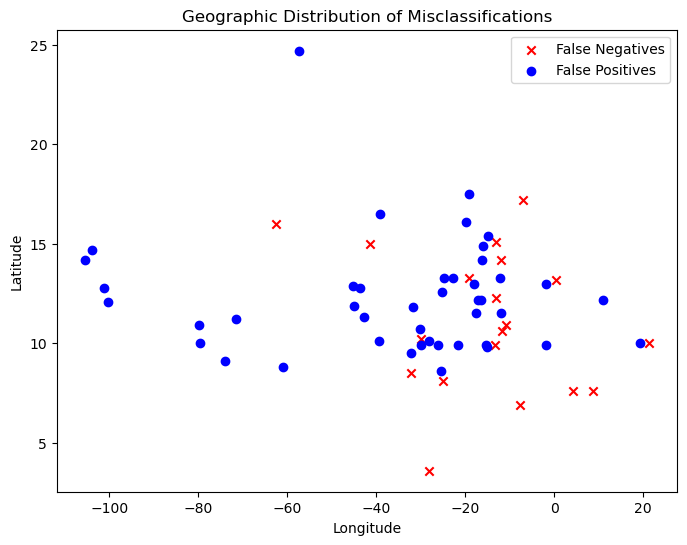

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(lon_false_neg, lat_false_neg, marker='x', color='red', label='False Negatives')
plt.scatter(lon_false_pos, lat_false_pos, marker='o', color='blue', label='False Positives')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Misclassifications')
plt.legend()
plt.show()


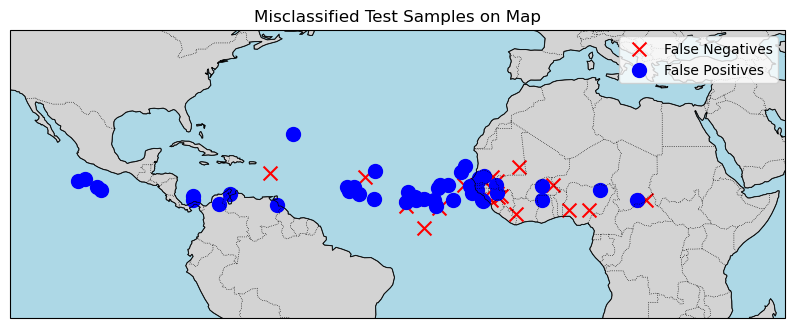

In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())



lon_min, lon_max = np.min(lon_test)-15, np.max(lon_test)+15
lat_min, lat_max = np.min(lat_test)-15, np.max(lat_test)+15
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot misclassified points:
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')

plt.title("Misclassified Test Samples on Map")
plt.legend()
plt.show()

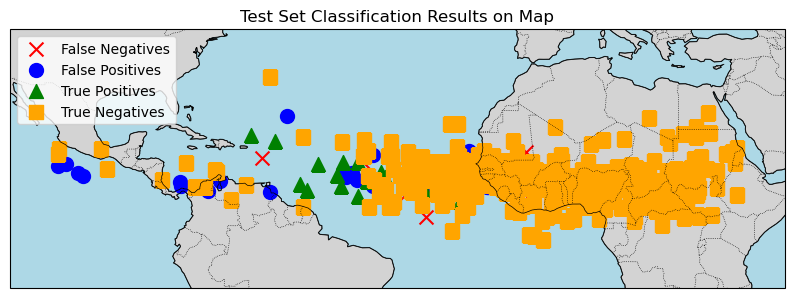

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set map extent (adjust margins as desired)
lon_min, lon_max = np.min(lon_test) - 10, np.max(lon_test) + 10
lat_min, lat_max = np.min(lat_test) - 10, np.max(lat_test) + 10
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
# Plot misclassified points
ax.scatter(lon_false_neg, lat_false_neg, color='red', marker='x', s=100,
           transform=ccrs.PlateCarree(), label='False Negatives')
ax.scatter(lon_false_pos, lat_false_pos, color='blue', marker='o', s=100,
           transform=ccrs.PlateCarree(), label='False Positives')



# Plot correctly classified points
ax.scatter(lon_true_pos, lat_true_pos, color='green', marker='^', s=100,
           transform=ccrs.PlateCarree(), label='True Positives')
ax.scatter(lon_true_neg, lat_true_neg, color='orange', marker='s', s=100,
           transform=ccrs.PlateCarree(), label='True Negatives')

plt.title("Test Set Classification Results on Map")
plt.legend()
plt.show()


In [43]:
print("Total samples:", len(sample_lat))
print("Unique latitudes:", len(np.unique(sample_lat)))
print("Unique longitudes:", len(np.unique(sample_lon)))


Total samples: 2444
Unique latitudes: 241
Unique longitudes: 867


In [44]:
print("First 10 latitudes:", sample_lat[:10])
print("First 10 longitudes:", sample_lon[:10])


First 10 latitudes: <xarray.DataArray 'lat_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample      (sample) int64 80B 1 1 1 1 1 1 1 1 1 1
    time        (sample) datetime64[ns] 80B dask.array<chunksize=(10,), meta=np.ndarray>
First 10 longitudes: <xarray.DataArray 'lon_center' (sample: 10)> Size: 80B
dask.array<getitem, shape=(10,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
    file_name   (sample) <U102 4kB dask.array<chunksize=(10,), meta=np.ndarray>
    lat_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
    lon_center  (sample) float64 80B dask.array<chunksize=(10,), meta=np.ndarray>
  * sample 

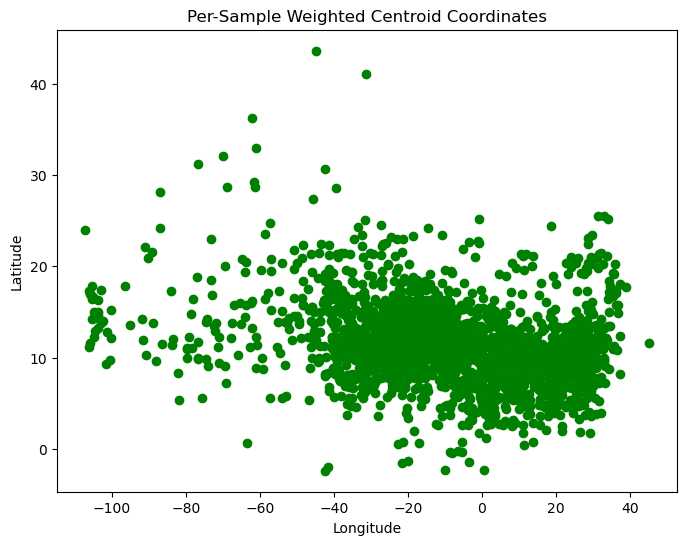

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(sample_lon, sample_lat, c='green', marker='o')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Per-Sample Weighted Centroid Coordinates')
plt.show()


In [46]:


# --- Permutation Importance ---
# Evaluate baseline performance using your loss metric (here, the custom f1_loss_sigmoid)
# model.metrics_names gives a list where index 0 is 'loss'
baseline_results = model.evaluate(input_test_scaled, label_test_scaled,
                                  batch_size=label_test_scaled.shape[0],
                                  verbose=0)
baseline_loss = baseline_results[model.metrics_names.index('loss')]
print("Baseline loss:", baseline_loss)

# Set the number of repetitions for averaging
n_repeats = 5
n_features = input_test_scaled.shape[-1]
permutation_importances = np.zeros(n_features)

# Loop over each feature (channel)
for feature_idx in range(n_features):
    permuted_losses = []
    for _ in range(n_repeats):
        # Copy the test set to avoid modifying the original
        X_permuted = np.copy(input_test_scaled)
        # Permute the values of the selected feature across samples
        perm = np.random.permutation(X_permuted.shape[0])
        X_permuted[:, :, :, feature_idx] = X_permuted[perm, :, :, feature_idx]
        
        # Evaluate the model on the permuted test set
        permuted_results = model.evaluate(X_permuted, label_test_scaled,
                                          batch_size=label_test_scaled.shape[0],
                                          verbose=0)
        permuted_loss = permuted_results[model.metrics_names.index('loss')]
        permuted_losses.append(permuted_loss)
    
    avg_permuted_loss = np.mean(permuted_losses)
    # The difference between the permuted loss and baseline loss indicates feature importance:
    # A larger increase means the feature is more important.
    permutation_importances[feature_idx] = avg_permuted_loss - baseline_loss
    print(f"Feature {feature_idx} - Increase in Loss: {permutation_importances[feature_idx]}")

print("Permutation Importances (increase in loss) for all features:", permutation_importances)


Baseline loss: 0.05533153936266899


Feature 0 - Increase in Loss: 0.006446313858032224


Feature 1 - Increase in Loss: -0.0013680785894393949


Feature 2 - Increase in Loss: 0.000919736921787262


Feature 3 - Increase in Loss: 0.010568400472402567


Feature 4 - Increase in Loss: 0.0018785029649734525


Feature 5 - Increase in Loss: 0.0021619871258735657


Feature 6 - Increase in Loss: 0.0034510642290115356


Feature 7 - Increase in Loss: 0.006419746577739714


Feature 8 - Increase in Loss: 0.004201436042785646


Feature 9 - Increase in Loss: 0.002345991134643552


Feature 10 - Increase in Loss: -0.000886525958776474


Feature 11 - Increase in Loss: -0.0012618102133274064


Feature 12 - Increase in Loss: 0.007756565511226651


Feature 13 - Increase in Loss: 0.0090251050889492


Feature 14 - Increase in Loss: -0.00170060098171234


Feature 15 - Increase in Loss: 0.00046543851494788846


Feature 16 - Increase in Loss: -0.0019347496330738082


Feature 17 - Increase in Loss: 5.079582333564897e-05
Permutation Importances (increase in loss) for all features: [ 6.44631386e-03 -1.36807859e-03  9.19736922e-04  1.05684005e-02
  1.87850296e-03  2.16198713e-03  3.45106423e-03  6.41974658e-03
  4.20143604e-03  2.34599113e-03 -8.86525959e-04 -1.26181021e-03
  7.75656551e-03  9.02510509e-03 -1.70060098e-03  4.65438515e-04
 -1.93474963e-03  5.07958233e-05]


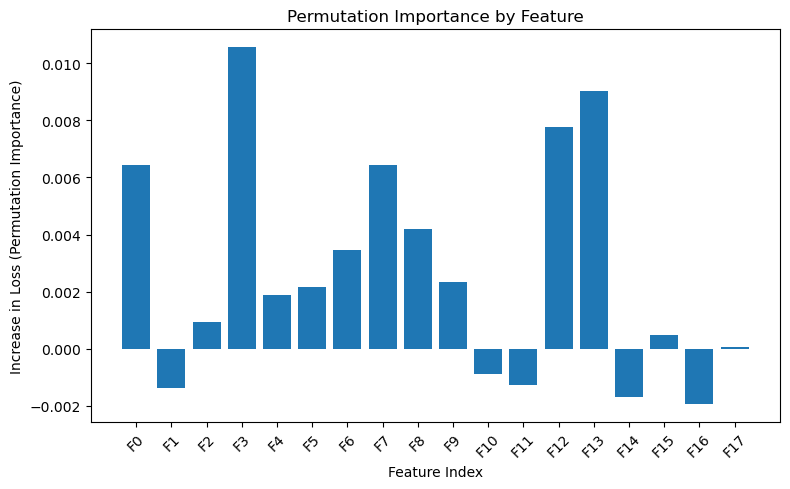

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Suppose permutation_importances is the numpy array you printed:
# e.g., [0.0820, 0.0824, 0.0815, 0.0864, 0.0121, ...]

feature_indices = np.arange(len(permutation_importances))

plt.figure(figsize=(8, 5))
plt.bar(feature_indices, permutation_importances)
plt.xlabel("Feature Index")
plt.ylabel("Increase in Loss (Permutation Importance)")
plt.title("Permutation Importance by Feature")
plt.xticks(feature_indices, [f"F{i}" for i in feature_indices], rotation=45)
plt.tight_layout()
plt.show()


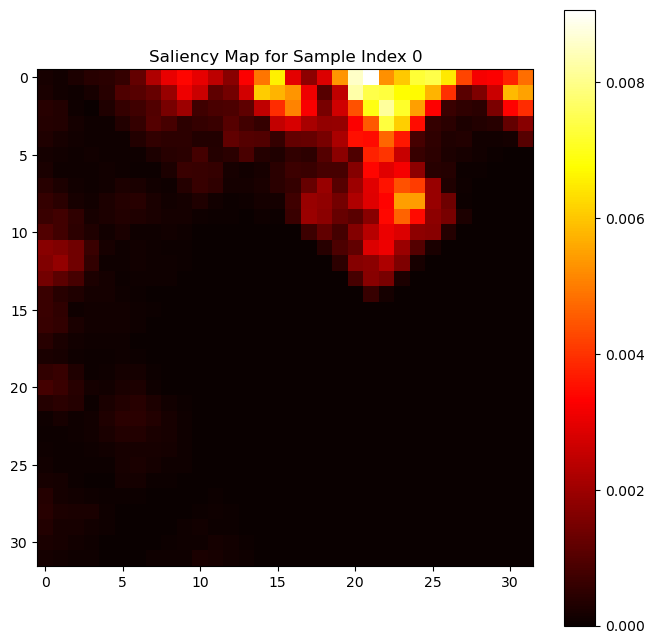

In [48]:
sample_index = 0
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute the saliency map for the selected test sample
saliency_map = compute_saliency_map(model, sample_input)

# Plot the saliency map
plt.figure(figsize=(8, 8))
plt.imshow(saliency_map, cmap='hot')
plt.colorbar()
plt.title(f"Saliency Map for Sample Index {sample_index}")
plt.show()



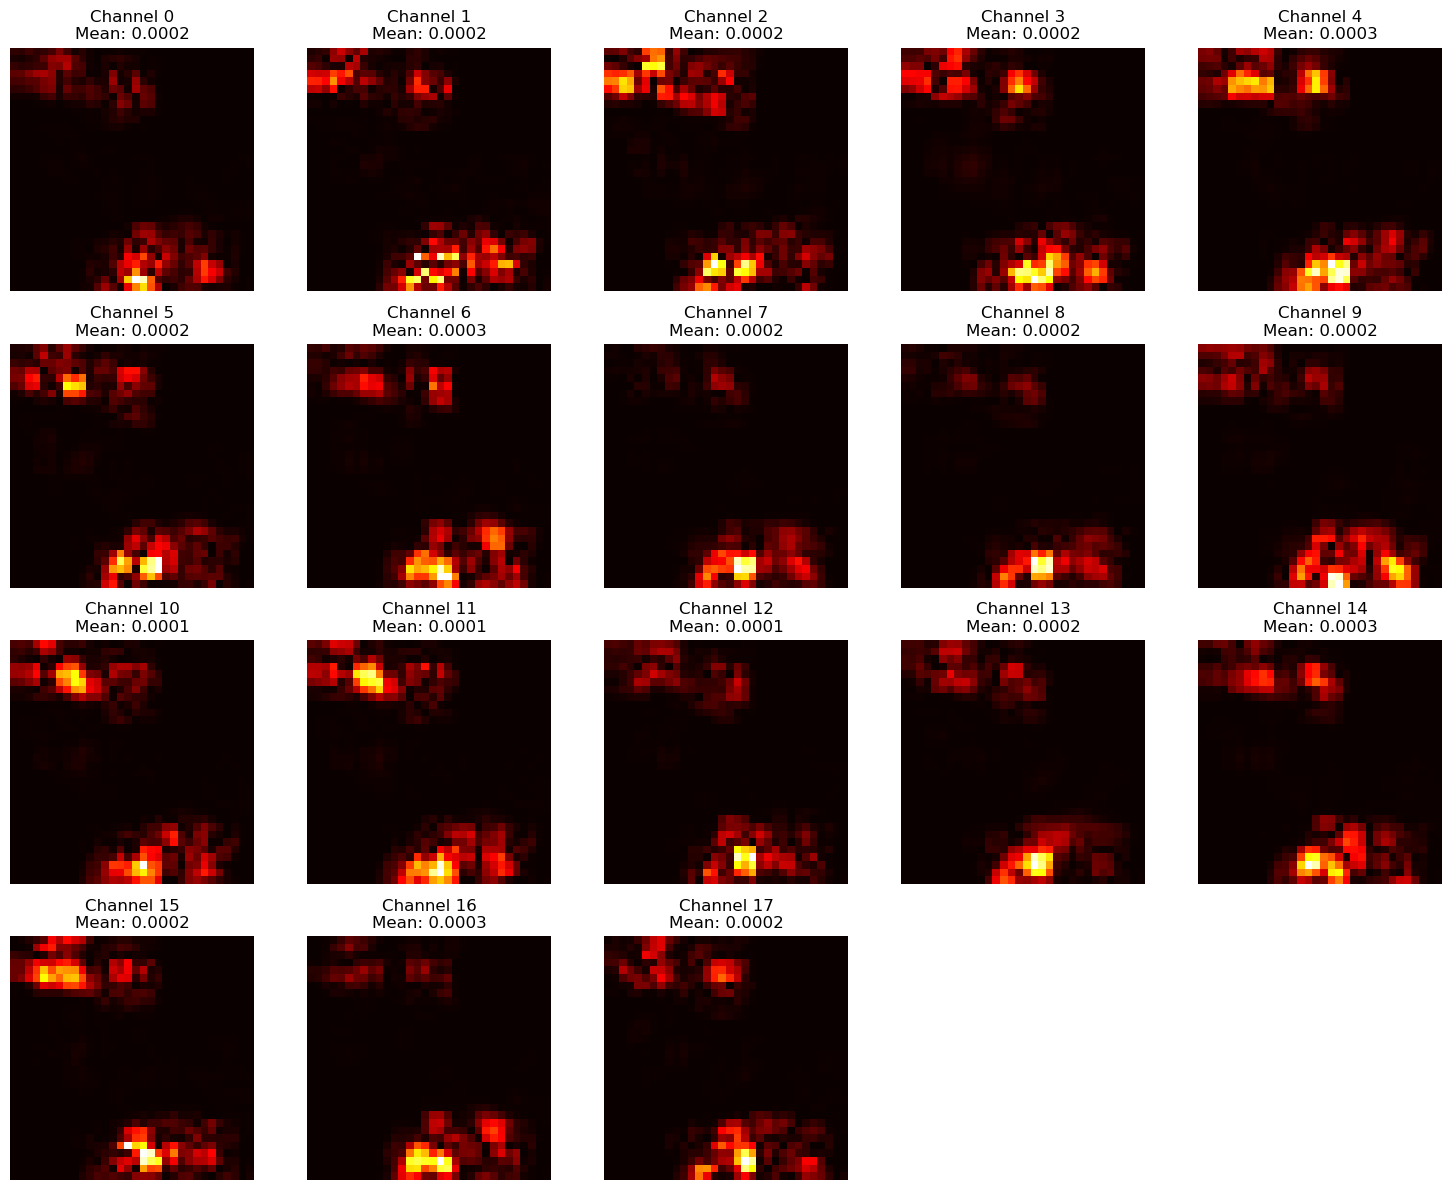

Channel importance (mean saliency per channel):
Channel 0: 0.0002
Channel 1: 0.0002
Channel 2: 0.0002
Channel 3: 0.0002
Channel 4: 0.0003
Channel 5: 0.0002
Channel 6: 0.0003
Channel 7: 0.0002
Channel 8: 0.0002
Channel 9: 0.0002
Channel 10: 0.0001
Channel 11: 0.0001
Channel 12: 0.0001
Channel 13: 0.0002
Channel 14: 0.0003
Channel 15: 0.0002
Channel 16: 0.0003
Channel 17: 0.0002


In [49]:
sample_index = 1
sample_input = input_test_scaled[sample_index:sample_index+1]

# Compute saliency maps per channel for the selected input sample
saliency_maps, channel_importance = compute_saliency_per_channel(model, sample_input)

# Plot the saliency maps for each channel
num_channels = saliency_maps.shape[-1]
cols = 5  # Set number of columns for plotting
rows = int(np.ceil(num_channels / cols))
plt.figure(figsize=(15, rows * 3))
for c in range(num_channels):
    plt.subplot(rows, cols, c + 1)
    plt.imshow(saliency_maps[:, :, c], cmap='hot')
    plt.title(f'Channel {c}\nMean: {channel_importance[c]:.4f}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print aggregated channel importance values
print("Channel importance (mean saliency per channel):")
for c, imp in enumerate(channel_importance):
    print(f"Channel {c}: {imp:.4f}")


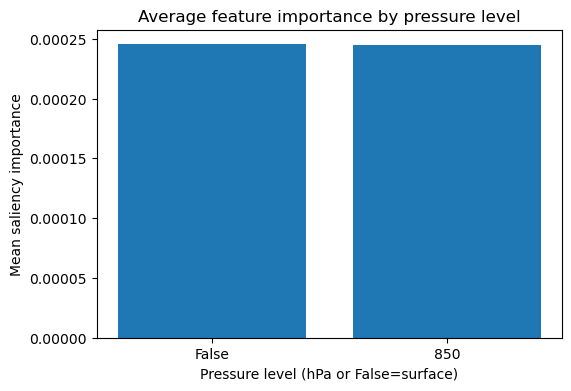

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Compute per‑sample, per‑channel saliency importances
all_imps = []
for x in input_test_scaled:             # each x has shape (32,32,channels)
    _, imp = compute_saliency_per_channel(best_model, x[np.newaxis,...])
    all_imps.append(imp)               # imp.shape == (channels,)
all_imps = np.stack(all_imps)          # shape (N_samples, channels)

# 2) Average importance across samples
mean_imp = all_imps.mean(axis=0)       # shape (channels,)

# 3) Build a DataFrame mapping feature→plevel→importance
df = pd.DataFrame({
    "feature": var_list,
    "plevel": plevel_list,
    "importance": mean_imp
})

# 4) Group by pressure level and plot
grouped = df.groupby("plevel")["importance"].mean().reset_index()
plt.figure(figsize=(6,4))
plt.bar(grouped["plevel"].astype(str), grouped["importance"])
plt.xlabel("Pressure level (hPa or False=surface)")
plt.ylabel("Mean saliency importance")
plt.title("Average feature importance by pressure level")
plt.show()


{'loss': 0.05533153936266899, 'compile_metrics': 0.3387616276741028}
    f1_score  val_f1_score
95  0.566667      0.431372
96  0.563107      0.413793
97  0.598540      0.452830
98  0.594059      0.470588
99  0.570755      0.489796


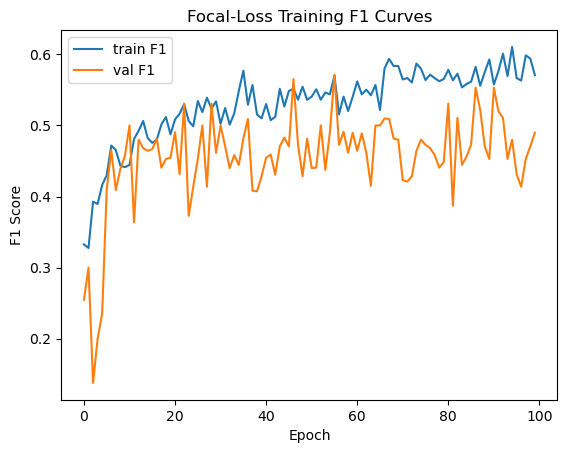

In [51]:
# 1) Print out full test‐set metrics by name
test_results = model.evaluate(
    input_test_scaled,
    label_test_scaled,
    batch_size=label_test_scaled.shape[0],
    verbose=0
)
print(dict(zip(model.metrics_names, test_results)))

# 2) Peek at the end of your training history for F1 improvements
import pandas as pd
hist_df = pd.DataFrame(history.history)
print(hist_df[['f1_score','val_f1_score']].tail())

# 3) (Optional) Plot train vs. val F1 over epochs
import matplotlib.pyplot as plt
plt.plot(hist_df['f1_score'],    label='train F1')
plt.plot(hist_df['val_f1_score'],label='val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.title('Focal‐Loss Training F1 Curves')
plt.show()


In [52]:
# Replace your rebuild logic:
# top_hps = tuner.get_best_hyperparameters(num_trials=5)
# models  = [MyHyperModel().build(hp) for hp in top_hps]

# With this single line:
models = tuner.get_best_models(num_models=5)

# Then stack and average as before:
all_preds     = np.stack([m.predict(input_test_scaled).flatten() for m in models], axis=0)
ensemble_probs= all_preds.mean(axis=0)
ensemble_preds= (ensemble_probs >= 0.5).astype(int)
print("Ensemble F1:", f1_score(label_test_scaled, ensemble_preds))


/glade/u/home/rmandava/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


 1/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Ensemble F1: 0.5882352941176471
